In [37]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import uproot3 as uproot
import pandas as pd
import numpy as np
import math
from tqdm import tqdm


from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)


print(uproot.__version__)
print(pd.__version__)

3.14.4
1.5.3


## Signal and selection definitions for both the overal channel and the 0pNp subchannel

Not to Giacomo: You will want to change these to match your own definitions

In [2]:
sig_query = "truth_isCC==1 and abs(truth_nuPdg)==14 and truth_vtxInside==1 and match_completeness_energy/truth_energyInside>=0.1"
sel_query = "numu_cc_flag>=0 and numu_score > 0.9"

true_0p_query = "truth_prim_p_energy<35"
reco_0p_query = "reco_prim_p_energy<35"
true_Np_query = "truth_prim_p_energy>=35"
reco_Np_query = "reco_prim_p_energy>=35"

em_charge_scale = 0.95

## Helper functions

In [4]:
def get_angle(momentum_0,momentum_1,momentum_2):
    momentum_perp = np.sqrt(momentum_0 * momentum_0 + momentum_1 * momentum_1)
    # defined in https://root.cern/doc/master/TVector3_8cxx_source.html
    theta = np.arctan2(momentum_perp, momentum_2)
    phi = np.arctan2(momentum_0, momentum_1)
    return theta, phi

def trim_effpur(pur, counts ,min_counts):
    purA = np.ones_like(pur)
    for i in range(len(pur)): 
        for j in range(len(pur[i])):
            purA[i][j] = pur[i][j]
            if counts[i][j]<min_counts: purA[i][j]=np.nan
    return purA

def get_x_err(x):
    x_err = np.zeros_like([x,x])
    for i in range(len(x)):
        if i == 0: 
            #x_err[0][i] = x[i] - x_min
            x_err[0][i] = x[i+1] - x[i]
            x_err[1][i] = x[i+1] - x[i]
        elif i == len(x)-1:
            x_err[0][i] =  x[i] - x[i-1]
            x_err[1][i] =  x[i] - x[i-1]
        else: 
            x_err[0][i] =  x[i] - x[i-1]
            x_err[1][i] =  x[i+1] - x[i]
    return x_err/2


def get_bin_widths(x):
    widths = []
    for i in range(len(x)-1): widths.append(x[i+1]-x[i])
    return widths

def get_bin_centers(x):
    centers = []
    for i in range(len(x)-1): centers.append( x[i] + (x[i+1]-x[i])/2 )
    return centers


## Plot of the reweighting function

Note to Giacomo: you can add in your own rw function here if you like. Doing so here will also make it so you can look at all you plots with and without the reweighting later on by using the variable $net\_reweight\_POTscaled$ instead of $net\_weight\_POTscaled$.

[  0.   35.   52.5  70.   87.5 105.  122.5 140.  157.5 175.  192.5 210.
 227.5 245.  262.5 280.  297.5 315.  332.5 350.  367.5 385.  402.5 420.
 437.5 455.  472.5 490.  507.5 525.  542.5]
[1.19231, 0.362141, 0.406271, 0.989533, 1.04587, 1.16393, 1.27939, 1.32453, 1.31184, 1.3289, 1.23469, 1.12258, 1.14387, 0.944752, 0.889379, 1.04242, 1.08456, 1.06398, 1.07282, 1.05001, 1.09116, 1.11262, 1.13437, 1.1937, 1.29297, 1.22585, 0.996915, 0.644066, 0.40787, 1.26805, nan]


(0.0, 542.5)

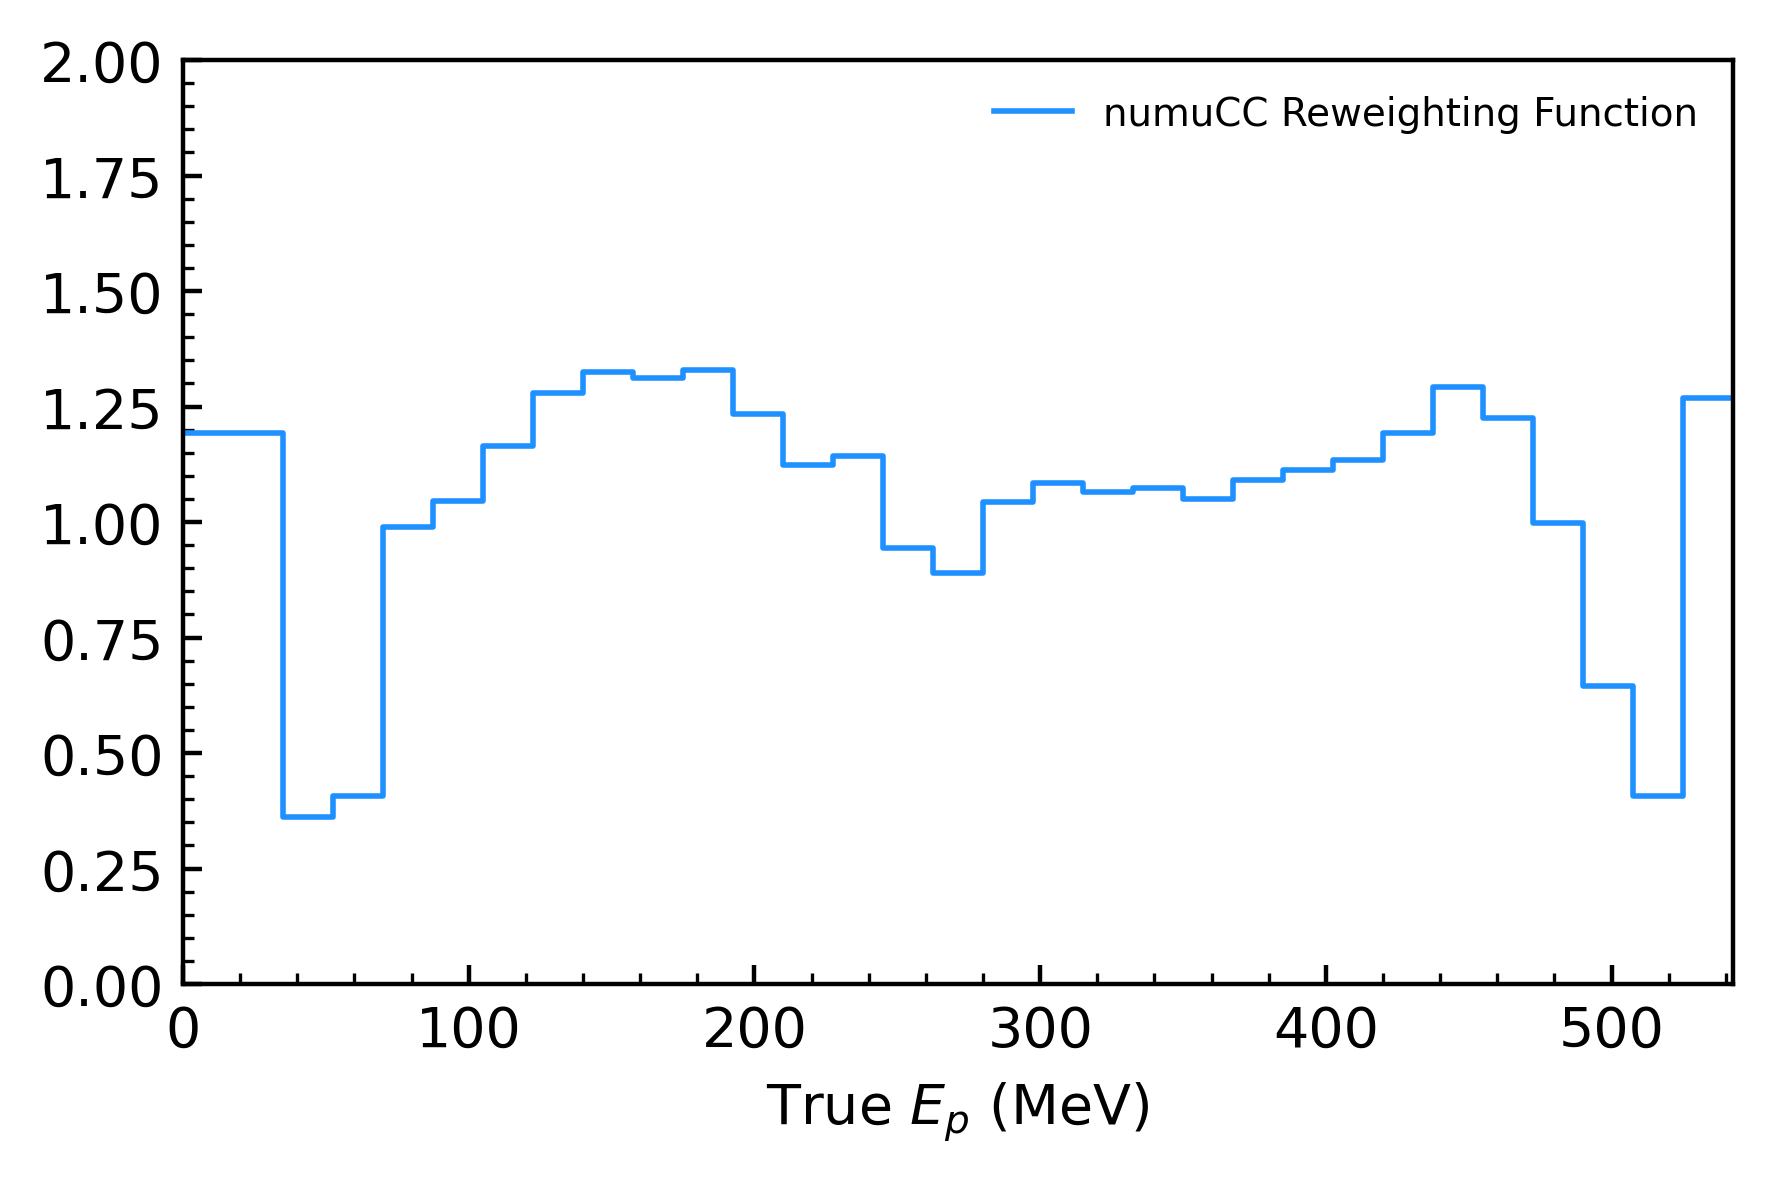

In [23]:
#Note: the np.nan at the end of the reweighting function is added to make the plotting look niver
xbins = np.linspace(35,542.5,30)
xbins = np.concatenate(([0],xbins))
print(xbins)
x = get_bin_centers(xbins)

rw = [1.19231,   0.362141,   0.406271,   0.989533,   1.04587,   1.16393,   1.27939,   1.32453,   1.31184,   1.3289,   1.23469,   1.12258,   1.14387,   0.944752,   0.889379,   1.04242,   1.08456,   1.06398,   1.07282,   1.05001,   1.09116,   1.11262,   1.13437,   1.1937,   1.29297,   1.22585,   0.996915,   0.644066,   0.40787,   1.26805]
rw.append(np.nan)
print(rw)


fig, (ax1) = plt.subplots(1,1,  figsize=(5, 3), dpi=400)
plt.subplots_adjust(wspace=.2)

ax1.step(xbins, rw, where='post', lw=1, label='numuCC Reweighting Function',color="dodgerblue")
ax1.set_xlabel(r'True $E_{p}$ (MeV)')
ax1.legend(fontsize=7, loc="upper right", frameon=False)
plt.minorticks_on()
ax1.tick_params(which='minor',direction='in')
ax1.tick_params(axis="x", direction="in")
ax1.tick_params(axis="y", direction="in")
ax1.set_ylim([0,2])
ax1.set_xlim([0,542.5])

## Make list of all the variables we are going to want in our data frame

In [8]:
extra_variables = [
    "run",
    "subrun",
    "event",
    "nuvtx_diff",
    "showervtx_diff",
    "muonvtx_diff",
    "truth_isCC",
    "truth_vtxInside",
    "truth_nuPdg",
    "truth_nuEnergy",
    "truth_nuIntType",
    "truth_energyInside",
    "weight_spline",
    "weight_cv",
    "weight_lee",
    "event_type",
    "weight",
    "lowEweight"
]

numu_bdt_score_variables = [
    "cosmict_10_score",
    "numu_1_score",
    "numu_2_score"
]

nue_bdt_score_variables = [
    "tro_5_score",
    "tro_4_score",
    "tro_2_score",
    "tro_1_score",
    "stw_4_score",
    "stw_3_score",
    "stw_2_score",
    "sig_2_score",
    "sig_1_score",
    "pio_2_score",
    "lol_2_score",
    "lol_1_score",
    "br3_6_score",
    "br3_5_score",
    "br3_3_score"
]

kine_scalar_vars = [
    "kine_reco_add_energy",
    "kine_pio_mass",
    "kine_pio_flag",
    "kine_pio_vtx_dis",
    "kine_pio_energy_1",
    "kine_pio_theta_1",
    "kine_pio_phi_1",
    "kine_pio_dis_1",
    "kine_pio_energy_2",
    "kine_pio_theta_2",
    "kine_pio_phi_2",
    "kine_pio_dis_2",
    "kine_pio_angle"
]

kine_vector_vars = [
    "kine_energy_particle",
    "kine_energy_info",
    "kine_particle_type",
    "kine_energy_included",
]

bdt_vars = [
    "nc_delta_score",
    "nc_delta_ntrack_score",
    "nc_delta_0track_score",
    "mip_energy",
    "mip_angle_beam", 
    "spt_angle_vertical",
    "nue_score", 
    "numu_score", 
    "nc_pio_score",
    "numu_cc_flag"
]

shower_dQ_dx_vars = ['mip_vec_dQ_dx_0', 'mip_vec_dQ_dx_1', 'mip_vec_dQ_dx_2', 'mip_vec_dQ_dx_3', 'mip_vec_dQ_dx_4', 'mip_vec_dQ_dx_5', 'mip_vec_dQ_dx_6', 'mip_vec_dQ_dx_7','mip_vec_dQ_dx_8', 'mip_vec_dQ_dx_9', 'mip_vec_dQ_dx_10', 'mip_vec_dQ_dx_11','mip_vec_dQ_dx_12', 'mip_vec_dQ_dx_13', 'mip_vec_dQ_dx_14', 'mip_vec_dQ_dx_15','mip_vec_dQ_dx_16', 'mip_vec_dQ_dx_17', 'mip_vec_dQ_dx_18', 'mip_vec_dQ_dx_19']

bdt_vars += shower_dQ_dx_vars

eval_mc_variables = [
    "run",
    "subrun",
    "event",
    "flash_time",
    "weight_spline", # this and remaining only make sense for MC
    "weight_cv",
    "match_completeness_energy",
    "truth_nuEnergy",
    "truth_energyInside",
    "truth_electronInside",
    "truth_nuPdg",
    "truth_isCC",
    "truth_isFC",
    "truth_vtxInside",
    "truth_vtxX",
    "truth_vtxY",
    "truth_vtxZ",
    "truth_nuTime",
    "flash_measPe",
    "flash_predPe",
]

eval_data_variables = [
    "run",
    "subrun",
    "event",
    "flash_time",
    "flash_measPe",
    "flash_predPe",
]


pf_eval_mc_variables = [
        "truth_NprimPio",
        "truth_NCDelta",
        "nuvtx_diff",
        "showervtx_diff",
        "reco_showerKE",
        "truth_pio_energy_1",
        "truth_pio_energy_2",
        "truth_pio_angle",
        "reco_nuvtxX",
        "reco_nuvtxY",
        "reco_nuvtxZ",
        "reco_showervtxX",
        "reco_showervtxY",
        "reco_showervtxZ",
        "reco_protonMomentum",
        "truth_nuIntType",
        "reco_Nproton",
        "reco_muonMomentum",
        "truth_muonMomentum",
    ]

pf_eval_data_variables = [ # also use these for dirt
            "reco_showerKE",
            "reco_nuvtxX",
            "reco_nuvtxY",
            "reco_nuvtxZ",
            "reco_showervtxX",
            "reco_showervtxY",
            "reco_showervtxZ",
            "reco_protonMomentum",
            "reco_muonMomentum",
            
    
    ]
dedicated_pf_eval_mc_variables = [
    "truth_pdg", 
    "truth_mother", 
    "truth_startMomentum",
    "truth_endMomentum",
    "reco_Ntrack",
    "reco_startMomentum",
    "reco_endMomentum",
    "reco_mother",
    "reco_pdg",
    "reco_id"
]

## Load all our files

Note to Giacomo: You will have to add in the NCpi0 overaly here. This can basically be just a copy of the block for the nu overaly. You will also have to add the appropiate .query() to the nu overlay df to make sure you are only the NCpi0 events from the NCpi0 overlay. 

Also, this block of code can take a little bit to run.

In [10]:
f_nu_overlay_run1 = uproot.open("../data/checkout_prodgenie_bnb_nu_overlay_run1_PF.root")["wcpselection"]
f_nu_overlay_run1_bdt = f_nu_overlay_run1["T_BDTvars"].pandas.df(bdt_vars, flatten=False)
f_nu_overlay_run1_eval = f_nu_overlay_run1["T_eval"].pandas.df(eval_mc_variables + ["match_isFC"], flatten=False)
f_nu_overlay_run1_pfeval = f_nu_overlay_run1["T_PFeval"].pandas.df(pf_eval_mc_variables+ dedicated_pf_eval_mc_variables, flatten=False)
f_nu_overlay_run1_kine = f_nu_overlay_run1["T_KINEvars"].pandas.df(kine_scalar_vars + kine_vector_vars + ["kine_reco_Enu"], flatten=False)
f_nu_overlay_run1_pot = f_nu_overlay_run1["T_pot"].pandas.df("pot_tor875good", flatten=False)
nu_overlay_run1_POT = np.sum(f_nu_overlay_run1_pot["pot_tor875good"].to_numpy())
nu_overlay_run1_df = pd.concat([f_nu_overlay_run1_bdt, f_nu_overlay_run1_eval, f_nu_overlay_run1_pfeval, f_nu_overlay_run1_kine], axis=1, sort=False)
del f_nu_overlay_run1
del f_nu_overlay_run1_bdt
del f_nu_overlay_run1_eval
del f_nu_overlay_run1_pfeval
del f_nu_overlay_run1_kine
del f_nu_overlay_run1_pot
nu_overlay_run1_df["isEXT"] = [0 for i in range(nu_overlay_run1_df.shape[0])]
nu_overlay_run1_df["isDirt"] = [0 for i in range(nu_overlay_run1_df.shape[0])]
nu_overlay_run1_df["WC_file"] = ["nu_overlay_run1" for i in range(nu_overlay_run1_df.shape[0])]
nu_overlay_run1_df["run_num"] = [1 for i in range(nu_overlay_run1_df.shape[0])]

f_nu_overlay_run2 = uproot.open("../data/checkout_prodgenie_bnb_nu_overlay_run2_PF.root")["wcpselection"]
f_nu_overlay_run2_bdt = f_nu_overlay_run2["T_BDTvars"].pandas.df(bdt_vars, flatten=False)
f_nu_overlay_run2_eval = f_nu_overlay_run2["T_eval"].pandas.df(eval_mc_variables + ["match_isFC"], flatten=False)
f_nu_overlay_run2_pfeval = f_nu_overlay_run2["T_PFeval"].pandas.df(pf_eval_mc_variables+ dedicated_pf_eval_mc_variables, flatten=False)
f_nu_overlay_run2_kine = f_nu_overlay_run2["T_KINEvars"].pandas.df(kine_scalar_vars + kine_vector_vars + ["kine_reco_Enu"], flatten=False)
f_nu_overlay_run2_pot = f_nu_overlay_run2["T_pot"].pandas.df("pot_tor875good", flatten=False)
nu_overlay_run2_POT = np.sum(f_nu_overlay_run2_pot["pot_tor875good"].to_numpy())
nu_overlay_run2_df = pd.concat([f_nu_overlay_run2_bdt, f_nu_overlay_run2_eval, f_nu_overlay_run2_pfeval, f_nu_overlay_run2_kine], axis=1, sort=False)
del f_nu_overlay_run2
del f_nu_overlay_run2_bdt
del f_nu_overlay_run2_eval
del f_nu_overlay_run2_pfeval
del f_nu_overlay_run2_kine
del f_nu_overlay_run2_pot
nu_overlay_run2_df["isEXT"] = [0 for i in range(nu_overlay_run2_df.shape[0])]
nu_overlay_run2_df["isDirt"] = [0 for i in range(nu_overlay_run2_df.shape[0])]
nu_overlay_run2_df["WC_file"] = ["nu_overlay_run2" for i in range(nu_overlay_run2_df.shape[0])]
nu_overlay_run2_df["run_num"] = [2 for i in range(nu_overlay_run2_df.shape[0])]

f_nu_overlay_run3 = uproot.open("../data/checkout_prodgenie_bnb_nu_overlay_run3_PF.root")["wcpselection"]
f_nu_overlay_run3_bdt = f_nu_overlay_run3["T_BDTvars"].pandas.df(bdt_vars, flatten=False)
f_nu_overlay_run3_eval = f_nu_overlay_run3["T_eval"].pandas.df(eval_mc_variables + ["match_isFC"], flatten=False)
f_nu_overlay_run3_pfeval = f_nu_overlay_run3["T_PFeval"].pandas.df(pf_eval_mc_variables+ dedicated_pf_eval_mc_variables, flatten=False)
f_nu_overlay_run3_kine = f_nu_overlay_run3["T_KINEvars"].pandas.df(kine_scalar_vars + kine_vector_vars + ["kine_reco_Enu"], flatten=False)
f_nu_overlay_run3_pot = f_nu_overlay_run3["T_pot"].pandas.df("pot_tor875good", flatten=False)
nu_overlay_run3_POT = np.sum(f_nu_overlay_run3_pot["pot_tor875good"].to_numpy())
nu_overlay_run3_df = pd.concat([f_nu_overlay_run3_bdt, f_nu_overlay_run3_eval, f_nu_overlay_run3_pfeval, f_nu_overlay_run3_kine], axis=1, sort=False)
del f_nu_overlay_run3
del f_nu_overlay_run3_bdt
del f_nu_overlay_run3_eval
del f_nu_overlay_run3_pfeval
del f_nu_overlay_run3_kine
del f_nu_overlay_run3_pot
nu_overlay_run3_df["isEXT"] = [0 for i in range(nu_overlay_run3_df.shape[0])]
nu_overlay_run3_df["isDirt"] = [0 for i in range(nu_overlay_run3_df.shape[0])]
nu_overlay_run3_df["WC_file"] = ["nu_overlay_run3" for i in range(nu_overlay_run3_df.shape[0])]
nu_overlay_run3_df["run_num"] = [3 for i in range(nu_overlay_run3_df.shape[0])]

overlay_df = pd.concat([nu_overlay_run1_df, nu_overlay_run2_df, nu_overlay_run3_df], sort=False)
del nu_overlay_run1_df
del nu_overlay_run2_df
del nu_overlay_run3_df


In [11]:
f_dirt_run1 = uproot.open("../data/checkout_prodgenie_bnb_dirt_overlay_run1_PF.root")["wcpselection"]
f_dirt_run1_bdt = f_dirt_run1["T_BDTvars"].pandas.df(bdt_vars, flatten=False)
f_dirt_run1_eval = f_dirt_run1["T_eval"].pandas.df(eval_mc_variables + ["match_isFC"], flatten=False)
f_dirt_run1_pfeval = f_dirt_run1["T_PFeval"].pandas.df(pf_eval_data_variables+ dedicated_pf_eval_mc_variables, flatten=False)
f_dirt_run1_kine = f_dirt_run1["T_KINEvars"].pandas.df(kine_scalar_vars + kine_vector_vars + ["kine_reco_Enu"], flatten=False)
f_dirt_run1_pot = f_dirt_run1["T_pot"].pandas.df("pot_tor875good", flatten=False)
dirt_run1_POT = np.sum(f_dirt_run1_pot["pot_tor875good"].to_numpy())
dirt_run1_df = pd.concat([f_dirt_run1_bdt, f_dirt_run1_eval, f_dirt_run1_pfeval, f_dirt_run1_kine], axis=1, sort=False)
del f_dirt_run1
del f_dirt_run1_bdt
del f_dirt_run1_eval
del f_dirt_run1_pfeval
del f_dirt_run1_kine
del f_dirt_run1_pot
dirt_run1_df["isEXT"] = [0 for i in range(dirt_run1_df.shape[0])]
dirt_run1_df["isDirt"] = [1 for i in range(dirt_run1_df.shape[0])]
dirt_run1_df["WC_file"] = ["dirt_run1" for i in range(dirt_run1_df.shape[0])]
dirt_run1_df["run_num"] = [1 for i in range(dirt_run1_df.shape[0])]

f_dirt_run2 = uproot.open("../data/checkout_prodgenie_bnb_dirt_overlay_run2_PF.root")["wcpselection"]
f_dirt_run2_bdt = f_dirt_run2["T_BDTvars"].pandas.df(bdt_vars, flatten=False)
f_dirt_run2_eval = f_dirt_run2["T_eval"].pandas.df(eval_mc_variables + ["match_isFC"], flatten=False)
f_dirt_run2_pfeval = f_dirt_run2["T_PFeval"].pandas.df(pf_eval_data_variables+ dedicated_pf_eval_mc_variables, flatten=False)
f_dirt_run2_kine = f_dirt_run2["T_KINEvars"].pandas.df(kine_scalar_vars + kine_vector_vars + ["kine_reco_Enu"], flatten=False)
f_dirt_run2_pot = f_dirt_run2["T_pot"].pandas.df("pot_tor875good", flatten=False)
dirt_run2_POT = np.sum(f_dirt_run2_pot["pot_tor875good"].to_numpy())
dirt_run2_df = pd.concat([f_dirt_run2_bdt, f_dirt_run2_eval, f_dirt_run2_pfeval, f_dirt_run2_kine], axis=1, sort=False)
del f_dirt_run2
del f_dirt_run2_bdt
del f_dirt_run2_eval
del f_dirt_run2_pfeval
del f_dirt_run2_kine
del f_dirt_run2_pot
dirt_run2_df["isEXT"] = [0 for i in range(dirt_run2_df.shape[0])]
dirt_run2_df["isDirt"] = [1 for i in range(dirt_run2_df.shape[0])]
dirt_run2_df["WC_file"] = ["dirt_run2" for i in range(dirt_run2_df.shape[0])]
dirt_run2_df["run_num"] = [2 for i in range(dirt_run2_df.shape[0])]

f_dirt_run3 = uproot.open("../data/checkout_prodgenie_bnb_dirt_overlay_run3_PF.root")["wcpselection"]
f_dirt_run3_bdt = f_dirt_run3["T_BDTvars"].pandas.df(bdt_vars, flatten=False)
f_dirt_run3_eval = f_dirt_run3["T_eval"].pandas.df(eval_mc_variables + ["match_isFC"], flatten=False)
f_dirt_run3_pfeval = f_dirt_run3["T_PFeval"].pandas.df(pf_eval_data_variables+ dedicated_pf_eval_mc_variables, flatten=False)
f_dirt_run3_kine = f_dirt_run3["T_KINEvars"].pandas.df(kine_scalar_vars + kine_vector_vars + ["kine_reco_Enu"], flatten=False)
f_dirt_run3_pot = f_dirt_run3["T_pot"].pandas.df("pot_tor875good", flatten=False)
dirt_run3_POT = np.sum(f_dirt_run3_pot["pot_tor875good"].to_numpy())
dirt_run3_df = pd.concat([f_dirt_run3_bdt, f_dirt_run3_eval, f_dirt_run3_pfeval, f_dirt_run3_kine], axis=1, sort=False)
del f_dirt_run3
del f_dirt_run3_bdt
del f_dirt_run3_eval
del f_dirt_run3_pfeval
del f_dirt_run3_kine
del f_dirt_run3_pot
dirt_run3_df["isEXT"] = [0 for i in range(dirt_run3_df.shape[0])]
dirt_run3_df["isDirt"] = [1 for i in range(dirt_run3_df.shape[0])]
dirt_run3_df["WC_file"] = ["dirt_run3" for i in range(dirt_run3_df.shape[0])]
dirt_run3_df["run_num"] = [3 for i in range(dirt_run3_df.shape[0])]
    

dirt_df = pd.concat([dirt_run1_df, dirt_run2_df, dirt_run3_df], sort=False)
del dirt_run1_df
del dirt_run2_df
del dirt_run3_df
    

Note to Giacomo: Make sure you add the NCpi0 overfram to the block below

In [12]:
all_df = pd.concat([overlay_df, dirt_df], sort=False, ignore_index=True)
del overlay_df
del dirt_df

## Add in additional truth level varibles

Note to Giacomo: You may have to add in some additional varibels here, but I do not think so. This block is a bit of a mess still becouse it has been reweitten many times.

Also, this block takes a bit to run.

In [13]:
num_prim_photons = []
num_prim_protons = []
num_prim_protons_th35 = []

num_prim_charged_pions = []
num_prim_charged_pions_th10 = []
num_charged_pions = []
num_charged_pions_th10 = []

num_prim_neutrons = []
num_prim_electrons = []
num_prim_muons = []

num_prim_pi0s = []
num_pi0s = []

num_prim_others = []

photon_thetas = []
photon_phis = []
photon_energies = []

Enu = all_df["truth_nuEnergy"].to_numpy()

truth_nuPdgs = all_df["truth_nuPdg"].to_numpy()
truth_pdgs = all_df["truth_pdg"].to_numpy()
truth_mothers = all_df["truth_mother"].to_numpy()
truth_startMomentums = all_df["truth_startMomentum"].to_numpy()

Eavails = []

num_protons_all = []
num_protons_all_th35 = []

proton_thetas = []
proton_phis = []
prim_proton_thetas = []
prim_proton_phis = []

proton_costhetas = []
proton_cosphis = []
prim_proton_costhetas = []
prim_proton_cosphis = []

max_p_energy = []
sub_p_energy = []
subsub_p_energy = []
min_p_energy = []
max_prim_p_energy = []
sub_prim_p_energy = []
subsub_prim_p_energy = []
min_prim_p_energy = []

max_prim_pi_energy = []
min_prim_pi_energy = []
max_pi_energy = []
min_pi_energy = []

max_prim_pi0_energy = []
min_prim_pi0_energy = []
max_pi0_energy = []
min_pi0_energy = []

Emu = []
Et = []
Emu = all_df["truth_muonMomentum[3]"].to_numpy()

for i in tqdm(range(all_df.shape[0])):
    
    iEnu = Enu[i]
    truth_nuPdg = truth_nuPdgs[i]
    Eavail = 0
    
    iEmu = 0
    
    num_prim_photon = 0
    
    num_prim_proton = 0
    num_prim_proton_th35 = 0
    num_proton = 0
    num_proton_th35 = 0

    num_prim_neutron = 0
    num_prim_electron = 0
    num_prim_muon = 0
    num_prim_other = 0

    photon_theta = np.nan
    photon_phi = np.nan
    photon_energy = np.nan
    
    truth_pdg_list = []
    truth_pdg_list = truth_pdgs[i]
    truth_mother_list = truth_mothers[i]
    truth_startMomentum_list = truth_startMomentums[i]
    
    proton_theta = np.nan
    proton_phi = np.nan
    prim_proton_theta = np.nan
    prim_proton_phi = np.nan
    
    imax_p_energy = 0
    isub_p_energy = 0
    isubsub_p_energy = 0
    imin_p_energy = 0
    imax_prim_p_energy = 0
    isub_prim_p_energy = 0
    isubsub_prim_p_energy = 0
    imin_prim_p_energy = 0
    
    imax_prim_pi_energy = 0
    imin_prim_pi_energy = 0
    imax_pi_energy = 0
    imin_pi_energy = 0
    num_prim_charged_pion = 0
    num_charged_pion = 0
    num_prim_charged_pion_th10 = 0
    num_charged_pion_th10 = 0    
    
    imax_prim_pi0_energy = 0
    imin_prim_pi0_energy = 0
    imax_pi0_energy = 0
    imin_pi0_energy = 0
    num_prim_pi0 = 0
    num_pi0 = 0


    
    for j in range(len(truth_pdg_list)):
        
        #Eavail calculation
        if truth_mother_list[j]==0:
            if abs(truth_pdg_list[j]) == 12 or abs(truth_pdg_list[j]) == 14 or abs(truth_pdg_list[j]) == 16: Eavail+=0 #exiting nu
            elif truth_pdg_list[j] == 11 and truth_nuPdg == 12: Eavail+=0 #exiting lepton
            elif truth_pdg_list[j] == -11 and truth_nuPdg == -12: Eavail+=0 #exiting lepton
            elif truth_pdg_list[j] == 13 and truth_nuPdg == 14: Eavail+=0 #exiting lepton
            elif truth_pdg_list[j] == -13 and truth_nuPdg == -14: Eavail+=0 #exiting lepton
            elif truth_pdg_list[j] == 15 and truth_nuPdg == 16: Eavail+=0 #exiting lepton
            elif truth_pdg_list[j] == -15 and truth_nuPdg == -16: Eavail+=0 #exiting lepton
            elif abs(truth_pdg_list[j]) == 2112: Eavail+=0 #exiting neutron
            elif abs(truth_pdg_list[j])>3000 and abs(truth_pdg_list[j])<4000: Eavail+=0 #strange baryon
            elif abs(truth_pdg_list[j]) == 2212: Eavail += truth_startMomentum_list[j][3]-0.938272 #proton
            elif abs(truth_pdg_list[j]) == 211: Eavail += truth_startMomentum_list[j][3]-0.13957 #pi
            else: Eavail+=truth_startMomentum_list[j][3]
        
            


        photon_angle_found = False

        if truth_mother_list[j] != 0: # non-primary
            if abs(truth_pdg_list[j]) == 2212:
                if truth_startMomentum_list[j][3]-0.938272>imax_p_energy: 
                    isubsub_p_energy = isub_p_energy
                    isub_p_energy = imax_p_energy
                    imax_p_energy = truth_startMomentum_list[j][3]-0.938272
                    proton_theta, proton_phi = get_angle(truth_startMomentum_list[j][0], truth_startMomentum_list[j][1], truth_startMomentum_list[j][2])
                elif truth_startMomentum_list[j][3]-0.938272>isub_p_energy: 
                    isubsub_p_energy = isub_p_energy
                    isub_p_energy = truth_startMomentum_list[j][3]-0.938272
                elif truth_startMomentum_list[j][3]-0.938272>isubsub_p_energy: 
                    isubsub_p_energy = truth_startMomentum_list[j][3]-0.938272 
                num_proton += 1
                if truth_startMomentum_list[j][3]-0.938272>0.035: num_proton_th35 += 1
            if abs(truth_pdg_list[j]) == 211:
                num_charged_pion+=1
                if truth_startMomentum_list[j][3]-0.13957>imax_pi_energy: imax_pi_energy = truth_startMomentum_list[j][3]-0.13957
                if truth_startMomentum_list[j][3]-0.13957>0.01: num_charged_pion_th10+=1
            if abs(truth_pdg_list[j]) == 111:
                num_pi0+=1
                if truth_startMomentum_list[j][3]-0.1349768>imax_pi0_energy: imax_pi0_energy = truth_startMomentum_list[j][3]-0.1349768
            continue
            
        if abs(truth_pdg_list[j]) == 12 or abs(truth_pdg_list[j]) == 14: # primary neutrino (exiting NC interaction)
            continue
        elif truth_pdg_list[j] == 22:
            num_prim_photon += 1

            if not photon_angle_found:

                photon_4_momentum = truth_startMomentum_list[j]

                if photon_4_momentum[3] > 0:
                    photon_momentum_perp = np.sqrt(photon_4_momentum[0] * photon_4_momentum[0] + photon_4_momentum[1] * photon_4_momentum[1])
                    photon_theta = np.arctan2(photon_momentum_perp, photon_4_momentum[2]) * 180. / np.pi
                    photon_phi = np.arctan2(photon_4_momentum[0], photon_4_momentum[1]) * 180. / np.pi
                    photon_energy = photon_4_momentum[3] * 1000.

                photon_angle_found = True

        
        #elif truth_pdg_list[j] == 13 and truth_startMomentum_list[j][3]*1000>iEmu: iEmu = truth_startMomentum_list[j][3]*1000
            
        elif abs(truth_pdg_list[j]) == 2212:
            num_prim_proton += 1
            num_proton += 1
            if truth_startMomentum_list[j][3]-0.938272>0.035:
                num_prim_proton_th35 += 1
                num_proton_th35 += 1
            if truth_startMomentum_list[j][3]-0.938272>imax_p_energy: 
                isubsub_p_energy = isub_p_energy
                isub_p_energy = imax_p_energy
                imax_p_energy = truth_startMomentum_list[j][3]-0.938272
                proton_theta, proton_phi = get_angle(truth_startMomentum_list[j][0], truth_startMomentum_list[j][1], truth_startMomentum_list[j][2])
            elif truth_startMomentum_list[j][3]-0.938272>isub_p_energy: 
                isubsub_p_energy = isub_p_energy
                isub_p_energy = truth_startMomentum_list[j][3]-0.938272
            elif truth_startMomentum_list[j][3]-0.938272>isubsub_p_energy: 
                isubsub_p_energy = truth_startMomentum_list[j][3]-0.938272
            if truth_startMomentum_list[j][3]-0.938272>imax_prim_p_energy: 
                isubsub_prim_p_energy = isub_prim_p_energy
                isub_prim_p_energy = imax_prim_p_energy
                imax_prim_p_energy = truth_startMomentum_list[j][3]-0.938272
                prim_proton_theta, prim_proton_phi = get_angle(truth_startMomentum_list[j][0], truth_startMomentum_list[j][1], truth_startMomentum_list[j][2])
            elif truth_startMomentum_list[j][3]-0.938272>isub_prim_p_energy: 
                isubsub_prim_p_energy = isub_p_energy
                isub_prim_p_energy = truth_startMomentum_list[j][3]-0.938272
            elif truth_startMomentum_list[j][3]-0.938272>isubsub_prim_p_energy: 
                isubsub_prim_p_energy = truth_startMomentum_list[j][3]-0.938272

            if truth_startMomentum_list[j][3]-0.938272<imin_p_energy or imin_p_energy==0:
                imin_p_energy = truth_startMomentum_list[j][3]-0.938272
            if truth_startMomentum_list[j][3]-0.938272<imin_prim_p_energy or imin_prim_p_energy==0:
                imin_prim_p_energy = truth_startMomentum_list[j][3]-0.938272
                
        elif abs(truth_pdg_list[j]) == 211:
            num_prim_charged_pion += 1
            num_charged_pion += 1
            if truth_startMomentum_list[j][3]-0.13957>imax_prim_pi_energy:
                imax_prim_pi_energy = truth_startMomentum_list[j][3]-0.13957
            if truth_startMomentum_list[j][3]-.13957<imin_prim_pi_energy or imin_prim_pi_energy==0:
                imin_prim_pi_energy = truth_startMomentum_list[j][3]-0.13957
            if truth_startMomentum_list[j][3]-0.13957>imax_pi_energy:
                imax_pi_energy = truth_startMomentum_list[j][3]-0.13957
            if truth_startMomentum_list[j][3]-.13957<imin_pi_energy or imin_pi_energy==0:
                imin_pi_energy = truth_startMomentum_list[j][3]-0.13957
            if truth_startMomentum_list[j][3]-0.13957>0.010:
                num_prim_charged_pion_th10 += 1
                num_charged_pion_th10 += 1
                
        elif truth_pdg_list[j] == 2112:
            num_prim_neutron += 1
        elif abs(truth_pdg_list[j]) == 11:
            num_prim_electron += 1
        elif abs(truth_pdg_list[j]) == 13:
            num_prim_muon += 1
            
        elif truth_pdg_list[j] == 111:
            num_prim_pi0 += 1
            num_pi0 += 1
            if truth_startMomentum_list[j][3]-0.1349768>imax_prim_pi0_energy:
                imax_prim_pi0_energy = truth_startMomentum_list[j][3]-0.1349768
            if truth_startMomentum_list[j][3]-0.1349768<imin_prim_pi0_energy or imin_prim_pi0_energy==0:
                imin_prim_pi0_energy = truth_startMomentum_list[j][3]-0.1349768
            if truth_startMomentum_list[j][3]-0.1349768>imax_pi0_energy:
                imax_pi0_energy = truth_startMomentum_list[j][3]-0.1349768
            if truth_startMomentum_list[j][3]-0.1349768<imin_pi0_energy or imin_pi0_energy==0:
                imin_pi0_energy = truth_startMomentum_list[j][3]-0.1349768
                
        else:
            num_prim_other += 1
            #print(truth_pdg_list[j])
            
    #Emu.append(Emu[i])
    if Emu[i]>0: Et.append(Enu[i]-Emu[i]*1000)
    else: Et.append(-1000)
            
    num_prim_photons.append(num_prim_photon)
    
    num_prim_protons.append(num_prim_proton)
    num_prim_protons_th35.append(num_prim_proton_th35)
    num_protons_all.append(num_proton)
    num_protons_all_th35.append(num_proton_th35)
    
    num_prim_charged_pions.append(num_prim_charged_pion)
    num_prim_charged_pions_th10.append(num_prim_charged_pion_th10)
    num_charged_pions.append(num_charged_pion)
    num_charged_pions_th10.append(num_charged_pion_th10)
    
    num_prim_pi0s.append(num_prim_pi0)
    num_pi0s.append(num_pi0)
    
    num_prim_neutrons.append(num_prim_neutron)
    num_prim_electrons.append(num_prim_electron)
    num_prim_muons.append(num_prim_muon)
    num_prim_others.append(num_prim_other)

    photon_thetas.append(photon_theta)
    photon_phis.append(photon_phi)
    photon_energies.append(photon_energy)       
    
    proton_thetas.append(proton_theta)
    proton_phis.append(proton_phi)
    prim_proton_thetas.append(prim_proton_theta)
    prim_proton_phis.append(prim_proton_phi)

    proton_costhetas.append(np.cos(proton_theta))
    proton_cosphis.append(np.cos(proton_phi))
    prim_proton_costhetas.append(np.cos(prim_proton_theta))
    prim_proton_cosphis.append(np.cos(prim_proton_phi))
    
    max_p_energy.append(imax_p_energy*1000)
    sub_p_energy.append(isub_p_energy*1000)
    subsub_p_energy.append(isubsub_p_energy*1000)
    min_p_energy.append(imin_p_energy*1000)
    max_prim_p_energy.append(imax_p_energy*1000)
    sub_prim_p_energy.append(isub_p_energy*1000)
    subsub_prim_p_energy.append(isubsub_p_energy*1000)
    min_prim_p_energy.append(imin_p_energy*1000)
    
    max_prim_pi_energy.append(imax_prim_pi_energy*1000)
    min_prim_pi_energy.append(imin_prim_pi_energy*1000)
    max_prim_pi0_energy.append(imax_prim_pi0_energy*1000)
    min_prim_pi0_energy.append(imin_prim_pi0_energy*1000)
    
    max_pi_energy.append(imax_pi_energy*1000)
    min_pi_energy.append(imin_pi_energy*1000)
    max_pi0_energy.append(imax_pi0_energy*1000)
    min_pi0_energy.append(imin_pi0_energy*1000)
    
    if Eavail>iEnu: Eavails.append(-1000) #event with two nu interactions
    else: Eavails.append(Eavail*1000)
        

all_df["truth_num_prim_photons"] = num_prim_photons

all_df["truth_num_prim_proton"] = num_prim_protons
all_df["truth_num_prim_proton_th35"] = num_prim_protons_th35
all_df["truth_num_proton"] = num_protons_all
all_df["truth_num_proton_th35"] = num_protons_all_th35

all_df["truth_num_prim_pi"] = num_prim_charged_pions
all_df["truth_num_prim_pi_th10"] = num_prim_charged_pions_th10
all_df["truth_num__pi"] = num_charged_pions
all_df["truth_num_pi_th10"] = num_charged_pions_th10

all_df["truth_num_prim_pi0"] = num_prim_pi0s
all_df["truth_num_pi0"] = num_pi0s

all_df["truth_num_prim_neutron"] = num_prim_neutrons
all_df["truth_num_prim_electron"] = num_prim_electrons
all_df["truth_num_prim_muon"] = num_prim_muons

all_df["truth_num_prim_other"] = num_prim_others

all_df["truth_prim_photon_theta"] = photon_thetas
all_df["truth_prim_photon_phi"] = photon_phis
all_df["truth_prim_photon_energy"] = photon_energies

all_df["truth_p_energy"] = max_p_energy
all_df["truth_sub_p_energy"] = sub_p_energy
all_df["truth_subsub_p_energy"] = subsub_p_energy
all_df["truth_min_p_energy"] = min_p_energy
all_df["truth_prim_p_energy"] = max_prim_p_energy
all_df["truth_sub_prim_p_energy"] = sub_prim_p_energy
all_df["truth_subsub_prim_p_energy"] = subsub_prim_p_energy
all_df["truth_min_prim_p_energy"] = min_prim_p_energy

all_df["truth_prim_pi_energy"] = max_prim_pi_energy
all_df["truth_min_prim_pi_energy"] = min_prim_pi_energy
all_df["truth_pi_energy"] = max_pi_energy
all_df["truth_min_pi_energy"] = min_pi_energy

all_df["truth_prim_pi0_energy"] = max_prim_pi0_energy
all_df["truth_min_prim_pi0_energy"] = min_prim_pi0_energy
all_df["truth_pi0_energy"] = max_pi0_energy
all_df["truth_min_pi0_energy"] = min_pi0_energy

all_df["truth_muonEnergy"] = Emu*1000
all_df["truth_transfer_energy"] = Et

all_df["truth_proton_theta"] = proton_thetas
all_df["truth_proton_phi"] = proton_phis
all_df["truth_prim_proton_theta"] = prim_proton_thetas
all_df["truth_prim_proton_phi"] = prim_proton_phis
all_df["truth_proton_costheta"] = proton_costhetas
all_df["truth_proton_cosphi"] = proton_cosphis
all_df["truth_prim_proton_costheta"] = prim_proton_costhetas
all_df["truth_prim_proton_cosphi"] = prim_proton_cosphis

all_df["truth_Eavail"] = Eavails

100%|███████████████████████████████| 2806321/2806321 [10:21<00:00, 4512.05it/s]


In [10]:
mu0 = all_df["truth_muonMomentum[0]"].to_numpy()
mu1 = all_df["truth_muonMomentum[1]"].to_numpy()
mu2 = all_df["truth_muonMomentum[2]"].to_numpy()
mu3 = all_df["truth_muonMomentum[3]"].to_numpy()
mu_thetas = []
mu_phis = []
mu_costhetas = []
mu_cosphis = []
Emuon = []
for i in range(len(mu3)):
    if(mu3[i]<=0): 
        mu_theta = np.nan
        mu_phi = np.nan
    else: mu_theta, mu_phi = get_angle(mu0[i], mu1[i], mu2[i])
    mu_thetas.append(mu_theta)
    mu_phis.append(mu_phi)
    mu_costhetas.append(np.cos(mu_theta))
    mu_cosphis.append(np.cos(mu_phi))
    Emuon.append(mu3[i]*1000)
all_df["truth_muon_theta"] = mu_thetas
all_df["truth_muon_phi"] = mu_phis
all_df["truth_muon_costheta"] = mu_costhetas
all_df["truth_muon_cosphi"] = mu_cosphis 
all_df["truth_Emuon"] = Emuon

/var/folders/q7/hkz33qhs6bj871s7n1wl4wfw0000gs/T/ipykernel_18599/1498347598.py:17: RuntimeWarning: invalid value encountered in cos
  mu_costhetas.append(np.cos(mu_theta))
/var/folders/q7/hkz33qhs6bj871s7n1wl4wfw0000gs/T/ipykernel_18599/1498347598.py:18: RuntimeWarning: invalid value encountered in cos
  mu_cosphis.append(np.cos(mu_phi))


## Add in the reweighting on the CV

Note to Giacomo: You will have to change the signal defintion in this block of code to the one used for the NCpi0 reweighting. You will also have to set $underflow$ and $overflow$ to 1 and remove the $[0:-1]$ from the $reweighting\_function\_variable$.

In [21]:
#Note: this is -2 becouse the np.nan get added earlier on to make the plotting look nices.
underflow = rw[0]
overflow = rw[-2]
reweighting_function = rw[1:-2]
min_s = 35
max_s = 525
nbins = 28

rw_bins = np.linspace(min_s, max_s, num=nbins+1)

print(underflow)
print(overflow)
print(reweighting_function)
print(rw_bins)

weight_cv = all_df["weight_cv"].to_numpy()
weight_spline = all_df["weight_spline"].to_numpy()

truth_nupdg = all_df["truth_nuPdg"].to_numpy()
truth_isCC = all_df["truth_isCC"].to_numpy()
#vtx = wall_df["truth_vtxInside"].to_numpy()
dirt = all_df["isDirt"].to_numpy()
ext = all_df["isEXT"].to_numpy()
Ep = all_df["truth_prim_p_energy"].to_numpy()

len_bin = (max_s-min_s)/nbins
print(len_bin)

reweight = np.ones_like(Ep)

for j in range(len(weight_cv)):
    wbin = 0;
    if truth_isCC[j]==1 and abs(truth_nupdg[j])==14:
        if Ep[j]<rw_bins[0]:
            reweight[j] = underflow
            continue
        if Ep[j]>rw_bins[-1]:
            reweight[j] = overflow
            continue
        wbin = (Ep[j]-min_s)//len_bin
        reweight[j] = reweighting_function[int(wbin)]
        
        
all_df["reweight"] = reweight
print(all_df["reweight"].to_numpy())

1.19231
1.26805
[0.362141, 0.406271, 0.989533, 1.04587, 1.16393, 1.27939, 1.32453, 1.31184, 1.3289, 1.23469, 1.12258, 1.14387, 0.944752, 0.889379, 1.04242, 1.08456, 1.06398, 1.07282, 1.05001, 1.09116, 1.11262, 1.13437, 1.1937, 1.29297, 1.22585, 0.996915, 0.644066, 0.40787]
[ 35.   52.5  70.   87.5 105.  122.5 140.  157.5 175.  192.5 210.  227.5
 245.  262.5 280.  297.5 315.  332.5 350.  367.5 385.  402.5 420.  437.5
 455.  472.5 490.  507.5 525. ]
17.5
[1.27939 1.31184 1.3289  ... 1.      1.19231 1.19231]


## Add in the EXT data

In [24]:
f_ext_run1 = uproot.open("../data/checkout_data_extbnb_run1_PF.root")["wcpselection"]
f_ext_run1_bdt = f_ext_run1["T_BDTvars"].pandas.df(bdt_vars, flatten=False)
f_ext_run1_eval = f_ext_run1["T_eval"].pandas.df(eval_data_variables + ["match_isFC"], flatten=False)
f_ext_run1_pfeval = f_ext_run1["T_PFeval"].pandas.df(pf_eval_data_variables, flatten=False)
f_ext_run1_kine = f_ext_run1["T_KINEvars"].pandas.df(kine_scalar_vars + kine_vector_vars + ["kine_reco_Enu"], flatten=False)
f_ext_run1_pot = f_ext_run1["T_pot"].pandas.df("pot_tor875good", flatten=False)
ext_run1_POT = np.sum(f_ext_run1_pot["pot_tor875good"].to_numpy())
ext_run1_df = pd.concat([f_ext_run1_bdt, f_ext_run1_eval, f_ext_run1_pfeval, f_ext_run1_kine], axis=1, sort=False)
del f_ext_run1
del f_ext_run1_bdt
del f_ext_run1_eval
del f_ext_run1_pfeval
del f_ext_run1_kine
del f_ext_run1_pot
ext_run1_df["isEXT"] = [1 for i in range(ext_run1_df.shape[0])]
ext_run1_df["isDirt"] = [0 for i in range(ext_run1_df.shape[0])]
ext_run1_df["WC_file"] = ["ext_run1" for i in range(ext_run1_df.shape[0])]
ext_run1_df["run_num"] = [1 for i in range(ext_run1_df.shape[0])]

f_ext_run2 = uproot.open("../data/checkout_data_extbnb_run2_PF.root")["wcpselection"]
f_ext_run2_bdt = f_ext_run2["T_BDTvars"].pandas.df(bdt_vars, flatten=False)
f_ext_run2_eval = f_ext_run2["T_eval"].pandas.df(eval_data_variables + ["match_isFC"], flatten=False)
f_ext_run2_pfeval = f_ext_run2["T_PFeval"].pandas.df(pf_eval_data_variables, flatten=False)
f_ext_run2_kine = f_ext_run2["T_KINEvars"].pandas.df(kine_scalar_vars + kine_vector_vars + ["kine_reco_Enu"], flatten=False)
f_ext_run2_pot = f_ext_run2["T_pot"].pandas.df("pot_tor875good", flatten=False)
ext_run2_POT = np.sum(f_ext_run2_pot["pot_tor875good"].to_numpy())
ext_run2_df = pd.concat([f_ext_run2_bdt, f_ext_run2_eval, f_ext_run2_pfeval, f_ext_run2_kine], axis=1, sort=False)
del f_ext_run2
del f_ext_run2_bdt
del f_ext_run2_eval
del f_ext_run2_pfeval
del f_ext_run2_kine
del f_ext_run2_pot
ext_run2_df["isEXT"] = [1 for i in range(ext_run2_df.shape[0])]
ext_run2_df["isDirt"] = [0 for i in range(ext_run2_df.shape[0])]
ext_run2_df["WC_file"] = ["ext_run2" for i in range(ext_run2_df.shape[0])]
ext_run2_df["run_num"] = [2 for i in range(ext_run2_df.shape[0])]

f_ext_run3 = uproot.open("../data/checkout_data_extbnb_run3_PF.root")["wcpselection"]
f_ext_run3_bdt = f_ext_run3["T_BDTvars"].pandas.df(bdt_vars, flatten=False)
f_ext_run3_eval = f_ext_run3["T_eval"].pandas.df(eval_data_variables + ["match_isFC"], flatten=False)
f_ext_run3_pfeval = f_ext_run3["T_PFeval"].pandas.df(pf_eval_data_variables, flatten=False)
f_ext_run3_kine = f_ext_run3["T_KINEvars"].pandas.df(kine_scalar_vars + kine_vector_vars + ["kine_reco_Enu"], flatten=False)
f_ext_run3_pot = f_ext_run3["T_pot"].pandas.df("pot_tor875good", flatten=False)
ext_run3_POT = np.sum(f_ext_run3_pot["pot_tor875good"].to_numpy())
ext_run3_df = pd.concat([f_ext_run3_bdt, f_ext_run3_eval, f_ext_run3_pfeval, f_ext_run3_kine], axis=1, sort=False)
del f_ext_run3
del f_ext_run3_bdt
del f_ext_run3_eval
del f_ext_run3_pfeval
del f_ext_run3_kine
del f_ext_run3_pot
ext_run3_df["isEXT"] = [1 for i in range(ext_run3_df.shape[0])]
ext_run3_df["isDirt"] = [0 for i in range(ext_run3_df.shape[0])]
ext_run3_df["WC_file"] = ["ext_run3" for i in range(ext_run3_df.shape[0])]
ext_run3_df["run_num"] = [3 for i in range(ext_run3_df.shape[0])]

ext_df = pd.concat([ext_run1_df, ext_run2_df, ext_run3_df], sort=False)
del ext_run1_df
del ext_run2_df
del ext_run3_df


In [25]:
all_df = pd.concat([all_df, ext_df], sort=False, ignore_index=True)

## Do the POT scaling for all the overlays to the data.
POT scaled weightes are saved in $net_weight_POTscaled$ for the origional CV and $net\_reweight\_POTscaled$ for the reweighted one.

Note go Giacomo: You will have to add in the POT scaling for the NCpi0 overlay here. Can be done in the exact same way as for the nu overlay.

In [26]:
data_pot_run1 = 1.423e+20
data_pot_run2 = 2.541e+20
data_pot_run3 = 2.405e+20

ext_pot_run1 = 2.218e+20
ext_pot_run2 = 6.250e+20
ext_pot_run3 = 7.413e+20

pot_run1_overlay_scale = data_pot_run1/nu_overlay_run1_POT
pot_run2_overlay_scale = data_pot_run2/nu_overlay_run2_POT
pot_run3_overlay_scale = data_pot_run3/nu_overlay_run3_POT

pot_run1_dirt_scale = data_pot_run1/dirt_run1_POT
pot_run2_dirt_scale = data_pot_run2/dirt_run2_POT
pot_run3_dirt_scale = data_pot_run3/dirt_run3_POT

pot_run1_ext_scale = data_pot_run1/ext_pot_run1
pot_run2_ext_scale = data_pot_run2/ext_pot_run2
pot_run3_ext_scale = data_pot_run3/ext_pot_run3

run_no = all_df["run_num"].to_numpy()
dirt = all_df["isDirt"].to_numpy()
ext = all_df["isEXT"].to_numpy()
weight_cv = all_df['weight_cv'].to_numpy()
weight_spline = all_df['weight_spline'].to_numpy()

pot_scales = []
net_weights = []

for i in range(all_df.shape[0]):
    net_weight=1
    scale = 0
    if dirt[i]==1:
        if run_no[i] == 1: scale = pot_run1_dirt_scale
        if run_no[i] == 2: scale = pot_run2_dirt_scale
        if run_no[i] == 3: scale = pot_run3_dirt_scale
        net_weight = weight_cv[i]*weight_spline[i]
    elif ext[i]==1:
        if run_no[i] == 1: scale = pot_run1_ext_scale
        if run_no[i] == 2: scale = pot_run2_ext_scale
        if run_no[i] == 3: scale = pot_run3_ext_scale   
    else:
        if run_no[i] == 1: scale = pot_run1_overlay_scale
        if run_no[i] == 2: scale = pot_run2_overlay_scale
        if run_no[i] == 3: scale = pot_run3_overlay_scale
        net_weight = weight_cv[i]*weight_spline[i]
        
    pot_scales.append(scale)
    net_weights.append(net_weight)

all_df["pot_scale"] = pot_scales 
all_df["net_weight"] = net_weights


all_df['net_weight'] = all_df['net_weight'].clip(0.1,10)
all_df['net_weight'] = all_df['net_weight'].replace(to_replace=0.1, value=0)

all_df = all_df.assign(net_reweight=all_df['net_weight'] * all_df['reweight'])
all_df['net_reweight'] = all_df['net_reweight'].clip(0.05,20)
all_df['net_reweight'] = all_df['net_reweight'].replace(to_replace=0.05, value=0)

all_df = all_df.assign(net_weight_POTscaled=all_df['net_weight'] * all_df['pot_scale'])
all_df = all_df.assign(net_reweight_POTscaled=all_df['net_reweight'] * all_df['pot_scale'])

## Add in some additional reco space variables

In [27]:
mu0 = all_df["reco_muonMomentum[0]"].to_numpy()
mu1 = all_df["reco_muonMomentum[1]"].to_numpy()
mu2 = all_df["reco_muonMomentum[2]"].to_numpy()
mu3 = all_df["reco_muonMomentum[3]"].to_numpy()
mu_thetas = []
mu_phis = []
mu_costhetas = []
mu_cosphis = []
Emuon = []
for i in range(len(mu3)):
    if(mu3[i]<=0): 
        mu_theta = np.nan
        mu_phi = np.nan
    else: mu_theta, mu_phi = get_angle(mu0[i], mu1[i], mu2[i])
    mu_thetas.append(mu_theta)
    mu_phis.append(mu_phi)
    mu_costhetas.append(np.cos(mu_theta))
    mu_cosphis.append(np.cos(mu_phi))
    Emuon.append(mu3[i]*1000)
all_df["reco_muon_theta"] = mu_thetas
all_df["reco_muon_phi"] = mu_phis
all_df["reco_muon_costheta"] = mu_costhetas
all_df["reco_muon_cosphi"] = mu_cosphis 
all_df["reco_Emuon"] = Emuon

In [28]:
p0 = all_df["reco_protonMomentum[0]"].to_numpy()
p1 = all_df["reco_protonMomentum[1]"].to_numpy()
p2 = all_df["reco_protonMomentum[2]"].to_numpy()
p3 = all_df["reco_protonMomentum[3]"].to_numpy()
p_thetas = []
p_phis = []
p_costhetas = []
p_cosphis = []
Eproton = []
for i in range(len(p3)):
    if(p3[i]<=0): 
        p_theta = np.nan
        p_phi = np.nan
    else: p_theta, p_phi = get_angle(p0[i], p1[i], p2[i])
    p_thetas.append(p_theta)
    p_phis.append(p_phi)
    p_costhetas.append(np.cos(p_theta))
    p_cosphis.append(np.cos(p_phi))
    Eproton.append(p3[i]*1000)
all_df["reco_proton_theta"] = p_thetas
all_df["reco_proton_phi"] = p_phis
all_df["reco_proton_costheta"] = p_costhetas
all_df["reco_proton_cosphi"] = p_cosphis 
all_df["reco_Eproton"] = Eproton

/var/folders/q7/hkz33qhs6bj871s7n1wl4wfw0000gs/T/ipykernel_7331/1229432586.py:17: RuntimeWarning: invalid value encountered in cos
  p_costhetas.append(np.cos(p_theta))
/var/folders/q7/hkz33qhs6bj871s7n1wl4wfw0000gs/T/ipykernel_7331/1229432586.py:18: RuntimeWarning: invalid value encountered in cos
  p_cosphis.append(np.cos(p_phi))


In [29]:
#load and define all the needed reco variables

all_proton_nums = []
proton_nums = []
all_proton_nrgs = []
proton_nrgs = []
subproton_nrgs = []
subsubproton_nrgs = []
track_nums = []
Ehadron = []
Eavail = []
energy_lists = all_df["kine_energy_particle"].to_numpy()
pdg_lists = all_df["kine_particle_type"].to_numpy()
kine_reco_Enu_list = all_df["kine_reco_Enu"].to_numpy()
Emu = all_df["reco_muonMomentum[3]"].to_numpy()
Eadd = all_df["kine_reco_add_energy"].to_numpy()

for i in tqdm(range(all_df.shape[0])):
    proton_num = 0
    proton_nrg = 0
    subproton_nrg = 0
    subsubproton_nrg = 0
    all_proton_num = 0
    all_proton_nrg = 0
    all_subproton_nrg = 0
    all_subsubproton_nrg = 0
    track_num = 0
    energy_list = energy_lists[i]
    pdg_list = pdg_lists[i]
    for j in range(len(energy_list)):
        if abs(pdg_list[j]) == 2212:
            all_proton_num += 1
            if energy_list[j] > all_proton_nrg:
                all_subsubproton_nrg = all_subproton_nrg
                all_subproton_nrg = all_proton_nrg
                all_proton_nrg = energy_list[j]
            elif energy_list[j] > all_subproton_nrg:
                all_subsubproton_nrg = all_subproton_nrg
                all_subproton_nrg = energy_list[j]
            elif energy_list[j] > all_subsubproton_nrg:
                all_subsubproton_nrg = energy_list[j]
                
            if energy_list[j] > 35.:
                proton_num += 1
        if abs(pdg_list[j]) == 13 or abs(pdg_list[j]) == 211 and energy_list[j] > 10.: # see N_tracks at https://github.com/BNLIF/wcp-uboone-bdt/blob/main/inc/WCPLEEANA/cuts.h
            track_num += 1
    proton_nums.append(proton_num)
    proton_nrgs.append(all_proton_nrg)
    subproton_nrgs.append(all_subproton_nrg)
    subsubproton_nrgs.append(all_subsubproton_nrg)
    all_proton_nums.append(all_proton_num)
    track_nums.append(track_num)
    if Emu[i]<0:
        Ehadron.append(kine_reco_Enu_list[i])
        Eavail.append(kine_reco_Enu_list[i]-Eadd[i])
    else:
        Ehadron.append(kine_reco_Enu_list[i]-Emu[i]*1000)
        Eavail.append(kine_reco_Enu_list[i]-(Emu[i]*1000-105.6583755)-Eadd[i])
all_df["reco_num_proton_th35"] = proton_nums
all_df["reco_num_proton"] = all_proton_nums

all_df["reco_p_energy"] = proton_nrgs
all_df["reco_subp_energy"] = subproton_nrgs
all_df["reco_subsubp_energy"] = subsubproton_nrgs

all_df["reco_num_other_tracks"] = track_nums
all_df["Ehadron"] = Ehadron
all_df["reco_Eavail"] = Eavail



prim_proton_nums = []
prim_proton_nums_th35 = []
prim_p_energys = []
sub_prim_p_energys = []
subsub_prim_p_energys = []

prim_pi_nums = []
prim_pi_nums_th10 = []
pi_nums = []
pi_nums_th10 = []
prim_pi_energys = []
pi_energys = []

prim_pi0_nums = []
prim_pi0_energys = []
pi0_nums = []
pi0_energys = []

reco_startMomentums = all_df["reco_startMomentum"].to_numpy()*1000
Ntracks = all_df["reco_Ntrack"].to_numpy()
mothers = all_df["reco_mother"].to_numpy()
pdgs = all_df["reco_pdg"].to_numpy()

for i in tqdm(range(all_df.shape[0])):
    proton_nrg = 0
    sub_proton_nrg = 0
    subsub_proton_nrg = 0
    proton_num = 0
    proton_num_th35 = 0

    prim_pi_nrg = 0
    prim_pi_num = 0
    prim_pi_num_th10 = 0
    pi_nrg = 0
    pi_num = 0
    pi_num_th10 = 0
    
    prim_pi0_nrg = 0
    prim_pi0_num = 0
    pi0_nrg = 0
    pi0_num = 0
    
    mother_list = mothers[i]
    pdg_list = pdgs[i]
    Ntrack = int(np.nan_to_num(Ntracks[i]))
    reco_startMomentum_list = reco_startMomentums[i]
    
    for j in range(Ntrack):
        if abs(pdg_list[j]) == 2212 and mother_list[j] == 0: 
            proton_num += 1
            if reco_startMomentum_list[j][3] > proton_nrg:
                subsubproton_nrg = subproton_nrg
                subproton_nrg = proton_nrg
                proton_nrg = reco_startMomentum_list[j][3]
            elif reco_startMomentum_list[j][3] > subproton_nrg:
                subsubproton_nrg = subproton_nrg
                subproton_nrg = reco_startMomentum_list[j][3]
            elif reco_startMomentum_list[j][3] > subsubproton_nrg:
                subsubproton_nrg = reco_startMomentum_list[j][3]
            if reco_startMomentum_list[j][3]-938.27208816>35:
                proton_num_th35 += 1
            continue
        elif abs(pdg_list[j]) == 211 and mother_list[j] == 0: 
            prim_pi_num += 1
            pi_num += 1
            if reco_startMomentum_list[j][3] > prim_pi_nrg:
                prim_pi_nrg = reco_startMomentum_list[j][3]
            if reco_startMomentum_list[j][3] > pi_nrg:
                pi_nrg = reco_startMomentum_list[j][3]
            if reco_startMomentum_list[j][3]-139.57039>10:
                prim_pi_num_th10 += 1
                pi_num_th10 += 1        
            continue
        elif abs(pdg_list[j]) == 211:
            pi_num += 1
            if reco_startMomentum_list[j][3] > pi_nrg:
                pi_nrg = reco_startMomentum_list[j][3]
            if reco_startMomentum_list[j][3]-139.57039>10:
                pi_num_th10 += 1
            continue
        elif abs(pdg_list[j]) == 111 and mother_list[j] == 0: 
            prim_pi0_num += 1
            pi0_num += 1
            if reco_startMomentum_list[j][3] > prim_pi0_nrg:
                prim_pi0_nrg = reco_startMomentum_list[j][3]
            if reco_startMomentum_list[j][3] > pi0_nrg:
                pi0_nrg = reco_startMomentum_list[j][3]
            continue
        elif abs(pdg_list[j]) == 111: 
            pi0_num += 1
            if reco_startMomentum_list[j][3] > pi0_nrg:
                pi0_nrg = reco_startMomentum_list[j][3]
            continue
                
    prim_proton_nums.append(proton_num)
    prim_proton_nums_th35.append(proton_num_th35)
    prim_p_energys.append(proton_nrg-938.27208816)
    sub_prim_p_energys.append(subproton_nrg-938.27208816)
    subsub_prim_p_energys.append(subsubproton_nrg-938.27208816)

    prim_pi_nums.append(prim_pi_num)
    prim_pi_nums_th10.append(prim_pi_num_th10)
    pi_nums.append(pi_num)
    pi_nums_th10.append(pi_num_th10)
    prim_pi_energys.append(prim_pi_nrg-139.57039)
    pi_energys.append(pi_nrg-139.57039)

    prim_pi0_nums.append(prim_pi0_num)
    prim_pi0_energys.append(prim_pi0_nrg-134.9768)
    pi0_nums.append(pi0_num)
    pi0_energys.append(pi0_nrg-134.9768)
    
all_df["reco_num_prim_proton"] = prim_proton_nums
all_df["reco_num_prim_proton_th35"] = prim_proton_nums_th35
all_df["reco_prim_p_energy"] = prim_p_energys
all_df["reco_sub_prim_p_energy"] = sub_prim_p_energys
all_df["reco_subsub_prim_p_energy"] = subsub_prim_p_energys

all_df["reco_num_prim_pi"] = prim_pi_nums
all_df["reco_num_prim_pi_th10"] = prim_pi_nums_th10
all_df["reco_num_pi"] = pi_nums
all_df["reco_numd_pi_th10"] = pi_nums_th10
all_df["reco_prim_pi_energy"] = prim_pi_energys
all_df["reco_pi_energy"] = pi_energys


all_df["reco_num_prim_pi0"] = prim_pi0_nums
all_df["reco_num_pi0"] = pi0_nums
all_df["reco_prim_pi0_energy"] = prim_pi0_energys
all_df["reco_pi0_energy"] = pi0_energys

100%|██████████████████████████████| 7398112/7398112 [01:35<00:00, 77582.18it/s]


## Define a function that makes efficency and purity plots.

eff_pur_test(

    truth_var : what truth level variable you are doing the efficency in. This should be a string. 
    
    minv_truth : min of truth var. 
    
    maxv_truth : max of truth var. 
    
    nbins_truth : number of bins for truth var. 
    
    reco_var : what reco level variable you are doing the purity in. 
    
    minv_reco : min of reco var. 
    
    maxv_reco  : max of reco var. 
    
    nbins_reco : number of bins for reco var,.
    
    plot_Xp = True : do the efficency and purity plots for the Xp case.
    
    plot_0pNp = True : do the efficency and purity plots for the Xp case. 
    
    weight_var = "net_weight" : what varibale will be used to weight events. This should be a string. 
    
    onlyNp = False :  if you have plot_0pNp as true, this cause only the Np case to be plotted.
    
    oneplot = False : if you have plot_0pNp as true, and  onlyNp as true, this cause only the Np case to be plotted                         with slightly different formatting.

)

This and all following code has two diffrent set of efficencies and purities. The wrt numuCC efficencies and purities have the total number of reco Xp selected true Np (or 0p) signal events in the denomenator for efficency, and the total number of reco Np (or reco 0p) selected Xp signal events in the denomenator for purity. The ones not labled like this are the "overall" efficencies which have the total number of signal Np (or 0p) events in the denomenator for efficency and the total number of reco Np selected events in the denomenator for purity. This is to differentiate the effect of the numuCC selection, from the 0pNp split and the overall performance of these two in tandem.

Put another way, for Np(0p) events:
efficency wrt numuCC: probability a true Np(0p) numuCC event that is selected by the numuCC selection is catagorised correctly as reco Np(0p)
Purity wrt numuCC: probability a true numuCC event that passes the Np(0p) numuCC selection it really a true numuCC Np(0p) event.
effiency: probability a true Np(0p) numuCC event is selected as a reco Np(0p) numuCC event
purity: probability a reco Np(0p) selected event is a true Np(0p) numuCC event.


Note to Giacomo: You can use this to get purity and efficency plots as a function of the true proton energy for the Xp or Np case (see examples below). You could slo do other varibales if you so desire. If you want to hack in a custom binning look through this block of cade and find the commented section labled HACK! The plotting is not done in the the cleanest way here so it may be a bit annoying if you want to tweak the formatting.

In [30]:
def eff_pur_test(truth_var, minv_truth, maxv_truth, nbins_truth, reco_var, minv_reco, maxv_reco, nbins_reco, plot_Xp = True ,plot_0pNp = True, weight_var="net_weight", onlyNp=False, oneplot=False):


    xs_query = weight_var+">0"


    sig_t0p_df = all_df.query(sig_query).query(xs_query).query(true_0p_query)
    sig_t0p_w = sig_t0p_df[weight_var].to_numpy()
    sig_t0p_t_var = sig_t0p_df[truth_var].to_numpy()
    sig_t0p_r_var = sig_t0p_df[reco_var].to_numpy()

    sig_t0p_sel_df = all_df.query(sig_query).query(sel_query).query(xs_query).query(true_0p_query)
    sig_t0p_sel_w = sig_t0p_sel_df[weight_var].to_numpy()
    sig_t0p_sel_t_var = sig_t0p_sel_df[truth_var].to_numpy()
    sig_t0p_sel_r_var = sig_t0p_sel_df[reco_var].to_numpy()

    sig_t0p_sel_r0p_df = all_df.query(sig_query).query(sel_query).query(xs_query).query(true_0p_query).query(reco_0p_query)
    sig_t0p_sel_r0p_w = sig_t0p_sel_r0p_df[weight_var].to_numpy()
    sig_t0p_sel_r0p_t_var = sig_t0p_sel_r0p_df[truth_var].to_numpy()    
    sig_t0p_sel_r0p_r_var = sig_t0p_sel_r0p_df[reco_var].to_numpy()

    sig_sel_r0p_df = all_df.query(sig_query).query(sel_query).query(xs_query).query(reco_0p_query)
    sig_sel_r0p_w = sig_sel_r0p_df[weight_var].to_numpy()
    sig_sel_r0p_t_var = sig_sel_r0p_df[truth_var].to_numpy()    
    sig_sel_r0p_r_var = sig_sel_r0p_df[reco_var].to_numpy()

    sel_r0p_df = all_df.query(sel_query).query(xs_query).query(reco_0p_query)
    sel_r0p_w = sel_r0p_df[weight_var].to_numpy()
    sel_r0p_r_var = sel_r0p_df[reco_var].to_numpy()


    sig_tNp_df = all_df.query(sig_query).query(xs_query).query(true_Np_query)
    sig_tNp_w = sig_tNp_df[weight_var].to_numpy()
    sig_tNp_t_var = sig_tNp_df[truth_var].to_numpy()
    sig_tNp_r_var = sig_tNp_df[reco_var].to_numpy()

    sig_tNp_sel_df = all_df.query(sig_query).query(sel_query).query(xs_query).query(true_Np_query)
    sig_tNp_sel_w = sig_tNp_sel_df[weight_var].to_numpy()
    sig_tNp_sel_t_var = sig_tNp_sel_df[truth_var].to_numpy()
    sig_tNp_sel_r_var = sig_tNp_sel_df[reco_var].to_numpy()     

    sig_tNp_sel_rNp_df = all_df.query(sig_query).query(sel_query).query(xs_query).query(true_Np_query).query(reco_Np_query)
    sig_tNp_sel_rNp_w = sig_tNp_sel_rNp_df[weight_var].to_numpy()
    sig_tNp_sel_rNp_t_var = sig_tNp_sel_rNp_df[truth_var].to_numpy()    
    sig_tNp_sel_rNp_r_var = sig_tNp_sel_rNp_df[reco_var].to_numpy()

    sig_sel_rNp_df = all_df.query(sig_query).query(sel_query).query(xs_query).query(reco_Np_query)
    sig_sel_rNp_w = sig_sel_rNp_df[weight_var].to_numpy()
    sig_sel_rNp_t_var = sig_sel_rNp_df[truth_var].to_numpy()
    sig_sel_rNp_r_var = sig_sel_rNp_df[reco_var].to_numpy()

    sel_rNp_df = all_df.query(sel_query).query(xs_query).query(reco_Np_query)
    sel_rNp_w = sel_rNp_df[weight_var].to_numpy()
    sel_rNp_r_var = sel_rNp_df[reco_var].to_numpy()    


    sig_df = all_df.query(sig_query).query(xs_query)
    sig_w = sig_df[weight_var].to_numpy()
    sig_t_var = sig_df[truth_var].to_numpy()
    sig_r_var = sig_df[reco_var].to_numpy()

    sig_sel_df = all_df.query(sig_query).query(sel_query).query(xs_query)
    sig_sel_w = sig_sel_df[weight_var].to_numpy()
    sig_sel_t_var = sig_sel_df[truth_var].to_numpy()
    sig_sel_r_var = sig_sel_df[reco_var].to_numpy()

    sel_df = all_df.query(sel_query).query(xs_query)  
    sel_w = sel_df[weight_var].to_numpy()
    sel_r_var = sel_df[reco_var].to_numpy()


    n_sig = sum(sig_w)
    n_sig_sel = sum(sig_sel_w)
    n_sel = sum(sel_w)

    n_sig_t0p = sum(sig_t0p_w)
    n_sig_t0p_sel = sum(sig_t0p_sel_w)
    n_sig_t0p_sel_r0p = sum(sig_t0p_sel_r0p_w)
    n_sig_sel_r0p = sum(sig_sel_r0p_w)
    n_sel_r0p = sum(sel_r0p_w)

    n_sig_tNp = sum(sig_tNp_w)
    n_sig_tNp_sel = sum(sig_tNp_sel_w)
    n_sig_tNp_sel_rNp = sum(sig_tNp_sel_rNp_w)
    n_sig_sel_rNp = sum(sig_sel_rNp_w)
    n_sel_rNp = sum(sel_rNp_w)


    bins_truth = np.linspace(minv_truth, maxv_truth, num=nbins_truth+1)
    bins_0p_truth = bins_truth
    bins_Np_truth = bins_truth
    
    bins_reco = np.linspace(minv_reco, maxv_reco, num=nbins_reco+1)
    bins_0p_reco = bins_reco
    bins_Np_reco = bins_reco
    
    #HACK!
    # bins = [  0.,   35.,   52.5,  70.,   87.5, 105.,  122.5, 140.,  157.5, 175.  , 210. , 245.  , 280.  , 315.  . 350.  , 420. , 490.  , 600.]
    #bins_0p_reco = bins_reco
    #bins_Np_reco = bins_reco
    

    
    
    if plot_Xp: 
        
        sig_tbinned, bins_ = np.histogram(sig_t_var, bins=bins_truth, range=(minv_truth, maxv_truth), weights=sig_w)
        sig_sel_tbinned, bins_ = np.histogram(sig_sel_t_var, bins=bins_truth, range=(minv_truth, maxv_truth), weights=sig_sel_w)

        sig_rbinned, bins_ = np.histogram(sig_r_var, bins=bins_reco, range=(minv_reco, maxv_reco), weights=sig_w)
        sig_sel_rbinned, bins_ = np.histogram(sig_sel_r_var, bins=bins_reco, range=(minv_reco, maxv_reco), weights=sig_sel_w)
        sel_rbinned, bins_ = np.histogram(sel_r_var, bins=bins_reco, range=(minv_reco, maxv_reco), weights=sel_w)

   
        
        eff = sig_sel_tbinned/sig_tbinned
        pur = sig_sel_rbinned/sel_rbinned
        
        sig_tbinned_now, bins_ = np.histogram(sig_t_var, bins=bins_truth, range=(minv_truth, maxv_truth))
        sig_sel_tbinned_now, bins_ = np.histogram(sig_sel_t_var, bins=bins_truth, range=(minv_truth, maxv_truth))  

        sig_rbinned_now, bins_ = np.histogram(sig_r_var, bins=bins_reco, range=(minv_reco, maxv_reco))
        sig_sel_rbinned_now, bins_ = np.histogram(sig_sel_r_var, bins=bins_reco, range=(minv_reco, maxv_reco))
        sel_rbinned_now, bins_ = np.histogram(sel_r_var, bins=bins_reco, range=(minv_reco, maxv_reco))

        eff_yerr = np.sqrt(sig_sel_tbinned_now)/sig_tbinned_now
        pur_yerr = np.sqrt(sig_sel_rbinned_now)/sel_rbinned_now
        
        x_truth = get_bin_centers(bins_truth)
        xerr_truth = get_x_err(x_truth)
        x_reco = get_bin_centers(bins_reco)
        xerr_reco = get_x_err(x_reco)
        
        plt.figure(figsize=(4,2.75),dpi=400)
        plt.errorbar(x_truth, eff, xerr=xerr_truth, yerr=eff_yerr, label=f'Eff. ', ms=0, fmt='o',ecolor="blue",lw=0.8)
        plt.errorbar(x_reco, pur, xerr=xerr_reco, yerr=pur_yerr, label=f'Pur. ', ms=0, fmt='o',ecolor="purple",lw=0.8)
        plt.xlim([bins_truth[0],bins_truth[-1]])
        plt.ylim([0,1.01])
        plt.legend(fontsize=6, frameon=False)
        plt.title("MicroBooNE Simulation",fontsize=3, pad=2, loc="right")
        plt.minorticks_on()
        plt.tick_params(which='minor',direction='in')
        plt.tick_params(axis="x", direction="in")
        plt.tick_params(axis="y", direction="in")
        plt.xticks(fontsize=5)
        plt.yticks(fontsize=5)
        if truth_var == "truth_transfer_energy": plt.xlabel(r"True $\nu$ (MeV)",fontsize=6, labelpad=2, loc="right")
        elif truth_var == "truth_nuEnergy": plt.xlabel(r"True $E_{\nu}$ (MeV)",fontsize=6, labelpad=2, loc="right")
        elif truth_var == "truth_Emuon": plt.xlabel(r"True $E_{\mu}$ (MeV)",fontsize=6, labelpad=2, loc="right")
        elif truth_var == "truth_muon_costheta": plt.xlabel(r"True cos($\theta_\mu$)",fontsize=6, labelpad=2, loc="right")
        elif truth_var == "truth_prim_p_energy": plt.xlabel(r"True (Reco) $E_{p}$ (MeV)",fontsize=6, labelpad=2, loc="right")
        elif truth_var == "truth_proton_costheta": plt.xlabel(r"True (Reco) cos($\theta_p$)",fontsize=6, labelpad=2, loc="right")
        elif truth_var == "truth_Eavail": plt.xlabel(r"True $E_{avail}$ (MeV)",fontsize=6, labelpad=2, loc="right")
        elif truth_var == "truth_num_prim_proton_th35": plt.xlabel(r"True (Reco) Proton Multiplicity",fontsize=6, labelpad=2, loc="right")
        else: plt.xlabel(f"{truth_var}")
        #ax1.set_ylabel("Efficency")

        legend_label_w = 1
        sig_c = "royalblue"
        sig_sel_c = "blue"
        custom_lines = [Line2D([0], [0], color=sig_c,  lw=legend_label_w, label="Before sel."),
                        Line2D([0], [0], color=sig_sel_c,ls="--",  lw=legend_label_w, label="After sel.")]
        plt.figure(dpi=400, figsize=(4,2.75))
        plt.hist(sig_t_var, bins=bins_truth,range=(minv_truth, maxv_truth), histtype='step',color=sig_c)
        plt.hist(sig_sel_t_var, bins=bins_truth,range=(minv_truth, maxv_truth), histtype='step',color=sig_sel_c,ls="--")
        if truth_var == "truth_transfer_energy": plt.xlabel(r"True $\nu$ (MeV)",fontsize=6, labelpad=2, loc="right")
        elif truth_var == "truth_nuEnergy": plt.xlabel(r"True $E_{\nu}$ (MeV)",fontsize=6, labelpad=2, loc="right")
        elif truth_var == "truth_Emuon": plt.xlabel(r"True $E_{\mu}$ (MeV)",fontsize=6, labelpad=2, loc="right")
        elif truth_var == "truth_muon_costheta": plt.xlabel(r"True cos($\theta_\mu$)",fontsize=6, labelpad=2, loc="right")
        elif truth_var == "truth_prim_p_energy": plt.xlabel(r"True $E_{p}$ (MeV)",fontsize=6, labelpad=2, loc="right")
        elif truth_var == "truth_proton_costheta": plt.xlabel(r"True cos($\theta_p$)",fontsize=6, labelpad=2, loc="right")
        elif truth_var == r"truth_Eavail": plt.xlabel(r"True $E_{avail}$ (MeV)",fontsize=6, labelpad=2, loc="right")  
        elif truth_var == r"truth_num_prim_proton_th35": plt.xlabel(r"True Proton Multiplicity",fontsize=6, labelpad=2, loc="right")   
        else: plt.xlabel(f"{truth_var}")
        plt.title("MicroBooNE Simulation",fontsize=3, pad=2,loc="right")
        plt.minorticks_on()
        plt.tick_params(which='minor',direction='in')
        plt.tick_params(axis="x", direction="in")
        plt.tick_params(axis="y", direction="in")
        plt.xticks(fontsize=5)
        plt.yticks(fontsize=5)
        plt.xlim(minv_truth, maxv_truth)
        plt.legend(handles=custom_lines, fontsize=6, frameon=False)
        plt.show()

        plt.figure(dpi=400, figsize=(4,2.75))
        plt.hist(sig_r_var, bins=bins_reco,range=(minv_reco, maxv_reco), histtype='step', color=sig_c)
        plt.hist(sig_sel_r_var, bins=bins_reco,range=(minv_reco, maxv_reco), histtype='step' ,color=sig_sel_c,ls="--")
        if reco_var == "reco_transfer_energy": plt.xlabel(r"Reco $E_{had}$ (MeV)",fontsize=6, labelpad=2, loc="right")
        elif reco_var == "kine_reco_Enu": plt.xlabel(r"Reco $E_{\nu}$ (MeV)",fontsize=6, labelpad=2, loc="right")
        elif reco_var == "reco_Emuon": plt.xlabel(r"Reco $E_{\mu}$ (MeV)",fontsize=6, labelpad=2, loc="right")
        elif reco_var == "reco_muon_costheta": plt.xlabel(r"Reco cos($\theta_\mu$)",fontsize=6, labelpad=2, loc="right")
        elif reco_var == "reco_prim_p_energy": plt.xlabel(r"Reco $E_{p}$ (MeV)",fontsize=6, labelpad=2, loc="right")
        elif reco_var == "reco_proton_costheta": plt.xlabel(r"Reco cos($\theta_p$)",fontsize=6, labelpad=2, loc="right")
        elif reco_var == "reco_Eavail": plt.xlabel(r"Reco $E_{avail}$ (MeV)",fontsize=6, labelpad=2, loc="right")
        elif reco_var == "reco_num_prim_proton_th35": plt.xlabel(r"Reco Proton Multiplicity",fontsize=6, labelpad=2, loc="right")   
        else: plt.xlabel(f"{reco_var}")
        plt.title("MicroBooNE Simulation",fontsize=3, pad=2, loc="right")
        plt.minorticks_on()
        plt.tick_params(which='minor',direction='in')
        plt.tick_params(axis="x", direction="in")
        plt.tick_params(axis="y", direction="in")
        plt.xticks(fontsize=5)
        plt.yticks(fontsize=5)
        plt.xlim(minv_reco, maxv_reco)
        plt.legend(handles=custom_lines, fontsize=6, frameon=False)
        plt.show()
        
        
        
    if plot_0pNp: 
        
        sig_t0p_sel_r0p_tbinned, bins_ = np.histogram(sig_t0p_sel_r0p_t_var, bins=bins_0p_truth, range=(minv_truth, maxv_truth), weights=sig_t0p_sel_r0p_w)
        sig_t0p_tbinned, bins_ = np.histogram(sig_t0p_t_var, bins=bins_0p_truth, range=(minv_truth, maxv_truth), weights=sig_t0p_w)
        sig_t0p_sel_tbinned, bins_ = np.histogram(sig_t0p_sel_t_var, bins=bins_0p_truth, range=(minv_truth, maxv_truth), weights=sig_t0p_sel_w)
        
        sig_t0p_sel_r0p_rbinned, bins_ = np.histogram(sig_t0p_sel_r0p_r_var, bins=bins_0p_reco, range=(minv_reco, maxv_reco), weights=sig_t0p_sel_r0p_w)
        sel_r0p_rbinned, bins_ = np.histogram(sel_r0p_r_var, bins=bins_0p_reco, range=(minv_reco, maxv_reco), weights=sel_r0p_w)
        sig_sel_r0p_rbinned, bins_ = np.histogram(sig_sel_r0p_r_var, bins=bins_0p_reco, range=(minv_reco, maxv_reco), weights=sig_sel_r0p_w)
        
        sig_tNp_sel_rNp_tbinned, bins_ = np.histogram(sig_tNp_sel_rNp_t_var, bins=bins_Np_truth, range=(minv_truth, maxv_truth), weights=sig_tNp_sel_rNp_w)
        sig_tNp_tbinned, bins_ = np.histogram(sig_tNp_t_var, bins=bins_Np_truth, range=(minv_truth, maxv_truth), weights=sig_tNp_w)
        sig_tNp_sel_tbinned, bins_ = np.histogram(sig_tNp_sel_t_var, bins=bins_Np_truth, range=(minv_truth, maxv_truth), weights=sig_tNp_sel_w)
        
        sig_tNp_sel_rNp_rbinned, bins_ = np.histogram(sig_tNp_sel_rNp_r_var, bins=bins_Np_reco, range=(minv_reco, maxv_reco), weights=sig_tNp_sel_rNp_w)
        sel_rNp_rbinned, bins_ = np.histogram(sel_rNp_r_var, bins=bins_Np_reco, range=(minv_reco, maxv_reco), weights=sel_rNp_w)
        sig_sel_rNp_rbinned, bins_ = np.histogram(sig_sel_rNp_r_var, bins=bins_Np_reco, range=(minv_reco, maxv_reco), weights=sig_sel_rNp_w)
 
    
        eff0p = sig_t0p_sel_r0p_tbinned/sig_t0p_tbinned
        eff0p_wrt_numucc = sig_t0p_sel_r0p_tbinned/sig_t0p_sel_tbinned
        pur0p = sig_t0p_sel_r0p_rbinned/sel_r0p_rbinned
        pur0p_wrt_numucc = sig_t0p_sel_r0p_rbinned/sig_sel_r0p_rbinned
        
        effNp = sig_tNp_sel_rNp_tbinned/sig_tNp_tbinned
        effNp_wrt_numucc = sig_tNp_sel_rNp_tbinned/sig_tNp_sel_tbinned
        purNp = sig_tNp_sel_rNp_rbinned/sel_rNp_rbinned
        purNp_wrt_numucc = sig_tNp_sel_rNp_rbinned/sig_sel_rNp_rbinned
        
        sig_t0p_sel_r0p_tbinned_now, bins_ = np.histogram(sig_t0p_sel_r0p_t_var, bins=bins_0p_truth, range=(minv_truth, maxv_truth))
        sig_t0p_tbinned_now, bins_ = np.histogram(sig_t0p_t_var, bins=bins_0p_truth, range=(minv_truth, maxv_truth))
        sig_t0p_sel_tbinned_now, bins_ = np.histogram(sig_t0p_sel_t_var, bins=bins_0p_truth, range=(minv_truth, maxv_truth),)

        sig_t0p_sel_r0p_rbinned_now, bins_ = np.histogram(sig_t0p_sel_r0p_r_var, bins=bins_0p_reco, range=(minv_reco, maxv_reco))
        sel_r0p_rbinned_now, bins_ = np.histogram(sel_r0p_r_var, bins=bins_0p_reco, range=(minv_reco, maxv_reco))
        sig_sel_r0p_rbinned_now, bins_ = np.histogram(sig_sel_r0p_r_var, bins=bins_0p_reco, range=(minv_reco, maxv_reco))

        sig_tNp_sel_rNp_tbinned_now, bins_ = np.histogram(sig_tNp_sel_rNp_t_var, bins=bins_Np_truth, range=(minv_truth, maxv_truth))
        sig_tNp_tbinned_now, bins_ = np.histogram(sig_tNp_t_var, bins=bins_Np_truth, range=(minv_truth, maxv_truth))
        sig_tNp_sel_tbinned_now, bins_ = np.histogram(sig_tNp_sel_t_var, bins=bins_Np_truth, range=(minv_truth, maxv_truth))

        sig_tNp_sel_rNp_rbinned_now, bins_ = np.histogram(sig_tNp_sel_rNp_r_var, bins=bins_Np_reco, range=(minv_reco, maxv_reco))
        sel_rNp_rbinned_now, bins_ = np.histogram(sel_rNp_r_var, bins=bins_Np_reco, range=(minv_reco, maxv_reco))
        sig_sel_rNp_rbinned_now, bins_ = np.histogram(sig_sel_rNp_r_var, bins=bins_Np_reco, range=(minv_reco, maxv_reco))


        eff0p_yerr = np.sqrt(sig_t0p_sel_r0p_tbinned_now)/sig_t0p_tbinned_now
        eff0p_wrt_numucc_yerr = np.sqrt(sig_t0p_sel_r0p_tbinned_now)/sig_t0p_sel_tbinned_now
        pur0p_yerr = np.sqrt(sig_t0p_sel_r0p_rbinned_now)/sel_r0p_rbinned_now
        pur0p_wrt_numucc_yerr = np.sqrt(sig_t0p_sel_r0p_rbinned_now)/sig_sel_r0p_rbinned_now

        effNp_yerr = np.sqrt(sig_tNp_sel_rNp_tbinned_now)/sig_tNp_tbinned_now
        effNp_wrt_numucc_yerr = np.sqrt(sig_tNp_sel_rNp_tbinned_now)/sig_tNp_sel_tbinned_now
        purNp_yerr = np.sqrt(sig_tNp_sel_rNp_rbinned_now)/sel_rNp_rbinned_now
        purNp_wrt_numucc_yerr = np.sqrt(sig_tNp_sel_rNp_rbinned_now)/sig_sel_rNp_rbinned_now

        
        x_truth = get_bin_centers(bins_truth)
        xerr_truth = get_x_err(x_truth)
        x_reco = get_bin_centers(bins_reco)
        xerr_reco = get_x_err(x_reco)

        if not onlyNp:
            plt.figure(figsize=(4,2.75),dpi=400)
            plt.errorbar(x_truth, eff0p, xerr=xerr_truth, yerr=eff0p_yerr, label=f'0p Eff. ', ms=0, fmt='o',ecolor="red",lw=0.8)
            plt.errorbar(x_truth, eff0p_wrt_numucc, xerr=xerr_truth, yerr=eff0p_wrt_numucc_yerr, label=f'0p Eff. wrt selected numuCC', ms=0, fmt='o',ecolor="darkred",lw=0.8)
            plt.errorbar(x_truth, effNp, xerr=xerr_truth, yerr=effNp_yerr, label=f'Np Eff. ', ms=0, fmt='o',ecolor="blue",lw=0.8)
            plt.errorbar(x_truth, effNp_wrt_numucc, xerr=xerr_truth, yerr=effNp_wrt_numucc_yerr, label=f'Np Eff. wrt selected numuCC', ms=0, fmt='o',ecolor="darkblue",lw=0.8)
            plt.xlim([bins_truth[0],bins_truth[-1]])
            plt.ylim([0,1.01])
            plt.legend(fontsize=6, frameon=False)
            if truth_var == "truth_muon_costheta": plt.legend(fontsize=5, frameon=False)
            plt.title("MicroBooNE Simulation",fontsize=3, pad=2, loc="right")
            plt.minorticks_on()
            plt.tick_params(which='minor',direction='in')
            plt.tick_params(axis="x", direction="in")
            plt.tick_params(axis="y", direction="in")
            plt.xticks(fontsize=5)
            plt.yticks(fontsize=5)
            if truth_var == "truth_transfer_energy": plt.xlabel(r"True $\nu$ (MeV)",fontsize=6, labelpad=2, loc="right")
            elif truth_var == "truth_nuEnergy": plt.xlabel(r"True $E_{\nu}$ (MeV)",fontsize=6, labelpad=2, loc="right")
            elif truth_var == "truth_Emuon": plt.xlabel(r"True $E_{\mu}$ (MeV)",fontsize=6, labelpad=2, loc="right")
            elif truth_var == "truth_muon_costheta": plt.xlabel(r"True cos($\theta_\mu$)",fontsize=6, labelpad=2, loc="right")
            elif truth_var == "truth_prim_p_energy": plt.xlabel(r"True $E_{p}$ (MeV)",fontsize=6, labelpad=2, loc="right")
            elif truth_var == "truth_proton_costheta": plt.xlabel(r"True cos($\theta_p$)",fontsize=6, labelpad=2, loc="right")
            elif truth_var == "truth_Eavail": plt.xlabel(r"True $E_{avail}$ (MeV)",fontsize=6, labelpad=2, loc="right")
            else: plt.xlabel(f"{truth_var}")
            #ax1.set_ylabel("Efficency")

            plt.figure(figsize=(4,2.75),dpi=400)
            plt.errorbar(x_reco, pur0p, xerr=xerr_reco, yerr=pur0p_yerr, label=f'0p Pur. ', ms=0, fmt='o',ecolor="red",lw=0.8)
            plt.errorbar(x_reco, pur0p_wrt_numucc, xerr=xerr_reco, yerr=pur0p_wrt_numucc_yerr, label=f'0p Pur. wrt selected numuCC', ms=0, fmt='o',ecolor="darkred",lw=0.8)
            plt.errorbar(x_reco, purNp, xerr=xerr_reco, yerr=purNp_yerr, label=f'Np Pur. ', ms=0, fmt='o',ecolor="blue",lw=0.8)
            plt.errorbar(x_reco, purNp_wrt_numucc, xerr=xerr_reco, yerr=purNp_wrt_numucc_yerr, label=f'Np Pur. wrt selected numuCC', ms=0, fmt='o',ecolor="darkblue",lw=0.8)
            plt.xlim([bins_reco[0],bins_reco[-1]])
            plt.ylim([0,1.01])
            plt.legend(fontsize=6, frameon=False)
            plt.title("MicroBooNE Simulation",fontsize=3, pad=2, loc="right")
            plt.minorticks_on()
            plt.tick_params(which='minor',direction='in')
            plt.tick_params(axis="x", direction="in")
            plt.tick_params(axis="y", direction="in")
            plt.xticks(fontsize=5)
            plt.yticks(fontsize=5)
            if reco_var == "reco_Emuon": plt.xticks([500,1000,1500],["500","1000","1500"],fontsize=5)
            if reco_var == "Ehadron": plt.xlabel(r"Reco $E_{had}$ (MeV)",fontsize=6, labelpad=2, loc="right")
            elif reco_var == "kine_reco_Enu": plt.xlabel(r"Reco $E_{\nu}$ (MeV)",fontsize=6, labelpad=2, loc="right")
            elif reco_var == "reco_Emuon": plt.xlabel(r"Reco $E_{\mu}$ (MeV)",fontsize=6, labelpad=2, loc="right")
            elif reco_var == "reco_muon_costheta": plt.xlabel(r"Reco cos($\theta_\mu$)",fontsize=6, labelpad=2, loc="right")
            elif reco_var == "reco_prim_p_energy": plt.xlabel(r"Reco $E_{p}$ (MeV)",fontsize=6, labelpad=2, loc="right")
            elif reco_var == "reco_proton_costheta": plt.xlabel(r"Reco cos($\theta_p$)",fontsize=6, labelpad=2, loc="right")
            elif reco_var == "reco_Eavail": plt.xlabel(r"Reco $E_{avail}$ (MeV)",fontsize=6, labelpad=2, loc="right")
            else: plt.xlabel(f"{reco_var}")
            #ax1.set_ylabel("Purity")


            legend_label_w = 1
            sig_t0p_c = "tomato"
            sig_t0p_sel_c = "red"
            sig_t0p_sel_r0p_c = "darkred"
            sig_tNp_c = "royalblue"
            sig_tNp_sel_c = "blue"
            sig_tNp_sel_rNp_c = "darkblue"
            custom_lines = [Line2D([0], [0], color=sig_t0p_c,  lw=legend_label_w, label="0p Before sel."),
                            Line2D([0], [0], color=sig_t0p_sel_c, ls="--",  lw=legend_label_w, label="0p After sel."),
                            Line2D([0], [0], color=sig_t0p_sel_r0p_c,  lw=legend_label_w , label="0p After 0p sel."),
                            Line2D([0], [0], color=sig_tNp_c,  lw=legend_label_w, label="Np Before sel."),
                            Line2D([0], [0], color=sig_tNp_sel_c,ls="--",  lw=legend_label_w, label="Np After sel."),
                            Line2D([0], [0], color=sig_tNp_sel_rNp_c,  lw=legend_label_w, label="Np After Np sel.")]
            plt.figure(dpi=400, figsize=(4,2.75))
            plt.hist(sig_t0p_t_var, bins=bins_truth,range=(minv_truth, maxv_truth), histtype='step',color=sig_t0p_c)
            plt.hist(sig_t0p_sel_t_var, bins=bins_truth,range=(minv_truth, maxv_truth), histtype='step',color=sig_t0p_sel_c,ls="--")
            plt.hist(sig_t0p_sel_r0p_t_var, bins=bins_truth,range=(minv_truth, maxv_truth), histtype='step',color=sig_t0p_sel_r0p_c)
            plt.hist(sig_tNp_t_var, bins=bins_truth,range=(minv_truth, maxv_truth), histtype='step',color=sig_tNp_c)
            plt.hist(sig_tNp_sel_t_var, bins=bins_truth,range=(minv_truth, maxv_truth), histtype='step',color=sig_tNp_sel_c,ls="--")
            plt.hist(sig_tNp_sel_rNp_t_var, bins=bins_truth,range=(minv_truth, maxv_truth), histtype='step',color=sig_tNp_sel_rNp_c)
            if truth_var == "truth_transfer_energy": plt.xlabel(r"True $\nu$ (MeV)",fontsize=6, labelpad=2, loc="right")
            elif truth_var == "truth_nuEnergy": plt.xlabel(r"True $E_{\nu}$ (MeV)",fontsize=6, labelpad=2, loc="right")
            elif truth_var == "truth_Emuon": plt.xlabel(r"True $E_{\mu}$ (MeV)",fontsize=6, labelpad=2, loc="right")
            elif truth_var == "truth_muon_costheta": plt.xlabel(r"True cos($\theta_\mu$)",fontsize=6, labelpad=2, loc="right")
            elif truth_var == "truth_prim_p_energy": plt.xlabel(r"True $E_{p}$ (MeV)",fontsize=6, labelpad=2, loc="right")
            elif truth_var == "truth_proton_costheta": plt.xlabel(r"True cos($\theta_p$)",fontsize=6, labelpad=2, loc="right")
            elif truth_var == r"truth_Eavail": plt.xlabel(r"True $E_{avail}$ (MeV)",fontsize=6, labelpad=2, loc="right")    
            else: plt.xlabel(f"{truth_var}")
            plt.title("MicroBooNE Simulation",fontsize=3, pad=2,loc="right")
            plt.minorticks_on()
            plt.tick_params(which='minor',direction='in')
            plt.tick_params(axis="x", direction="in")
            plt.tick_params(axis="y", direction="in")
            plt.xticks(fontsize=5)
            plt.yticks(fontsize=5)
            plt.xlim(minv_truth, maxv_truth)
            plt.legend(handles=custom_lines, fontsize=6, frameon=False)
            plt.show()

            plt.figure(dpi=400, figsize=(4,2.75))
            plt.hist(sig_t0p_r_var, bins=bins_reco,range=(minv_reco, maxv_reco), histtype='step' ,color=sig_t0p_c)
            plt.hist(sig_t0p_sel_r_var, bins=bins_reco,range=(minv_reco, maxv_reco), histtype='step' ,color=sig_t0p_sel_c,ls="--")
            plt.hist(sig_t0p_sel_r0p_r_var, bins=bins_reco,range=(minv_reco, maxv_reco), histtype='step', color=sig_t0p_sel_r0p_c)
            plt.hist(sig_tNp_r_var, bins=bins_reco,range=(minv_reco, maxv_reco), histtype='step', color=sig_tNp_c)
            plt.hist(sig_tNp_sel_r_var, bins=bins_reco,range=(minv_reco, maxv_reco), histtype='step' ,color=sig_tNp_sel_c,ls="--")
            plt.hist(sig_tNp_sel_rNp_r_var, bins=bins_reco,range=(minv_reco, maxv_reco), histtype='step', color=sig_tNp_sel_rNp_c)
            if reco_var == "Ehadron": plt.xlabel(r"Reco $E_{had}$ (MeV)",fontsize=6, labelpad=2, loc="right")
            elif reco_var == "kine_reco_Enu": plt.xlabel(r"Reco $E_{\nu}$ (MeV)",fontsize=6, labelpad=2, loc="right")
            elif reco_var == "reco_Emuon": plt.xlabel(r"Reco $E_{\mu}$ (MeV)",fontsize=6, labelpad=2, loc="right")
            elif reco_var == "reco_muon_costheta": plt.xlabel(r"Reco cos($\theta_\mu$)",fontsize=6, labelpad=2, loc="right")
            elif reco_var == "reco_prim_p_energy": plt.xlabel(r"Reco $E_{p}$ (MeV)",fontsize=6, labelpad=2, loc="right")
            elif reco_var == "reco_proton_costheta": plt.xlabel(r"Reco cos($\theta_p$)",fontsize=6, labelpad=2, loc="right")
            elif reco_var == "reco_Eavail": plt.xlabel(r"Reco $E_{avail}$ (MeV)",fontsize=6, labelpad=2, loc="right")
            else: plt.xlabel(f"{reco_var}")
            plt.title("MicroBooNE Simulation",fontsize=3, pad=2, loc="right")
            plt.minorticks_on()
            plt.tick_params(which='minor',direction='in')
            plt.tick_params(axis="x", direction="in")
            plt.tick_params(axis="y", direction="in")
            plt.xticks(fontsize=5)
            plt.yticks(fontsize=5)
            plt.xlim(minv_reco, maxv_reco)
            plt.legend(handles=custom_lines, fontsize=6, frameon=False)
            plt.show()
        
        elif not oneplot:
            plt.figure(figsize=(4,2.75),dpi=400)
            plt.errorbar(x_truth, effNp, xerr=xerr_truth, yerr=effNp_yerr, label=f'Np Eff. ', ms=0, fmt='o',ecolor="blue",lw=0.8)
            plt.errorbar(x_truth, effNp_wrt_numucc, xerr=xerr_truth, yerr=effNp_wrt_numucc_yerr, label=f'Np Eff. wrt selected numuCC', ms=0, fmt='o',ecolor="darkblue",lw=0.8)
            plt.xlim([bins_truth[0],bins_truth[-1]])
            plt.ylim([0,1.01])
            plt.legend(fontsize=6, frameon=False)
            plt.title("MicroBooNE Simulation",fontsize=3, pad=2, loc="right")
            plt.minorticks_on()
            plt.tick_params(which='minor',direction='in')
            plt.tick_params(axis="x", direction="in")
            plt.tick_params(axis="y", direction="in")
            plt.xticks(fontsize=5)
            plt.yticks(fontsize=5)
            if truth_var == "truth_transfer_energy": plt.xlabel(r"True $\nu$ (MeV)",fontsize=6, labelpad=2, loc="right")
            elif truth_var == "truth_nuEnergy": plt.xlabel(r"True $E_{\nu}$ (MeV)",fontsize=6, labelpad=2, loc="right")
            elif truth_var == "truth_Emuon": plt.xlabel(r"True $E_{\mu}$ (MeV)",fontsize=6, labelpad=2, loc="right")
            elif truth_var == "truth_muon_costheta": plt.xlabel(r"True cos($\theta_\mu$)",fontsize=6, labelpad=2, loc="right")
            elif truth_var == "truth_prim_p_energy": plt.xlabel(r"True $E_{p}$ (MeV)",fontsize=6, labelpad=2, loc="right")
            elif truth_var == "truth_proton_costheta": plt.xlabel(r"True cos($\theta_p$)",fontsize=6, labelpad=2, loc="right")
            elif truth_var == "truth_Eavail": plt.xlabel(r"True $E_{avail}$ (MeV)",fontsize=6, labelpad=2, loc="right")
            else: plt.xlabel(f"{truth_var}")
            #ax1.set_ylabel("Efficency")

            plt.figure(figsize=(4,2.75),dpi=400)
            plt.errorbar(x_reco, purNp, xerr=xerr_reco, yerr=purNp_yerr, label=f'Np Pur. ', ms=0, fmt='o',ecolor="blue",lw=0.8)
            plt.errorbar(x_reco, purNp_wrt_numucc, xerr=xerr_reco, yerr=purNp_wrt_numucc_yerr, label=f'Np Pur. wrt selected numuCC', ms=0, fmt='o',ecolor="darkblue",lw=0.8)
            plt.xlim([bins_reco[0],bins_reco[-1]])
            plt.ylim([0,1.01])
            plt.legend(fontsize=6, frameon=False)
            plt.title("MicroBooNE Simulation",fontsize=3, pad=2, loc="right")
            plt.xticks(fontsize=5)
            if reco_var == "reco_Emuon": plt.xticks([500,1000,1500],["500","1000","1500"],fontsize=5)
            plt.yticks(fontsize=5)
            plt.minorticks_on()
            plt.tick_params(which='minor',direction='in')
            plt.tick_params(axis="x", direction="in")
            plt.tick_params(axis="y", direction="in")
            if reco_var == "Ehadron": plt.xlabel(r"Reco $E_{had}$ (MeV)",fontsize=6, labelpad=2, loc="right")
            elif reco_var == "kine_reco_Enu": plt.xlabel(r"Reco $E_{\nu}$ (MeV)",fontsize=6, labelpad=2, loc="right")
            elif reco_var == "reco_Emuon": plt.xlabel(r"Reco $E_{\mu}$ (MeV)",fontsize=6, labelpad=2, loc="right")
            elif reco_var == "reco_muon_costheta": plt.xlabel(r"Reco cos($\theta_\mu$)",fontsize=6, labelpad=2, loc="right")
            elif reco_var == "reco_prim_p_energy": plt.xlabel(r"Reco $E_{p}$ (MeV)",fontsize=6, labelpad=2, loc="right")
            elif reco_var == "reco_proton_costheta": plt.xlabel(r"Reco cos($\theta_p$)",fontsize=6, labelpad=2, loc="right")
            elif reco_var == "reco_Eavail": plt.xlabel(r"Reco $E_{avail}$ (MeV)",fontsize=6, labelpad=2, loc="right")
            else: plt.xlabel(f"{reco_var}")
            #ax1.set_ylabel("Purity")


            legend_label_w = 1
            sig_tNp_c = "royalblue"
            sig_tNp_sel_c = "blue"
            sig_tNp_sel_rNp_c = "darkblue"
            custom_lines = [Line2D([0], [0], color=sig_tNp_c,  lw=legend_label_w, label="Np Before sel."),
                            Line2D([0], [0], color=sig_tNp_sel_c,ls="--",  lw=legend_label_w, label="Np After sel."),
                            Line2D([0], [0], color=sig_tNp_sel_rNp_c,  lw=legend_label_w, label="Np After Np sel.")]
            plt.figure(dpi=400, figsize=(4,2.75))
            plt.hist(sig_tNp_t_var, bins=bins_truth,range=(minv_truth, maxv_truth), histtype='step',color=sig_tNp_c)
            plt.hist(sig_tNp_sel_t_var, bins=bins_truth,range=(minv_truth, maxv_truth), histtype='step',color=sig_tNp_sel_c,ls="--")
            plt.hist(sig_tNp_sel_rNp_t_var, bins=bins_truth,range=(minv_truth, maxv_truth), histtype='step',color=sig_tNp_sel_rNp_c)
            if truth_var == "truth_transfer_energy": plt.xlabel(r"True $\nu$ (MeV)",fontsize=6, labelpad=2, loc="right")
            elif truth_var == "truth_nuEnergy": plt.xlabel(r"True $E_{\nu}$ (MeV)",fontsize=6, labelpad=2, loc="right")
            elif truth_var == "truth_Emuon": plt.xlabel(r"True $E_{\mu}$ (MeV)",fontsize=6, labelpad=2, loc="right")
            elif truth_var == "truth_muon_costheta": plt.xlabel(r"True cos($\theta_\mu$)",fontsize=6, labelpad=2, loc="right")
            elif truth_var == "truth_prim_p_energy": plt.xlabel(r"True $E_{p}$ (MeV)",fontsize=6, labelpad=2, loc="right")
            elif truth_var == "truth_proton_costheta": plt.xlabel(r"True cos($\theta_p$)",fontsize=6, labelpad=2, loc="right")
            elif truth_var == r"truth_Eavail": plt.xlabel(r"True $E_{avail}$ (MeV)",fontsize=6, labelpad=2, loc="right")    
            else: plt.xlabel(f"{truth_var}")
            plt.title("MicroBooNE Simulation",fontsize=3, pad=2,loc="right")
            plt.minorticks_on()
            plt.tick_params(which='minor',direction='in')
            plt.tick_params(axis="x", direction="in")
            plt.tick_params(axis="y", direction="in")
            plt.xticks(fontsize=5)
            plt.yticks(fontsize=5)
            plt.xlim(minv_truth, maxv_truth)
            plt.legend(handles=custom_lines, fontsize=6, frameon=False)
            plt.show()

            plt.figure(dpi=400, figsize=(4,2.75))
            plt.hist(sig_tNp_r_var, bins=bins_reco,range=(minv_reco, maxv_reco), histtype='step', color=sig_tNp_c)
            plt.hist(sig_tNp_sel_r_var, bins=bins_reco,range=(minv_reco, maxv_reco), histtype='step' ,color=sig_tNp_sel_c,ls="--")
            plt.hist(sig_tNp_sel_rNp_r_var, bins=bins_reco,range=(minv_reco, maxv_reco), histtype='step', color=sig_tNp_sel_rNp_c)
            if reco_var == "reco_transfer_energy": plt.xlabel(r"Reco $E_{had}$ (MeV)",fontsize=6, labelpad=2, loc="right")
            elif reco_var == "kine_reco_Enu": plt.xlabel(r"Reco $E_{\nu}$ (MeV)",fontsize=6, labelpad=2, loc="right")
            elif reco_var == "reco_Emuon": plt.xlabel(r"Reco $E_{\mu}$ (MeV)",fontsize=6, labelpad=2, loc="right")
            elif reco_var == "reco_muon_costheta": plt.xlabel(r"Reco cos($\theta_\mu$)",fontsize=6, labelpad=2, loc="right")
            elif reco_var == "reco_prim_p_energy": plt.xlabel(r"Reco $E_{p}$ (MeV)",fontsize=6, labelpad=2, loc="right")
            elif reco_var == "reco_proton_costheta": plt.xlabel(r"Reco cos($\theta_p$)",fontsize=6, labelpad=2, loc="right")
            elif reco_var == "reco_Eavail": plt.xlabel(r"Reco $E_{avail}$ (MeV)",fontsize=6, labelpad=2, loc="right")
            else: plt.xlabel(f"{reco_var}")
            plt.title("MicroBooNE Simulation",fontsize=3, pad=2, loc="right")
            plt.minorticks_on()
            plt.tick_params(which='minor',direction='in')
            plt.tick_params(axis="x", direction="in")
            plt.tick_params(axis="y", direction="in")
            plt.xticks(fontsize=5)
            plt.yticks(fontsize=5)
            plt.xlim(minv_reco, maxv_reco)
            plt.legend(handles=custom_lines, fontsize=6, frameon=False)
            plt.show()
            
        else:
            plt.figure(figsize=(4,2.75),dpi=400)
            plt.errorbar(x_truth, effNp, xerr=xerr_truth, yerr=effNp_yerr, label=f'Np Eff. ', ms=0, fmt='o',ecolor="blue",lw=0.8)
            plt.errorbar(x_truth, effNp_wrt_numucc, xerr=xerr_truth, yerr=effNp_wrt_numucc_yerr, label=f'Np Eff. wrt selected numuCC', ms=0, fmt='o',ecolor="darkblue",lw=0.8)
            plt.errorbar(x_reco, purNp, xerr=xerr_reco, yerr=purNp_yerr, label=f'Np Pur. ', ms=0, fmt='o',ecolor="mediumorchid",lw=0.8)
            plt.errorbar(x_reco, purNp_wrt_numucc, xerr=xerr_reco, yerr=purNp_wrt_numucc_yerr, label=f'Np Pur. wrt selected numuCC', ms=0, fmt='o',ecolor="purple",lw=0.8)
            plt.xlim([bins_truth[0],bins_truth[-1]])
            plt.ylim([0,1.01])
            plt.legend(fontsize=6, frameon=False)
            if truth_var == "truth_proton_costheta": plt.legend(fontsize=6, frameon=False,loc="lower right")
            plt.title("MicroBooNE Simulation",fontsize=3, pad=2, loc="right")
            plt.xticks(fontsize=5)
            plt.yticks(fontsize=5)
            plt.minorticks_on()
            plt.tick_params(which='minor',direction='in')
            plt.tick_params(axis="x", direction="in")
            plt.tick_params(axis="y", direction="in")
            if truth_var == "truth_transfer_energy": plt.xlabel(r"True $\nu$ (MeV)",fontsize=6, labelpad=2, loc="right")
            elif truth_var == "truth_nuEnergy": plt.xlabel(r"True $E_{\nu}$ (MeV)",fontsize=6, labelpad=2, loc="right")
            elif truth_var == "truth_Emuon": plt.xlabel(r"True $E_{\mu}$ (MeV)",fontsize=6, labelpad=2, loc="right")
            elif truth_var == "truth_muon_costheta": plt.xlabel(r"True cos($\theta_\mu$)",fontsize=6, labelpad=2, loc="right")
            elif truth_var == "truth_prim_p_energy": plt.xlabel(r"True (Reco) $E_{p}$ (MeV)",fontsize=6, labelpad=2, loc="right")
            elif truth_var == "truth_proton_costheta": plt.xlabel(r"True (Reco) cos($\theta_p$)",fontsize=6, labelpad=2, loc="right")
            elif truth_var == "truth_Eavail": plt.xlabel(r"True $E_{avail}$ (MeV)",fontsize=6, labelpad=2, loc="right")
            elif truth_var == "truth_num_prim_proton_th35": plt.xlabel(r"True (Reco) Proton Multiplicity",fontsize=6, labelpad=2, loc="right")
            else: plt.xlabel(f"{truth_var}")
            plt.show()
            #ax1.set_ylabel("Efficency")

            legend_label_w = 1
            sig_tNp_c = "royalblue"
            sig_tNp_sel_c = "blue"
            sig_tNp_sel_rNp_c = "darkblue"
            custom_lines = [Line2D([0], [0], color=sig_tNp_c,  lw=legend_label_w, label="Np Before sel."),
                            Line2D([0], [0], color=sig_tNp_sel_c,ls="--",  lw=legend_label_w, label="Np After sel."),
                            Line2D([0], [0], color=sig_tNp_sel_rNp_c,  lw=legend_label_w, label="Np After Np sel.")]
            plt.figure(dpi=400, figsize=(4,2.75))
            plt.hist(sig_tNp_t_var, bins=bins_truth,range=(minv_truth, maxv_truth), histtype='step',color=sig_tNp_c)
            plt.hist(sig_tNp_sel_t_var, bins=bins_truth,range=(minv_truth, maxv_truth), histtype='step',color=sig_tNp_sel_c,ls="--")
            plt.hist(sig_tNp_sel_rNp_t_var, bins=bins_truth,range=(minv_truth, maxv_truth), histtype='step',color=sig_tNp_sel_rNp_c)
            if truth_var == "truth_transfer_energy": plt.xlabel(r"True $\nu$ (MeV)",fontsize=6, labelpad=2, loc="right")
            elif truth_var == "truth_nuEnergy": plt.xlabel(r"True $E_{\nu}$ (MeV)",fontsize=6, labelpad=2, loc="right")
            elif truth_var == "truth_Emuon": plt.xlabel(r"True $E_{\mu}$ (MeV)",fontsize=6, labelpad=2, loc="right")
            elif truth_var == "truth_muon_costheta": plt.xlabel(r"True cos($\theta_\mu$)",fontsize=6, labelpad=2, loc="right")
            elif truth_var == "truth_prim_p_energy": plt.xlabel(r"True $E_{p}$ (MeV)",fontsize=6, labelpad=2, loc="right")
            elif truth_var == "truth_proton_costheta": plt.xlabel(r"True cos($\theta_p$)",fontsize=6, labelpad=2, loc="right")
            elif truth_var == r"truth_Eavail": plt.xlabel(r"True $E_{avail}$ (MeV)",fontsize=6, labelpad=2, loc="right")  
            elif truth_var == r"truth_num_prim_proton_th35": plt.xlabel(r"True Proton Multiplicity",fontsize=6, labelpad=2, loc="right")   
            else: plt.xlabel(f"{truth_var}")
            plt.title("MicroBooNE Simulation",fontsize=3, pad=2,loc="right")
            plt.minorticks_on()
            plt.tick_params(which='minor',direction='in')
            plt.tick_params(axis="x", direction="in")
            plt.tick_params(axis="y", direction="in")
            plt.xticks(fontsize=5)
            plt.yticks(fontsize=5)
            plt.xlim(minv_truth, maxv_truth)
            plt.legend(handles=custom_lines, fontsize=6, frameon=False)
            plt.show()

            plt.figure(dpi=400, figsize=(4,2.75))
            plt.hist(sig_tNp_r_var, bins=bins_reco,range=(minv_reco, maxv_reco), histtype='step', color=sig_tNp_c)
            plt.hist(sig_tNp_sel_r_var, bins=bins_reco,range=(minv_reco, maxv_reco), histtype='step' ,color=sig_tNp_sel_c,ls="--")
            plt.hist(sig_tNp_sel_rNp_r_var, bins=bins_reco,range=(minv_reco, maxv_reco), histtype='step', color=sig_tNp_sel_rNp_c)
            if reco_var == "reco_transfer_energy": plt.xlabel(r"Reco $E_{had}$ (MeV)",fontsize=6, labelpad=2, loc="right")
            elif reco_var == "kine_reco_Enu": plt.xlabel(r"Reco $E_{\nu}$ (MeV)",fontsize=6, labelpad=2, loc="right")
            elif reco_var == "reco_Emuon": plt.xlabel(r"Reco $E_{\mu}$ (MeV)",fontsize=6, labelpad=2, loc="right")
            elif reco_var == "reco_muon_costheta": plt.xlabel(r"Reco cos($\theta_\mu$)",fontsize=6, labelpad=2, loc="right")
            elif reco_var == "reco_prim_p_energy": plt.xlabel(r"Reco $E_{p}$ (MeV)",fontsize=6, labelpad=2, loc="right")
            elif reco_var == "reco_proton_costheta": plt.xlabel(r"Reco cos($\theta_p$)",fontsize=6, labelpad=2, loc="right")
            elif reco_var == "reco_Eavail": plt.xlabel(r"Reco $E_{avail}$ (MeV)",fontsize=6, labelpad=2, loc="right")
            elif reco_var == "reco_num_prim_proton_th35": plt.xlabel(r"Reco Proton Multiplicity",fontsize=6, labelpad=2, loc="right")   
            else: plt.xlabel(f"{reco_var}")
            plt.title("MicroBooNE Simulation",fontsize=3, pad=2, loc="right")
            plt.minorticks_on()
            plt.tick_params(which='minor',direction='in')
            plt.tick_params(axis="x", direction="in")
            plt.tick_params(axis="y", direction="in")
            plt.xticks(fontsize=5)
            plt.yticks(fontsize=5)
            plt.xlim(minv_reco, maxv_reco)
            plt.legend(handles=custom_lines, fontsize=6, frameon=False)
            plt.show()
        
        

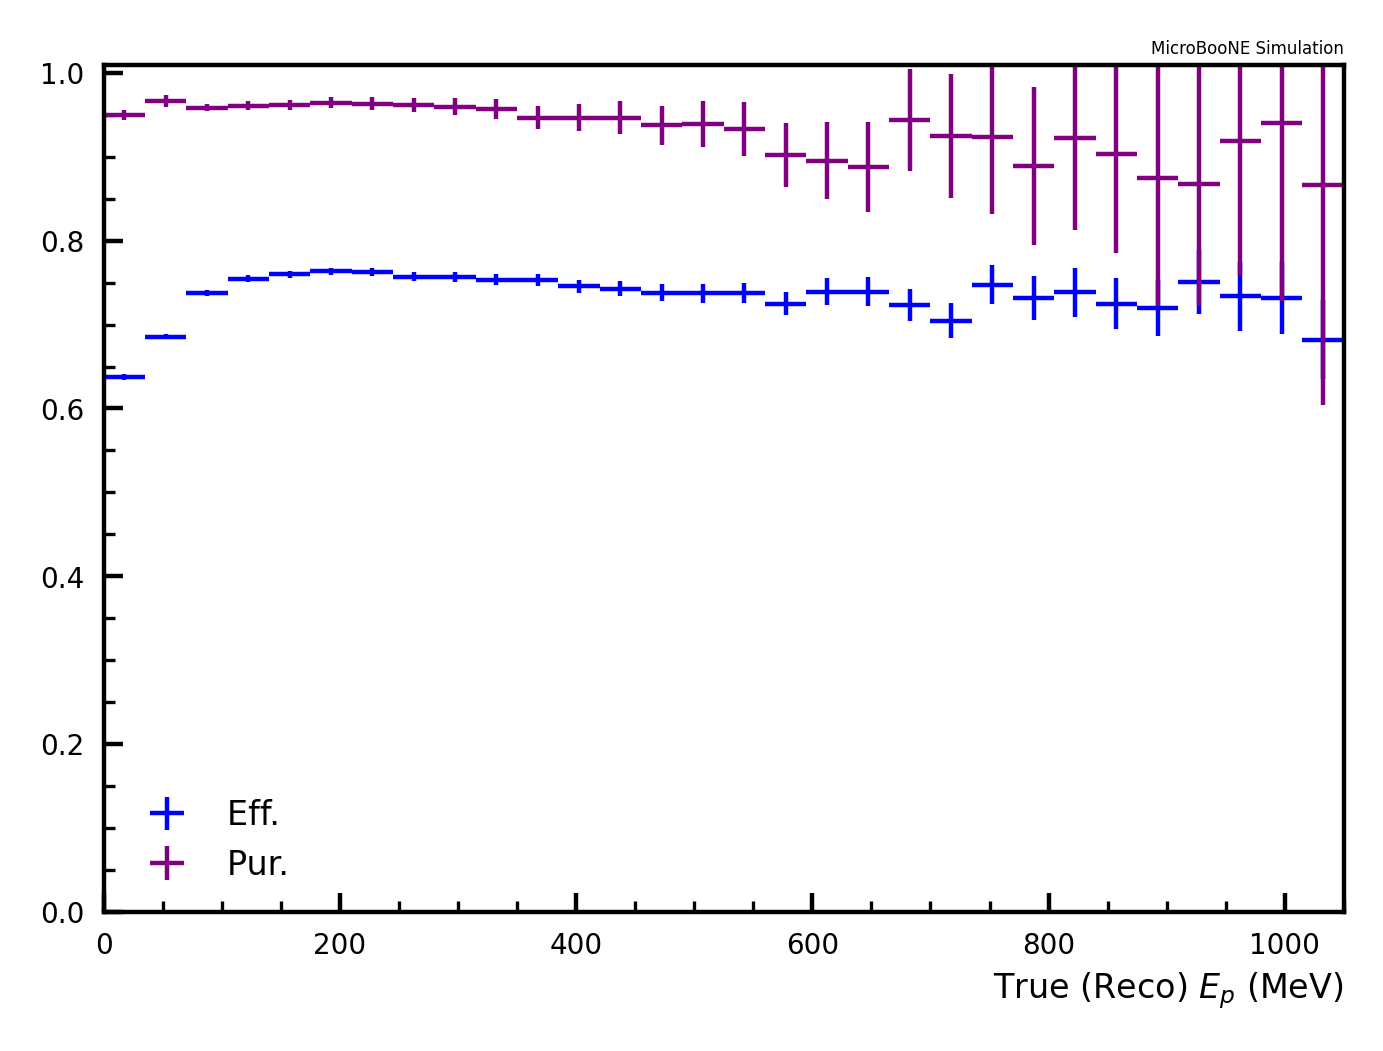

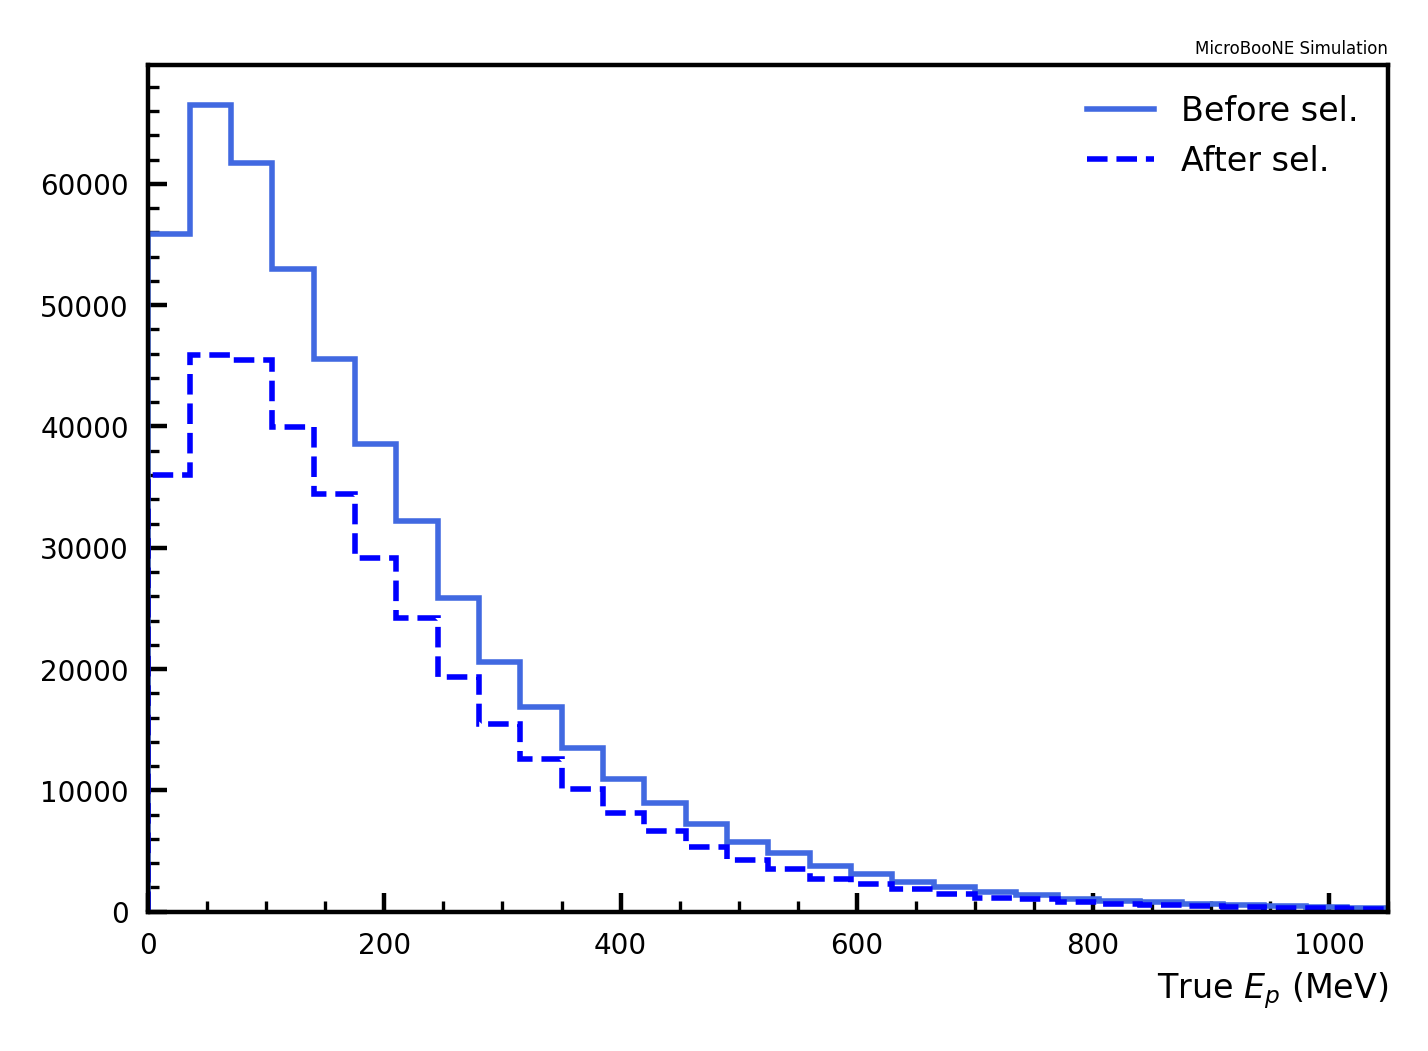

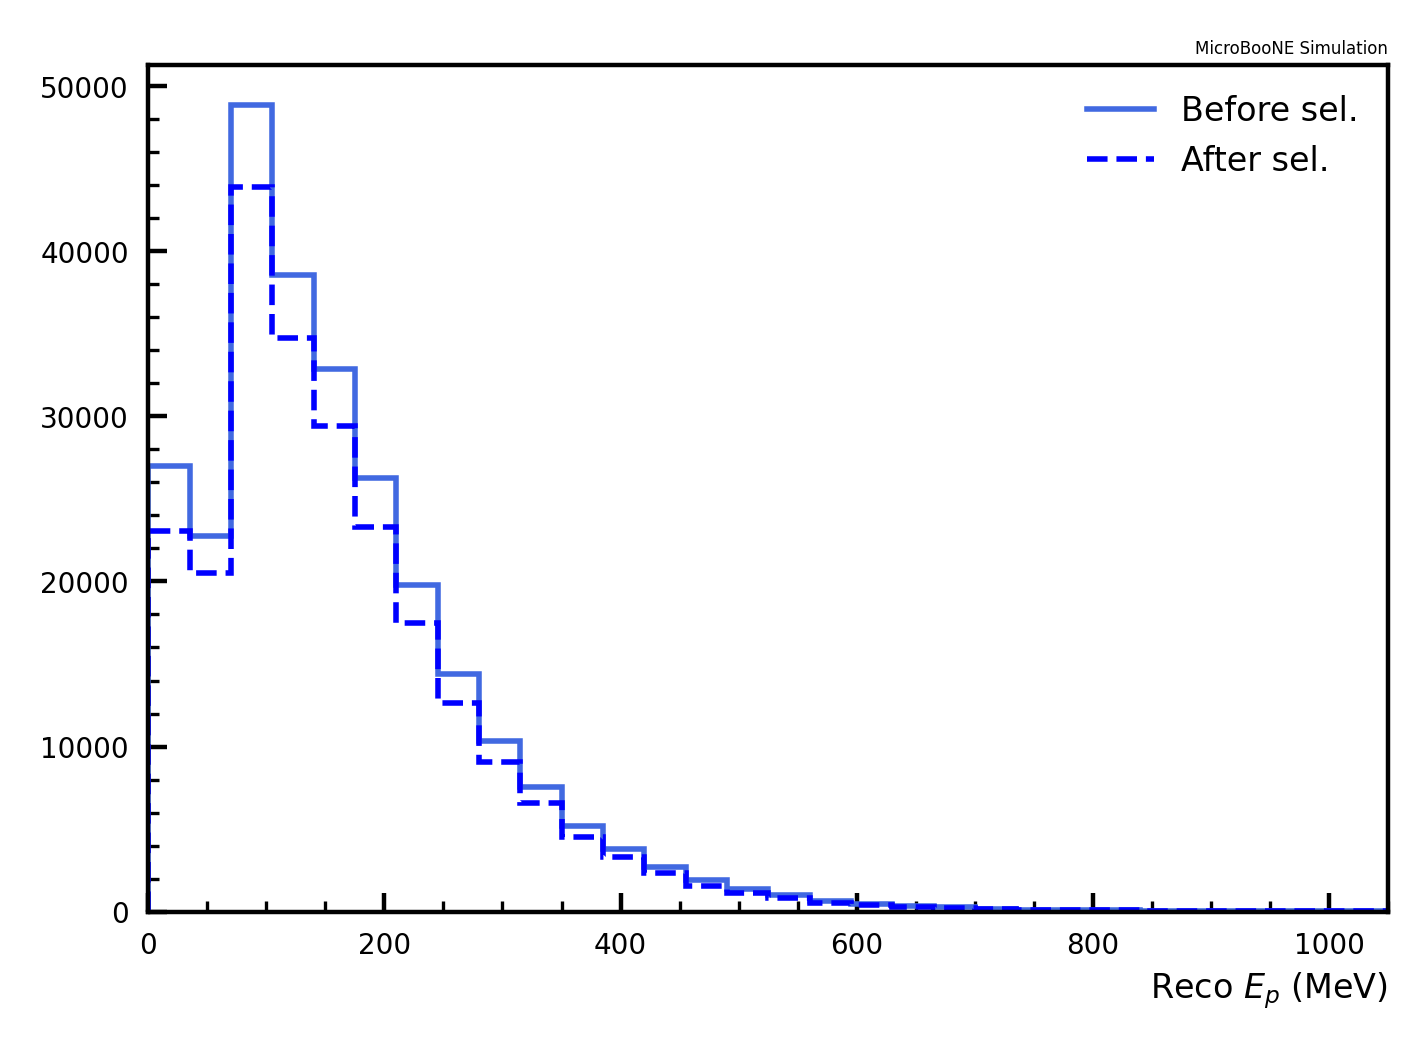

/var/folders/q7/hkz33qhs6bj871s7n1wl4wfw0000gs/T/ipykernel_7331/4291868034.py:230: RuntimeWarning: invalid value encountered in divide
  eff0p = sig_t0p_sel_r0p_tbinned/sig_t0p_tbinned
/var/folders/q7/hkz33qhs6bj871s7n1wl4wfw0000gs/T/ipykernel_7331/4291868034.py:231: RuntimeWarning: invalid value encountered in divide
  eff0p_wrt_numucc = sig_t0p_sel_r0p_tbinned/sig_t0p_sel_tbinned
/var/folders/q7/hkz33qhs6bj871s7n1wl4wfw0000gs/T/ipykernel_7331/4291868034.py:232: RuntimeWarning: invalid value encountered in divide
  pur0p = sig_t0p_sel_r0p_rbinned/sel_r0p_rbinned
/var/folders/q7/hkz33qhs6bj871s7n1wl4wfw0000gs/T/ipykernel_7331/4291868034.py:233: RuntimeWarning: invalid value encountered in divide
  pur0p_wrt_numucc = sig_t0p_sel_r0p_rbinned/sig_sel_r0p_rbinned
/var/folders/q7/hkz33qhs6bj871s7n1wl4wfw0000gs/T/ipykernel_7331/4291868034.py:235: RuntimeWarning: invalid value encountered in divide
  effNp = sig_tNp_sel_rNp_tbinned/sig_tNp_tbinned
/var/folders/q7/hkz33qhs6bj871s7n1wl4wfw0000g

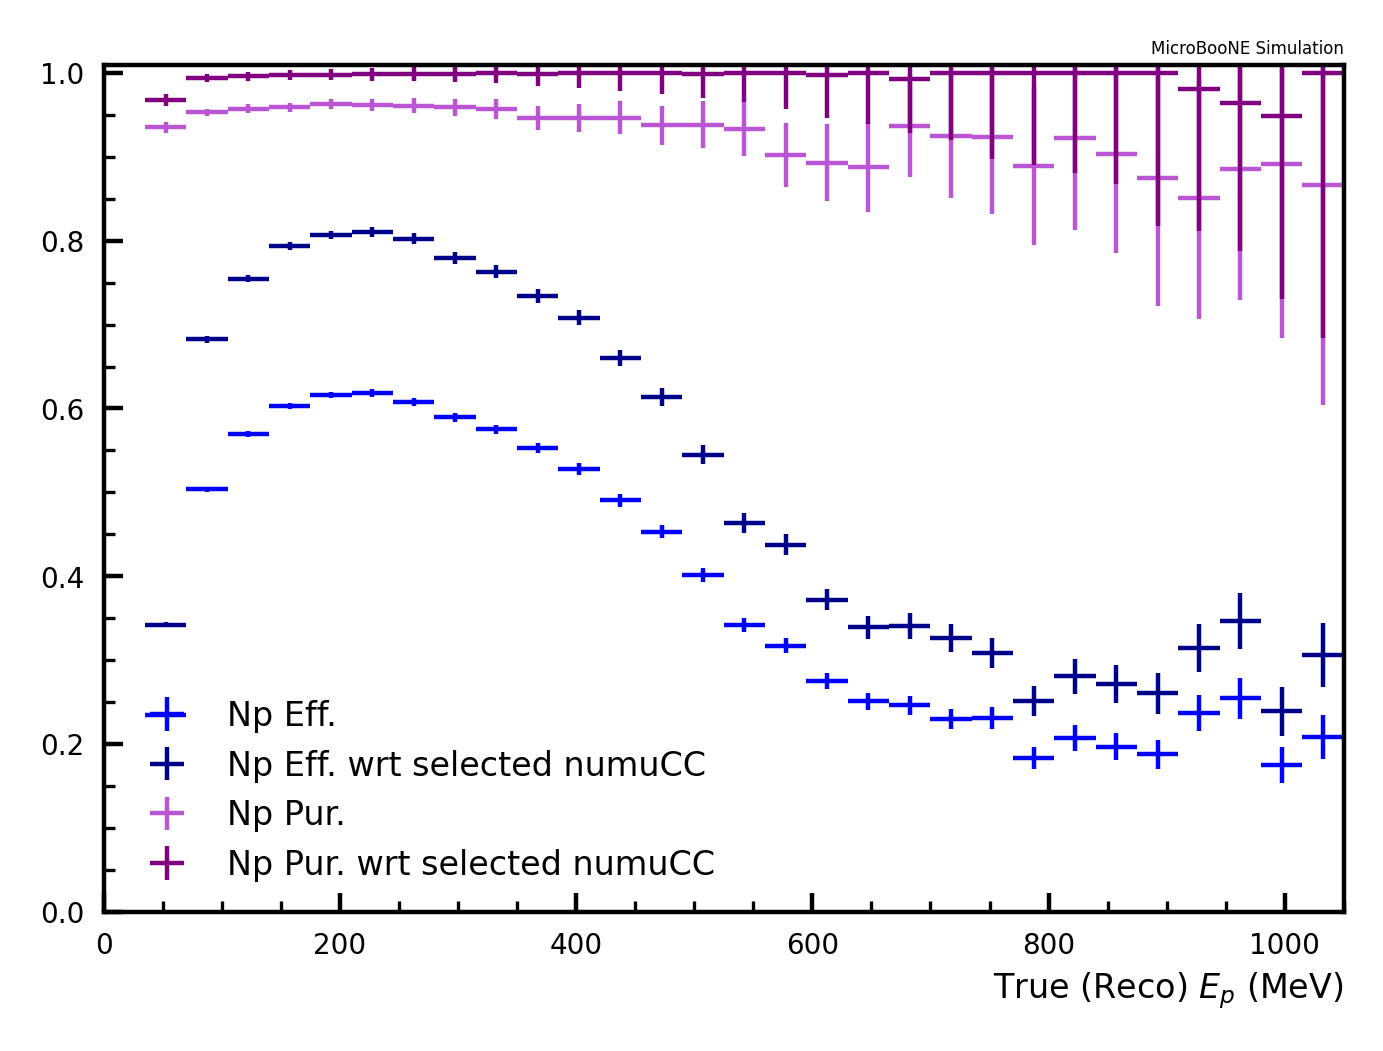

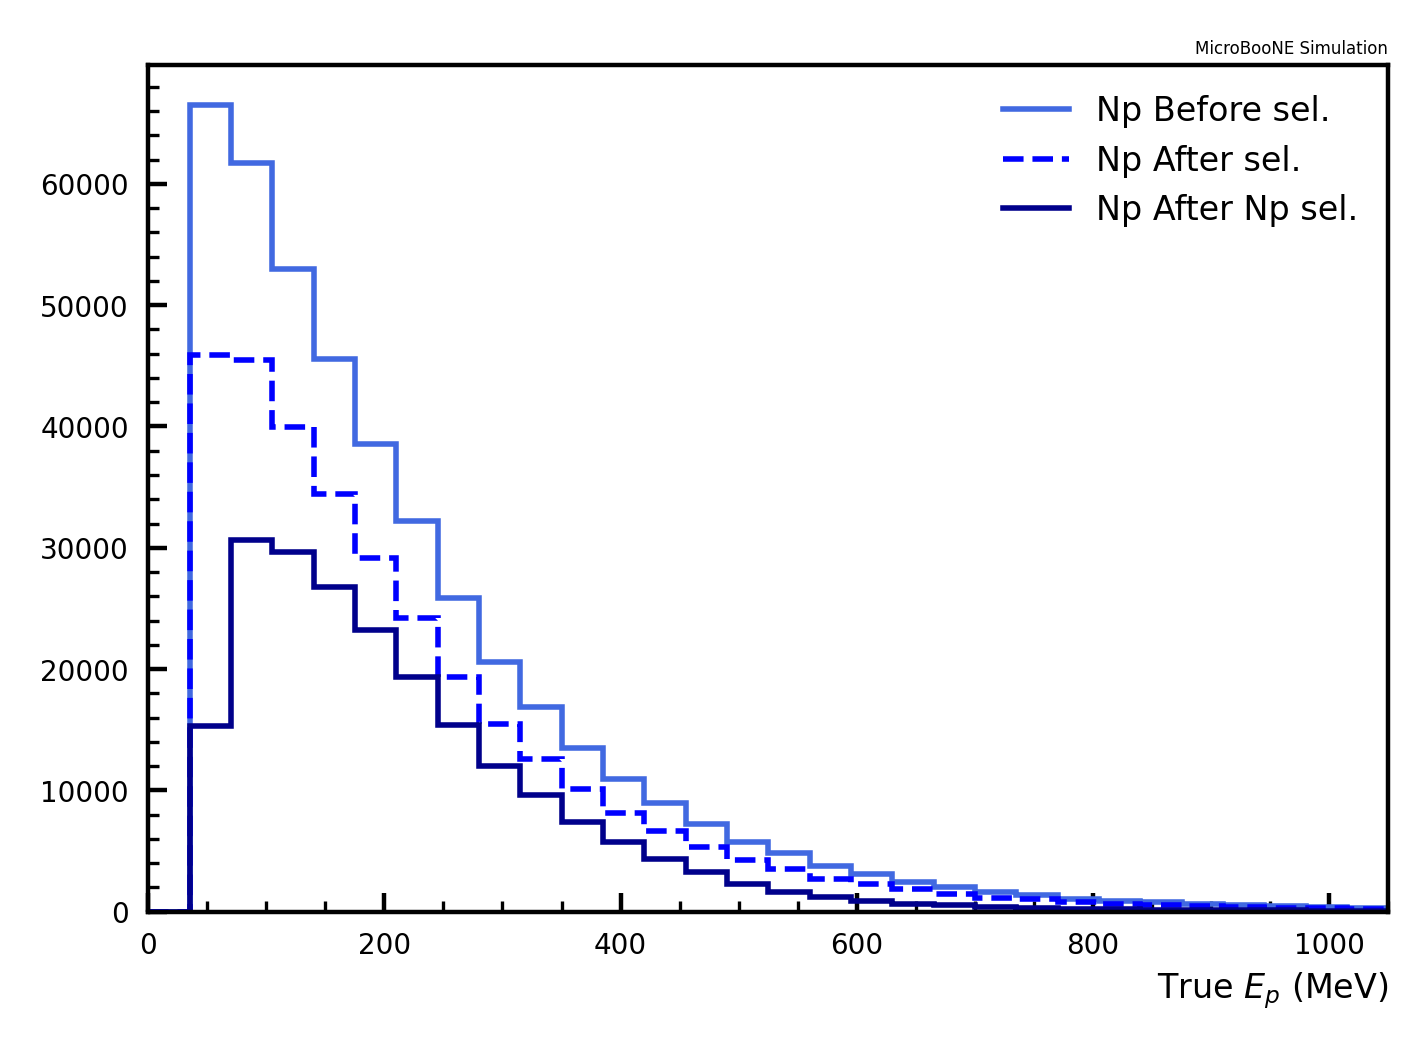

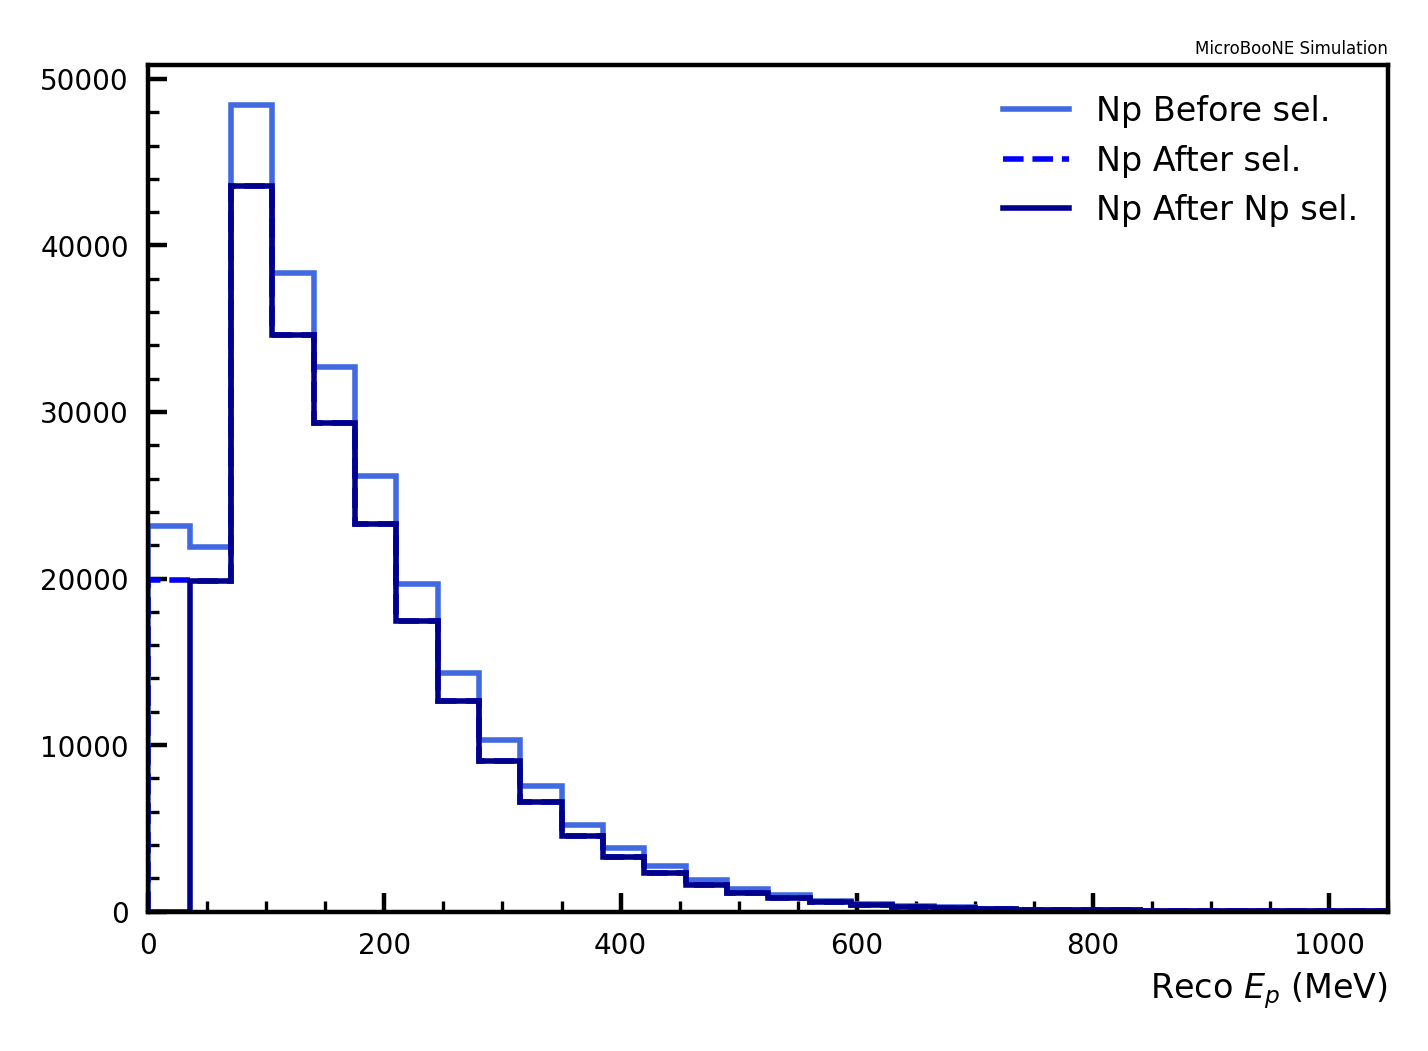

In [39]:
#Example with Xp plotted as function of proton energy
eff_pur_test("truth_prim_p_energy", 0, 1050, 30, "reco_prim_p_energy", 0, 1050, 30, plot_Xp = True ,plot_0pNp = True, weight_var="net_weight_POTscaled")


/var/folders/q7/hkz33qhs6bj871s7n1wl4wfw0000gs/T/ipykernel_7331/4291868034.py:230: RuntimeWarning: invalid value encountered in divide
  eff0p = sig_t0p_sel_r0p_tbinned/sig_t0p_tbinned
/var/folders/q7/hkz33qhs6bj871s7n1wl4wfw0000gs/T/ipykernel_7331/4291868034.py:231: RuntimeWarning: invalid value encountered in divide
  eff0p_wrt_numucc = sig_t0p_sel_r0p_tbinned/sig_t0p_sel_tbinned
/var/folders/q7/hkz33qhs6bj871s7n1wl4wfw0000gs/T/ipykernel_7331/4291868034.py:232: RuntimeWarning: invalid value encountered in divide
  pur0p = sig_t0p_sel_r0p_rbinned/sel_r0p_rbinned
/var/folders/q7/hkz33qhs6bj871s7n1wl4wfw0000gs/T/ipykernel_7331/4291868034.py:233: RuntimeWarning: invalid value encountered in divide
  pur0p_wrt_numucc = sig_t0p_sel_r0p_rbinned/sig_sel_r0p_rbinned
/var/folders/q7/hkz33qhs6bj871s7n1wl4wfw0000gs/T/ipykernel_7331/4291868034.py:257: RuntimeWarning: invalid value encountered in divide
  eff0p_yerr = np.sqrt(sig_t0p_sel_r0p_tbinned_now)/sig_t0p_tbinned_now
/var/folders/q7/hkz33qh

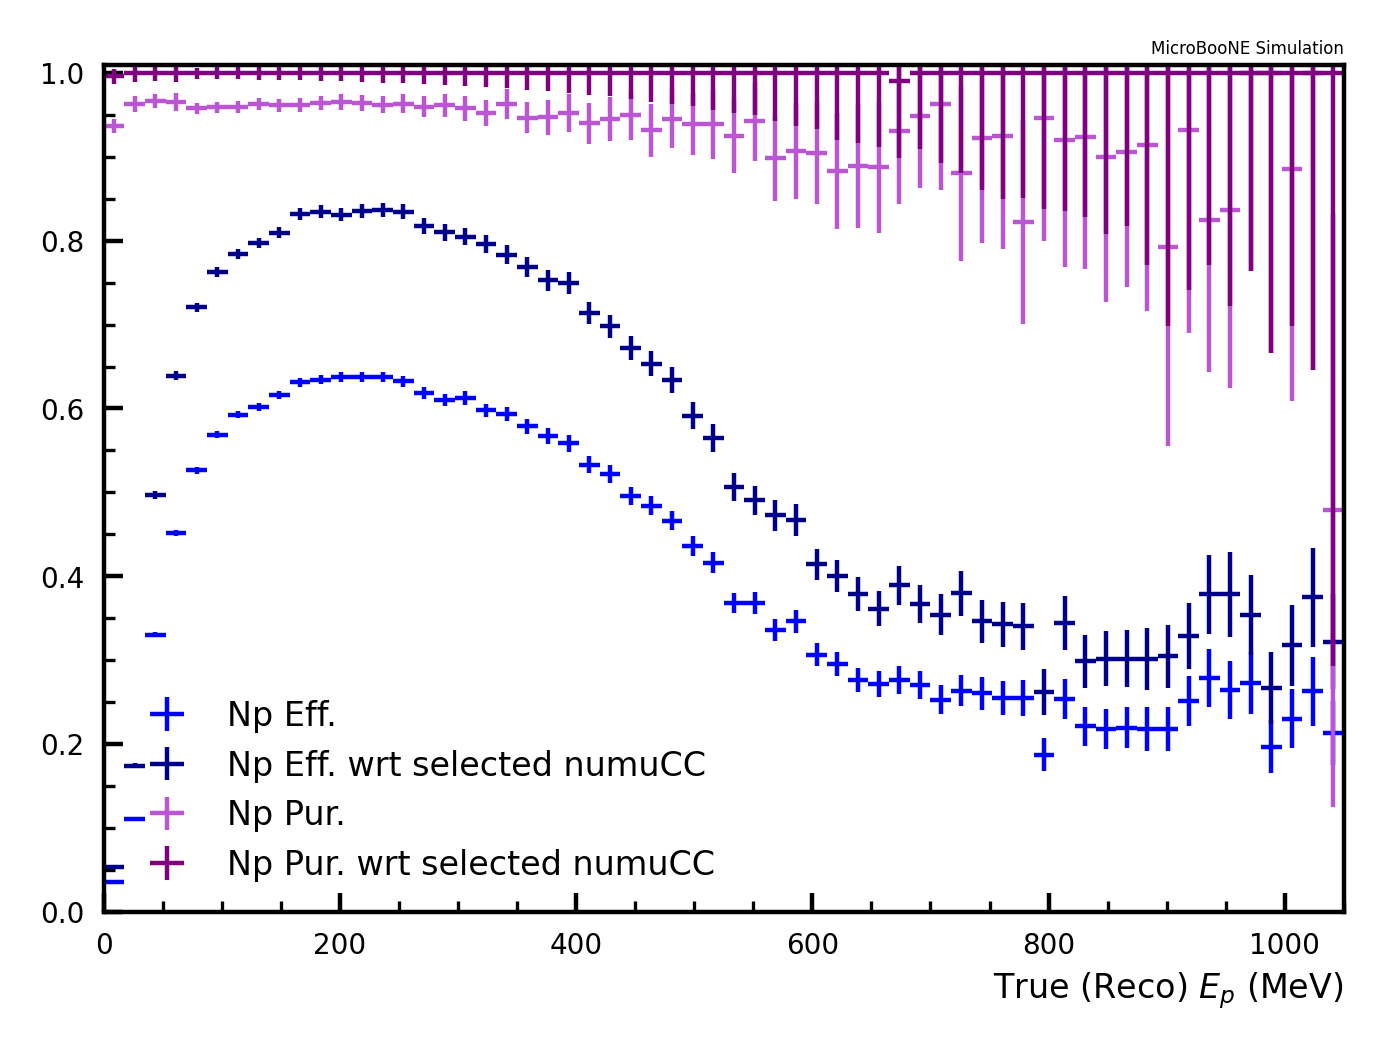

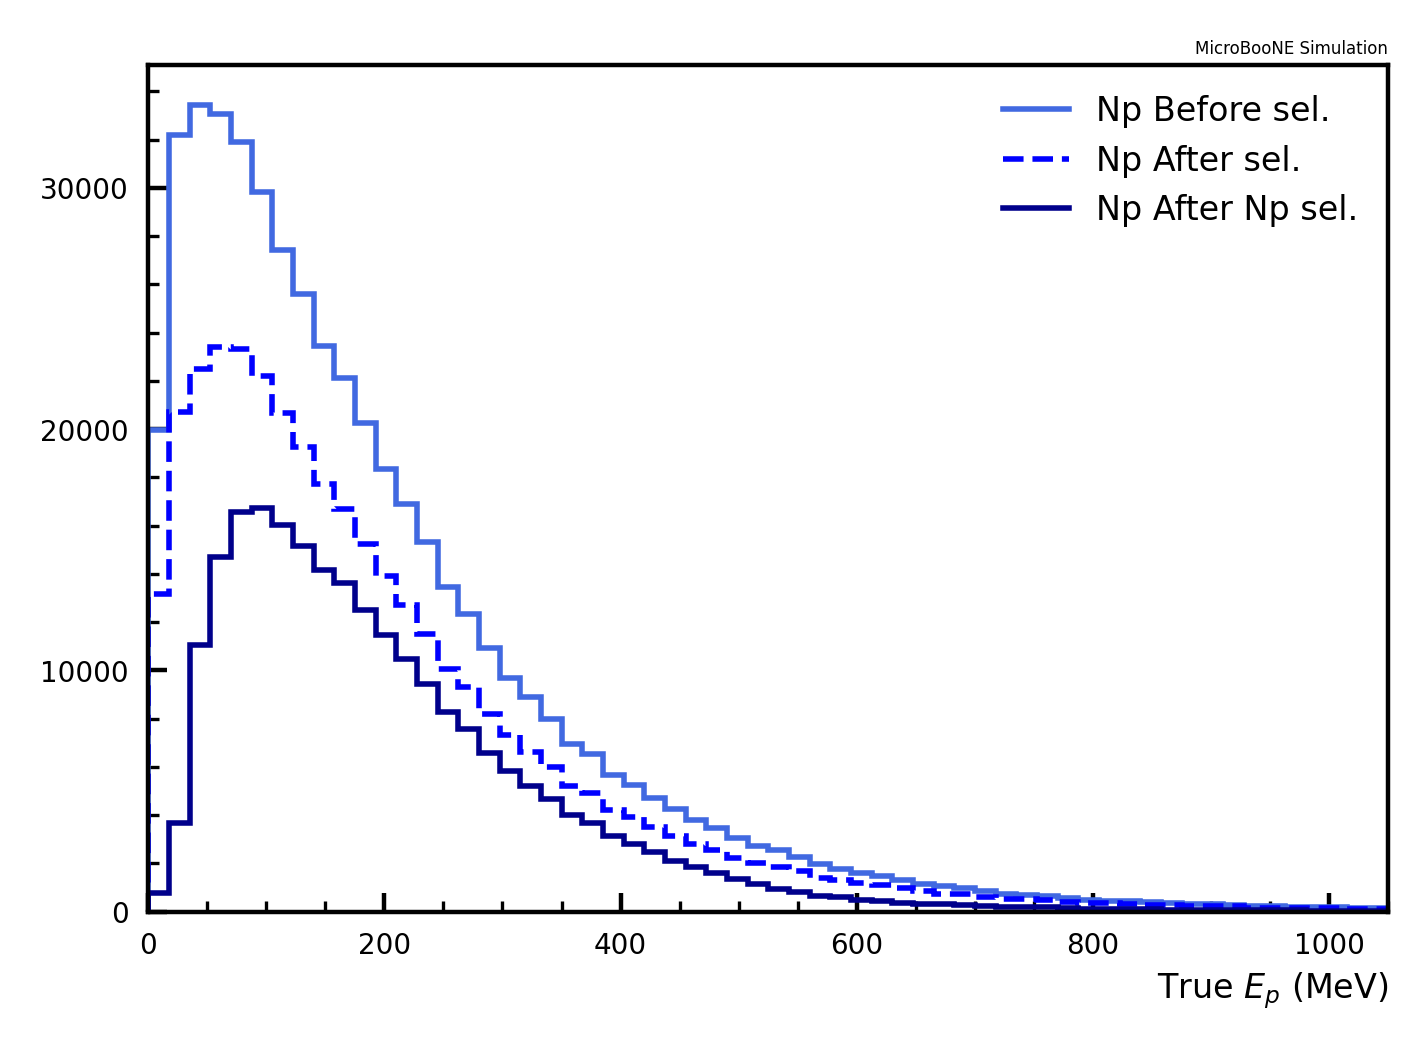

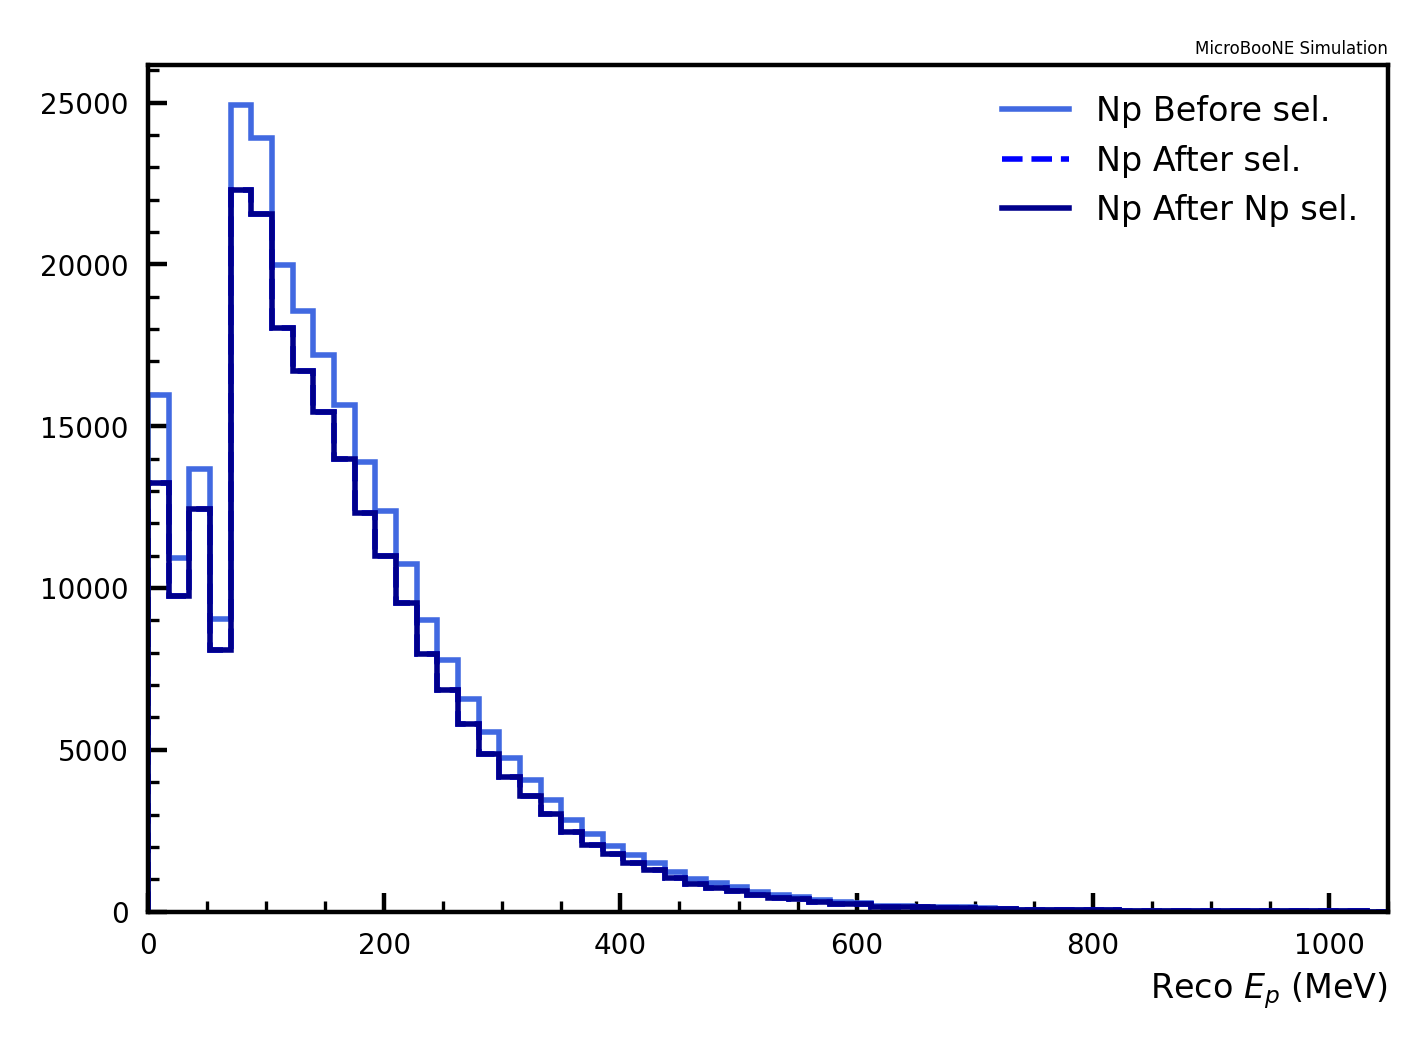

In [48]:
#Example with Np efficencies and purities plotted as function of proton energy, but with no thresholds
true_0p_query = "truth_prim_p_energy<=0"
reco_0p_query = "reco_prim_p_energy<=0"
true_Np_query = "truth_prim_p_energy>0"
reco_Np_query = "reco_prim_p_energy>0"

eff_pur_test("truth_prim_p_energy", 0, 1050, 60, "reco_prim_p_energy", 0, 1050, 60, plot_Xp = False ,plot_0pNp = True, weight_var="net_weight_POTscaled", onlyNp=True,oneplot=True)



/var/folders/q7/hkz33qhs6bj871s7n1wl4wfw0000gs/T/ipykernel_7331/4291868034.py:230: RuntimeWarning: invalid value encountered in divide
  eff0p = sig_t0p_sel_r0p_tbinned/sig_t0p_tbinned
/var/folders/q7/hkz33qhs6bj871s7n1wl4wfw0000gs/T/ipykernel_7331/4291868034.py:231: RuntimeWarning: invalid value encountered in divide
  eff0p_wrt_numucc = sig_t0p_sel_r0p_tbinned/sig_t0p_sel_tbinned
/var/folders/q7/hkz33qhs6bj871s7n1wl4wfw0000gs/T/ipykernel_7331/4291868034.py:232: RuntimeWarning: invalid value encountered in divide
  pur0p = sig_t0p_sel_r0p_rbinned/sel_r0p_rbinned
/var/folders/q7/hkz33qhs6bj871s7n1wl4wfw0000gs/T/ipykernel_7331/4291868034.py:233: RuntimeWarning: invalid value encountered in divide
  pur0p_wrt_numucc = sig_t0p_sel_r0p_rbinned/sig_sel_r0p_rbinned
/var/folders/q7/hkz33qhs6bj871s7n1wl4wfw0000gs/T/ipykernel_7331/4291868034.py:235: RuntimeWarning: invalid value encountered in divide
  effNp = sig_tNp_sel_rNp_tbinned/sig_tNp_tbinned
/var/folders/q7/hkz33qhs6bj871s7n1wl4wfw0000g

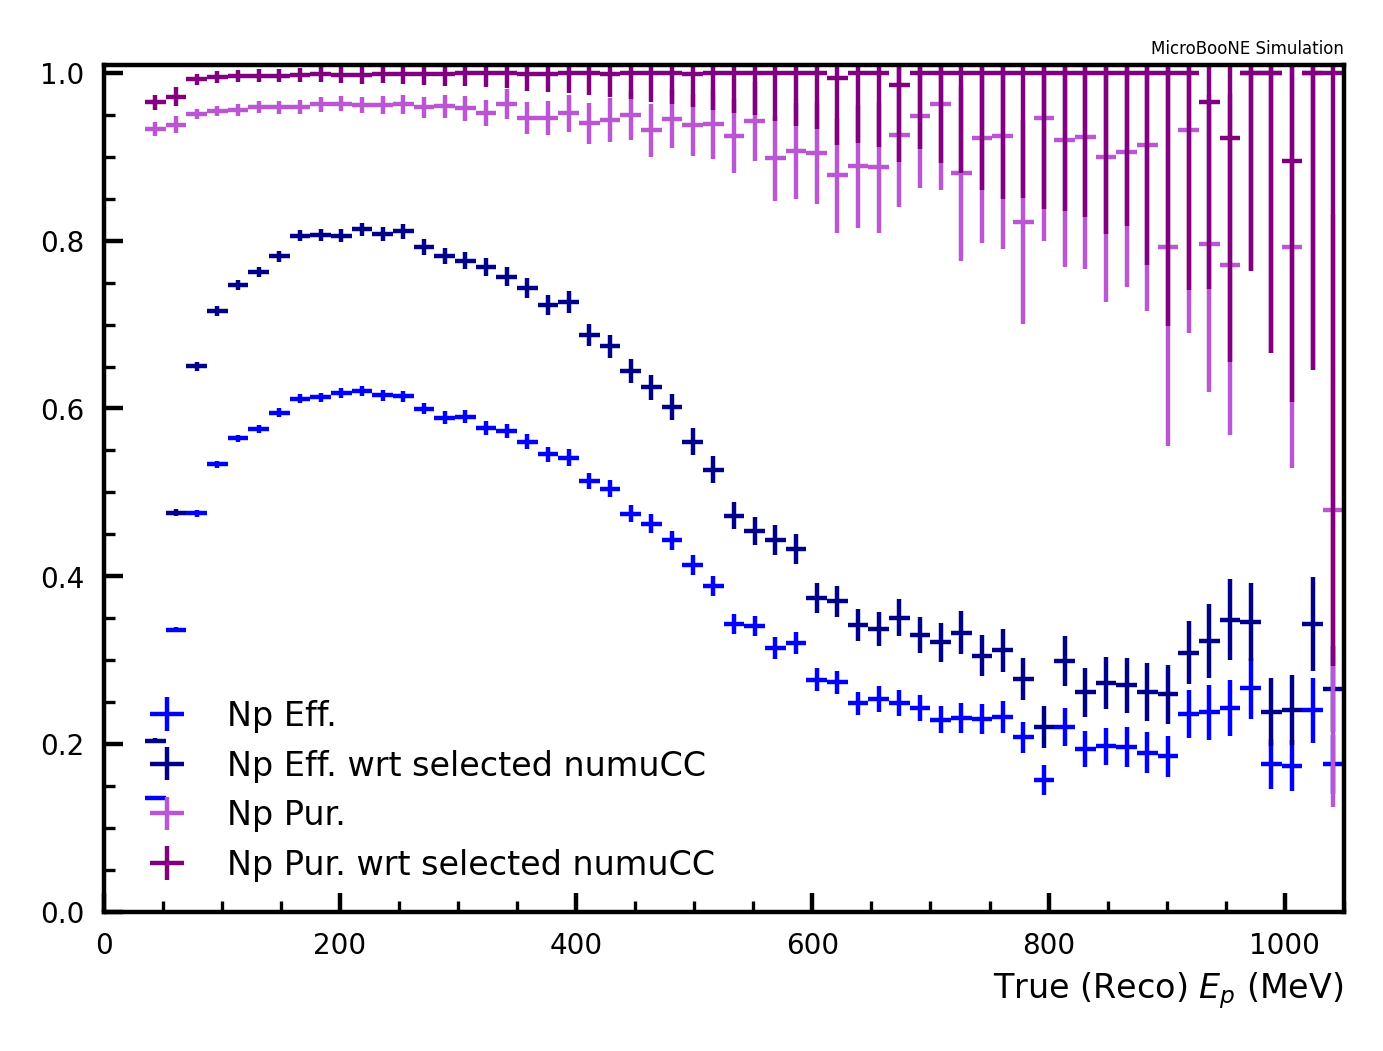

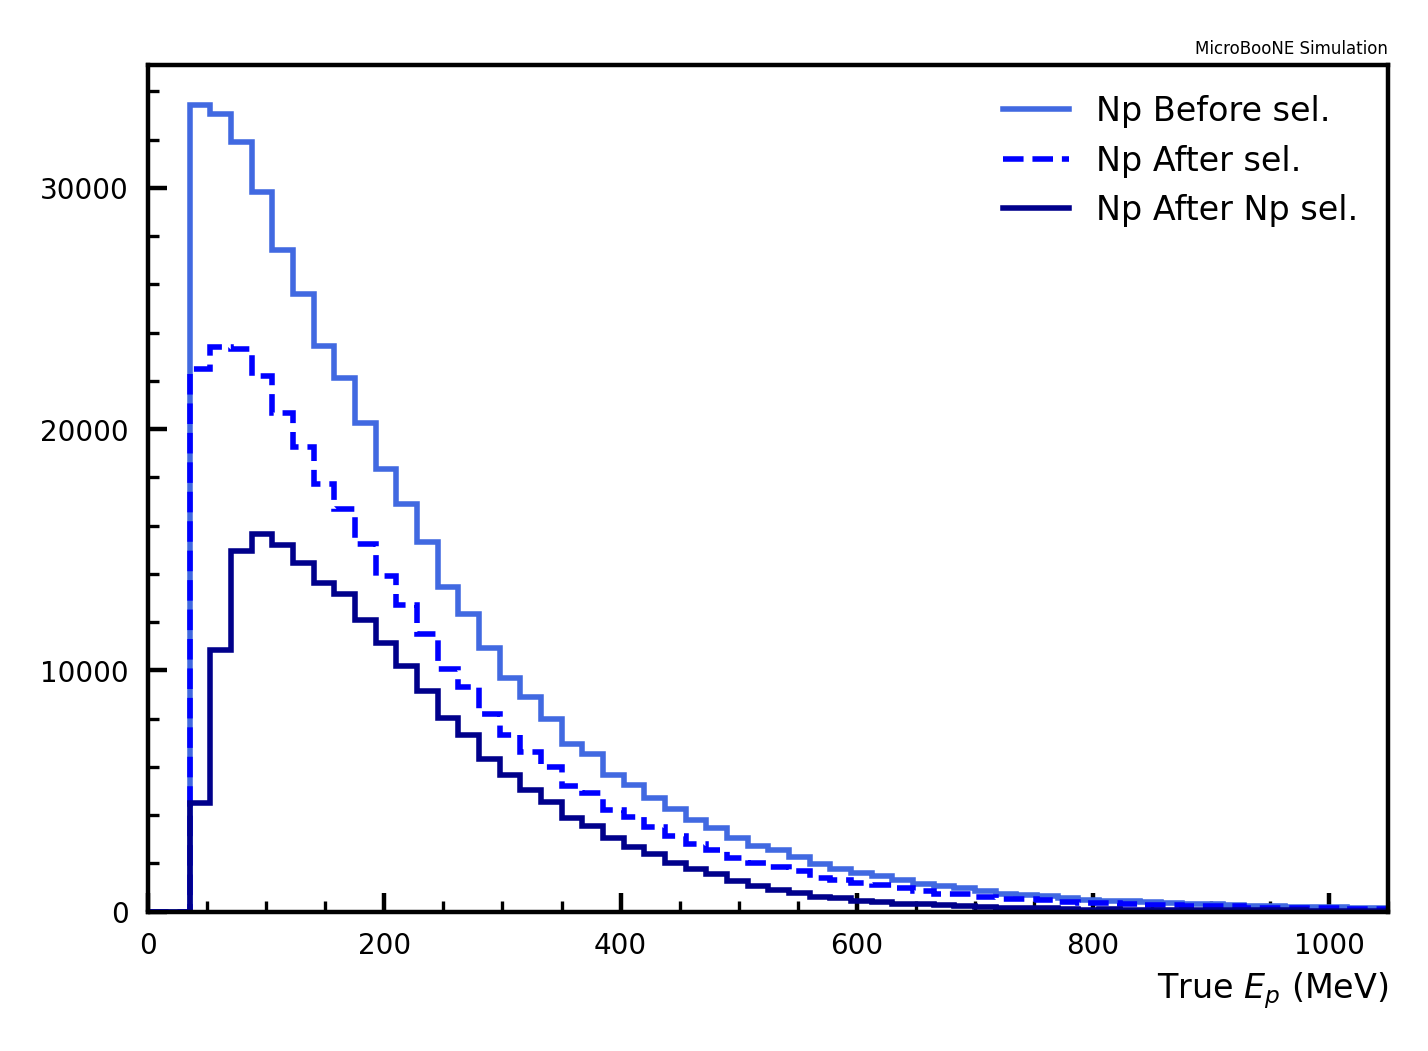

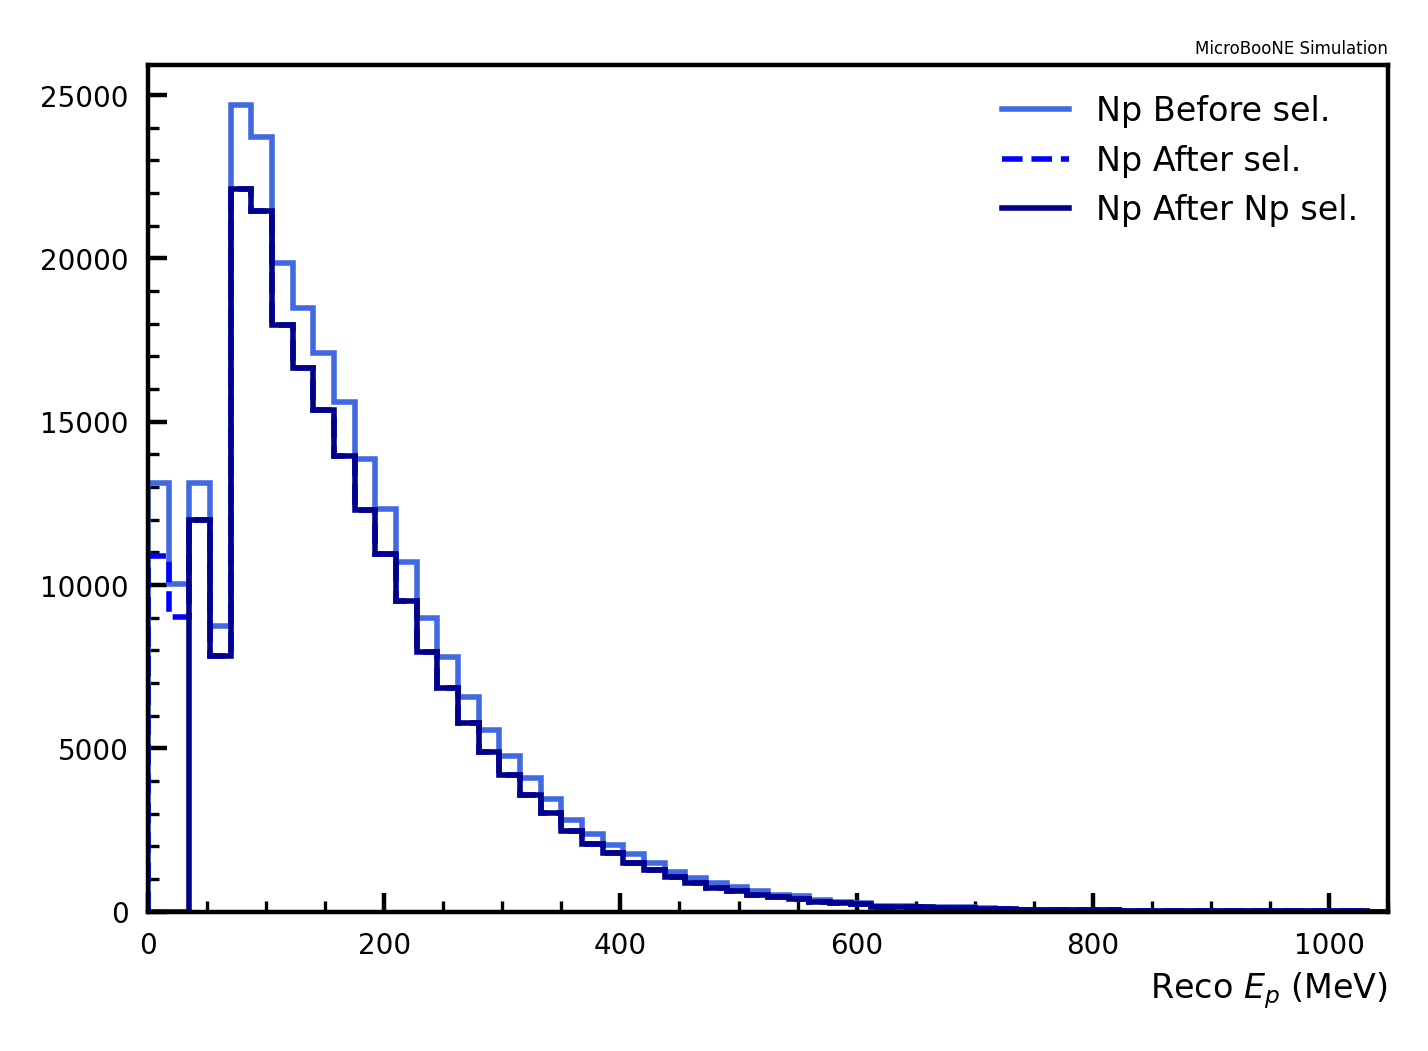

In [46]:
#Example with Np efficencies and purities plotted as function of proton energy, with the normal thresholds
true_0p_query = "truth_prim_p_energy<35"
reco_0p_query = "reco_prim_p_energy<35"
true_Np_query = "truth_prim_p_energy>=35"
reco_Np_query = "reco_prim_p_energy>=35"

eff_pur_test("truth_prim_p_energy", 0, 1050, 60, "reco_prim_p_energy", 0, 1050, 60, plot_Xp = False ,plot_0pNp = True, weight_var="net_weight_POTscaled", onlyNp=True,oneplot=True)


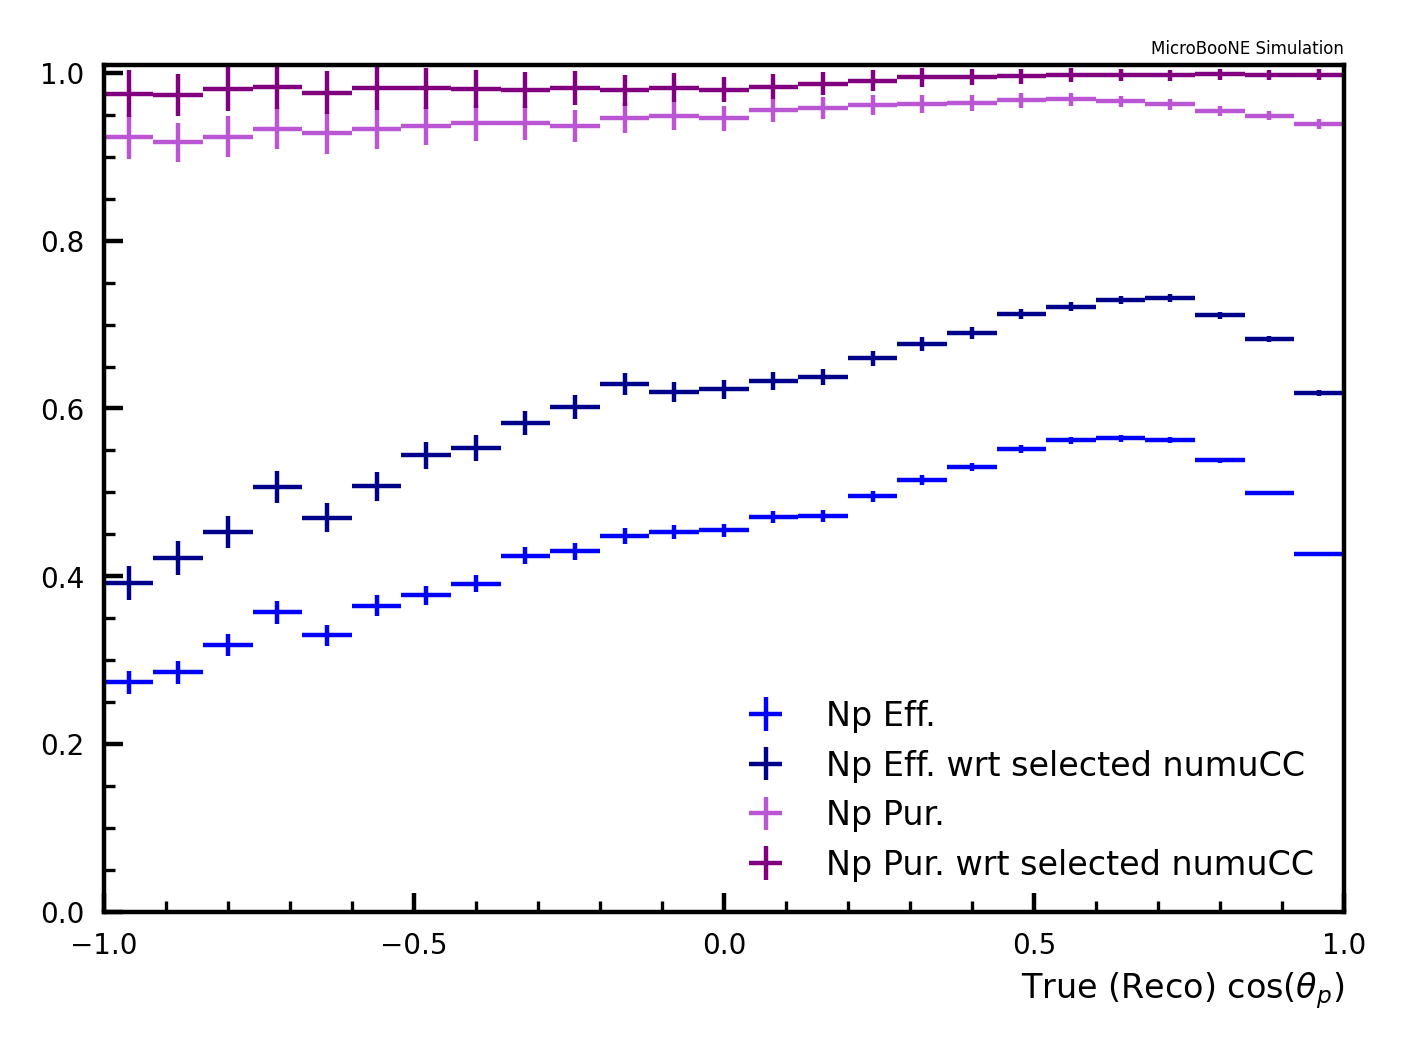

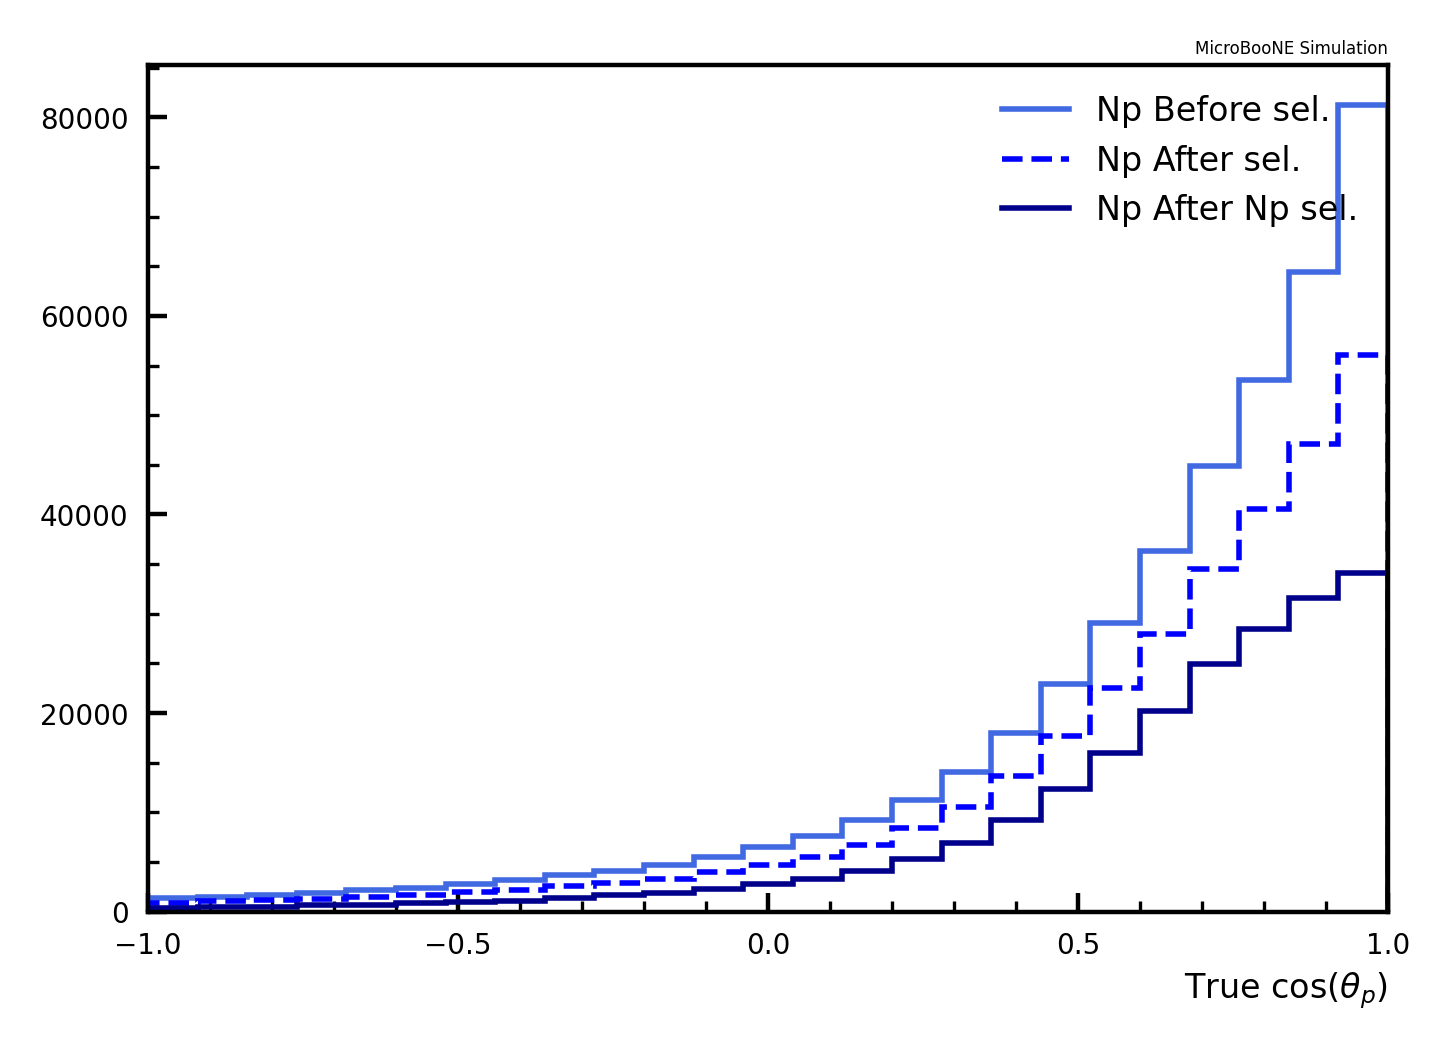

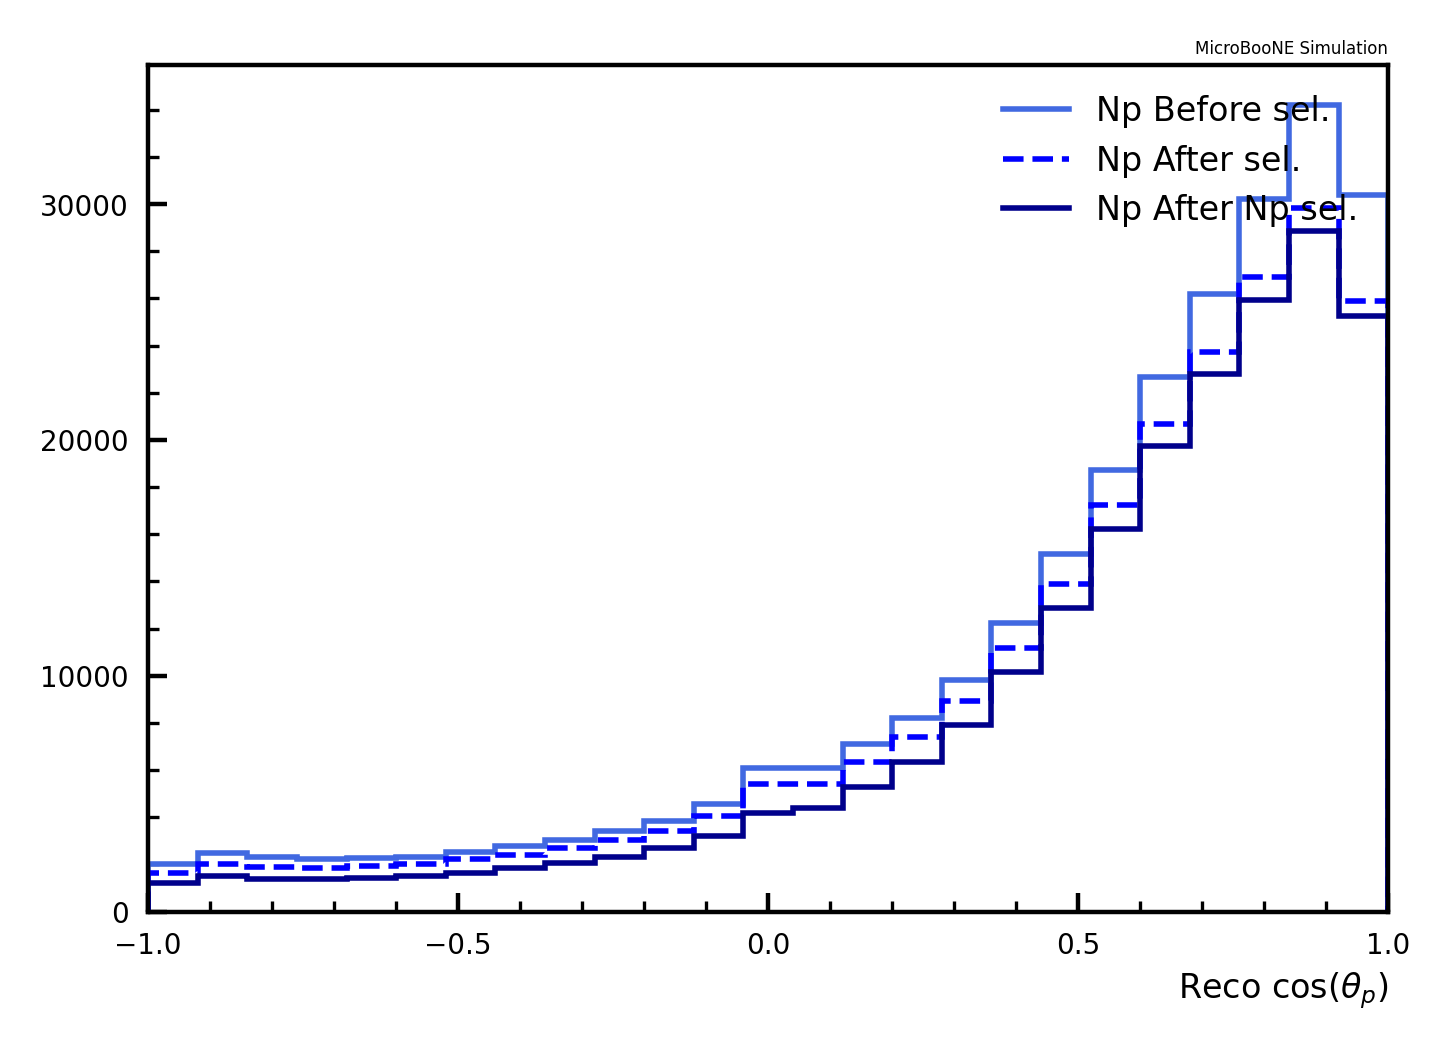

In [40]:
#Example for a different proton variable
eff_pur_test("truth_proton_costheta", -1, 1, 25, "reco_proton_costheta", -1, 1, 25, plot_Xp = False ,plot_0pNp = True, weight_var="net_weight_POTscaled", onlyNp=True, oneplot=True)




## 2D efficency plots
Note to Giacomo: This next part is a bit rough, not really needed but play around with it if you want.

In [30]:
def eff_pur_test2d(truth_var, minv_truth, maxv_truth, nbins_truth, reco_var, minv_reco, maxv_reco, nbins_reco, plot_Xp = True ,plot_0pNp = True, weight_var="net_weight", onlyNp=False, extra_query="", min_counts=10):

    xs_query = weight_var+">0"+extra_query


    sig_t0p_df = all_df.query(sig_query).query(xs_query).query(true_0p_query)
    sig_t0p_w = sig_t0p_df[weight_var].to_numpy()
    sig_t0p_t_var0 = sig_t0p_df[truth_var[0]].to_numpy()
    sig_t0p_r_var0 = sig_t0p_df[reco_var[0]].to_numpy()
    sig_t0p_t_var1 = sig_t0p_df[truth_var[1]].to_numpy()
    sig_t0p_r_var1 = sig_t0p_df[reco_var[1]].to_numpy()

    sig_t0p_sel_df = all_df.query(sig_query).query(sel_query).query(xs_query).query(true_0p_query)
    sig_t0p_sel_w = sig_t0p_sel_df[weight_var].to_numpy()
    sig_t0p_sel_t_var0 = sig_t0p_sel_df[truth_var[0]].to_numpy()
    sig_t0p_sel_r_var0 = sig_t0p_sel_df[reco_var[0]].to_numpy()
    sig_t0p_sel_t_var1 = sig_t0p_sel_df[truth_var[1]].to_numpy()
    sig_t0p_sel_r_var1 = sig_t0p_sel_df[reco_var[1]].to_numpy()
   

    sig_t0p_sel_r0p_df = all_df.query(sig_query).query(sel_query).query(xs_query).query(true_0p_query).query(reco_0p_query)
    sig_t0p_sel_r0p_w = sig_t0p_sel_r0p_df[weight_var].to_numpy()
    sig_t0p_sel_r0p_t_var0 = sig_t0p_sel_r0p_df[truth_var[0]].to_numpy()    
    sig_t0p_sel_r0p_r_var0 = sig_t0p_sel_r0p_df[reco_var[0]].to_numpy()
    sig_t0p_sel_r0p_t_var1 = sig_t0p_sel_r0p_df[truth_var[1]].to_numpy()    
    sig_t0p_sel_r0p_r_var1 = sig_t0p_sel_r0p_df[reco_var[1]].to_numpy()

    sig_sel_r0p_df = all_df.query(sig_query).query(sel_query).query(xs_query).query(reco_0p_query)
    sig_sel_r0p_w = sig_sel_r0p_df[weight_var].to_numpy()
    sig_sel_r0p_t_var0 = sig_sel_r0p_df[truth_var[0]].to_numpy()    
    sig_sel_r0p_r_var0 = sig_sel_r0p_df[reco_var[0]].to_numpy()
    sig_sel_r0p_t_var1 = sig_sel_r0p_df[truth_var[1]].to_numpy()    
    sig_sel_r0p_r_var1 = sig_sel_r0p_df[reco_var[1]].to_numpy()

    sel_r0p_df = all_df.query(sel_query).query(xs_query).query(reco_0p_query)
    sel_r0p_w = sel_r0p_df[weight_var].to_numpy()
    sel_r0p_r_var0 = sel_r0p_df[reco_var[0]].to_numpy()
    sel_r0p_r_var1 = sel_r0p_df[reco_var[1]].to_numpy()


    sig_tNp_df = all_df.query(sig_query).query(xs_query).query(true_Np_query)
    sig_tNp_w = sig_tNp_df[weight_var].to_numpy()
    sig_tNp_t_var0 = sig_tNp_df[truth_var[0]].to_numpy()
    sig_tNp_r_var0 = sig_tNp_df[reco_var[0]].to_numpy()
    sig_tNp_t_var1 = sig_tNp_df[truth_var[1]].to_numpy()
    sig_tNp_r_var1 = sig_tNp_df[reco_var[1]].to_numpy()

    sig_tNp_sel_df = all_df.query(sig_query).query(sel_query).query(xs_query).query(true_Np_query)
    sig_tNp_sel_w = sig_tNp_sel_df[weight_var].to_numpy()
    sig_tNp_sel_t_var0 = sig_tNp_sel_df[truth_var[0]].to_numpy()
    sig_tNp_sel_r_var0 = sig_tNp_sel_df[reco_var[0]].to_numpy()     
    sig_tNp_sel_t_var1 = sig_tNp_sel_df[truth_var[1]].to_numpy()
    sig_tNp_sel_r_var1 = sig_tNp_sel_df[reco_var[1]].to_numpy()
    
    sig_tNp_sel_rNp_df = all_df.query(sig_query).query(sel_query).query(xs_query).query(true_Np_query).query(reco_Np_query)
    sig_tNp_sel_rNp_w = sig_tNp_sel_rNp_df[weight_var].to_numpy()
    sig_tNp_sel_rNp_t_var0 = sig_tNp_sel_rNp_df[truth_var[0]].to_numpy()    
    sig_tNp_sel_rNp_r_var0 = sig_tNp_sel_rNp_df[reco_var[0]].to_numpy()
    sig_tNp_sel_rNp_t_var1 = sig_tNp_sel_rNp_df[truth_var[1]].to_numpy()    
    sig_tNp_sel_rNp_r_var1 = sig_tNp_sel_rNp_df[reco_var[1]].to_numpy()

    sig_sel_rNp_df = all_df.query(sig_query).query(sel_query).query(xs_query).query(reco_Np_query)
    sig_sel_rNp_w = sig_sel_rNp_df[weight_var].to_numpy()
    sig_sel_rNp_t_var0 = sig_sel_rNp_df[truth_var[0]].to_numpy()
    sig_sel_rNp_r_var0 = sig_sel_rNp_df[reco_var[0]].to_numpy()
    sig_sel_rNp_t_var1 = sig_sel_rNp_df[truth_var[1]].to_numpy()
    sig_sel_rNp_r_var1 = sig_sel_rNp_df[reco_var[1]].to_numpy()

    sel_rNp_df = all_df.query(sel_query).query(xs_query).query(reco_Np_query)
    sel_rNp_w = sel_rNp_df[weight_var].to_numpy()
    sel_rNp_r_var0 = sel_rNp_df[reco_var[0]].to_numpy()
    sel_rNp_r_var1 = sel_rNp_df[reco_var[1]].to_numpy()


    sig_df = all_df.query(sig_query).query(xs_query)
    sig_w = sig_df[weight_var].to_numpy()
    sig_t_var0 = sig_df[truth_var[0]].to_numpy()
    sig_r_var0 = sig_df[reco_var[0]].to_numpy()
    sig_t_var1 = sig_df[truth_var[1]].to_numpy()
    sig_r_var1 = sig_df[reco_var[1]].to_numpy()

    sig_sel_df = all_df.query(sig_query).query(sel_query).query(xs_query)
    sig_sel_w = sig_sel_df[weight_var].to_numpy()
    sig_sel_t_var0 = sig_sel_df[truth_var[0]].to_numpy()
    sig_sel_r_var0 = sig_sel_df[reco_var[0]].to_numpy()
    sig_sel_t_var1 = sig_sel_df[truth_var[1]].to_numpy()
    sig_sel_r_var1 = sig_sel_df[reco_var[1]].to_numpy()

    sel_df = all_df.query(sel_query).query(xs_query)  
    sel_w = sel_df[weight_var].to_numpy()
    sel_r_var0 = sel_df[reco_var[0]].to_numpy()
    sel_r_var1 = sel_df[reco_var[1]].to_numpy()


    n_sig = sum(sig_w)
    n_sig_sel = sum(sig_sel_w)
    n_sel = sum(sel_w)

    n_sig_t0p = sum(sig_t0p_w)
    n_sig_t0p_sel = sum(sig_t0p_sel_w)
    n_sig_t0p_sel_r0p = sum(sig_t0p_sel_r0p_w)
    n_sig_sel_r0p = sum(sig_sel_r0p_w)
    n_sel_r0p = sum(sel_r0p_w)

    n_sig_tNp = sum(sig_tNp_w)
    n_sig_tNp_sel = sum(sig_tNp_sel_w)
    n_sig_tNp_sel_rNp = sum(sig_tNp_sel_rNp_w)
    n_sig_sel_rNp = sum(sig_sel_rNp_w)
    n_sel_rNp = sum(sel_rNp_w)


    bins_truth0 = np.linspace(minv_truth[0], maxv_truth[0], num=nbins_truth[0]+1)
    bins_0p_truth0 = bins_truth0
    bins_Np_truth0 = bins_truth0
    
    bins_reco0 = np.linspace(minv_reco[0], maxv_reco[0], num=nbins_reco[0]+1)
    bins_0p_reco0 = bins_reco0
    bins_Np_reco0 = bins_reco0
    
    bins_truth1 = np.linspace(minv_truth[1], maxv_truth[1], num=nbins_truth[1]+1)
    bins_0p_truth1 = bins_truth1
    bins_Np_truth1 = bins_truth1
    
    bins_reco1 = np.linspace(minv_reco[1], maxv_reco[1], num=nbins_reco[1]+1)
    bins_0p_reco1 = bins_reco1
    bins_Np_reco1 = bins_reco1

    
    if plot_Xp: print("Xp case not coded yet")
        
    if plot_0pNp: 

        sig_t0p_sel_r0p_tbinned, bins_, bins2_ = np.histogram2d(sig_t0p_sel_r0p_t_var0, sig_t0p_sel_r0p_t_var1, bins=(bins_0p_truth0,bins_0p_truth1), range=((minv_truth[0], maxv_truth[0]),(minv_truth[1], maxv_truth[1])), weights=sig_t0p_sel_r0p_w)
        sig_t0p_tbinned, bins_, bins2_ = np.histogram2d(sig_t0p_t_var0, sig_t0p_t_var1, bins=(bins_0p_truth0,bins_0p_truth1), range=((minv_truth[0], maxv_truth[0]),(minv_truth[1], maxv_truth[1])), weights=sig_t0p_w)
        sig_t0p_sel_tbinned, bins_, bins2_ = np.histogram2d(sig_t0p_sel_t_var0, sig_t0p_sel_t_var1, bins=(bins_0p_truth0,bins_0p_truth1), range=((minv_truth[0], maxv_truth[0]),(minv_truth[1], maxv_truth[1])), weights=sig_t0p_sel_w)
        
        sig_t0p_sel_r0p_rbinned, bins_, bins2_ = np.histogram2d(sig_t0p_sel_r0p_r_var0, sig_t0p_sel_r0p_r_var1, bins=(bins_0p_reco0,bins_0p_reco1), range=((minv_reco[0], maxv_reco[0]),(minv_reco[1], maxv_reco[1])), weights=sig_t0p_sel_r0p_w)
        sel_r0p_rbinned, bins_, bins2_ = np.histogram2d(sel_r0p_r_var0, sel_r0p_r_var1, bins=(bins_0p_reco0,bins_0p_reco1), range=((minv_reco[0], maxv_reco[0]),(minv_reco[1], maxv_reco[1])), weights=sel_r0p_w)
        sig_sel_r0p_rbinned, bins_, bins2_ = np.histogram2d(sig_sel_r0p_r_var0, sig_sel_r0p_r_var1, bins=(bins_0p_reco0,bins_0p_reco1), range=((minv_reco[0], maxv_reco[0]),(minv_reco[1], maxv_reco[1])), weights=sig_sel_r0p_w)
        
        sig_tNp_sel_rNp_tbinned, bins_, bins2_ = np.histogram2d(sig_tNp_sel_rNp_t_var0, sig_tNp_sel_rNp_t_var1, bins=(bins_Np_truth0,bins_Np_truth1), range=((minv_truth[0], maxv_truth[0]),(minv_truth[1], maxv_truth[1])), weights=sig_tNp_sel_rNp_w)
        sig_tNp_tbinned, bins_, bins2_ = np.histogram2d(sig_tNp_t_var0, sig_tNp_t_var1, bins=(bins_Np_truth0,bins_Np_truth1), range=((minv_truth[0], maxv_truth[0]),(minv_truth[1], maxv_truth[1])), weights=sig_tNp_w)
        sig_tNp_sel_tbinned, bins_, bins2_ = np.histogram2d(sig_tNp_sel_t_var0, sig_tNp_sel_t_var1, bins=(bins_Np_truth0,bins_Np_truth1), range=((minv_truth[0], maxv_truth[0]),(minv_truth[1], maxv_truth[1])), weights=sig_tNp_sel_w)
        
        sig_tNp_sel_rNp_rbinned, bins_, bins2_ = np.histogram2d(sig_tNp_sel_rNp_r_var0, sig_tNp_sel_rNp_r_var1, bins=(bins_Np_reco0,bins_Np_reco1), range=((minv_reco[0], maxv_reco[0]),(minv_reco[1], maxv_reco[1])), weights=sig_tNp_sel_rNp_w)
        sel_rNp_rbinned, bins_, bins2_ = np.histogram2d(sel_rNp_r_var0, sel_rNp_r_var1, bins=(bins_Np_reco0,bins_Np_reco1), range=((minv_reco[0], maxv_reco[0]),(minv_reco[1], maxv_reco[1])), weights=sel_rNp_w)
        sig_sel_rNp_rbinned, bins_, bins2_ = np.histogram2d(sig_sel_rNp_r_var0, sig_sel_rNp_r_var1, bins=(bins_Np_reco0,bins_Np_reco1), range=((minv_reco[0], maxv_reco[0]),(minv_reco[1], maxv_reco[1])), weights=sig_sel_rNp_w)
 
    
    
        eff0p = sig_t0p_sel_r0p_tbinned/sig_t0p_tbinned
        eff0p_wrt_numucc = sig_t0p_sel_r0p_tbinned/sig_t0p_sel_tbinned
        pur0p = sig_t0p_sel_r0p_rbinned/sel_r0p_rbinned
        pur0p_wrt_numucc = sig_t0p_sel_r0p_rbinned/sig_sel_r0p_rbinned
        
        effNp = sig_tNp_sel_rNp_tbinned/sig_tNp_tbinned
        effNp_wrt_numucc = sig_tNp_sel_rNp_tbinned/sig_tNp_sel_tbinned
        purNp = sig_tNp_sel_rNp_rbinned/sel_rNp_rbinned
        purNp_wrt_numucc = sig_tNp_sel_rNp_rbinned/sig_sel_rNp_rbinned
        
        eff0p_yerr = np.sqrt(sig_t0p_sel_r0p_tbinned)/sig_tNp_tbinned
        eff0p_wrt_numucc_yerr = np.sqrt(sig_t0p_sel_r0p_tbinned)/sig_t0p_sel_tbinned
        pur0p_yerr = np.sqrt(sig_t0p_sel_r0p_rbinned)/sel_r0p_rbinned
        pur0p_wrt_numucc_yerr = np.sqrt(sig_t0p_sel_r0p_rbinned)/sig_sel_r0p_rbinned
        
        effNp_yerr = np.sqrt(sig_tNp_sel_rNp_tbinned)/sig_tNp_tbinned
        effNp_wrt_numucc_yerr = np.sqrt(sig_tNp_sel_rNp_tbinned)/sig_tNp_sel_tbinned
        purNp_yerr = np.sqrt(sig_tNp_sel_rNp_rbinned)/sel_rNp_rbinned
        purNp_wrt_numucc_yerr = np.sqrt(sig_tNp_sel_rNp_rbinned)/sig_sel_rNp_rbinned
        
        sig_t0p_sel_r0p_tbinned_now, bins_, bins2_ = np.histogram2d(sig_t0p_sel_r0p_t_var0, sig_t0p_sel_r0p_t_var1, bins=(bins_0p_truth0,bins_0p_truth1), range=((minv_truth[0], maxv_truth[0]),(minv_truth[1], maxv_truth[1])), weights=sig_t0p_sel_r0p_w)
        sig_t0p_tbinned_now, bins_, bins2_ = np.histogram2d(sig_t0p_t_var0, sig_t0p_t_var1, bins=(bins_0p_truth0,bins_0p_truth1), range=((minv_truth[0], maxv_truth[0]),(minv_truth[1], maxv_truth[1])), weights=sig_t0p_w)
        sig_t0p_sel_tbinned_now, bins_, bins2_ = np.histogram2d(sig_t0p_sel_t_var0, sig_t0p_sel_t_var1, bins=(bins_0p_truth0,bins_0p_truth1), range=((minv_truth[0], maxv_truth[0]),(minv_truth[1], maxv_truth[1])), weights=sig_t0p_sel_w)
        
        sig_t0p_sel_r0p_rbinned_now, bins_, bins2_ = np.histogram2d(sig_t0p_sel_r0p_r_var0, sig_t0p_sel_r0p_r_var1, bins=(bins_0p_reco0,bins_0p_reco1), range=((minv_reco[0], maxv_reco[0]),(minv_reco[1], maxv_reco[1])), weights=sig_t0p_sel_r0p_w)
        sel_r0p_rbinned_now, bins_, bins2_ = np.histogram2d(sel_r0p_r_var0, sel_r0p_r_var1, bins=(bins_0p_reco0,bins_0p_reco1), range=((minv_reco[0], maxv_reco[0]),(minv_reco[1], maxv_reco[1])), weights=sel_r0p_w)
        sig_sel_r0p_rbinned_now, bins_, bins2_ = np.histogram2d(sig_sel_r0p_r_var0, sig_sel_r0p_r_var1, bins=(bins_0p_reco0,bins_0p_reco1), range=((minv_reco[0], maxv_reco[0]),(minv_reco[1], maxv_reco[1])), weights=sig_sel_r0p_w)
        
        sig_tNp_sel_rNp_tbinned_now, bins_, bins2_ = np.histogram2d(sig_tNp_sel_rNp_t_var0, sig_tNp_sel_rNp_t_var1, bins=(bins_Np_truth0,bins_Np_truth1), range=((minv_truth[0], maxv_truth[0]),(minv_truth[1], maxv_truth[1])), weights=sig_tNp_sel_rNp_w)
        sig_tNp_tbinned_now, bins_, bins2_ = np.histogram2d(sig_tNp_t_var0, sig_tNp_t_var1, bins=(bins_Np_truth0,bins_Np_truth1), range=((minv_truth[0], maxv_truth[0]),(minv_truth[1], maxv_truth[1])), weights=sig_tNp_w)
        sig_tNp_sel_tbinned_now, bins_, bins2_ = np.histogram2d(sig_tNp_sel_t_var0, sig_tNp_sel_t_var1, bins=(bins_Np_truth0,bins_Np_truth1), range=((minv_truth[0], maxv_truth[0]),(minv_truth[1], maxv_truth[1])), weights=sig_tNp_sel_w)
        
        sig_tNp_sel_rNp_rbinned_now, bins_, bins2_ = np.histogram2d(sig_tNp_sel_rNp_r_var0, sig_tNp_sel_rNp_r_var1, bins=(bins_Np_reco0,bins_Np_reco1), range=((minv_reco[0], maxv_reco[0]),(minv_reco[1], maxv_reco[1])), weights=sig_tNp_sel_rNp_w)
        sel_rNp_rbinned_now, bins_, bins2_ = np.histogram2d(sel_rNp_r_var0, sel_rNp_r_var1, bins=(bins_Np_reco0,bins_Np_reco1), range=((minv_reco[0], maxv_reco[0]),(minv_reco[1], maxv_reco[1])), weights=sel_rNp_w)
        sig_sel_rNp_rbinned_now, bins_, bins2_ = np.histogram2d(sig_sel_rNp_r_var0, sig_sel_rNp_r_var1, bins=(bins_Np_reco0,bins_Np_reco1), range=((minv_reco[0], maxv_reco[0]),(minv_reco[1], maxv_reco[1])), weights=sig_sel_rNp_w)
        
        eff0p_yerr = np.sqrt(sig_t0p_sel_r0p_tbinned_now)/sig_t0p_tbinned_now
        eff0p_wrt_numucc_yerr = np.sqrt(sig_t0p_sel_r0p_tbinned_now)/sig_t0p_sel_tbinned_now
        pur0p_yerr = np.sqrt(sig_t0p_sel_r0p_rbinned_now)/sel_r0p_rbinned_now
        pur0p_wrt_numucc_yerr = np.sqrt(sig_t0p_sel_r0p_rbinned_now)/sig_sel_r0p_rbinned_now

        effNp_yerr = np.sqrt(sig_tNp_sel_rNp_tbinned_now)/sig_tNp_tbinned_now
        effNp_wrt_numucc_yerr = np.sqrt(sig_tNp_sel_rNp_tbinned_now)/sig_tNp_sel_tbinned_now
        purNp_yerr = np.sqrt(sig_tNp_sel_rNp_rbinned_now)/sel_rNp_rbinned_now
        purNp_wrt_numucc_yerr = np.sqrt(sig_tNp_sel_rNp_rbinned_now)/sig_sel_rNp_rbinned_now
        
        

        eff0pA = trim_effpur(eff0p, sig_t0p_sel_r0p_tbinned_now ,min_counts)
        eff0pA_wrt_numucc = trim_effpur(eff0p_wrt_numucc, sig_t0p_sel_r0p_tbinned_now ,min_counts)
        effNpA = trim_effpur(effNp, sig_tNp_sel_rNp_tbinned_now ,min_counts)
        effNpA_wrt_numucc = trim_effpur(effNp_wrt_numucc, sig_tNp_sel_rNp_tbinned_now ,min_counts)
        pur0pA = trim_effpur(pur0p, sig_t0p_sel_r0p_rbinned_now ,min_counts)
        pur0pA_wrt_numucc = trim_effpur(pur0p_wrt_numucc, sig_t0p_sel_r0p_rbinned_now ,min_counts)
        purNpA = trim_effpur(purNp, sig_tNp_sel_rNp_rbinned_now ,min_counts)
        purNpA_wrt_numucc = trim_effpur(purNp_wrt_numucc, sig_tNp_sel_rNp_rbinned_now ,min_counts)


        plt.figure(figsize=(4,2.75),dpi=400)
        c = plt.pcolormesh(bins_0p_truth0, bins_0p_truth1, eff0pA.T ,vmin=0, vmax=1)
        cbar = plt.colorbar(c, pad=0.025)
        cbar.ax.tick_params(labelsize=5,direction='in',pad=1)
        plt.title("0p Efficency", fontsize=6, pad=2)
        plt.text(minv_truth[0]*0.99,maxv_truth[1]*0.99, "MicroBooNE Simulation",fontsize=3, ha='left', va='top')
        plt.minorticks_on()
        plt.tick_params(which='minor',direction='in')
        plt.tick_params(axis="x", direction="in")
        plt.tick_params(axis="y", direction="in")
        plt.xticks(fontsize=5)
        plt.yticks(fontsize=5)
        if truth_var[0] == "truth_transfer_energy": plt.xlabel(r"True $\nu$ (MeV)",fontsize=6, labelpad=2, loc="right")
        elif truth_var[0] == "truth_nuEnergy": plt.xlabel(r"True $E_{\nu}$ (MeV)",fontsize=6, labelpad=2, loc="right")
        elif truth_var[0] == "truth_Emuon": plt.xlabel(r"True $E_{\mu}$ (MeV)",fontsize=6, labelpad=2, loc="right")
        elif truth_var[0] == "truth_muon_costheta": plt.xlabel(r"True cos($\theta_\mu$)",fontsize=6, labelpad=2, loc="right")
        elif truth_var[0] == "truth_prim_p_energy": plt.xlabel(r"True $E_{p}$ (MeV)",fontsize=6, labelpad=2, loc="right")
        elif truth_var[0] == "truth_proton_costheta": plt.xlabel(r"True cos($\theta_p$)",fontsize=6, labelpad=2, loc="right")
        elif truth_var[0] == "truth_Eavail": plt.xlabel(r"True $E_{avail}$ (MeV)",fontsize=6, labelpad=2, loc="right")
        else: plt.xlabel(f"{truth_var[0]}")
        if truth_var[1] == "truth_transfer_energy": plt.ylabel(r"True $\nu$ (MeV)",fontsize=6, labelpad=2, loc="top")
        elif truth_var[1] == "truth_nuEnergy": plt.ylabel(r"True $E_{\nu}$ (MeV)",fontsize=6, labelpad=2, loc="top")
        elif truth_var[1] == "truth_Emuon": plt.ylabel(r"True $E_{\mu}$ (MeV)",fontsize=6, labelpad=2, loc="top")
        elif truth_var[1] == "truth_muon_costheta": plt.ylabel(r"True cos($\theta_\mu$)",fontsize=6, labelpad=2, loc="top")
        elif truth_var[1] == "truth_prim_p_energy": plt.ylabel(r"True $E_{p}$ (MeV)",fontsize=6, labelpad=2, loc="top")
        elif truth_var[1] == "truth_proton_costheta": plt.ylabel(r"True cos($\theta_p$)",fontsize=6, labelpad=2, loc="top")
        elif truth_var[1] == "truth_Eavail": plt.ylabel(r"True $E_{avail}$ (MeV)",fontsize=6, labelpad=2, loc="top")
        else: plt.ylabel(f"{truth_var[1]}")
        plt.show()

        plt.figure(figsize=(4,2.75),dpi=400)
        c = plt.pcolormesh(bins_0p_truth0, bins_0p_truth1, eff0pA_wrt_numucc.T ,vmin=0, vmax=1)
        cbar = plt.colorbar(c, pad=0.025)
        cbar.ax.tick_params(labelsize=5,direction='in',pad=1)
        plt.title("0p Efficency wrt. numuCC", fontsize=6, pad=2)
        plt.text(minv_truth[0]*0.99,maxv_truth[1]*0.99, "MicroBooNE Simulation",fontsize=3, ha='left', va='top')
        plt.minorticks_on()
        plt.tick_params(which='minor',direction='in')
        plt.tick_params(axis="x", direction="in")
        plt.tick_params(axis="y", direction="in")
        plt.xticks(fontsize=5)
        plt.yticks(fontsize=5)
        if truth_var[0] == "truth_transfer_energy": plt.xlabel(r"True $\nu$ (MeV)",fontsize=6, labelpad=2, loc="right")
        elif truth_var[0] == "truth_nuEnergy": plt.xlabel(r"True $E_{\nu}$ (MeV)",fontsize=6, labelpad=2, loc="right")
        elif truth_var[0] == "truth_Emuon": plt.xlabel(r"True $E_{\mu}$ (MeV)",fontsize=6, labelpad=2, loc="right")
        elif truth_var[0] == "truth_muon_costheta": plt.xlabel(r"True cos($\theta_\mu$)",fontsize=6, labelpad=2, loc="right")
        elif truth_var[0] == "truth_prim_p_energy": plt.xlabel(r"True $E_{p}$ (MeV)",fontsize=6, labelpad=2, loc="right")
        elif truth_var[0] == "truth_proton_costheta": plt.xlabel(r"True cos($\theta_p$)",fontsize=6, labelpad=2, loc="right")
        elif truth_var[0] == "truth_Eavail": plt.xlabel(r"True $E_{avail}$ (MeV)",fontsize=6, labelpad=2, loc="right")
        else: plt.xlabel(f"{truth_var[0]}")
        if truth_var[1] == "truth_transfer_energy": plt.ylabel(r"True $\nu$ (MeV)",fontsize=6, labelpad=2, loc="top")
        elif truth_var[1] == "truth_nuEnergy": plt.ylabel(r"True $E_{\nu}$ (MeV)",fontsize=6, labelpad=2, loc="top")
        elif truth_var[1] == "truth_Emuon": plt.ylabel(r"True $E_{\mu}$ (MeV)",fontsize=6, labelpad=2, loc="top")
        elif truth_var[1] == "truth_muon_costheta": plt.ylabel(r"True cos($\theta_\mu$)",fontsize=6, labelpad=2, loc="top")
        elif truth_var[1] == "truth_prim_p_energy": plt.ylabel(r"True $E_{p}$ (MeV)",fontsize=6, labelpad=2, loc="top")
        elif truth_var[1] == "truth_proton_costheta": plt.ylabel(r"True cos($\theta_p$)",fontsize=6, labelpad=2, loc="top")
        elif truth_var[1] == "truth_Eavail": plt.ylabel(r"True $E_{avail}$ (MeV)",fontsize=6, labelpad=2, loc="top")
        else: plt.ylabel(f"{truth_var[1]}")
        plt.show()

        plt.figure(figsize=(4,2.75),dpi=400)
        c = plt.pcolormesh(bins_Np_truth0, bins_Np_truth1, effNpA.T ,vmin=0, vmax=1)
        cbar = plt.colorbar(c, pad=0.025)
        cbar.ax.tick_params(labelsize=5,direction='in',pad=1)
        plt.title("Np Efficency", fontsize=6, pad=2)
        plt.text(minv_truth[0]*0.99,maxv_truth[1]*0.99, "MicroBooNE Simulation",fontsize=3, ha='left', va='top')
        plt.minorticks_on()
        plt.tick_params(which='minor',direction='in')
        plt.tick_params(axis="x", direction="in")
        plt.tick_params(axis="y", direction="in")
        plt.xticks(fontsize=5)
        plt.yticks(fontsize=5)
        if truth_var[0] == "truth_transfer_energy": plt.xlabel(r"True $\nu$ (MeV)",fontsize=6, labelpad=2, loc="right")
        elif truth_var[0] == "truth_nuEnergy": plt.xlabel(r"True $E_{\nu}$ (MeV)",fontsize=6, labelpad=2, loc="right")
        elif truth_var[0] == "truth_Emuon": plt.xlabel(r"True $E_{\mu}$ (MeV)",fontsize=6, labelpad=2, loc="right")
        elif truth_var[0] == "truth_muon_costheta": plt.xlabel(r"True cos($\theta_\mu$)",fontsize=6, labelpad=2, loc="right")
        elif truth_var[0] == "truth_prim_p_energy": plt.xlabel(r"True $E_{p}$ (MeV)",fontsize=6, labelpad=2, loc="right")
        elif truth_var[0] == "truth_proton_costheta": plt.xlabel(r"True cos($\theta_p$)",fontsize=6, labelpad=2, loc="right")
        elif truth_var[0] == "truth_Eavail": plt.xlabel(r"True $E_{avail}$ (MeV)",fontsize=6, labelpad=2, loc="right")
        else: plt.xlabel(f"{truth_var[0]}")
        if truth_var[1] == "truth_transfer_energy": plt.ylabel(r"True $\nu$ (MeV)",fontsize=6, labelpad=2, loc="top")
        elif truth_var[1] == "truth_nuEnergy": plt.ylabel(r"True $E_{\nu}$ (MeV)",fontsize=6, labelpad=2, loc="top")
        elif truth_var[1] == "truth_Emuon": plt.ylabel(r"True $E_{\mu}$ (MeV)",fontsize=6, labelpad=2, loc="top")
        elif truth_var[1] == "truth_muon_costheta": plt.ylabel(r"True cos($\theta_\mu$)",fontsize=6, labelpad=2, loc="top")
        elif truth_var[1] == "truth_prim_p_energy": plt.ylabel(r"True $E_{p}$ (MeV)",fontsize=6, labelpad=2, loc="top")
        elif truth_var[1] == "truth_proton_costheta": plt.ylabel(r"True cos($\theta_p$)",fontsize=6, labelpad=2, loc="top")
        elif truth_var[1] == "truth_Eavail": plt.ylabel(r"True $E_{avail}$ (MeV)",fontsize=6, labelpad=2, loc="top")
        else: plt.ylabel(f"{truth_var[1]}")
        plt.show()

        plt.figure(figsize=(4,2.75),dpi=400)
        c = plt.pcolormesh(bins_Np_truth0, bins_Np_truth1, effNpA_wrt_numucc.T ,vmin=0, vmax=1)
        cbar = plt.colorbar(c, pad=0.025)
        cbar.ax.tick_params(labelsize=5,direction='in',pad=1)
        plt.title("Np Efficency wrt. numuCC", fontsize=6, pad=2)
        plt.text(minv_truth[0]*0.99,maxv_truth[1]*0.99, "MicroBooNE Simulation",fontsize=3, ha='left', va='top')
        plt.minorticks_on()
        plt.tick_params(which='minor',direction='in')
        plt.tick_params(axis="x", direction="in")
        plt.tick_params(axis="y", direction="in")
        plt.xticks(fontsize=5)
        plt.yticks(fontsize=5)
        if truth_var[0] == "truth_transfer_energy": plt.xlabel(r"True $\nu$ (MeV)",fontsize=6, labelpad=2, loc="right")
        elif truth_var[0] == "truth_nuEnergy": plt.xlabel(r"True $E_{\nu}$ (MeV)",fontsize=6, labelpad=2, loc="right")
        elif truth_var[0] == "truth_Emuon": plt.xlabel(r"True $E_{\mu}$ (MeV)",fontsize=6, labelpad=2, loc="right")
        elif truth_var[0] == "truth_muon_costheta": plt.xlabel(r"True cos($\theta_\mu$)",fontsize=6, labelpad=2, loc="right")
        elif truth_var[0] == "truth_prim_p_energy": plt.xlabel(r"True $E_{p}$ (MeV)",fontsize=6, labelpad=2, loc="right")
        elif truth_var[0] == "truth_proton_costheta": plt.xlabel(r"True cos($\theta_p$)",fontsize=6, labelpad=2, loc="right")
        elif truth_var[0] == "truth_Eavail": plt.xlabel(r"True $E_{avail}$ (MeV)",fontsize=6, labelpad=2, loc="right")
        else: plt.xlabel(f"{truth_var[0]}")
        if truth_var[1] == "truth_transfer_energy": plt.ylabel(r"True $\nu$ (MeV)",fontsize=6, labelpad=2, loc="top")
        elif truth_var[1] == "truth_nuEnergy": plt.ylabel(r"True $E_{\nu}$ (MeV)",fontsize=6, labelpad=2, loc="top")
        elif truth_var[1] == "truth_Emuon": plt.ylabel(r"True $E_{\mu}$ (MeV)",fontsize=6, labelpad=2, loc="top")
        elif truth_var[1] == "truth_muon_costheta": plt.ylabel(r"True cos($\theta_\mu$)",fontsize=6, labelpad=2, loc="top")
        elif truth_var[1] == "truth_prim_p_energy": plt.ylabel(r"True $E_{p}$ (MeV)",fontsize=6, labelpad=2, loc="top")
        elif truth_var[1] == "truth_proton_costheta": plt.ylabel(r"True cos($\theta_p$)",fontsize=6, labelpad=2, loc="top")
        elif truth_var[1] == "truth_Eavail": plt.ylabel(r"True $E_{avail}$ (MeV)",fontsize=6, labelpad=2, loc="top")
        else: plt.ylabel(f"{truth_var[1]}")
        plt.show()

        plt.figure(figsize=(4,2.75),dpi=400)
        c = plt.pcolormesh(bins_0p_truth0, bins_0p_truth1, pur0pA.T ,vmin=0, vmax=1)
        cbar = plt.colorbar(c, pad=0.025)
        cbar.ax.tick_params(labelsize=5,direction='in',pad=1)
        plt.title("0p Purity", fontsize=6, pad=2)
        plt.text(minv_truth[0]*0.99,maxv_truth[1]*0.99, "MicroBooNE Simulation",fontsize=3, ha='left', va='top')
        plt.minorticks_on()
        plt.tick_params(which='minor',direction='in')
        plt.tick_params(axis="x", direction="in")
        plt.tick_params(axis="y", direction="in")
        plt.xticks(fontsize=5)
        plt.yticks(fontsize=5)
        if reco_var[0] == "reco_transfer_energy": plt.xlabel(r"Reco $\nu$ (MeV)",fontsize=6, labelpad=2, loc="right")
        elif reco_var[0] == "kine_reco_Enu": plt.xlabel(r"Reco $E_{\nu}$ (MeV)",fontsize=6, labelpad=2, loc="right")
        elif reco_var[0] == "reco_Emuon": plt.xlabel(r"Reco $E_{\mu}$ (MeV)",fontsize=6, labelpad=2, loc="right")
        elif reco_var[0] == "reco_muon_costheta": plt.xlabel(r"Reco cos($\theta_\mu$)",fontsize=6, labelpad=2, loc="right")
        elif reco_var[0] == "reco_prim_p_energy": plt.xlabel(r"Reco $E_{p}$ (MeV)",fontsize=6, labelpad=2, loc="right")
        elif reco_var[0] == "reco_proton_costheta": plt.xlabel(r"Reco cos($\theta_p$)",fontsize=6, labelpad=2, loc="right")
        elif reco_var[0] == "reco_Eavail": plt.xlabel(r"Reco $E_{avail}$ (MeV)",fontsize=6, labelpad=2, loc="right")
        else: plt.xlabel(f"{reco_var[0]}")
        if reco_var[1] == "reco_transfer_energy": plt.ylabel(r"Reco $\nu$ (MeV)",fontsize=6, labelpad=2, loc="top")
        elif reco_var[1] == "reco_nuEnergy": plt.ylabel(r"Reco $E_{\nu}$ (MeV)",fontsize=6, labelpad=2, loc="top")
        elif reco_var[1] == "reco_Emuon": plt.ylabel(r"Reco $E_{\mu}$ (MeV)",fontsize=6, labelpad=2, loc="top")
        elif reco_var[1] == "reco_muon_costheta": plt.ylabel(r"Reco cos($\theta_\mu$)",fontsize=6, labelpad=2, loc="top")
        elif reco_var[1] == "reco_prim_p_energy": plt.ylabel(r"Reco $E_{p}$ (MeV)",fontsize=6, labelpad=2, loc="top")
        elif reco_var[1] == "reco_proton_costheta": plt.ylabel(r"Reco cos($\theta_p$)",fontsize=6, labelpad=2, loc="top")
        elif reco_var[1] == "reco_Eavail": plt.ylabel(r"Reco $E_{avail}$ (MeV)",fontsize=6, labelpad=2, loc="top")
        else: plt.ylabel(f"{reco_var[1]}")

        plt.figure(figsize=(4,2.75),dpi=400)
        c = plt.pcolormesh(bins_0p_truth0, bins_0p_truth1, pur0pA_wrt_numucc.T ,vmin=0, vmax=1)
        cbar = plt.colorbar(c, pad=0.025)
        cbar.ax.tick_params(labelsize=5,direction='in',pad=1)
        plt.title("0p Purity wrt. numuCC", fontsize=6, pad=2)
        plt.text(minv_truth[0]*0.99,maxv_truth[1]*0.99, "MicroBooNE Simulation",fontsize=3, ha='left', va='top')
        plt.minorticks_on()
        plt.tick_params(which='minor',direction='in')
        plt.tick_params(axis="x", direction="in")
        plt.tick_params(axis="y", direction="in")
        plt.xticks(fontsize=5)
        plt.yticks(fontsize=5)
        if reco_var[0] == "reco_transfer_energy": plt.xlabel(r"Reco $\nu$ (MeV)",fontsize=6, labelpad=2, loc="right")
        elif reco_var[0] == "kine_reco_Enu": plt.xlabel(r"Reco $E_{\nu}$ (MeV)",fontsize=6, labelpad=2, loc="right")
        elif reco_var[0] == "reco_Emuon": plt.xlabel(r"Reco $E_{\mu}$ (MeV)",fontsize=6, labelpad=2, loc="right")
        elif reco_var[0] == "reco_muon_costheta": plt.xlabel(r"Reco cos($\theta_\mu$)",fontsize=6, labelpad=2, loc="right")
        elif reco_var[0] == "reco_prim_p_energy": plt.xlabel(r"Reco $E_{p}$ (MeV)",fontsize=6, labelpad=2, loc="right")
        elif reco_var[0] == "reco_proton_costheta": plt.xlabel(r"Reco cos($\theta_p$)",fontsize=6, labelpad=2, loc="right")
        elif reco_var[0] == "reco_Eavail": plt.xlabel(r"Reco $E_{avail}$ (MeV)",fontsize=6, labelpad=2, loc="right")
        else: plt.xlabel(f"{reco_var[0]}")
        if reco_var[1] == "reco_transfer_energy": plt.ylabel(r"Reco $\nu$ (MeV)",fontsize=6, labelpad=2, loc="top")
        elif reco_var[1] == "reco_nuEnergy": plt.ylabel(r"Reco $E_{\nu}$ (MeV)",fontsize=6, labelpad=2, loc="top")
        elif reco_var[1] == "reco_Emuon": plt.ylabel(r"Reco $E_{\mu}$ (MeV)",fontsize=6, labelpad=2, loc="top")
        elif reco_var[1] == "reco_muon_costheta": plt.ylabel(r"Reco cos($\theta_\mu$)",fontsize=6, labelpad=2, loc="top")
        elif reco_var[1] == "reco_prim_p_energy": plt.ylabel(r"Reco $E_{p}$ (MeV)",fontsize=6, labelpad=2, loc="top")
        elif reco_var[1] == "reco_proton_costheta": plt.ylabel(r"Reco cos($\theta_p$)",fontsize=6, labelpad=2, loc="top")
        elif reco_var[1] == "reco_Eavail": plt.ylabel(r"Reco $E_{avail}$ (MeV)",fontsize=6, labelpad=2, loc="top")
        else: plt.ylabel(f"{reco_var[1]}")
        plt.show()

        plt.figure(figsize=(4,2.75),dpi=400)
        c = plt.pcolormesh(bins_Np_truth0, bins_Np_truth1, purNpA.T ,vmin=0, vmax=1)
        cbar = plt.colorbar(c, pad=0.025)
        cbar.ax.tick_params(labelsize=5,direction='in',pad=1)
        plt.title("Np Purity", fontsize=6, pad=2)
        plt.text(minv_truth[0]*0.99,maxv_truth[1]*0.99, "MicroBooNE Simulation",fontsize=3, ha='left', va='top')
        plt.minorticks_on()
        plt.tick_params(which='minor',direction='in')
        plt.tick_params(axis="x", direction="in")
        plt.tick_params(axis="y", direction="in")
        plt.xticks(fontsize=5)
        plt.yticks(fontsize=5)
        if reco_var[0] == "reco_transfer_energy": plt.xlabel(r"Reco $\nu$ (MeV)",fontsize=6, labelpad=2, loc="right")
        elif reco_var[0] == "kine_reco_Enu": plt.xlabel(r"Reco $E_{\nu}$ (MeV)",fontsize=6, labelpad=2, loc="right")
        elif reco_var[0] == "reco_Emuon": plt.xlabel(r"Reco $E_{\mu}$ (MeV)",fontsize=6, labelpad=2, loc="right")
        elif reco_var[0] == "reco_muon_costheta": plt.xlabel(r"Reco cos($\theta_\mu$)",fontsize=6, labelpad=2, loc="right")
        elif reco_var[0] == "reco_prim_p_energy": plt.xlabel(r"Reco $E_{p}$ (MeV)",fontsize=6, labelpad=2, loc="right")
        elif reco_var[0] == "reco_proton_costheta": plt.xlabel(r"Reco cos($\theta_p$)",fontsize=6, labelpad=2, loc="right")
        elif reco_var[0] == "reco_Eavail": plt.xlabel(r"Reco $E_{avail}$ (MeV)",fontsize=6, labelpad=2, loc="right")
        else: plt.xlabel(f"{reco_var[0]}")
        if reco_var[1] == "reco_transfer_energy": plt.ylabel(r"Reco $\nu$ (MeV)",fontsize=6, labelpad=2, loc="top")
        elif reco_var[1] == "reco_nuEnergy": plt.ylabel(r"Reco $E_{\nu}$ (MeV)",fontsize=6, labelpad=2, loc="top")
        elif reco_var[1] == "reco_Emuon": plt.ylabel(r"Reco $E_{\mu}$ (MeV)",fontsize=6, labelpad=2, loc="top")
        elif reco_var[1] == "reco_muon_costheta": plt.ylabel(r"Reco cos($\theta_\mu$)",fontsize=6, labelpad=2, loc="top")
        elif reco_var[1] == "reco_prim_p_energy": plt.ylabel(r"Reco $E_{p}$ (MeV)",fontsize=6, labelpad=2, loc="top")
        elif reco_var[1] == "reco_proton_costheta": plt.ylabel(r"Reco cos($\theta_p$)",fontsize=6, labelpad=2, loc="top")
        elif reco_var[1] == "reco_Eavail": plt.ylabel(r"Reco $E_{avail}$ (MeV)",fontsize=6, labelpad=2, loc="top")
        else: plt.ylabel(f"{reco_var[1]}")
        plt.show()

        plt.figure(figsize=(4,2.75),dpi=400)
        c = plt.pcolormesh(bins_Np_truth0, bins_Np_truth1, purNpA_wrt_numucc.T ,vmin=0, vmax=1)
        cbar = plt.colorbar(c, pad=0.025)
        cbar.ax.tick_params(labelsize=5,direction='in',pad=1)
        plt.title("Np Purity wrt numuCC", fontsize=6, pad=2)
        plt.text(minv_truth[0]*0.99,maxv_truth[1]*0.99, "MicroBooNE Simulation",fontsize=3, ha='left', va='top')
        plt.minorticks_on()
        plt.tick_params(which='minor',direction='in')
        plt.tick_params(axis="x", direction="in")
        plt.tick_params(axis="y", direction="in")
        plt.xticks(fontsize=5)
        plt.yticks(fontsize=5)
        if reco_var[0] == "reco_transfer_energy": plt.xlabel(r"Reco $\nu$ (MeV)",fontsize=6, labelpad=2, loc="right")
        elif reco_var[0] == "kine_reco_Enu": plt.xlabel(r"Reco $E_{\nu}$ (MeV)",fontsize=6, labelpad=2, loc="right")
        elif reco_var[0] == "reco_Emuon": plt.xlabel(r"Reco $E_{\mu}$ (MeV)",fontsize=6, labelpad=2, loc="right")
        elif reco_var[0] == "reco_muon_costheta": plt.xlabel(r"Reco cos($\theta_\mu$)",fontsize=6, labelpad=2, loc="right")
        elif reco_var[0] == "reco_prim_p_energy": plt.xlabel(r"Reco $E_{p}$ (MeV)",fontsize=6, labelpad=2, loc="right")
        elif reco_var[0] == "reco_proton_costheta": plt.xlabel(r"Reco cos($\theta_p$)",fontsize=6, labelpad=2, loc="right")
        elif reco_var[0] == "reco_Eavail": plt.xlabel(r"Reco $E_{avail}$ (MeV)",fontsize=6, labelpad=2, loc="right")
        else: plt.xlabel(f"{reco_var[0]}")
        if reco_var[1] == "reco_transfer_energy": plt.ylabel(r"Reco $\nu$ (MeV)",fontsize=6, labelpad=2, loc="top")
        elif reco_var[1] == "reco_nuEnergy": plt.ylabel(r"Reco $E_{\nu}$ (MeV)",fontsize=6, labelpad=2, loc="top")
        elif reco_var[1] == "reco_Emuon": plt.ylabel(r"Reco $E_{\mu}$ (MeV)",fontsize=6, labelpad=2, loc="top")
        elif reco_var[1] == "reco_muon_costheta": plt.ylabel(r"Reco cos($\theta_\mu$)",fontsize=6, labelpad=2, loc="top")
        elif reco_var[1] == "reco_prim_p_energy": plt.ylabel(r"Reco $E_{p}$ (MeV)",fontsize=6, labelpad=2, loc="top")
        elif reco_var[1] == "reco_proton_costheta": plt.ylabel(r"Reco cos($\theta_p$)",fontsize=6, labelpad=2, loc="top")
        elif reco_var[1] == "reco_Eavail": plt.ylabel(r"Reco $E_{avail}$ (MeV)",fontsize=6, labelpad=2, loc="top")
        else: plt.ylabel(f"{reco_var[1]}")
        plt.show()



Xp case not coded yet


/var/folders/q7/hkz33qhs6bj871s7n1wl4wfw0000gs/T/ipykernel_18599/3764110869.py:151: RuntimeWarning: invalid value encountered in divide
  eff0p = sig_t0p_sel_r0p_tbinned/sig_t0p_tbinned
/var/folders/q7/hkz33qhs6bj871s7n1wl4wfw0000gs/T/ipykernel_18599/3764110869.py:152: RuntimeWarning: invalid value encountered in divide
  eff0p_wrt_numucc = sig_t0p_sel_r0p_tbinned/sig_t0p_sel_tbinned
/var/folders/q7/hkz33qhs6bj871s7n1wl4wfw0000gs/T/ipykernel_18599/3764110869.py:153: RuntimeWarning: invalid value encountered in divide
  pur0p = sig_t0p_sel_r0p_rbinned/sel_r0p_rbinned
/var/folders/q7/hkz33qhs6bj871s7n1wl4wfw0000gs/T/ipykernel_18599/3764110869.py:154: RuntimeWarning: invalid value encountered in divide
  pur0p_wrt_numucc = sig_t0p_sel_r0p_rbinned/sig_sel_r0p_rbinned
/var/folders/q7/hkz33qhs6bj871s7n1wl4wfw0000gs/T/ipykernel_18599/3764110869.py:156: RuntimeWarning: invalid value encountered in divide
  effNp = sig_tNp_sel_rNp_tbinned/sig_tNp_tbinned
/var/folders/q7/hkz33qhs6bj871s7n1wl4wfw

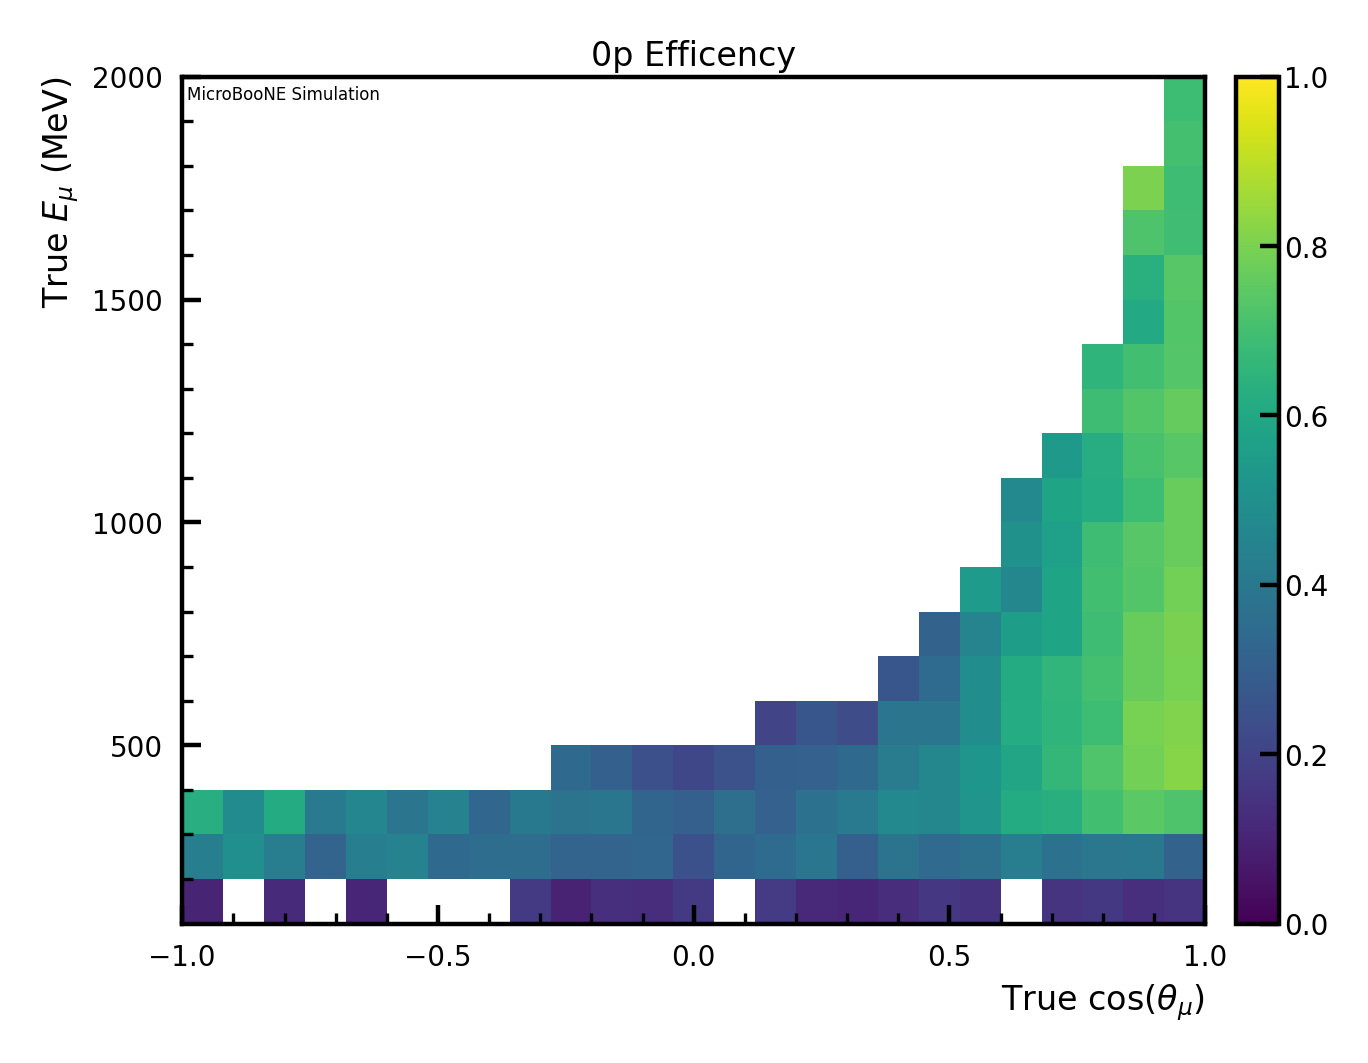

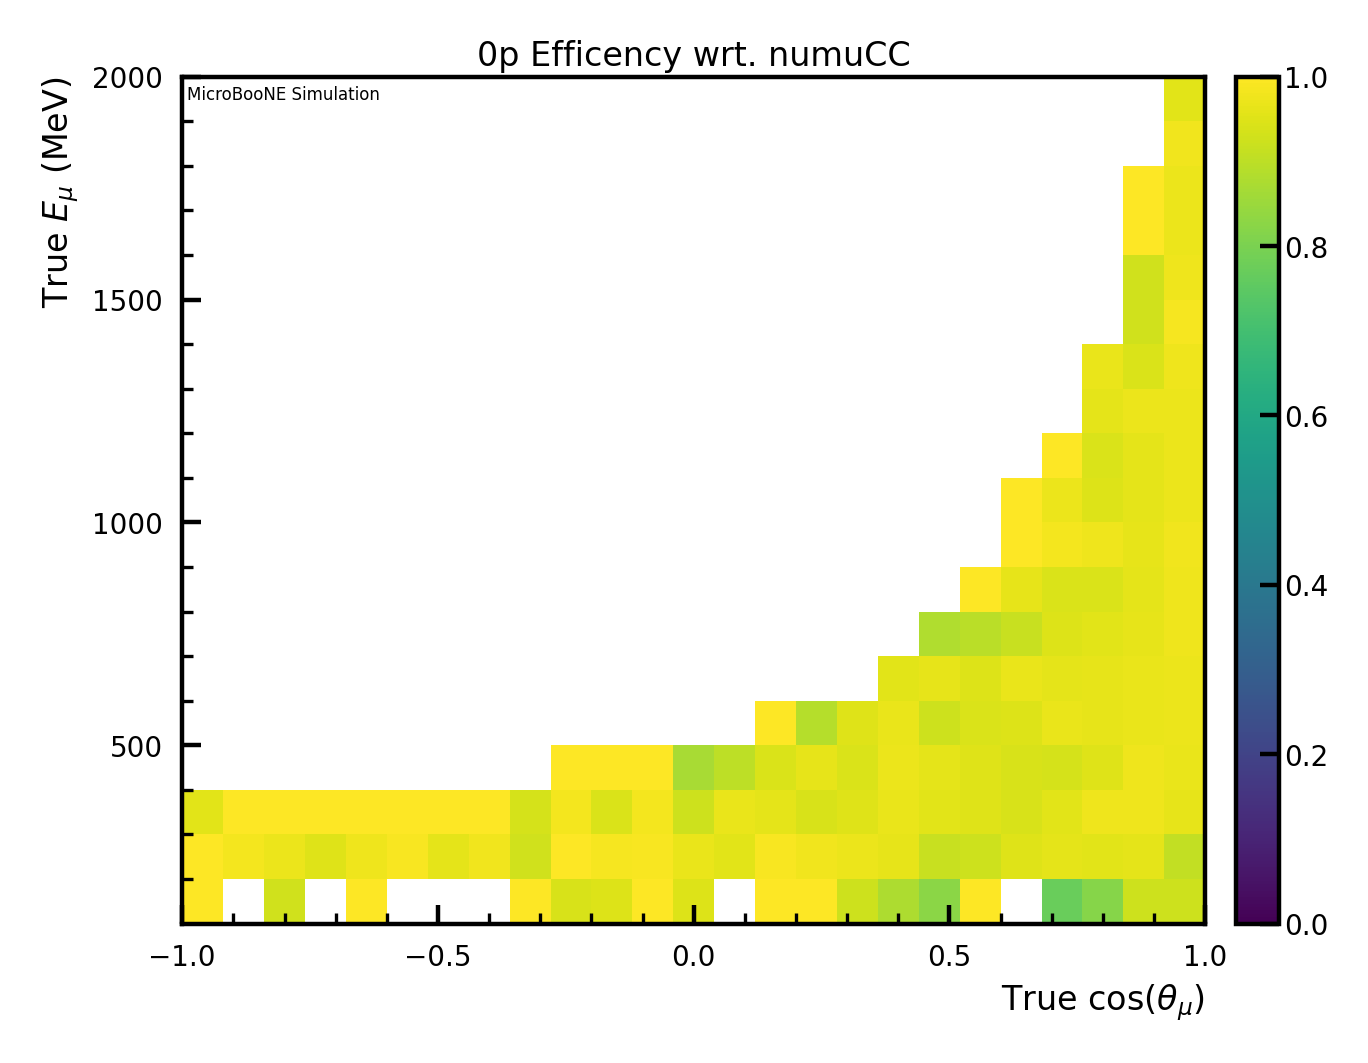

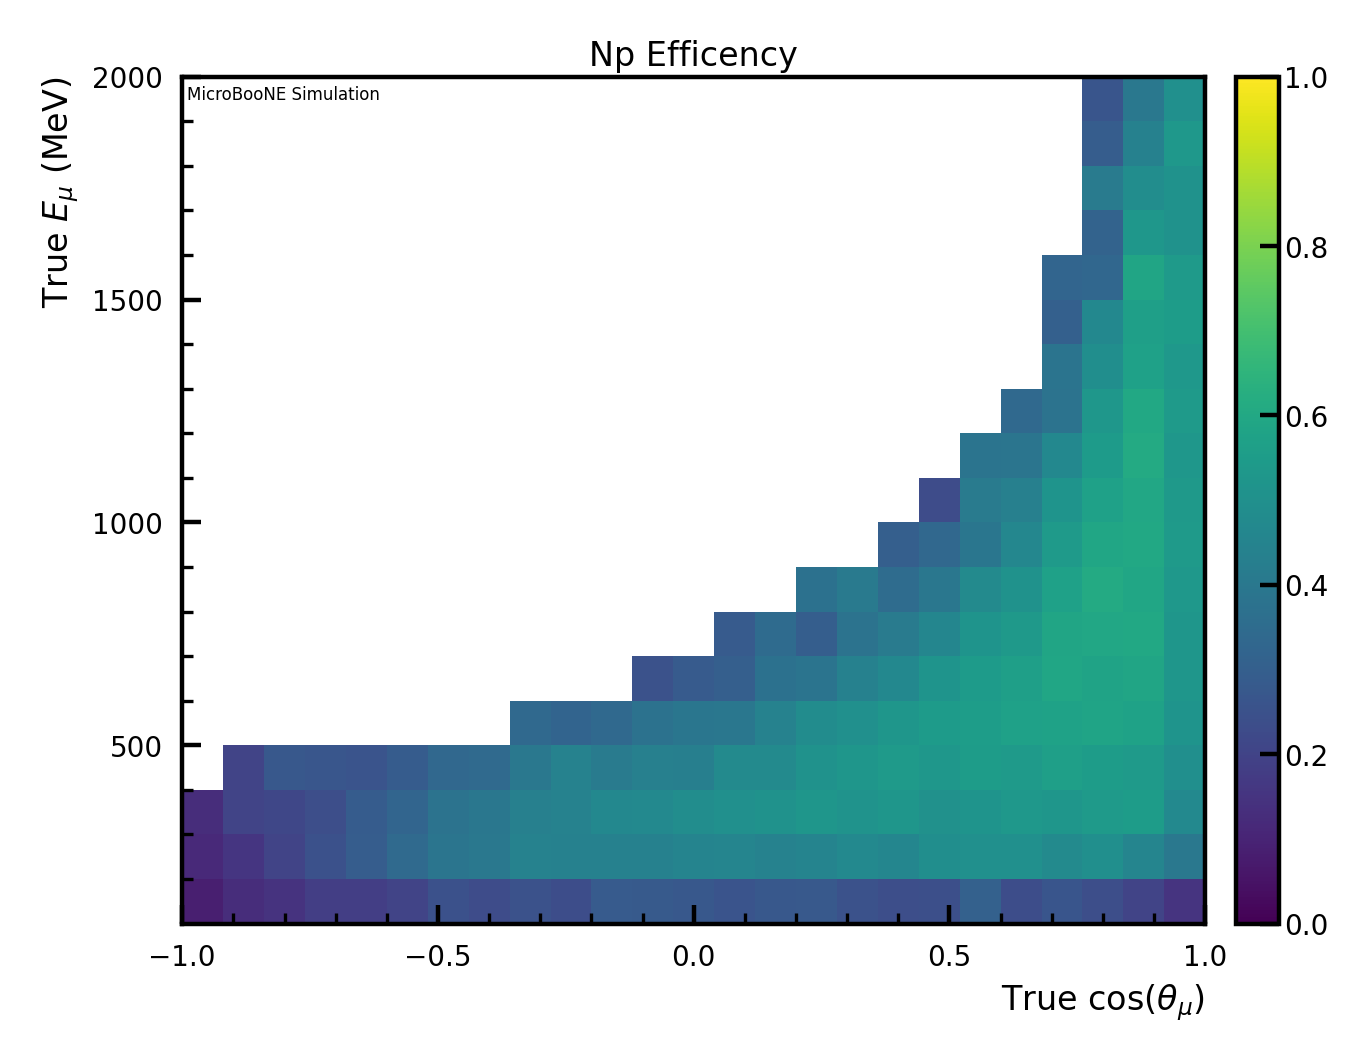

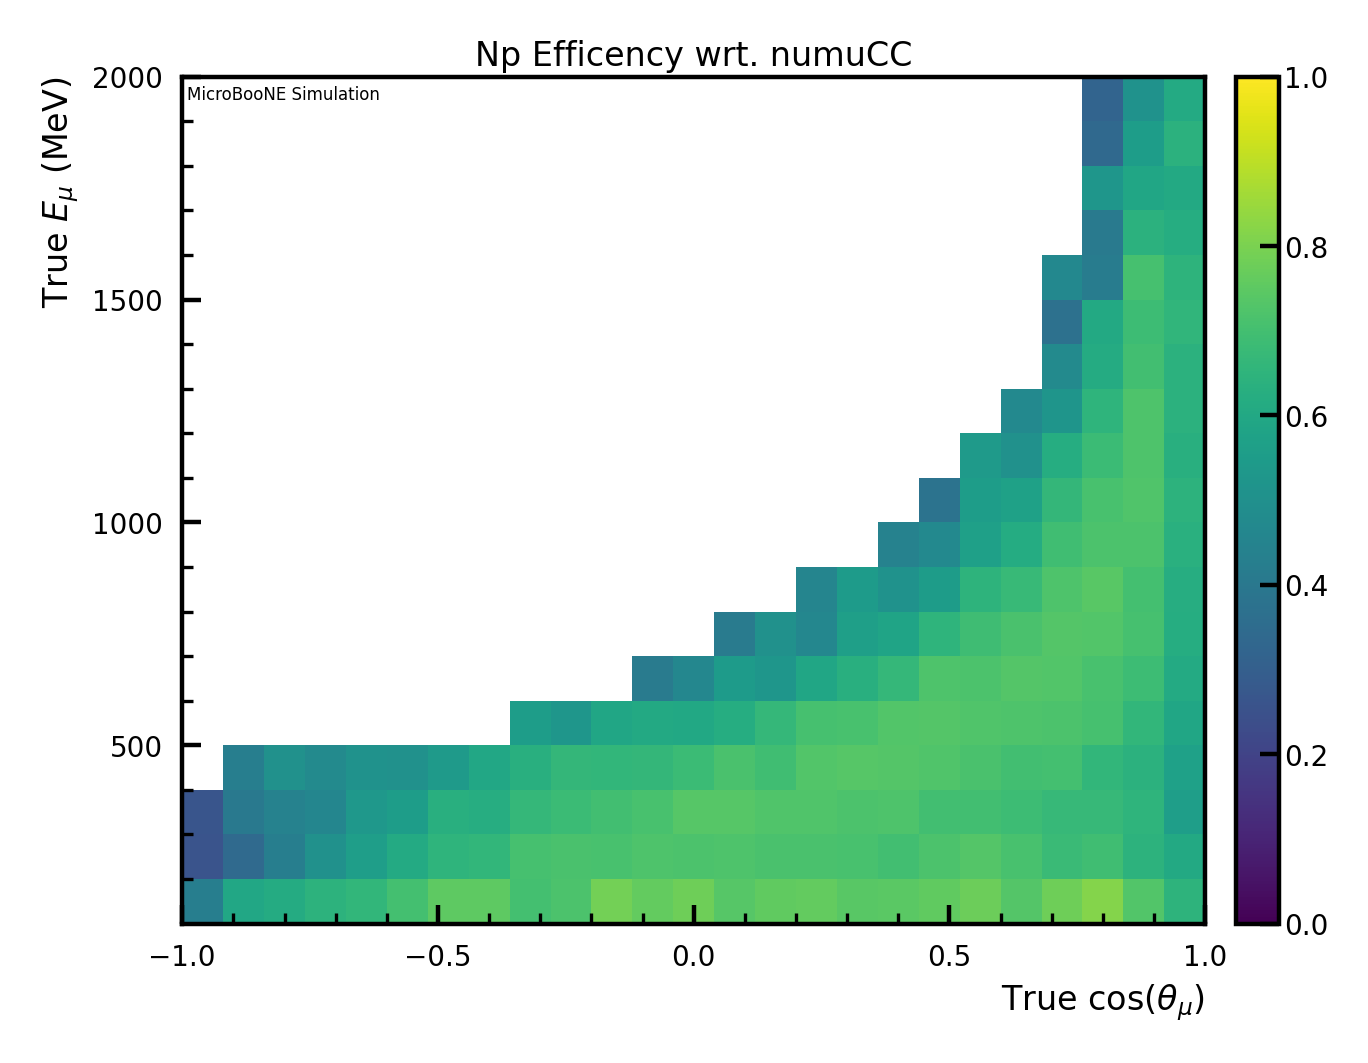

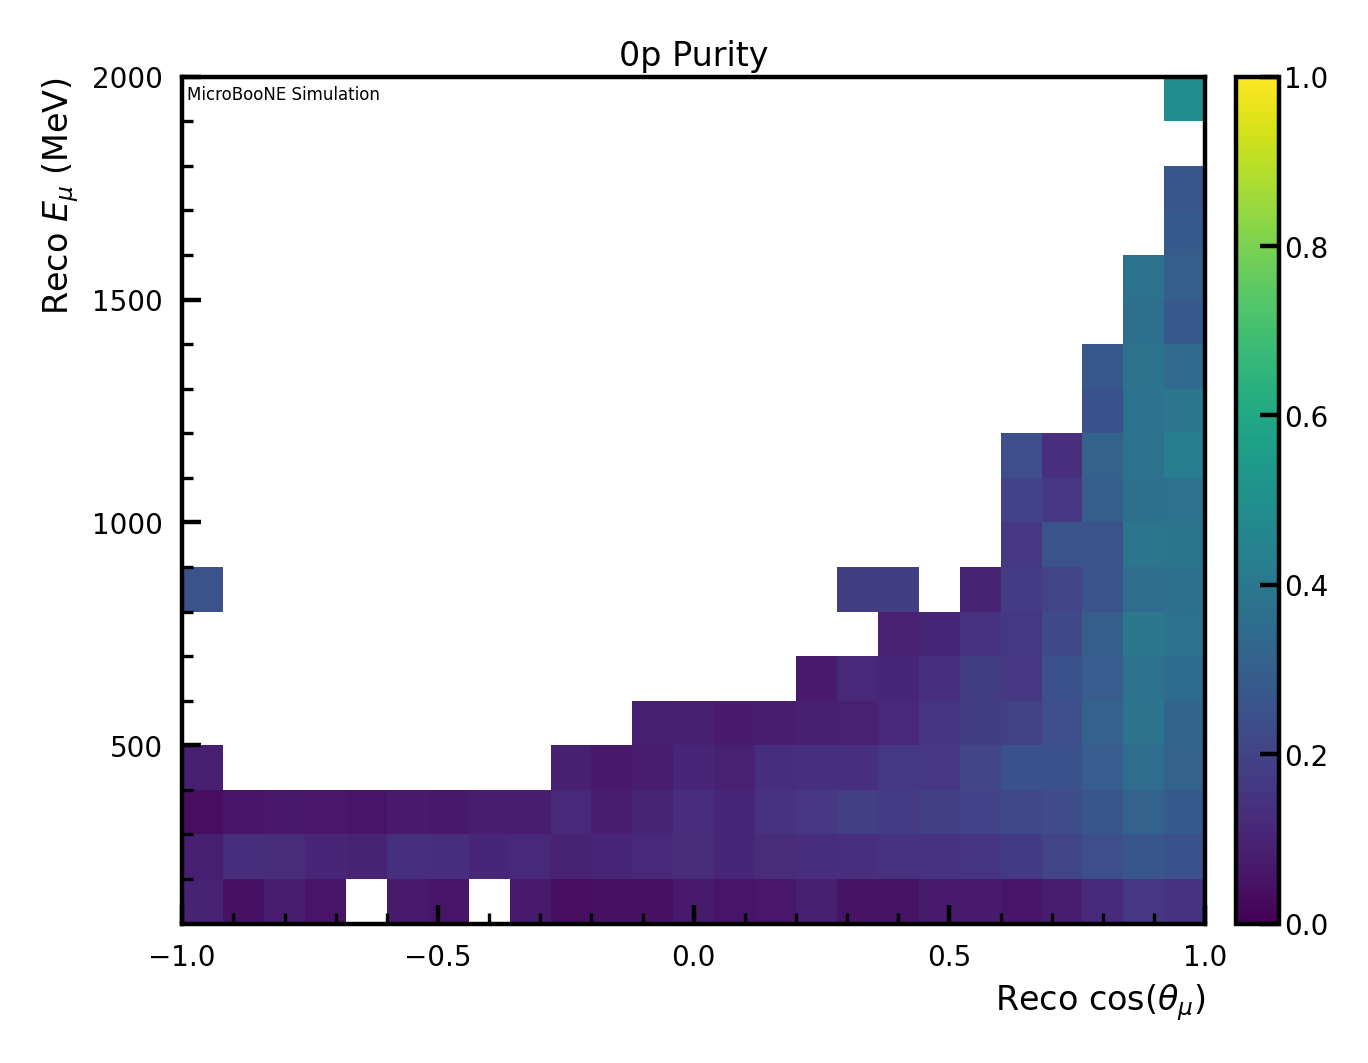

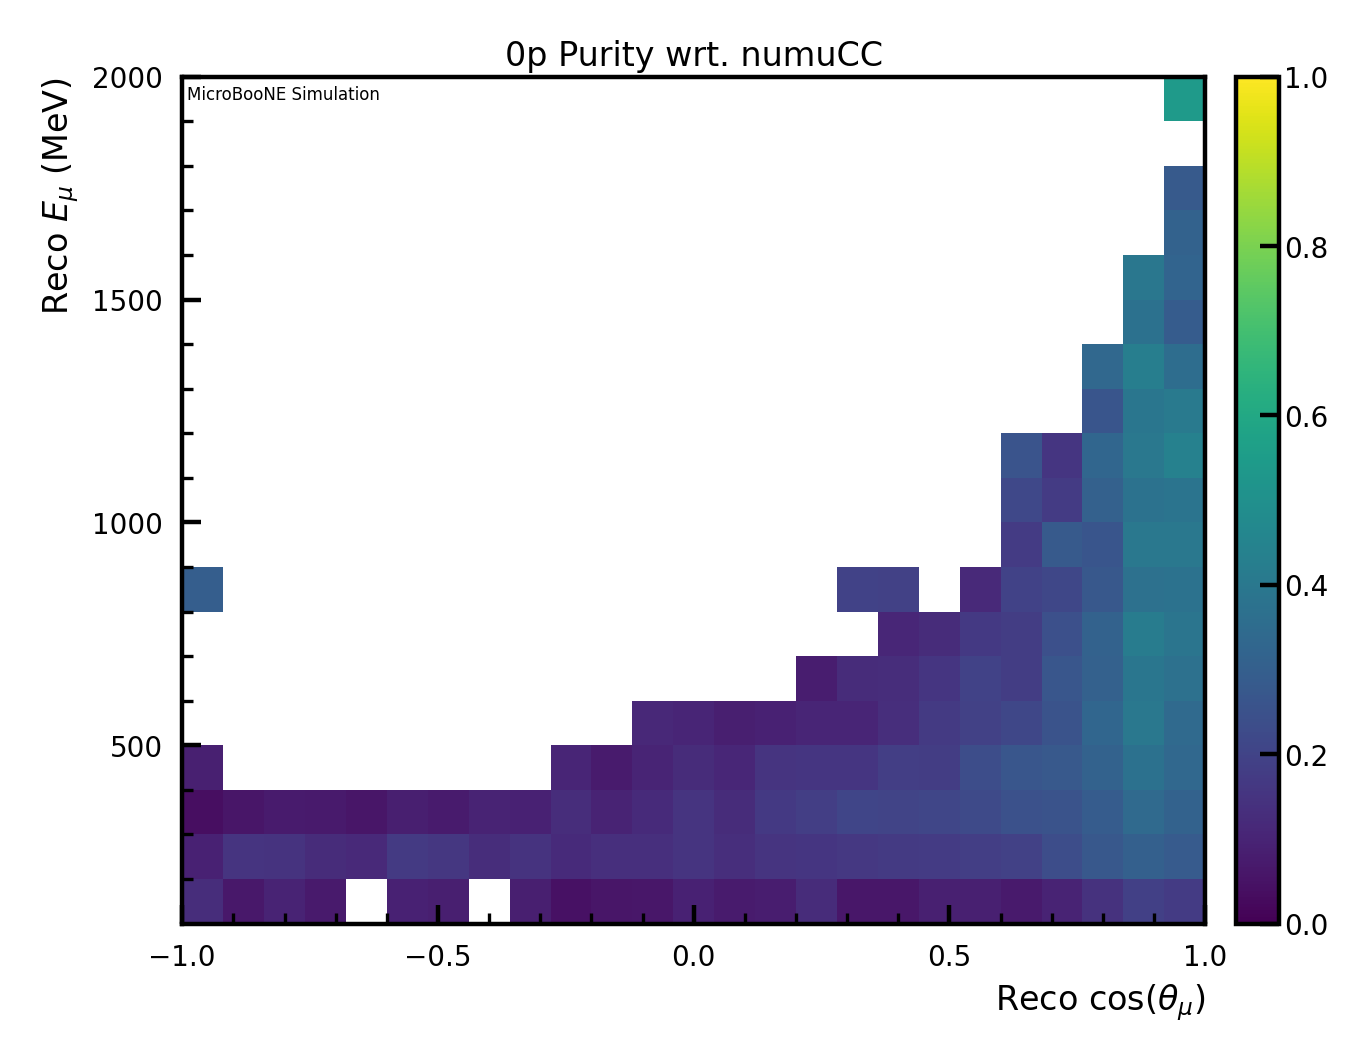

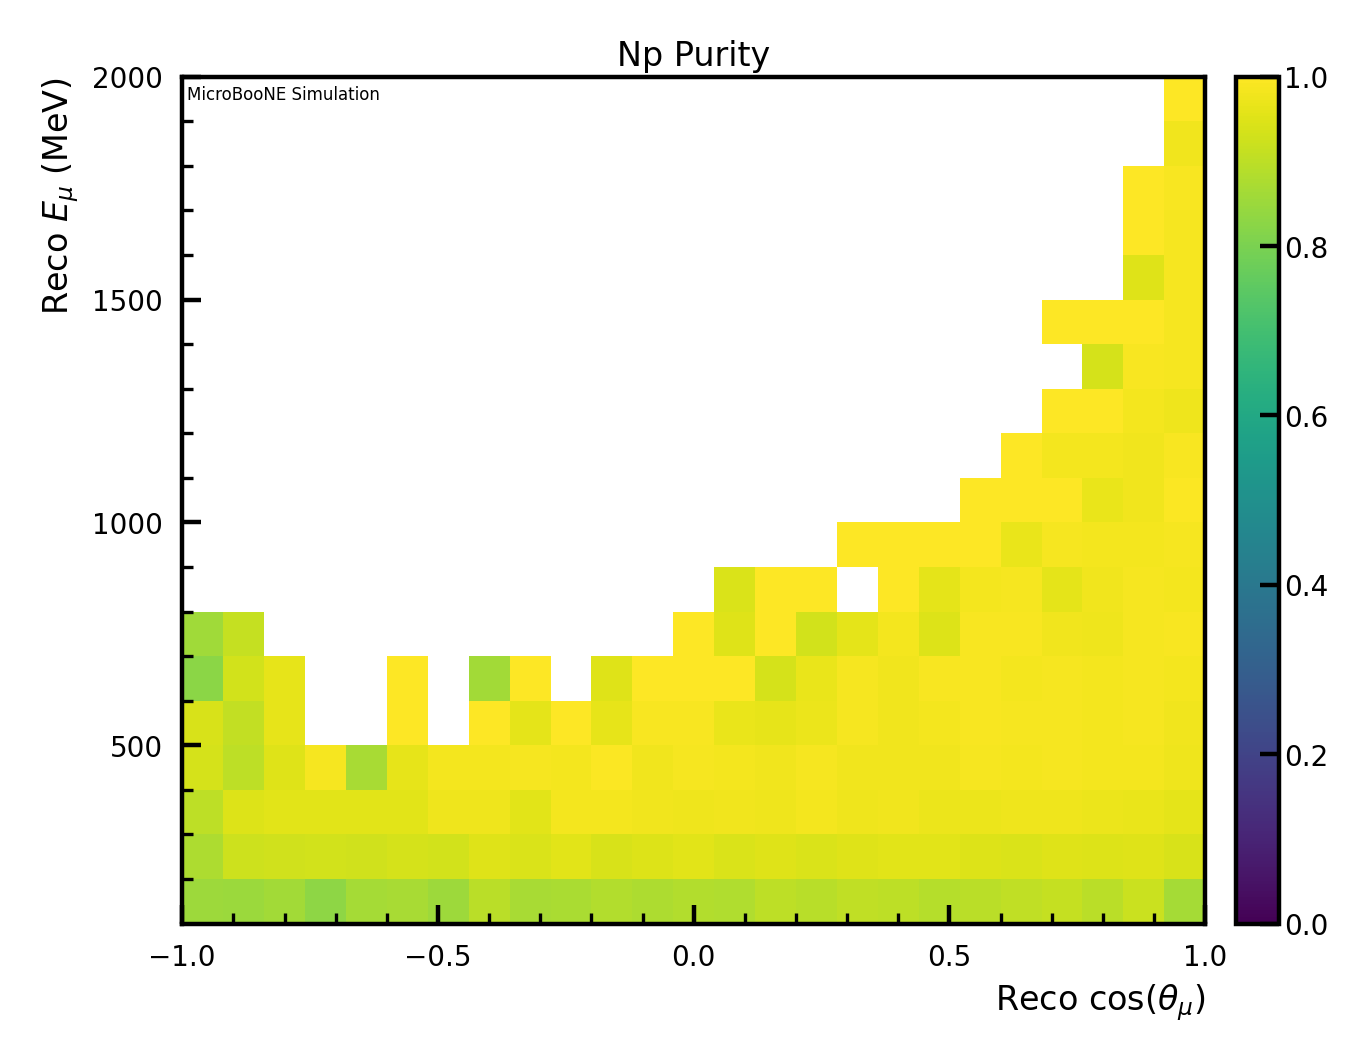

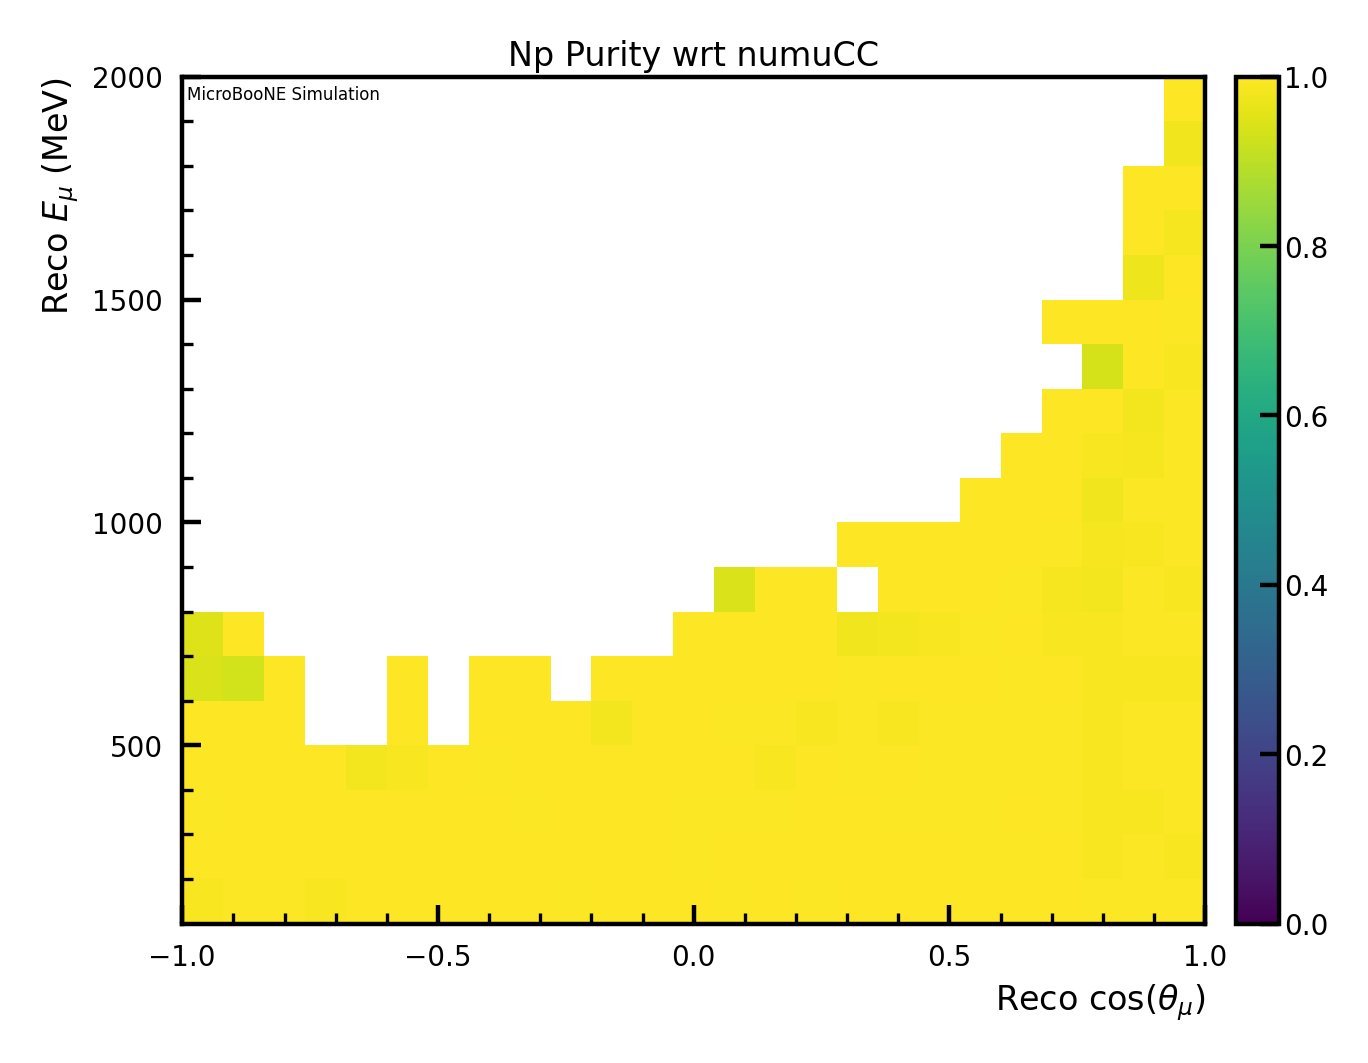

In [31]:
eff_pur_test2d(["truth_muon_costheta","truth_Emuon"], [-1,100], [1,2000], [25,19], ["reco_muon_costheta","reco_Emuon"], [-1,100], [1,2000], [25,19], plot_Xp = True ,plot_0pNp = True, weight_var="net_weight", onlyNp=False, min_counts=10)




In [37]:
#needs to have the sliced variable as the third one and that one needs the same reco and truth bins
#only works for eff rn, need to get the reco part working for that, can be done by just setting an option to do purr of eff in 2d
def eff_pur_test3d(truth_var, minv_truth, maxv_truth, nbins_truth, reco_var, minv_reco, maxv_reco, nbins_reco, plot_Xp = True ,plot_0pNp = True, weight_var="net_weight", onlyNp=False, extra_query="", min_counts=10):
        
    bins_truth2 = np.linspace(minv_truth[2], maxv_truth[2], num=nbins_truth[2]+1)
    bins_0p_truth2 = bins_truth2
    bins_Np_truth2 = bins_truth2
    
    bins_reco2 = np.linspace(minv_reco[2], maxv_reco[2], num=nbins_reco[2]+1)
    bins_0p_reco2 = bins_reco2
    bins_Np_reco2 = bins_reco2
        
    for i in range(nbins_truth[2]):
        minv = bins_truth2[i]
        maxv = bins_truth2[i+1]
        extra_query = " and "+truth_var[2]+">"+ str(minv) +" and "+truth_var[2]+ "<=" + str(maxv) 
        eff_pur_test2d(truth_var[:-1], minv_truth[:-1], maxv_truth[:-1], nbins_truth[:-1], reco_var[:-1], minv_reco[:-1], maxv_reco[:-1], nbins_reco[:-1], plot_Xp = plot_Xp ,plot_0pNp = plot_0pNp, weight_var=weight_var, onlyNp=onlyNp, extra_query=extra_query, min_counts=min_counts)



Xp case not coded yet


/var/folders/q7/hkz33qhs6bj871s7n1wl4wfw0000gs/T/ipykernel_18599/3764110869.py:151: RuntimeWarning: invalid value encountered in divide
  eff0p = sig_t0p_sel_r0p_tbinned/sig_t0p_tbinned
/var/folders/q7/hkz33qhs6bj871s7n1wl4wfw0000gs/T/ipykernel_18599/3764110869.py:152: RuntimeWarning: invalid value encountered in divide
  eff0p_wrt_numucc = sig_t0p_sel_r0p_tbinned/sig_t0p_sel_tbinned
/var/folders/q7/hkz33qhs6bj871s7n1wl4wfw0000gs/T/ipykernel_18599/3764110869.py:153: RuntimeWarning: invalid value encountered in divide
  pur0p = sig_t0p_sel_r0p_rbinned/sel_r0p_rbinned
/var/folders/q7/hkz33qhs6bj871s7n1wl4wfw0000gs/T/ipykernel_18599/3764110869.py:154: RuntimeWarning: invalid value encountered in divide
  pur0p_wrt_numucc = sig_t0p_sel_r0p_rbinned/sig_sel_r0p_rbinned
/var/folders/q7/hkz33qhs6bj871s7n1wl4wfw0000gs/T/ipykernel_18599/3764110869.py:156: RuntimeWarning: invalid value encountered in divide
  effNp = sig_tNp_sel_rNp_tbinned/sig_tNp_tbinned
/var/folders/q7/hkz33qhs6bj871s7n1wl4wfw

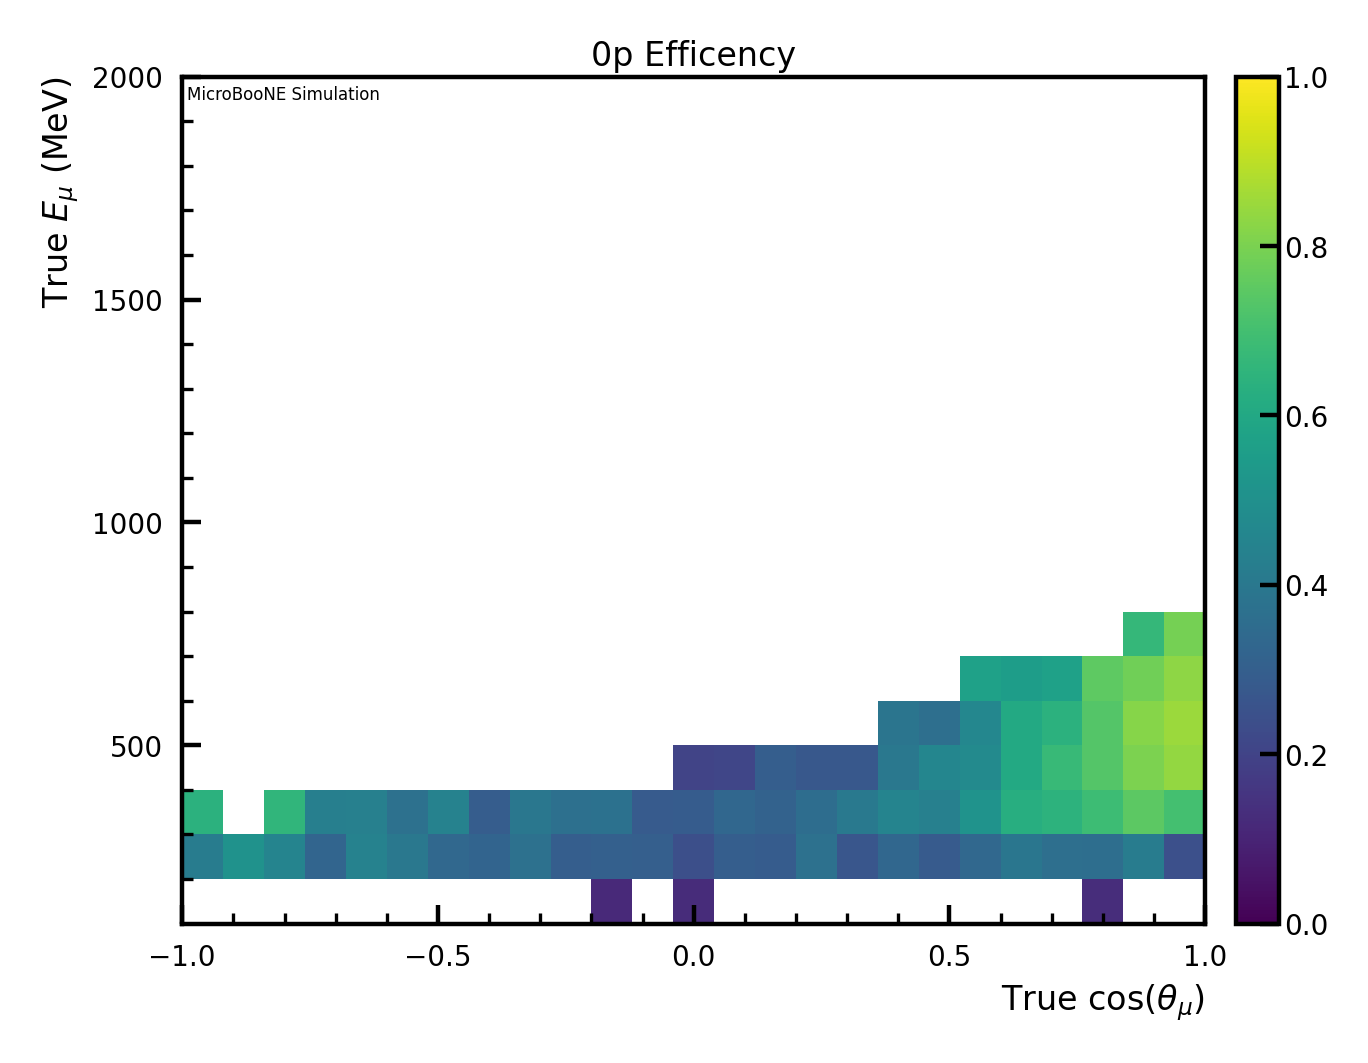

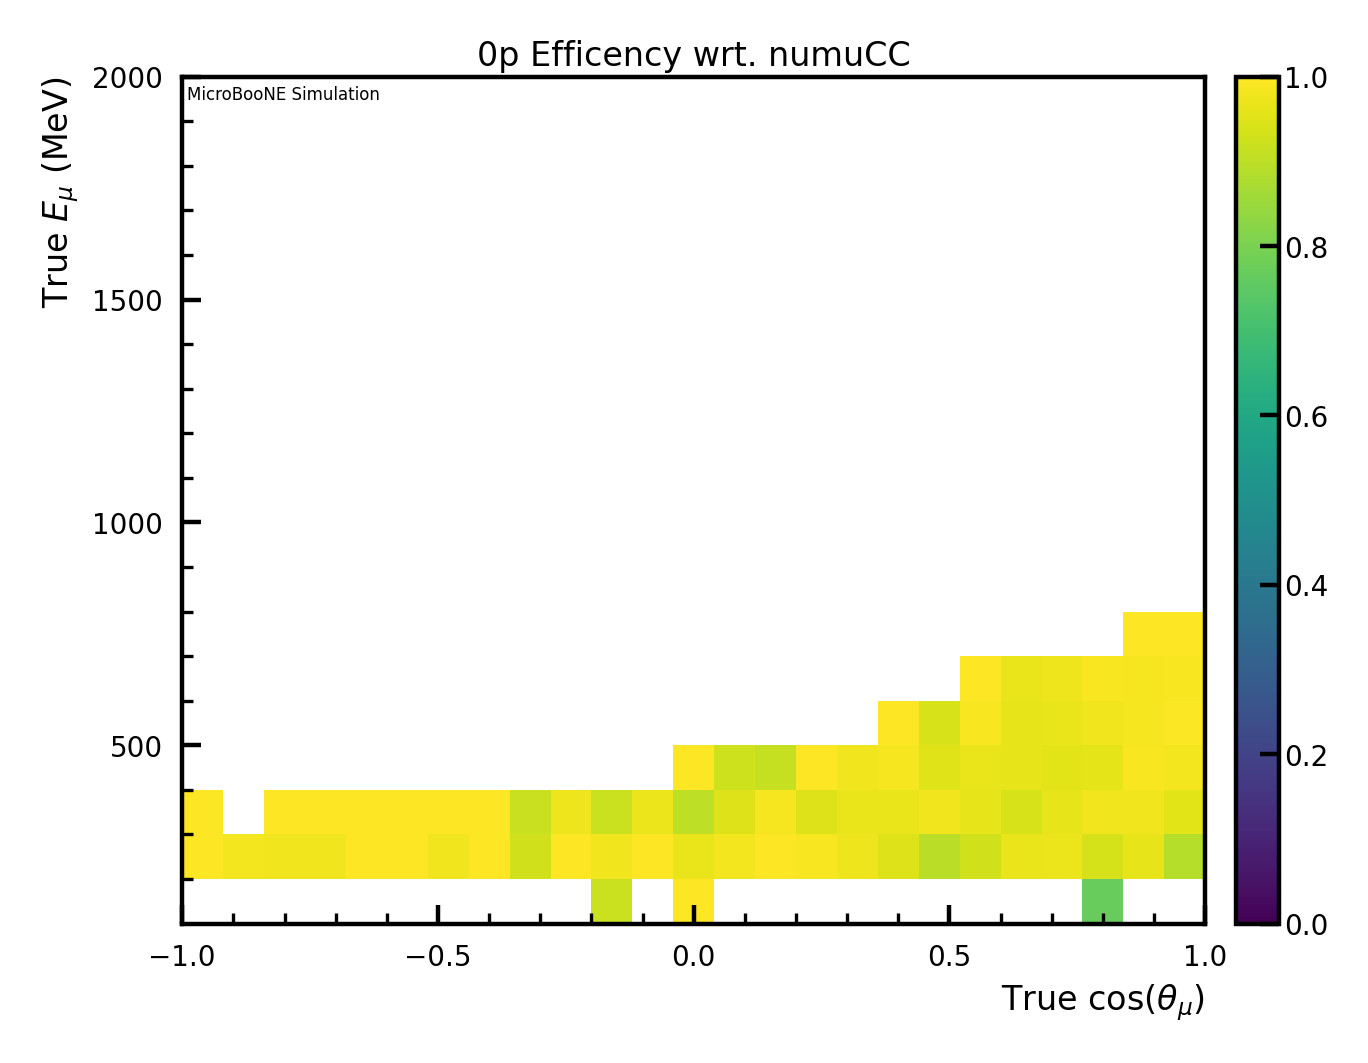

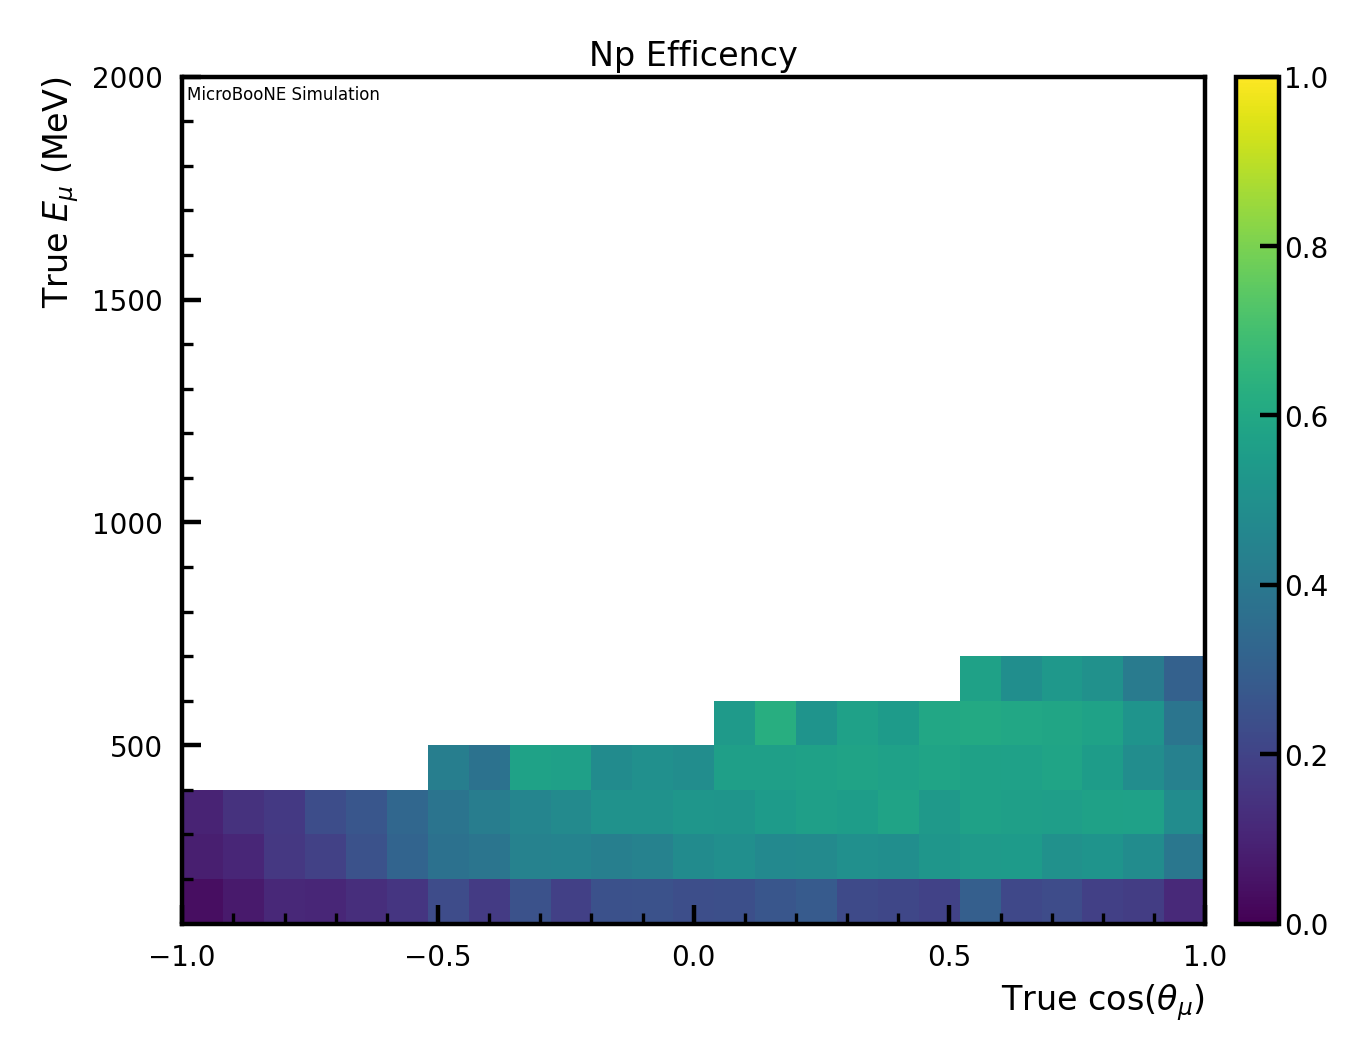

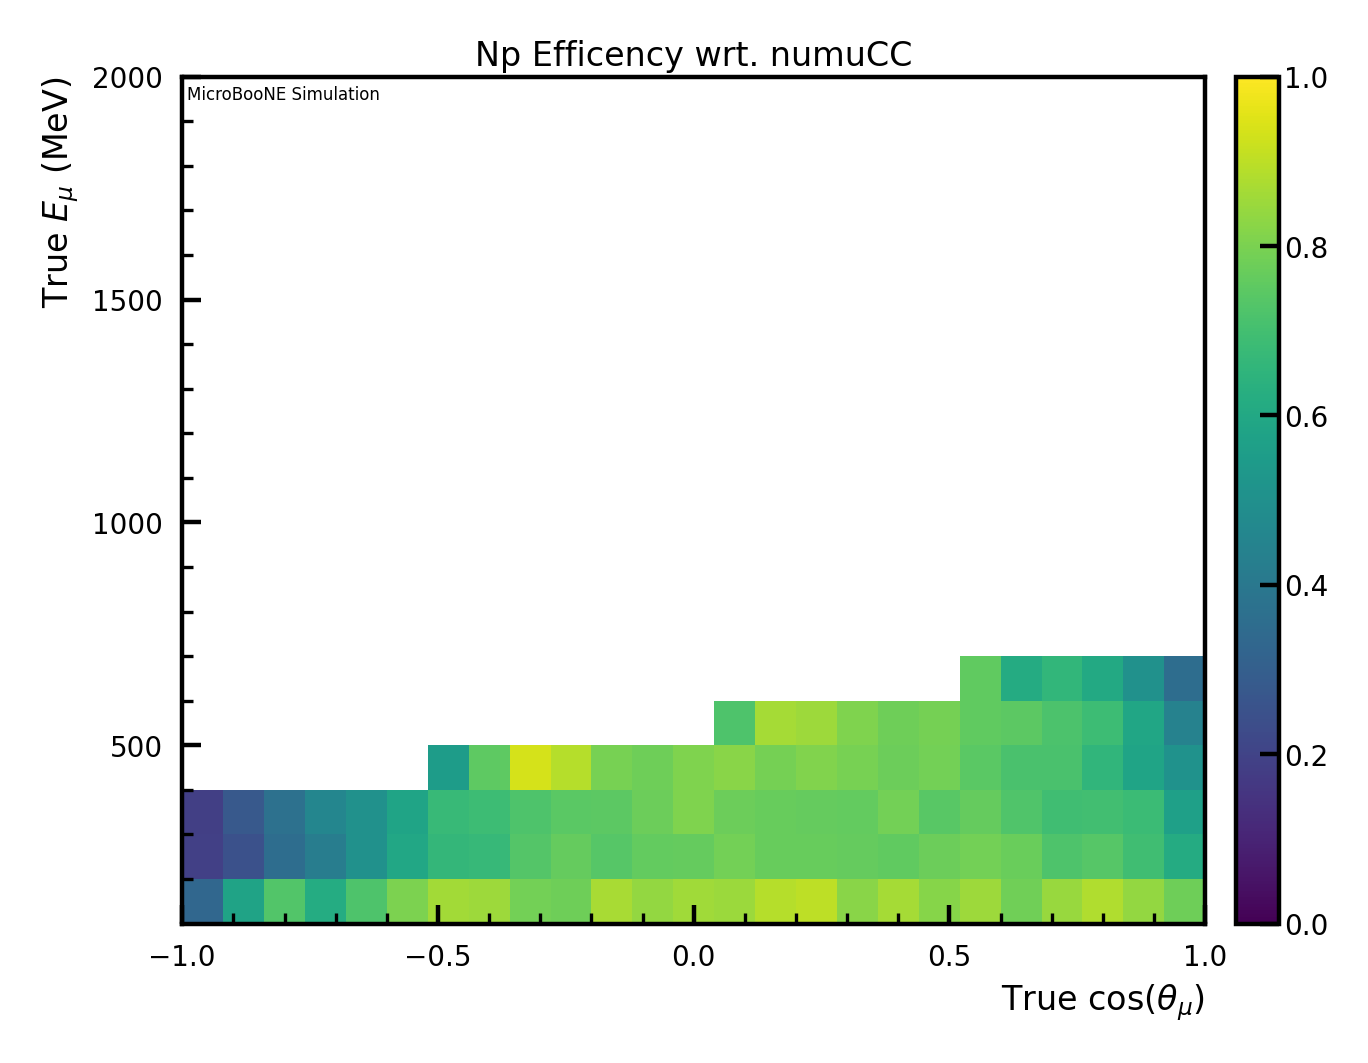

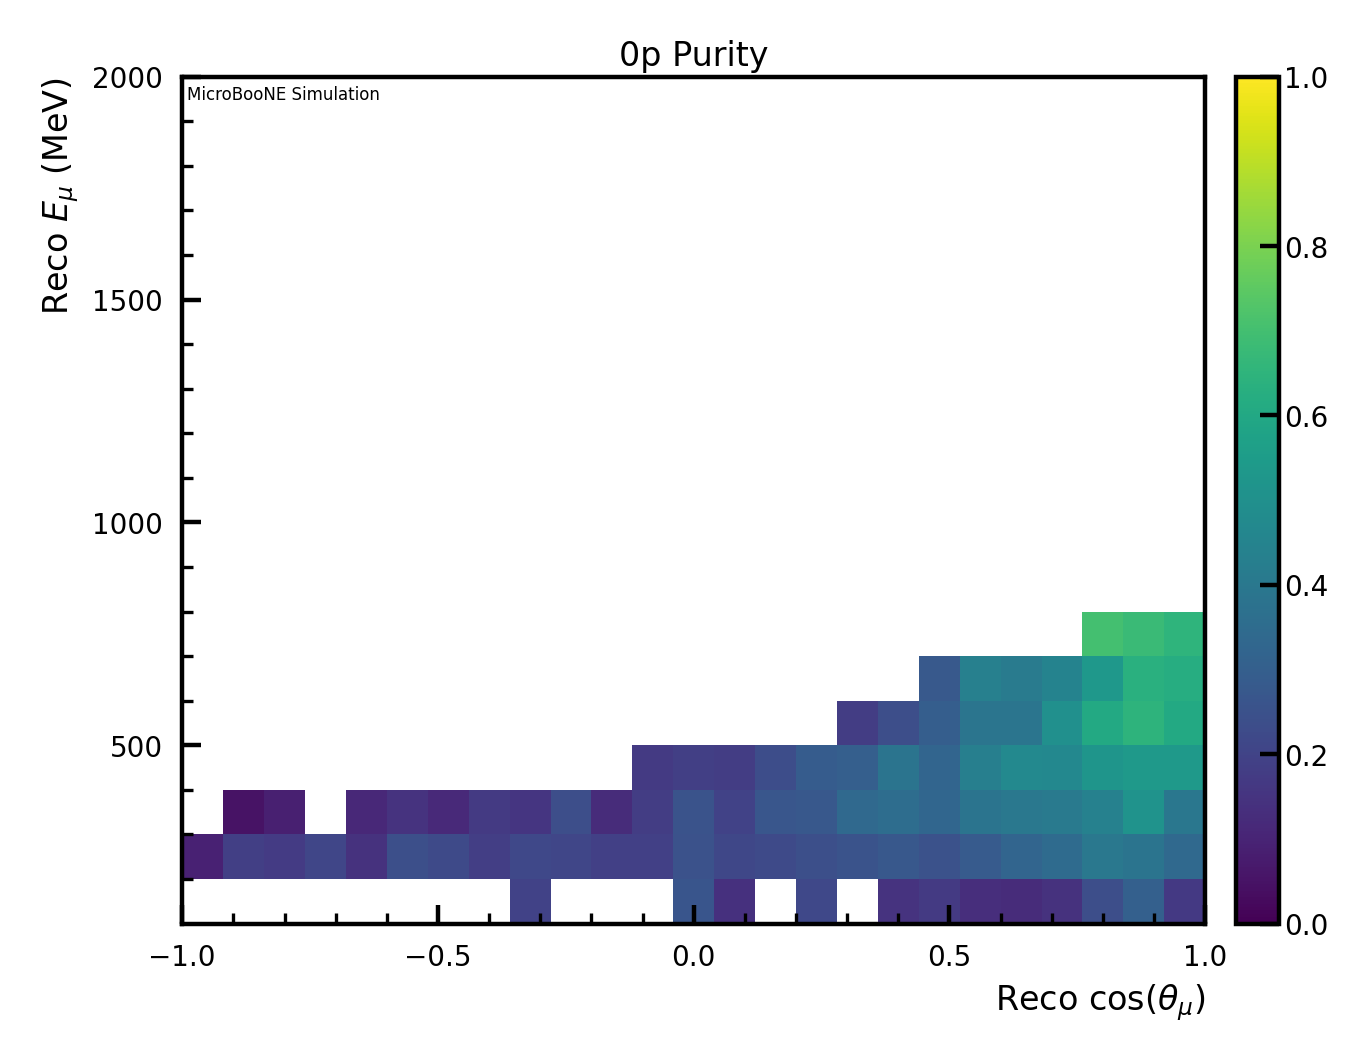

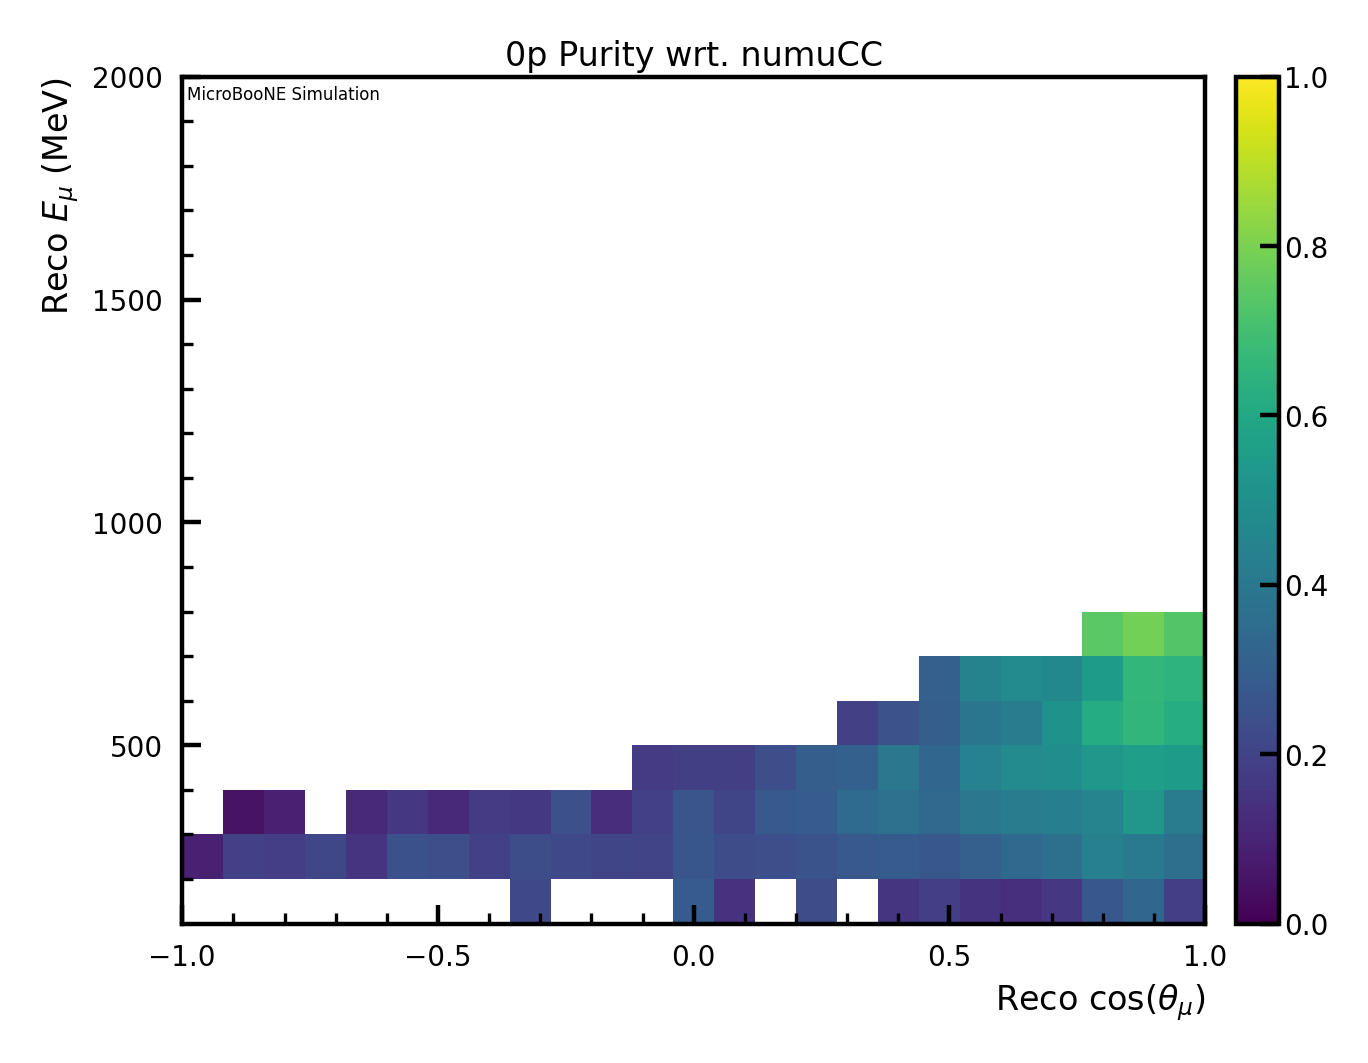

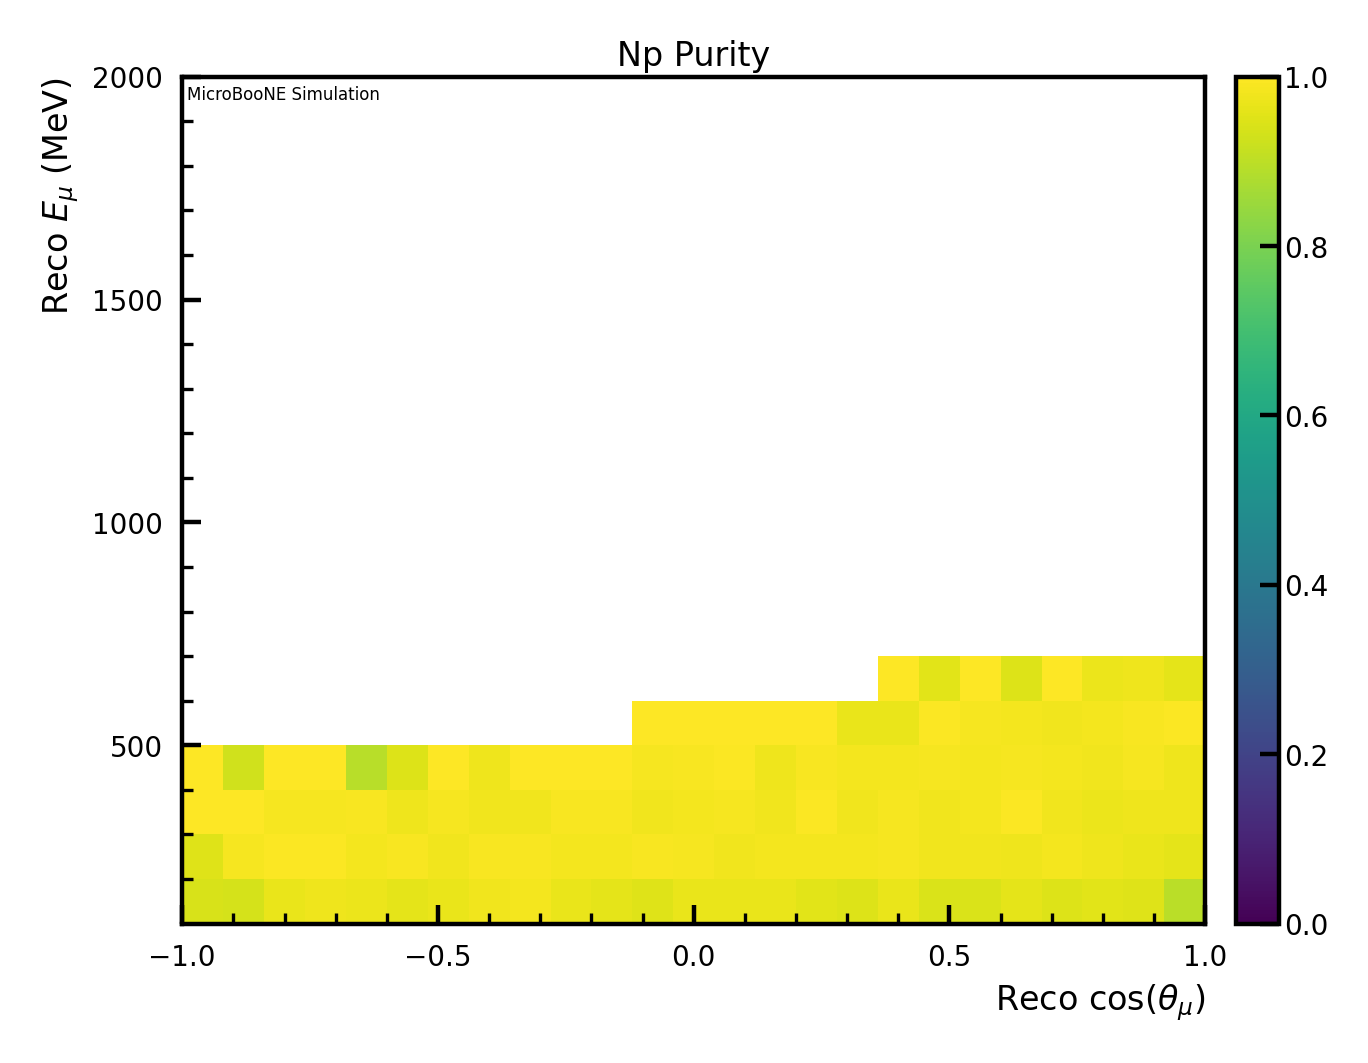

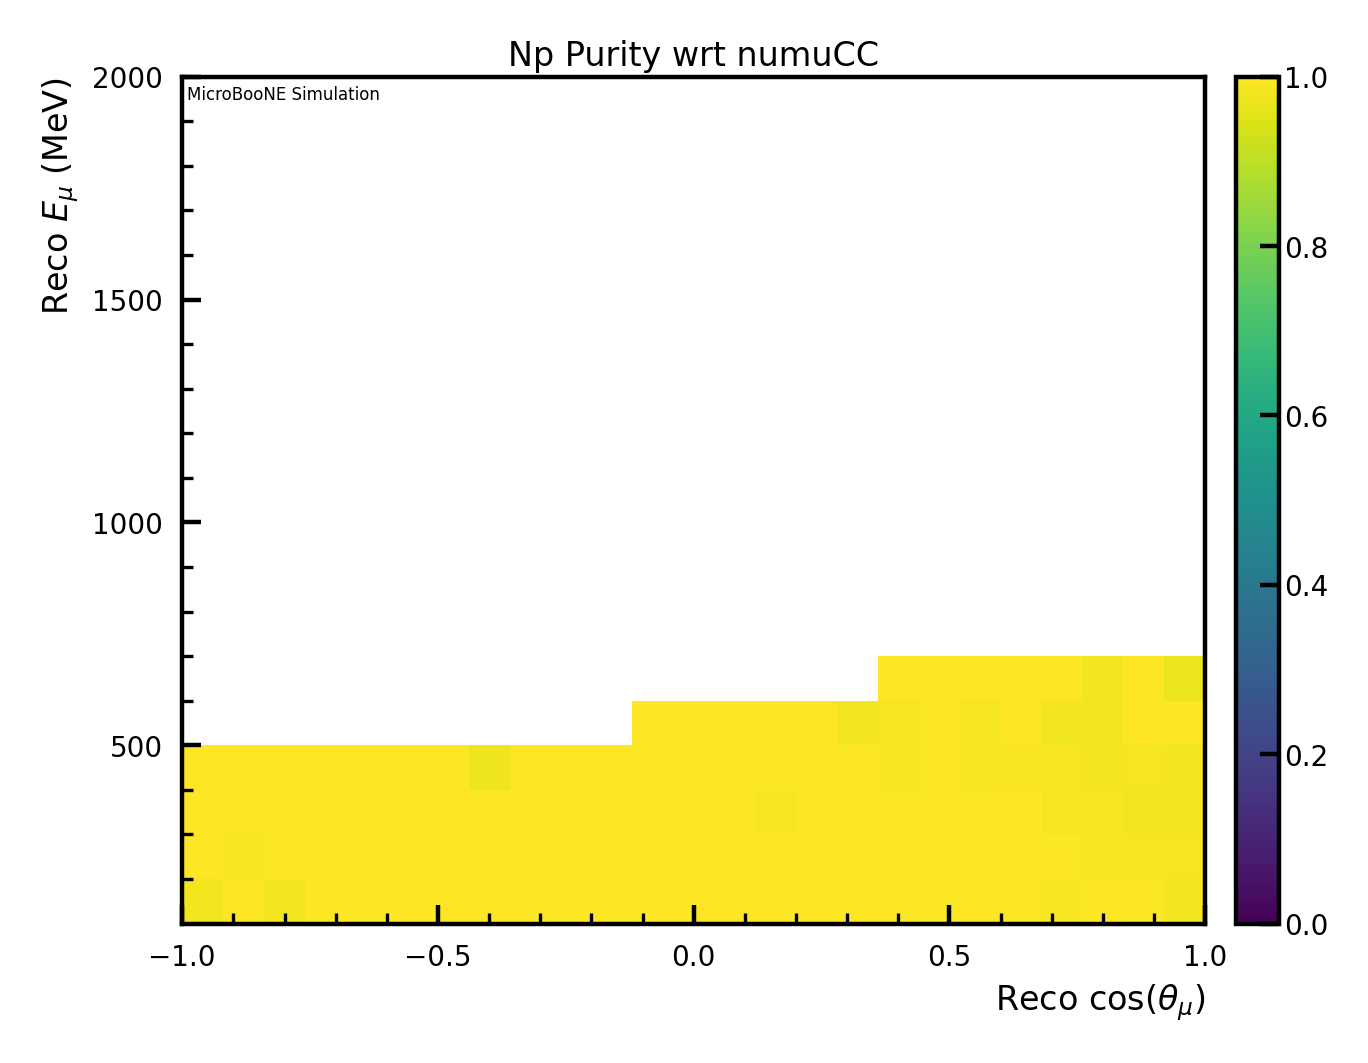

Xp case not coded yet


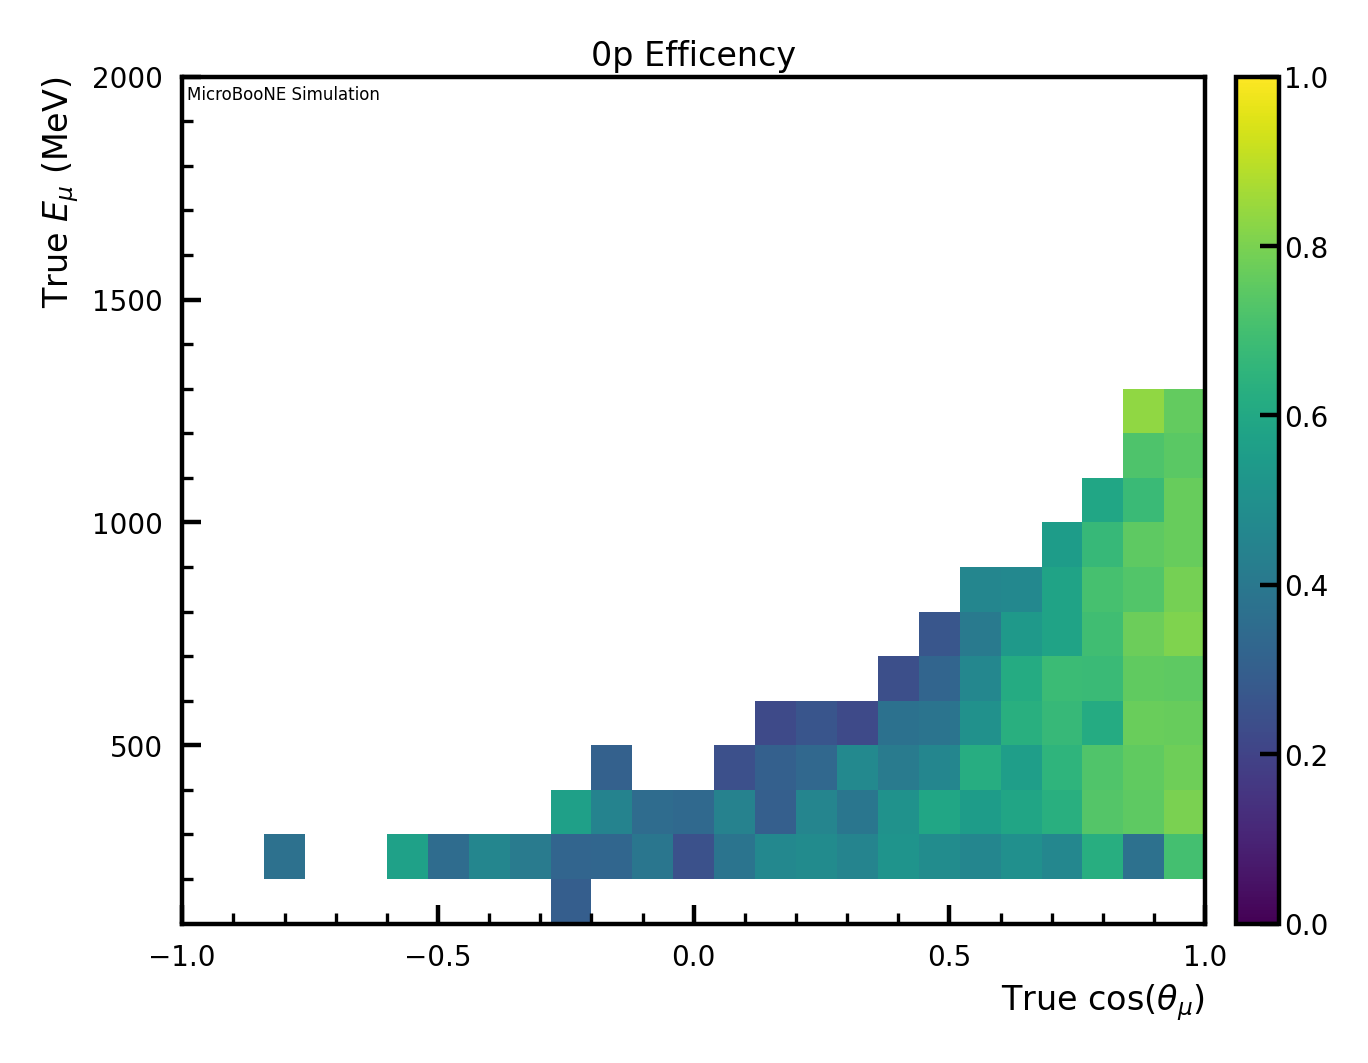

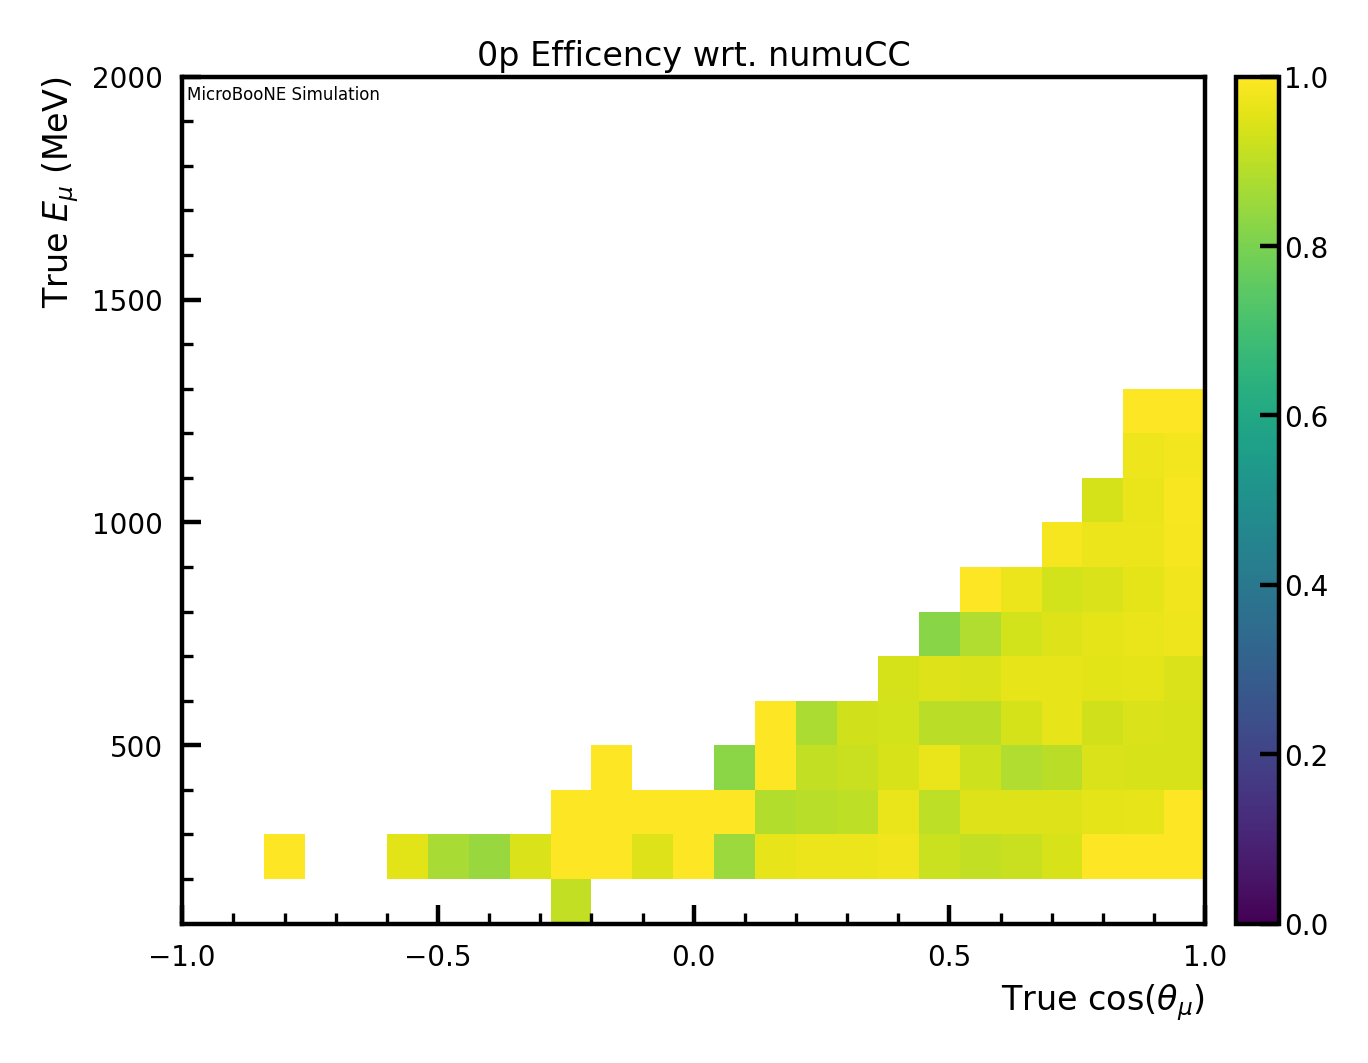

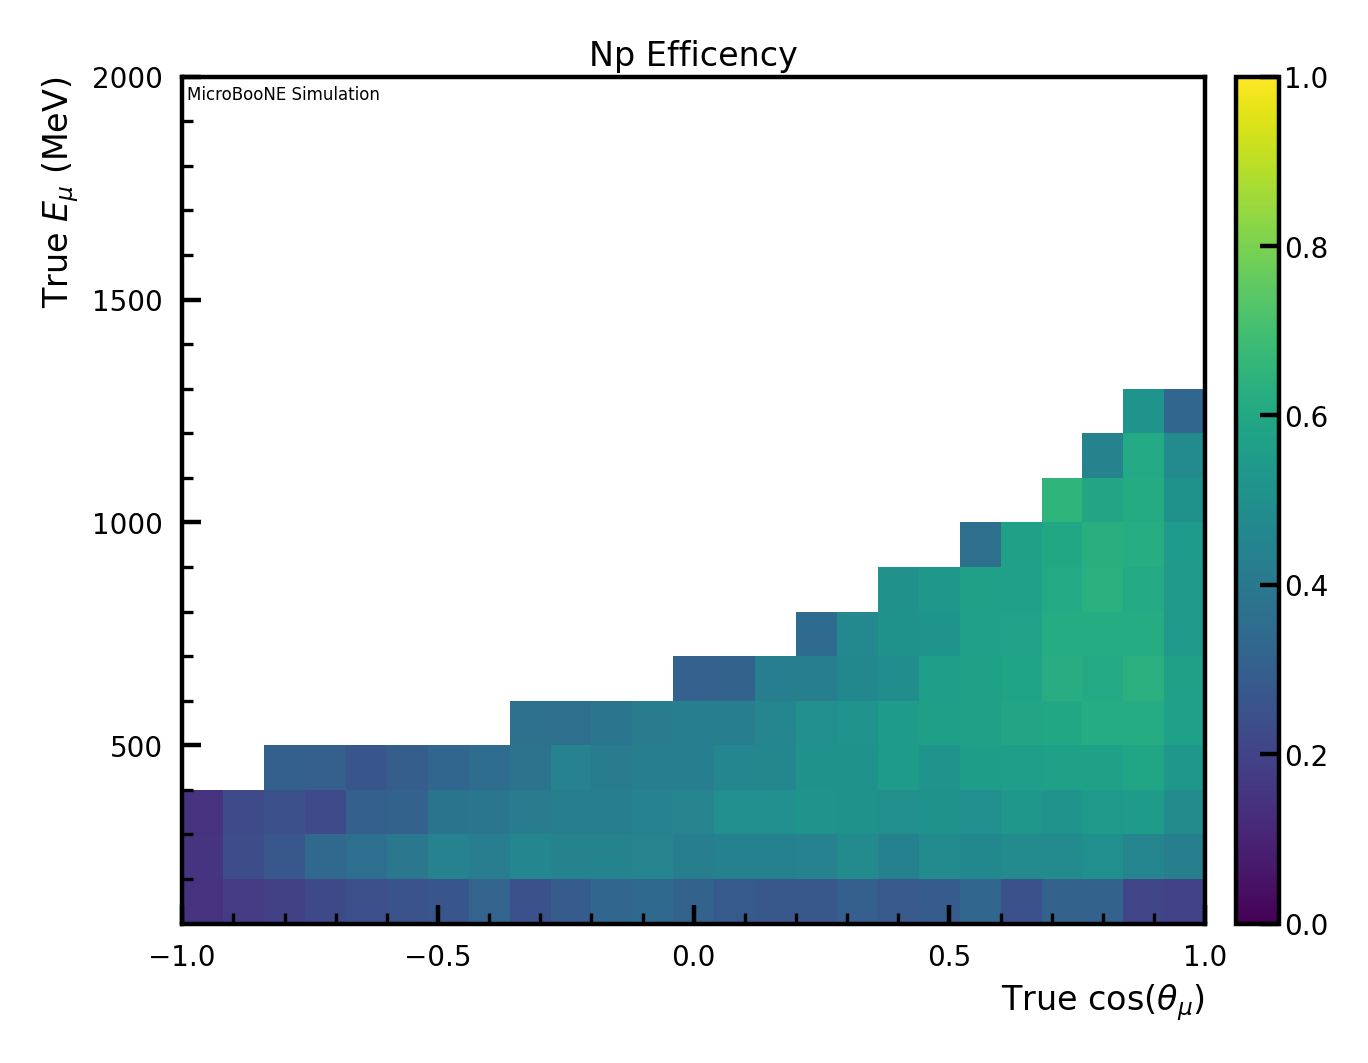

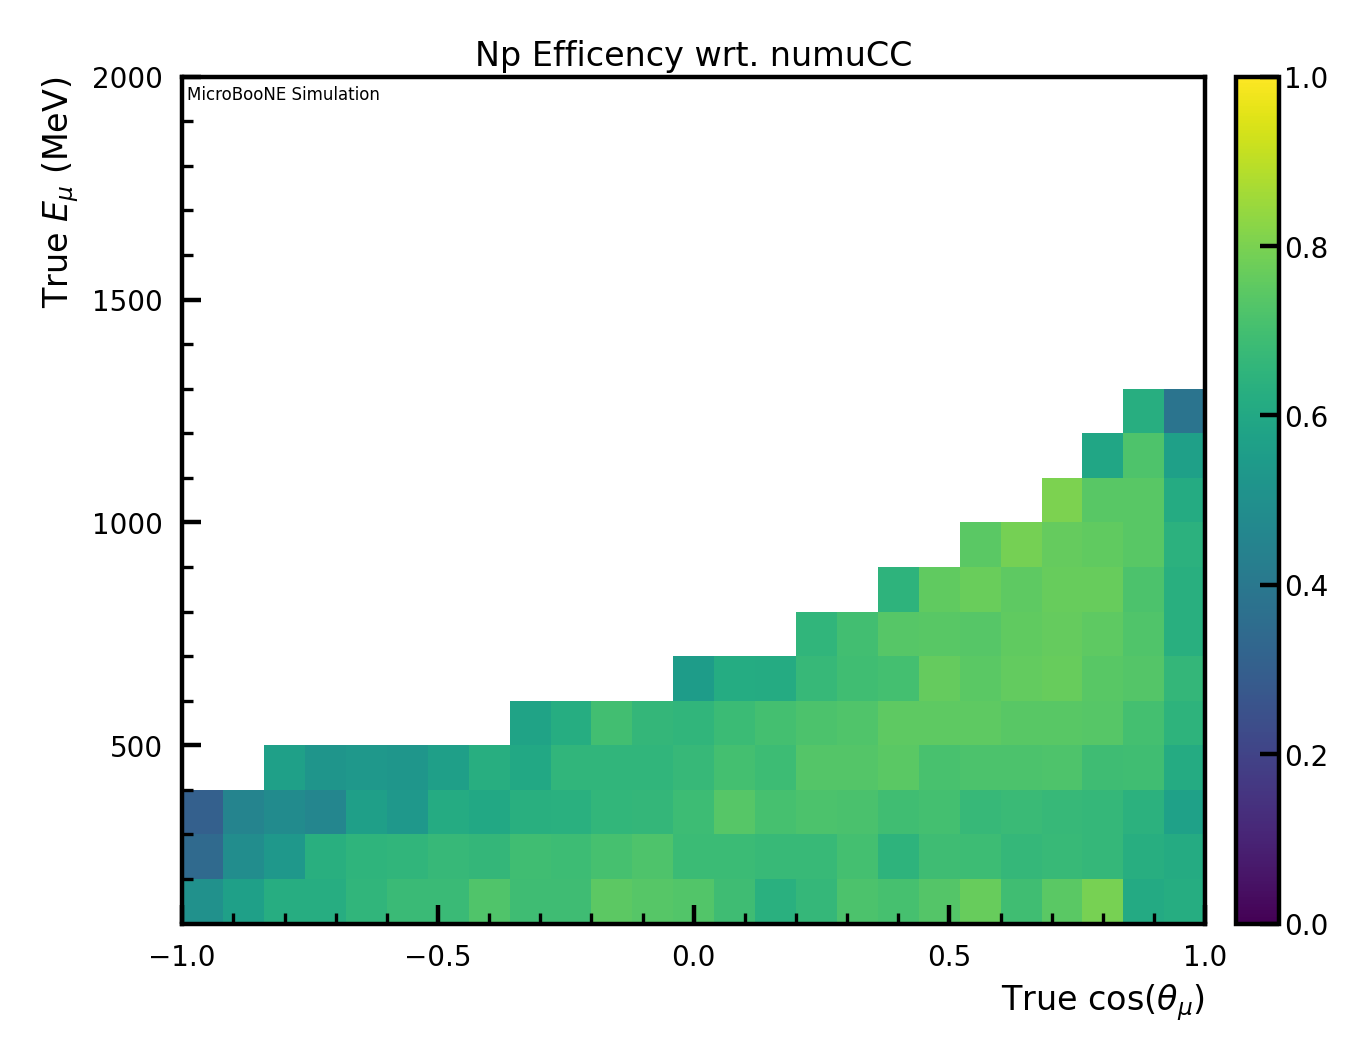

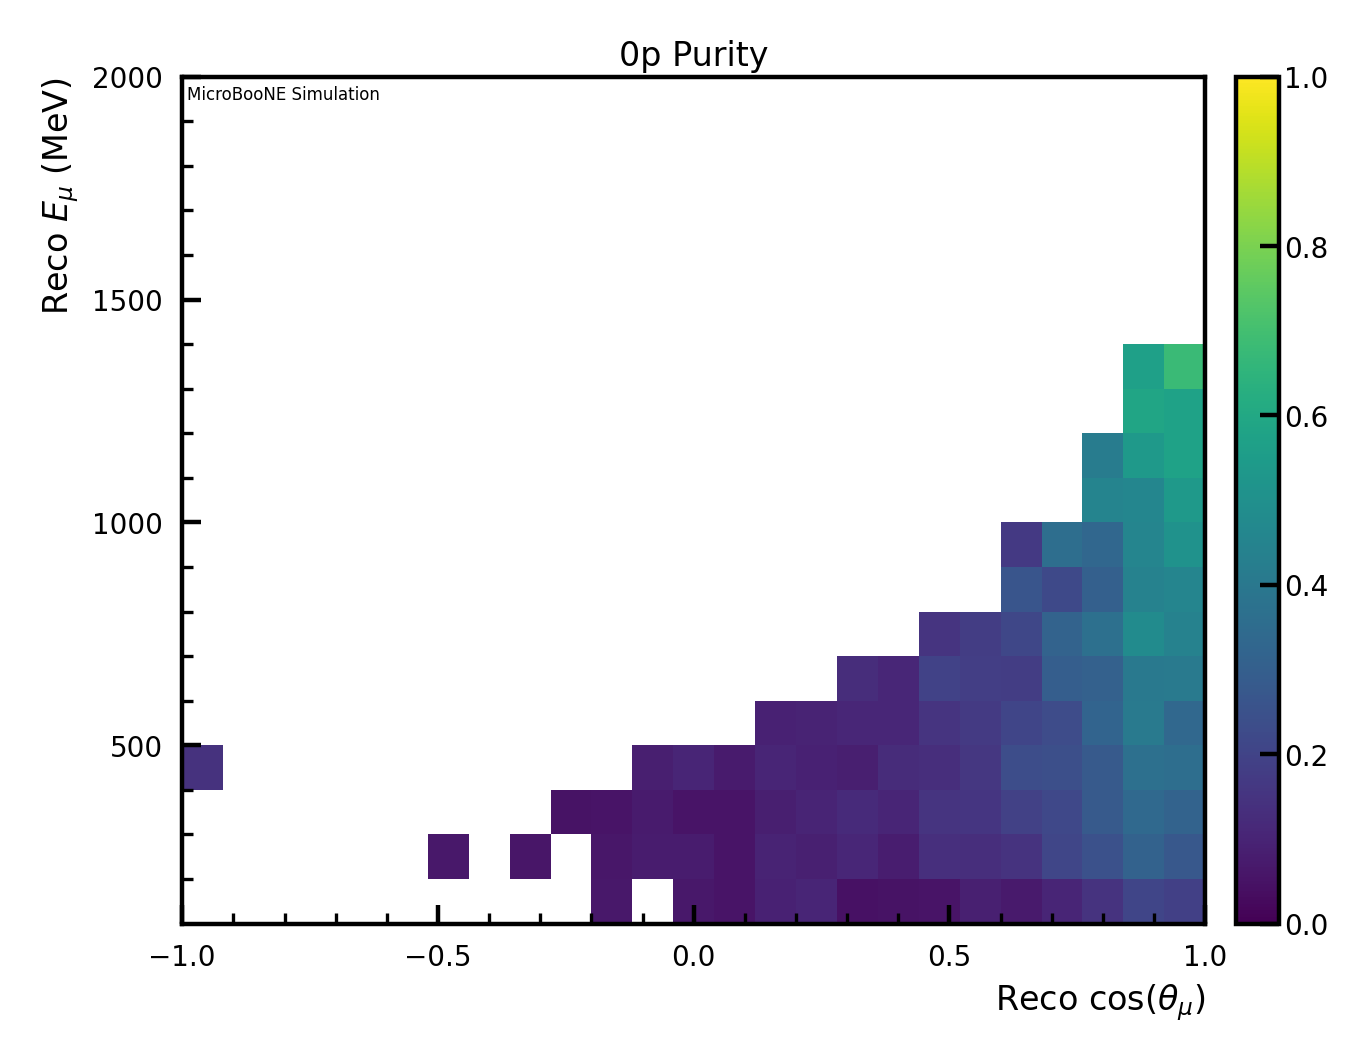

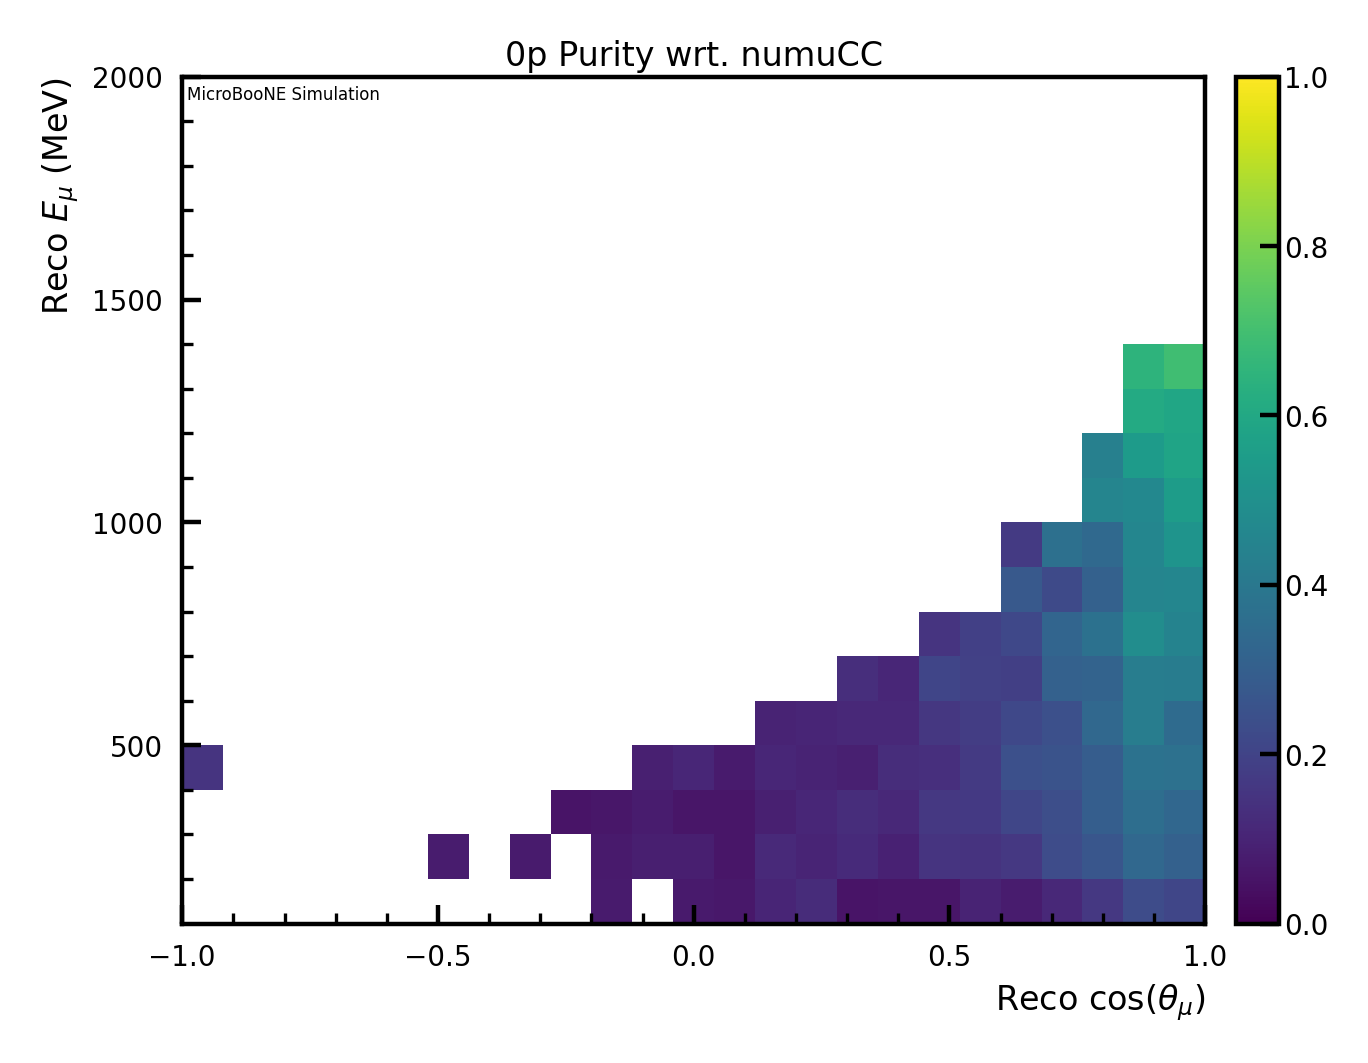

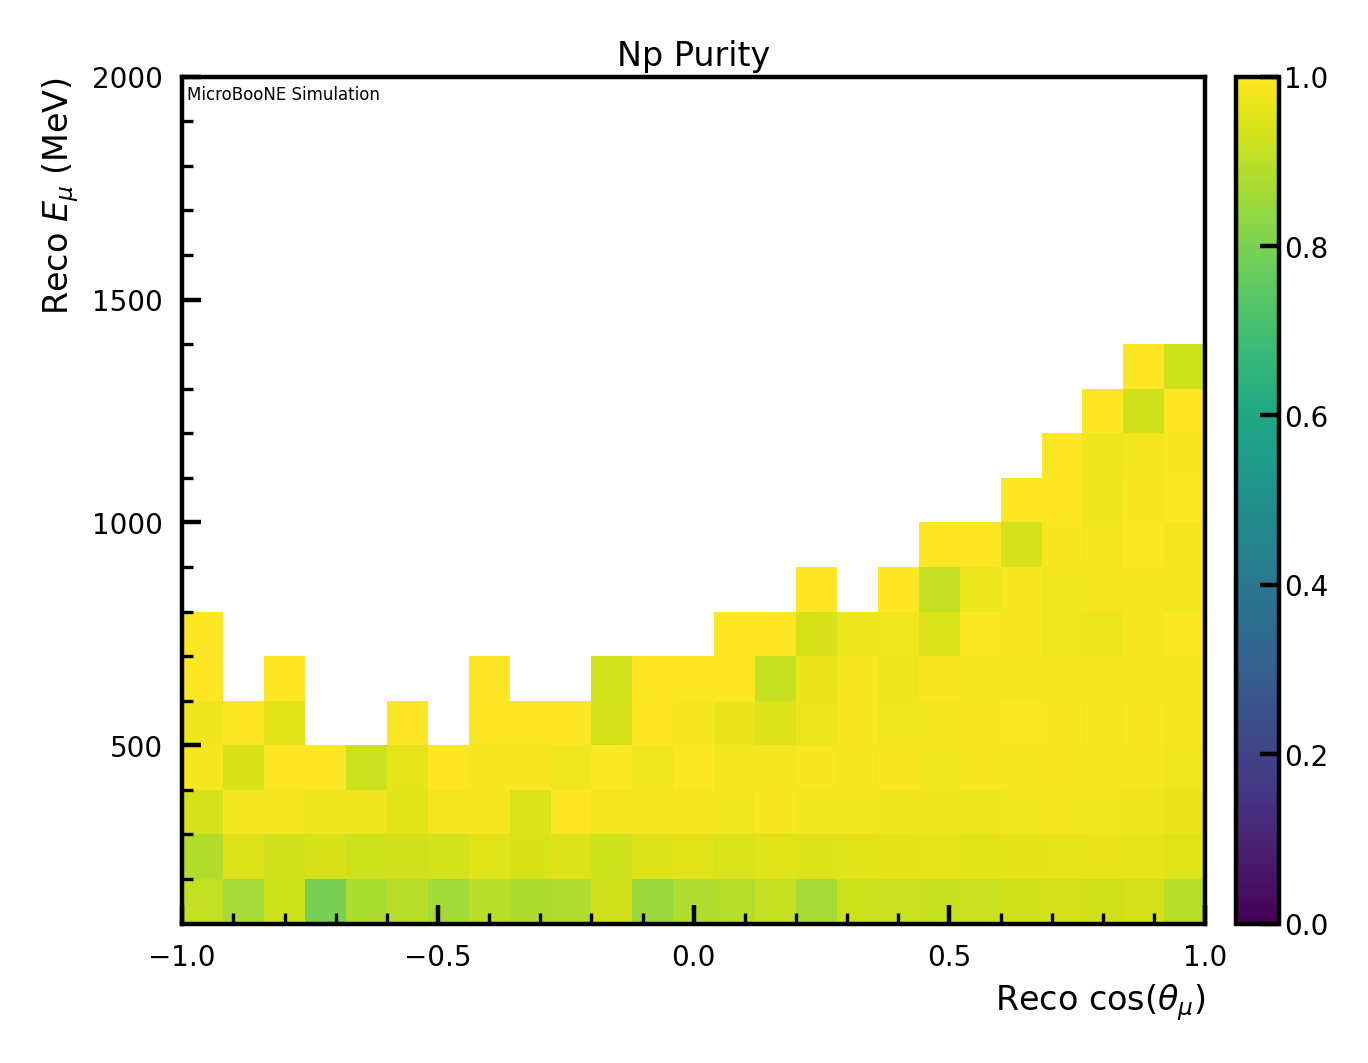

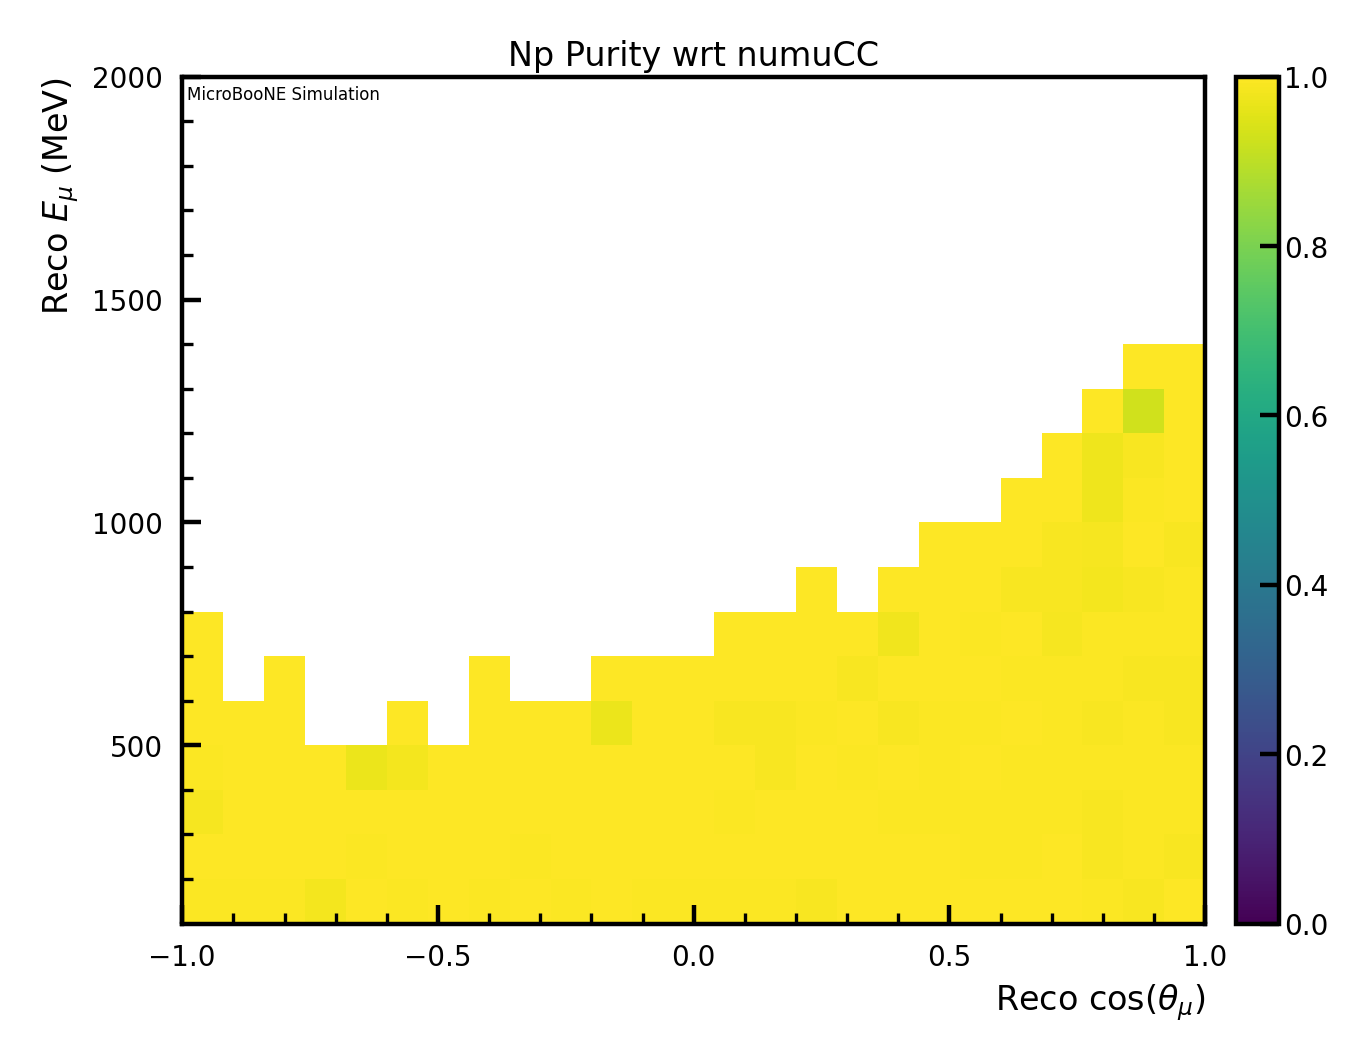

Xp case not coded yet


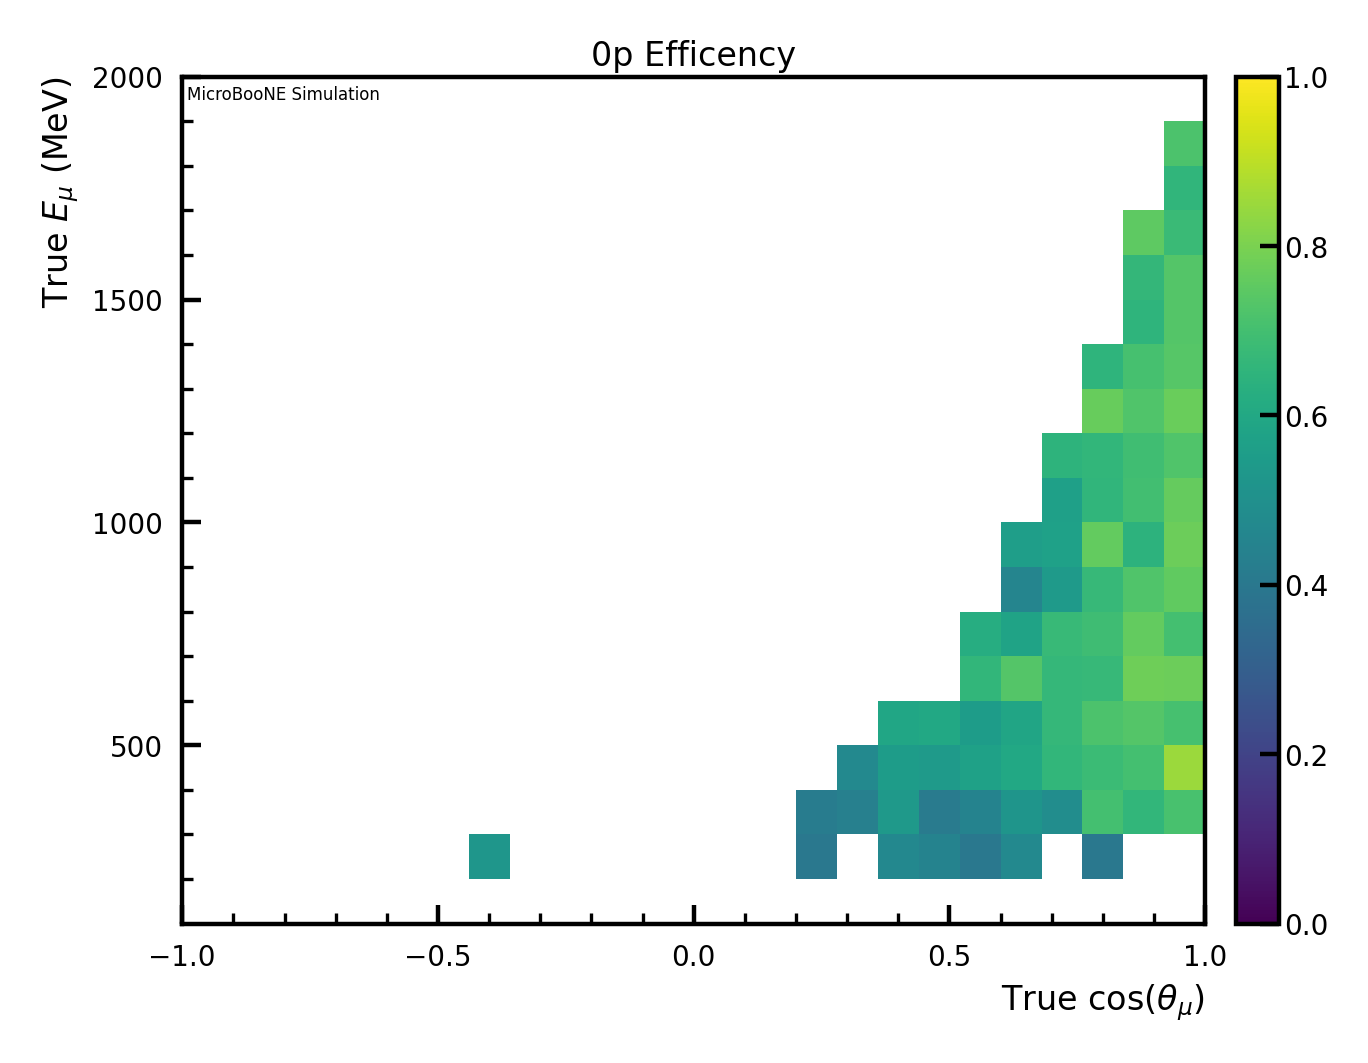

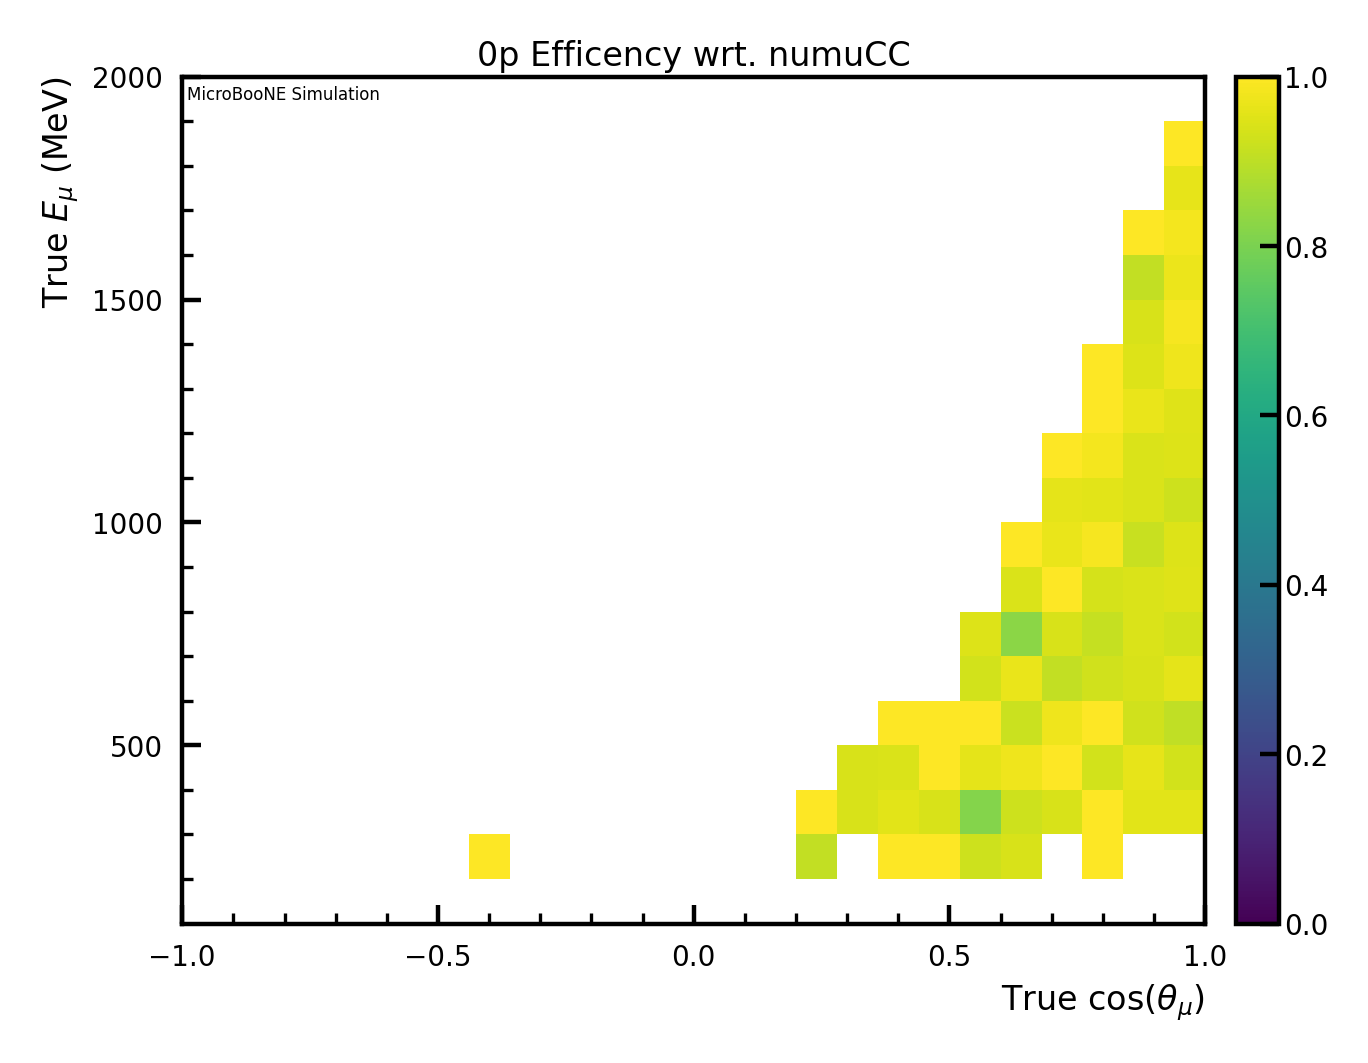

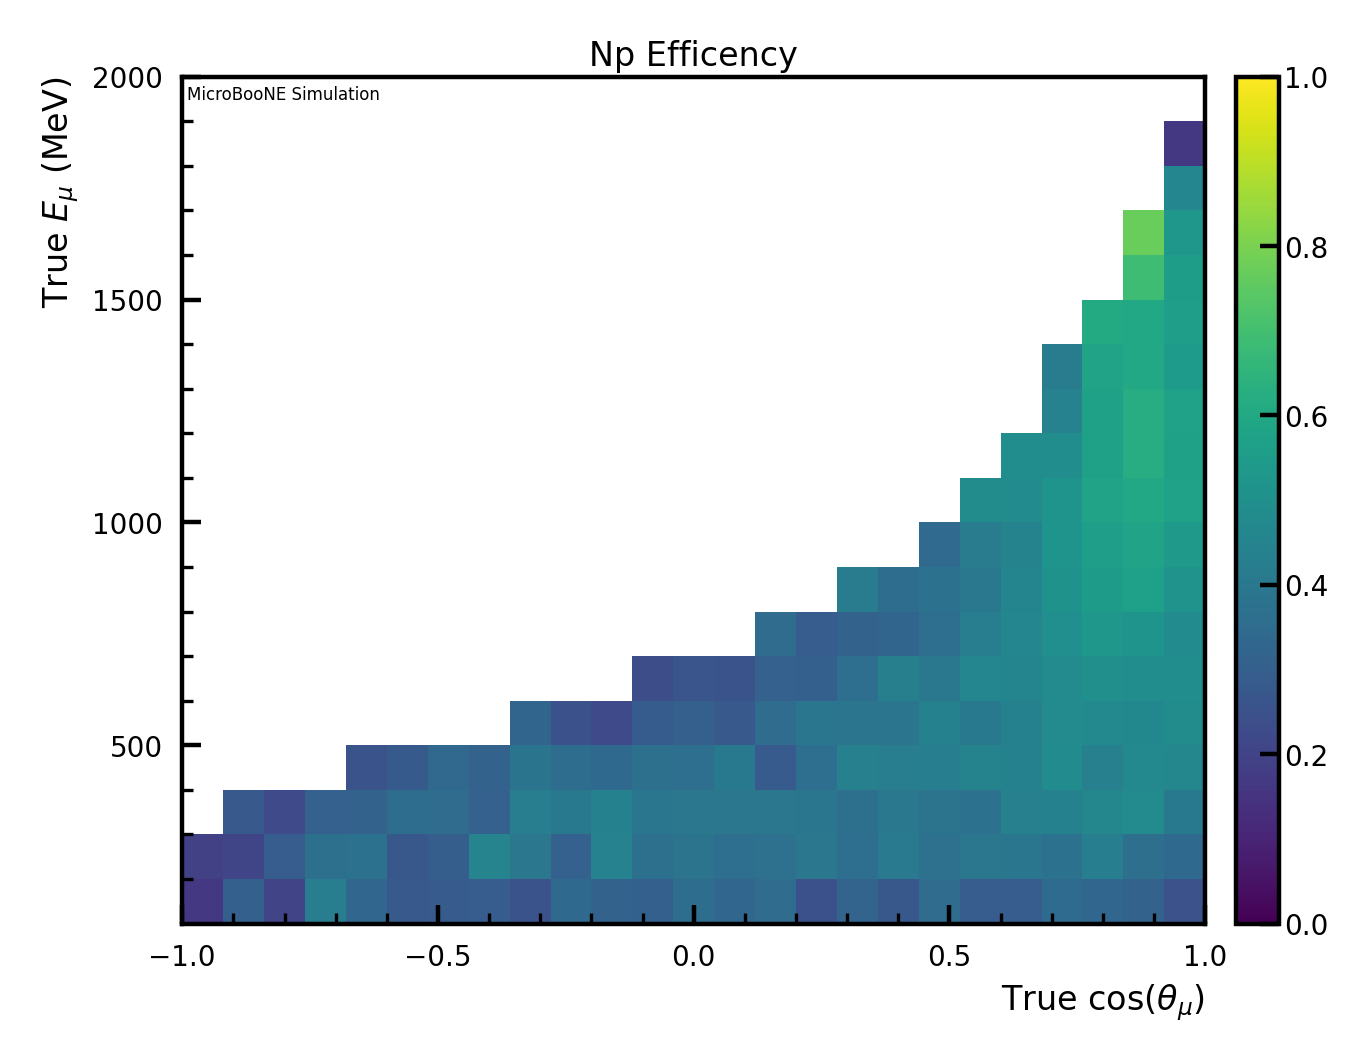

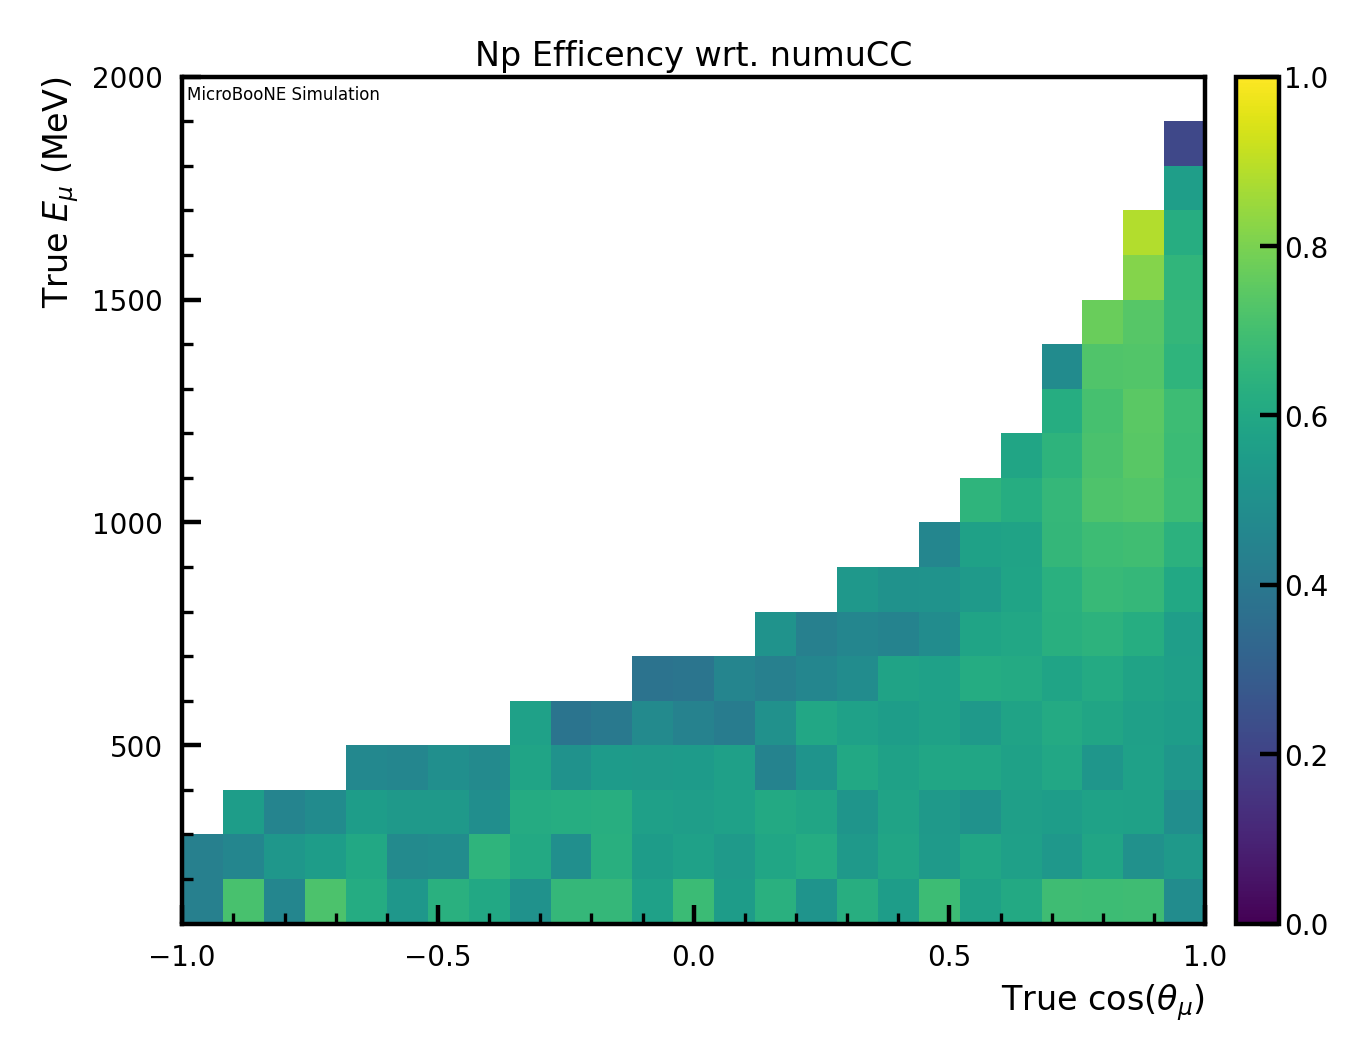

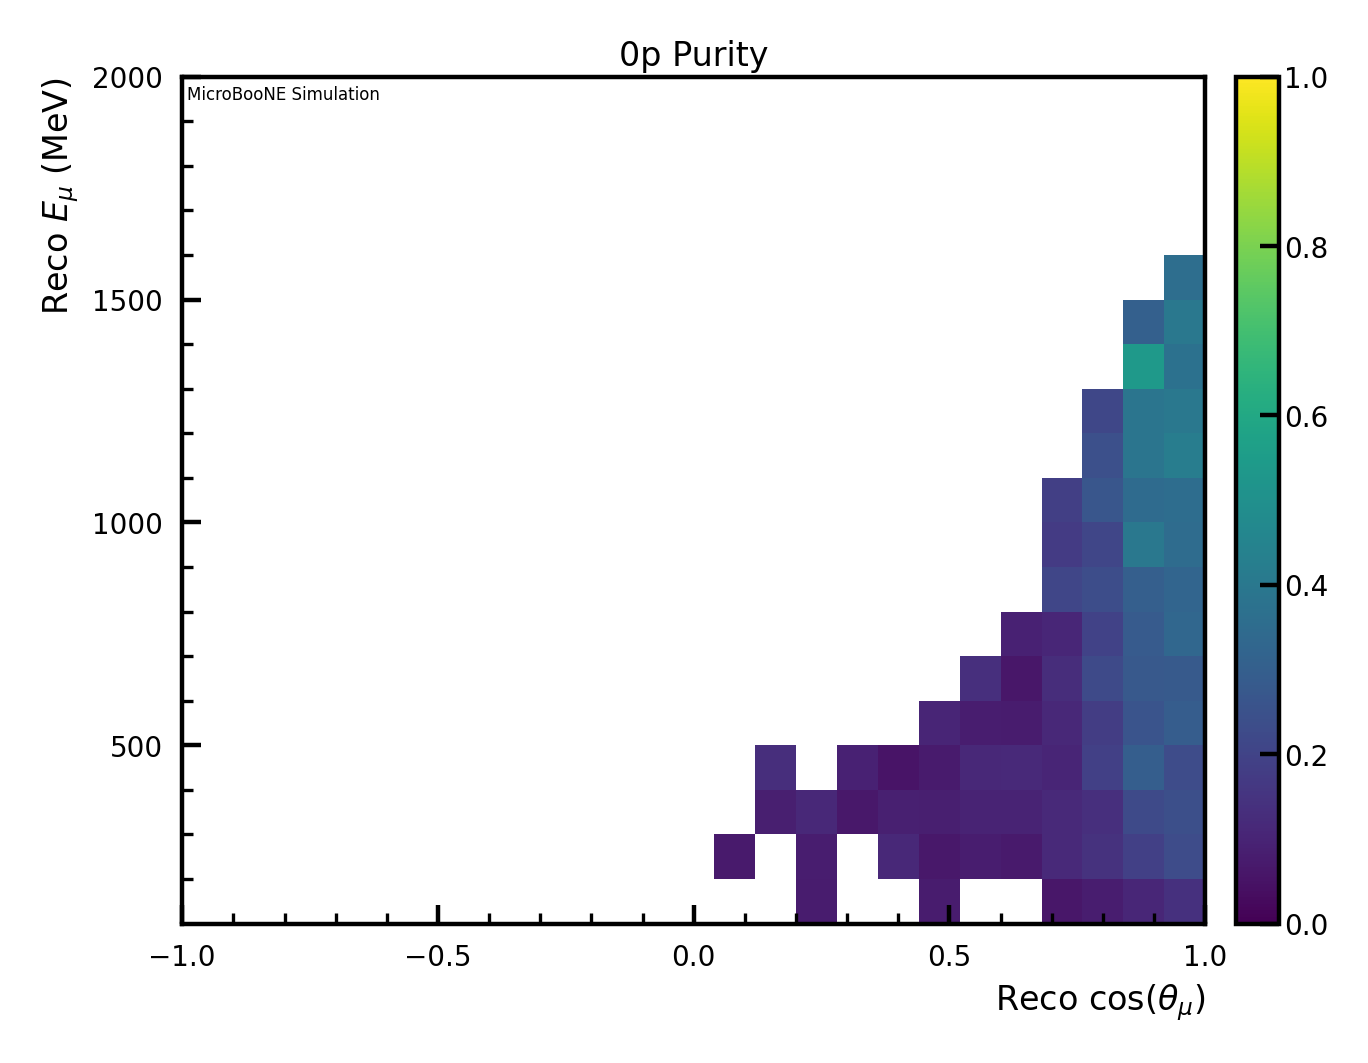

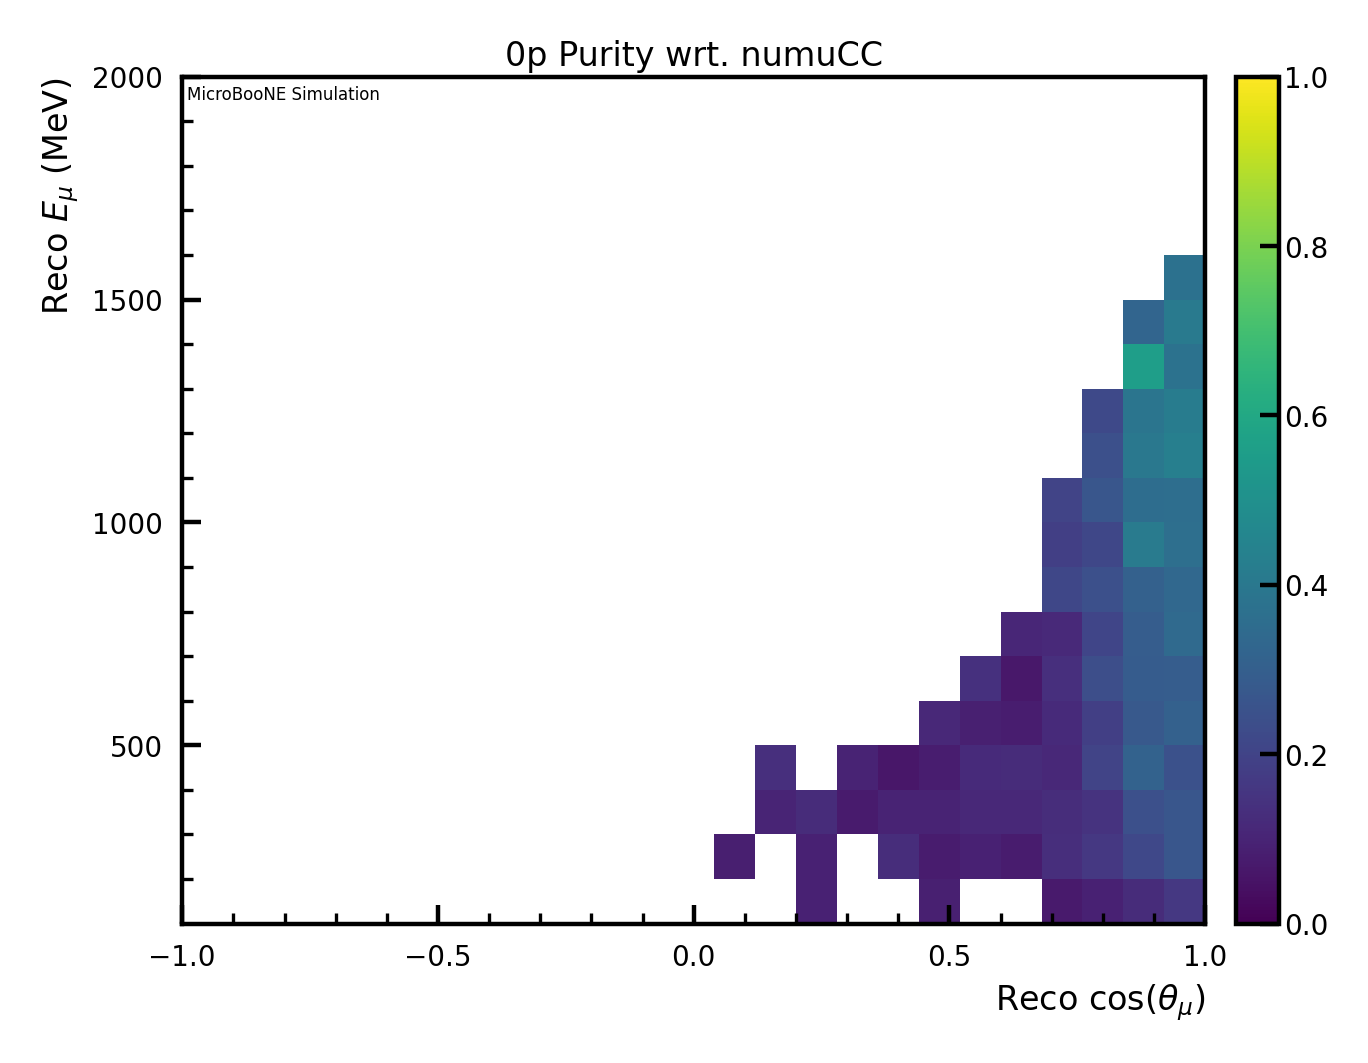

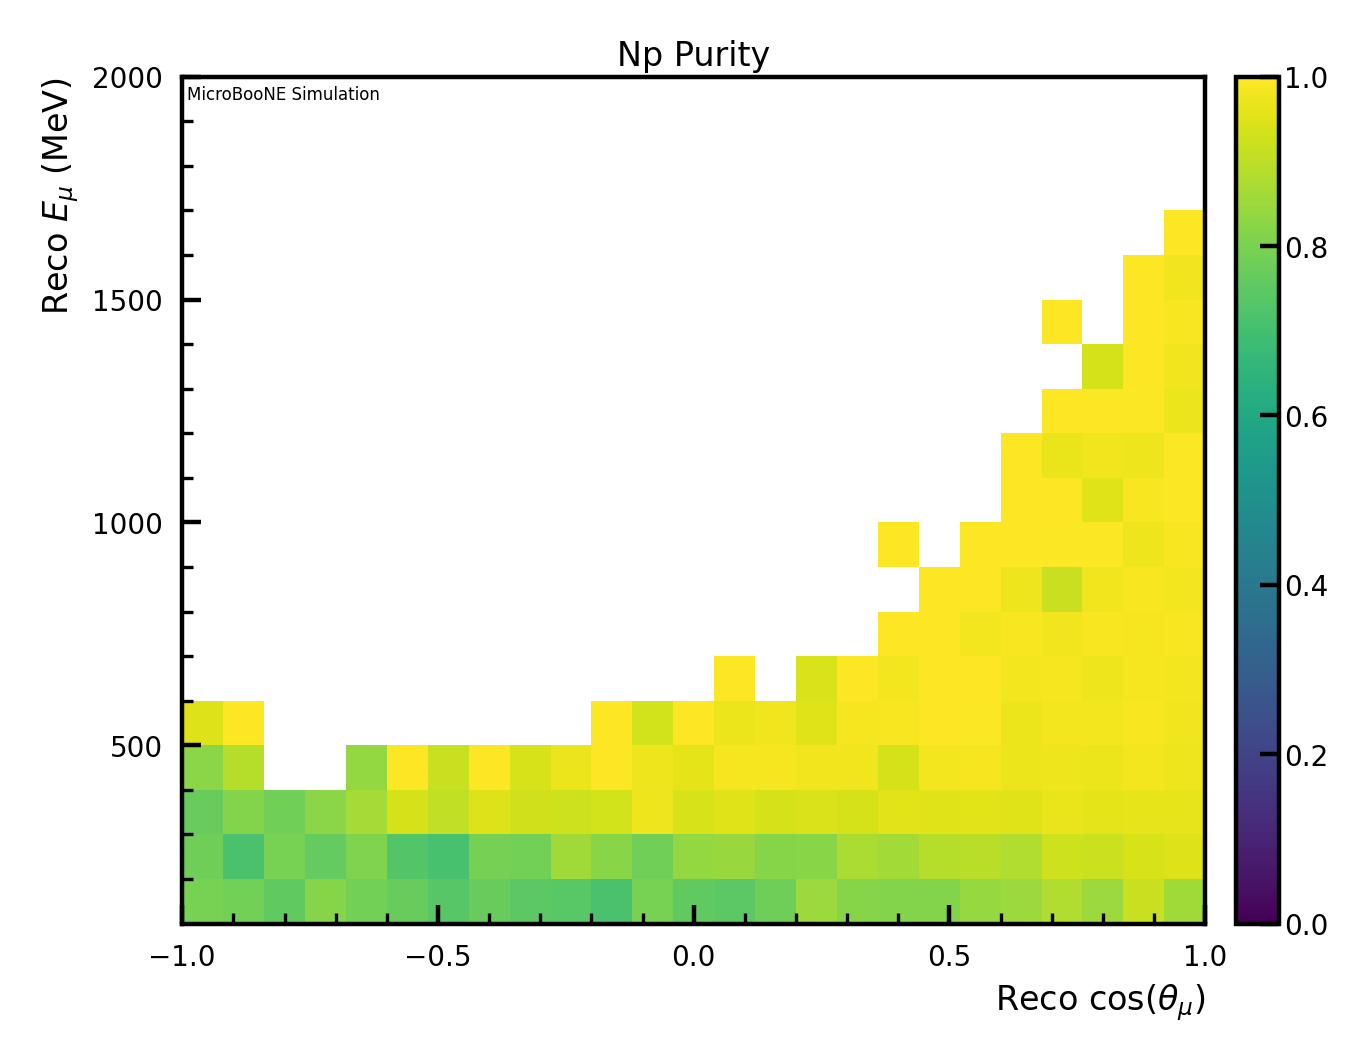

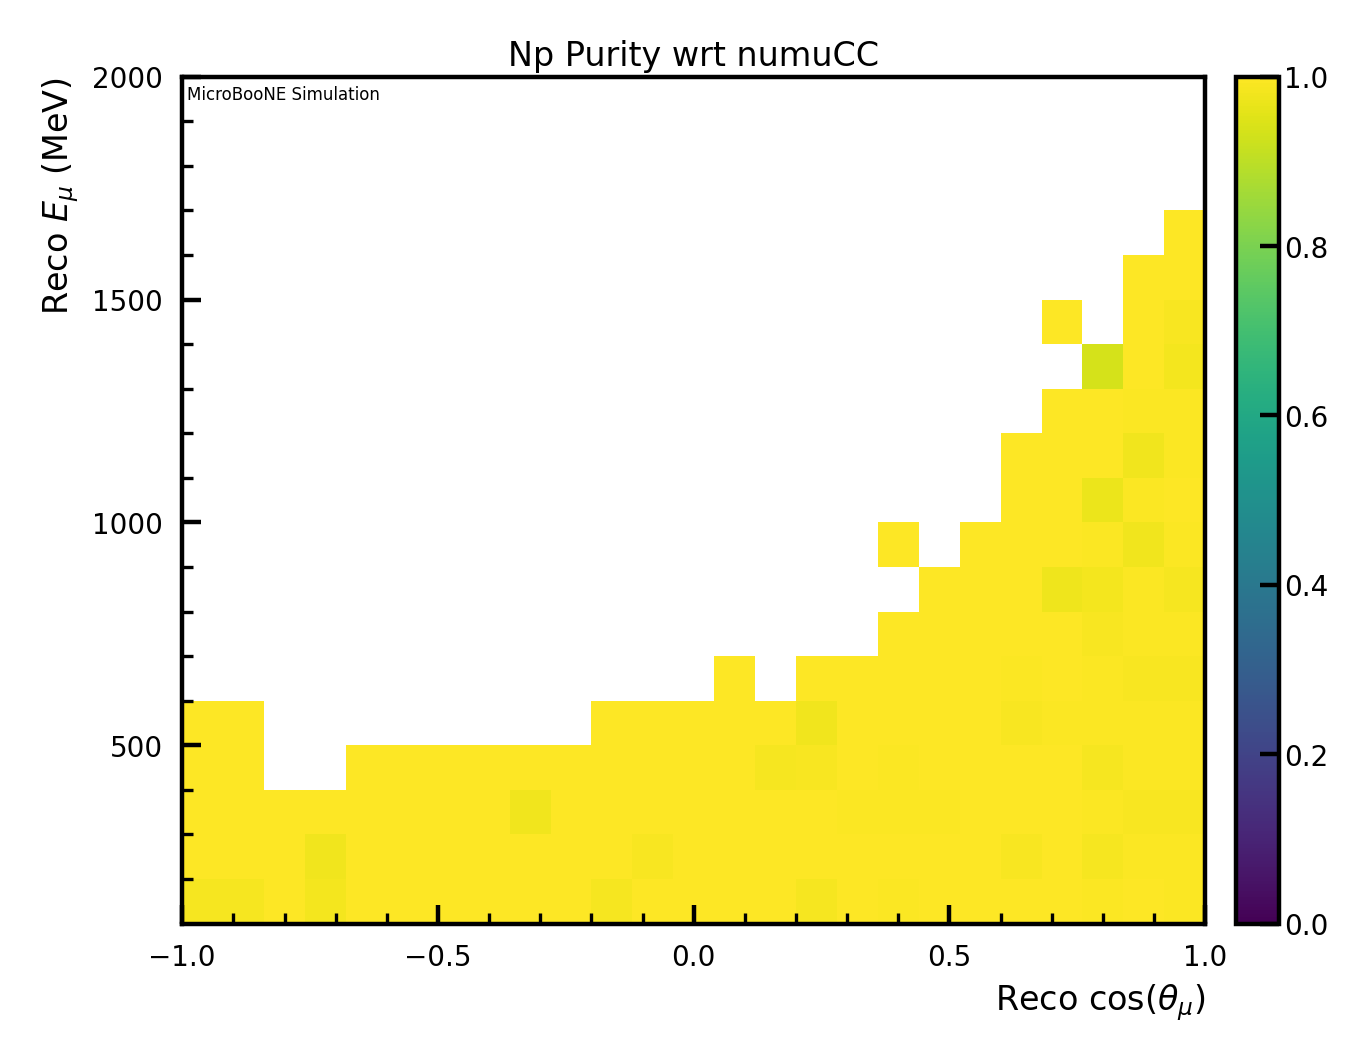

Xp case not coded yet


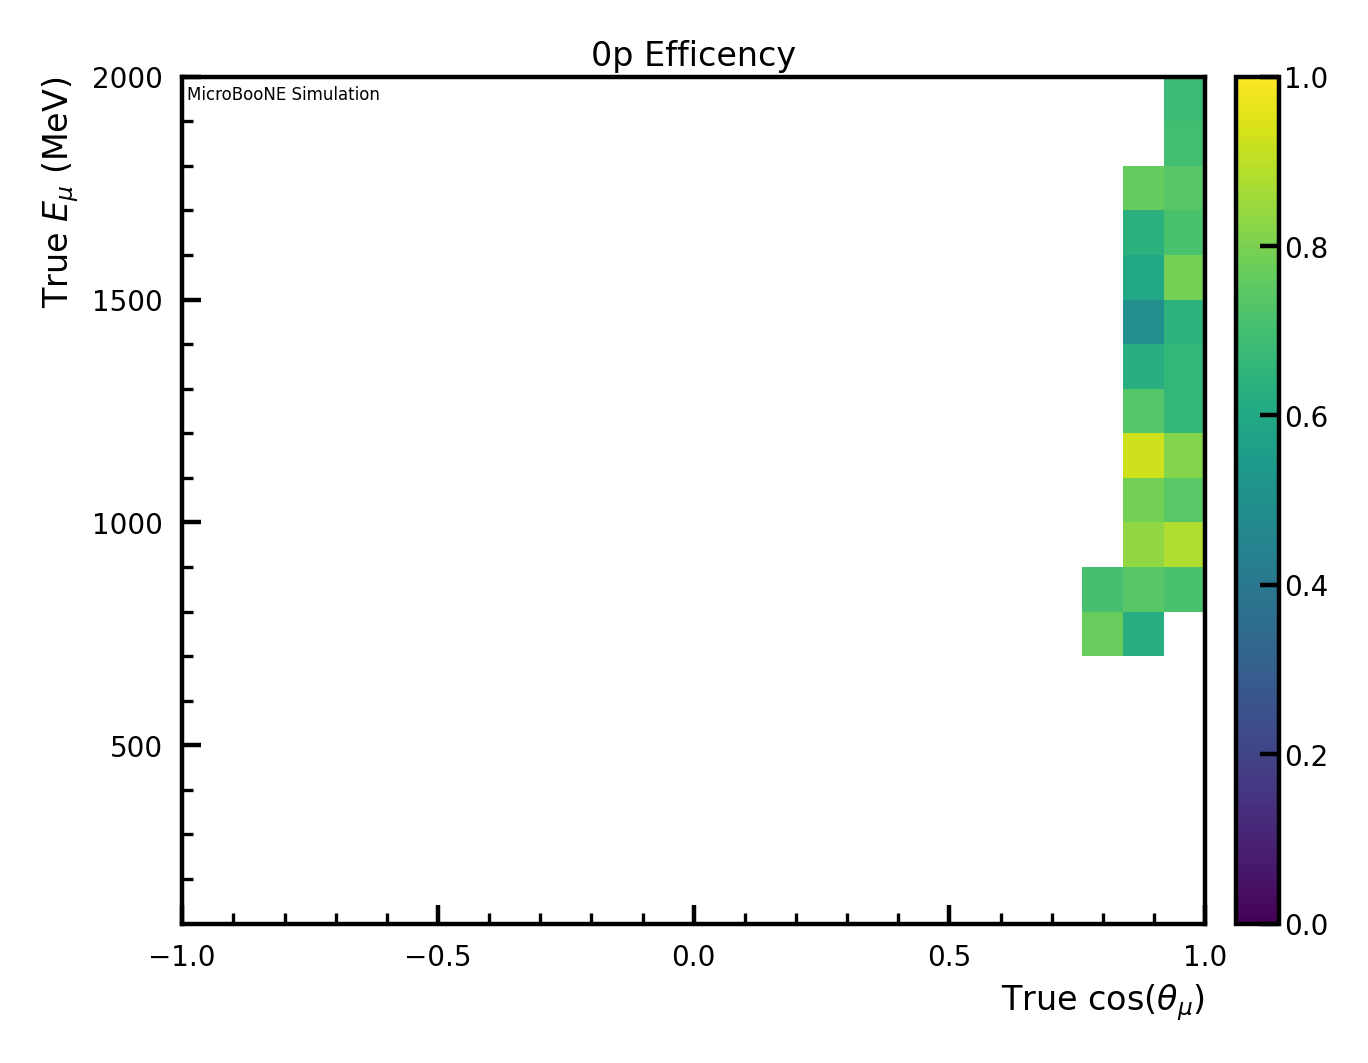

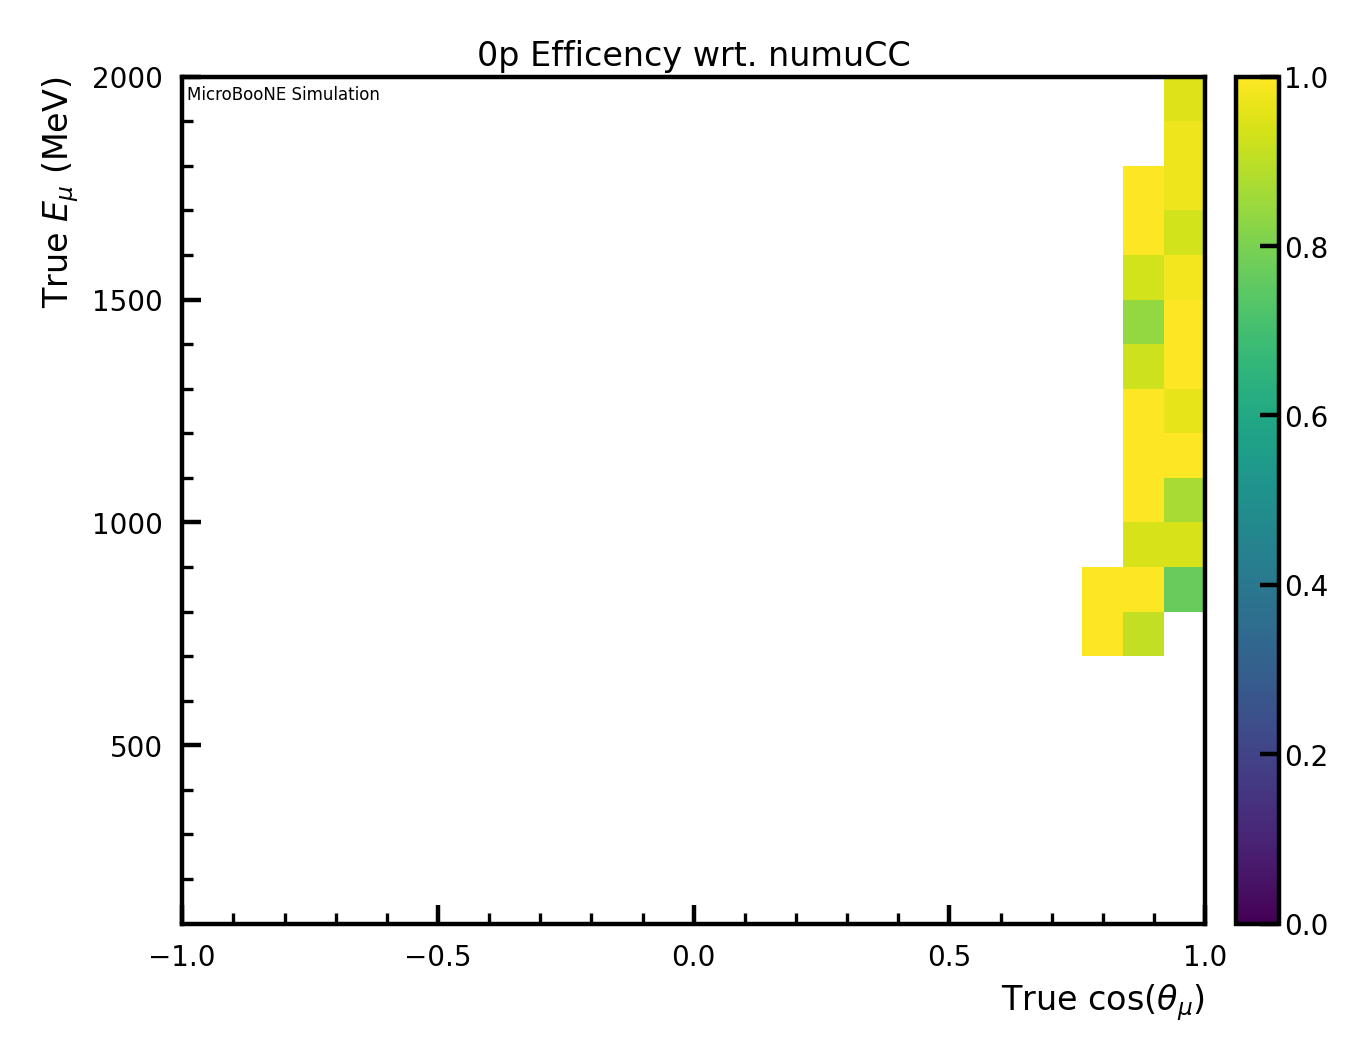

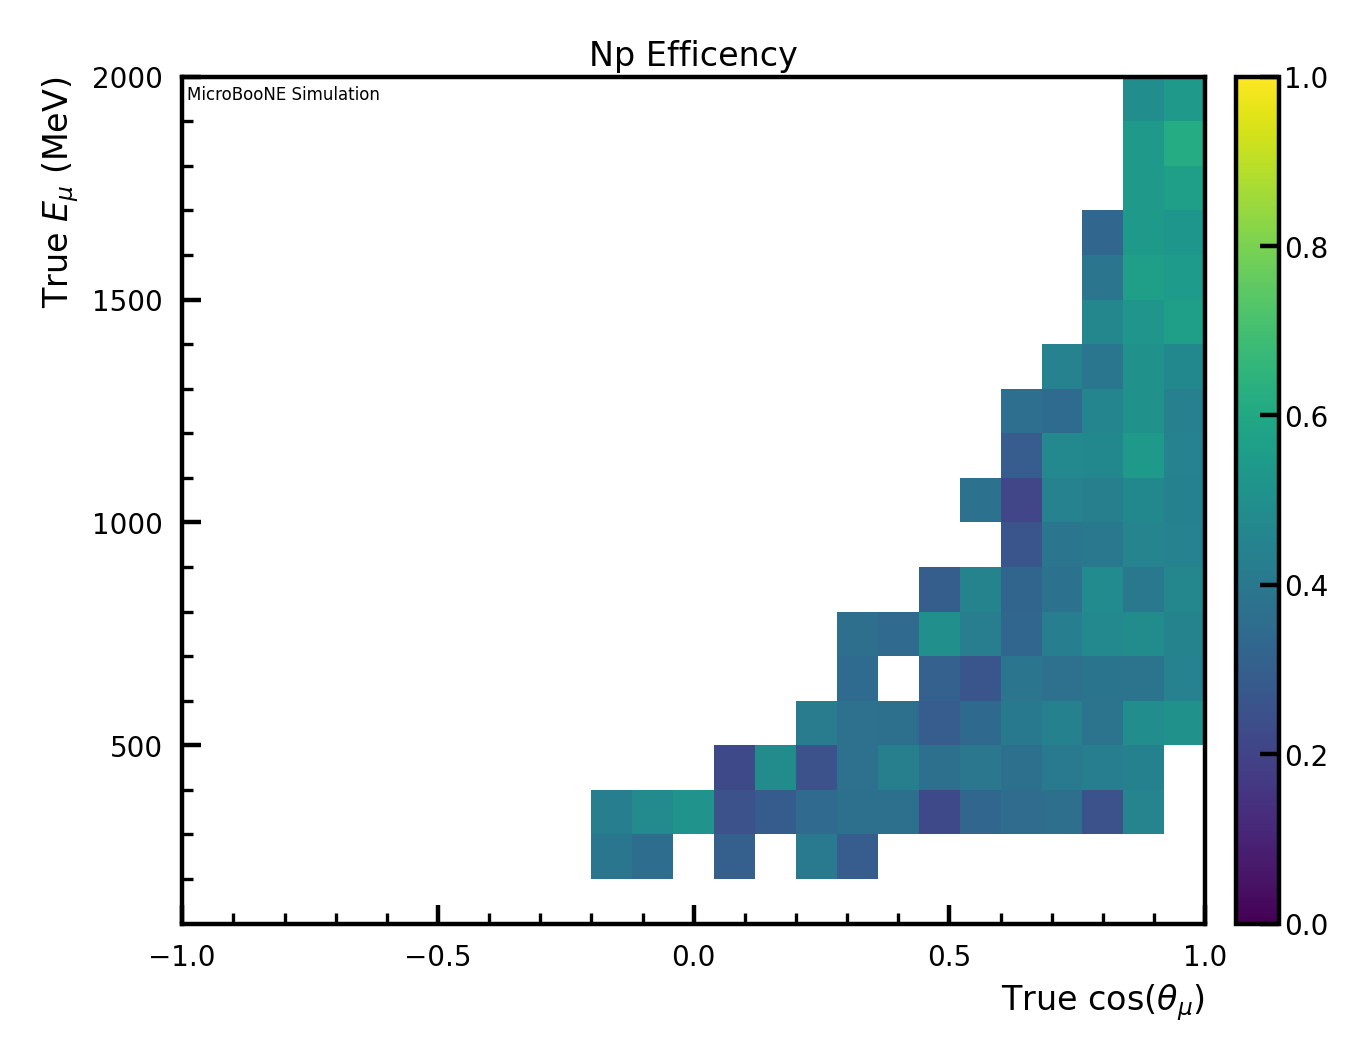

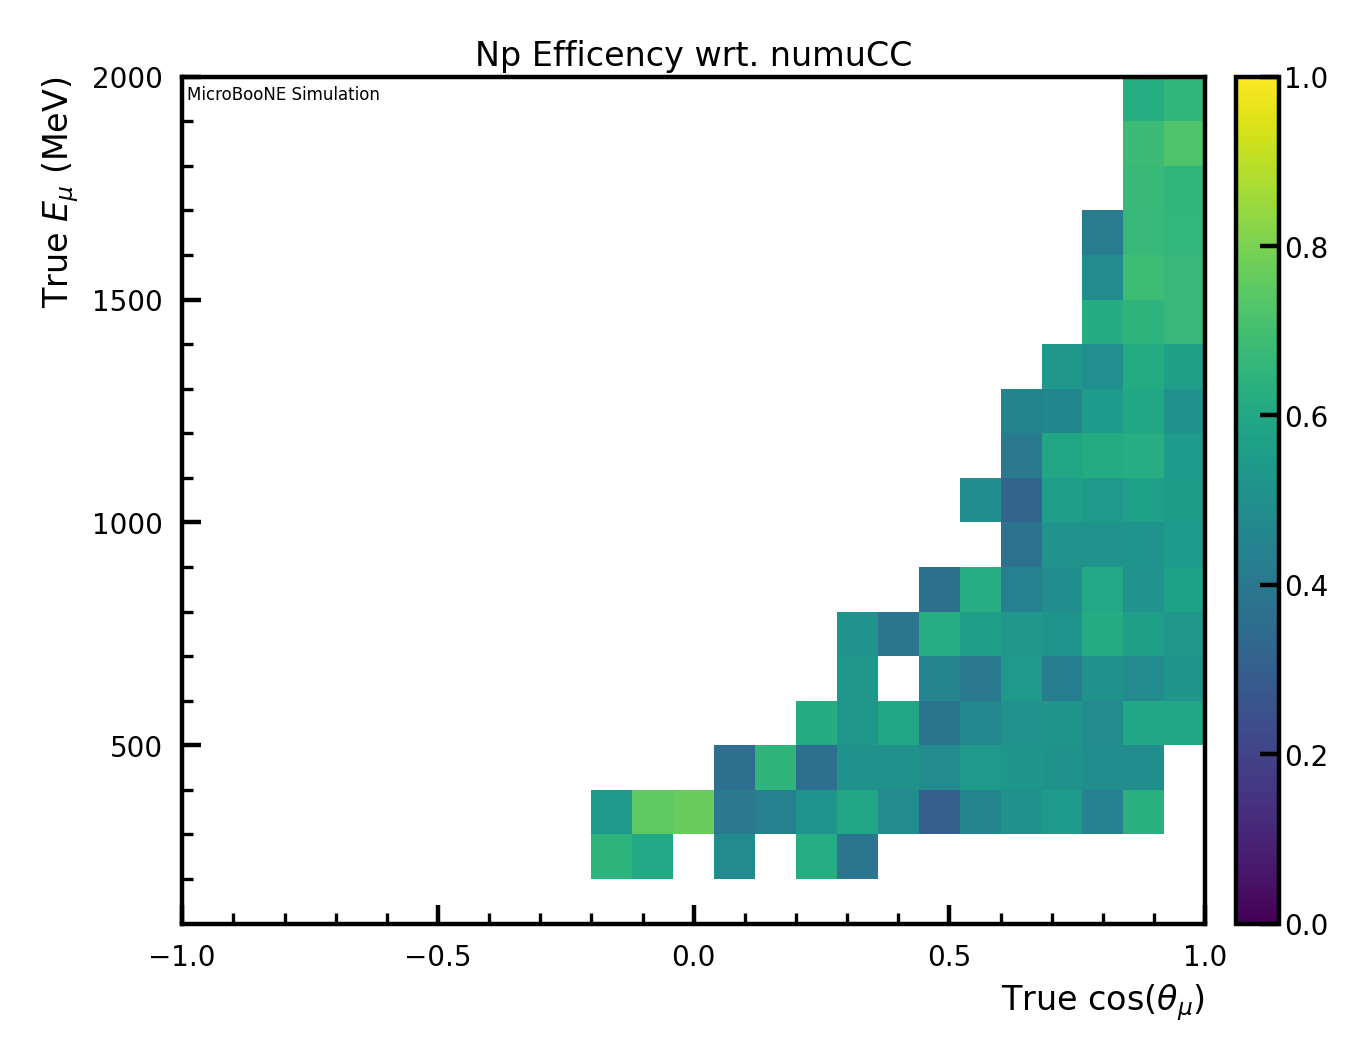

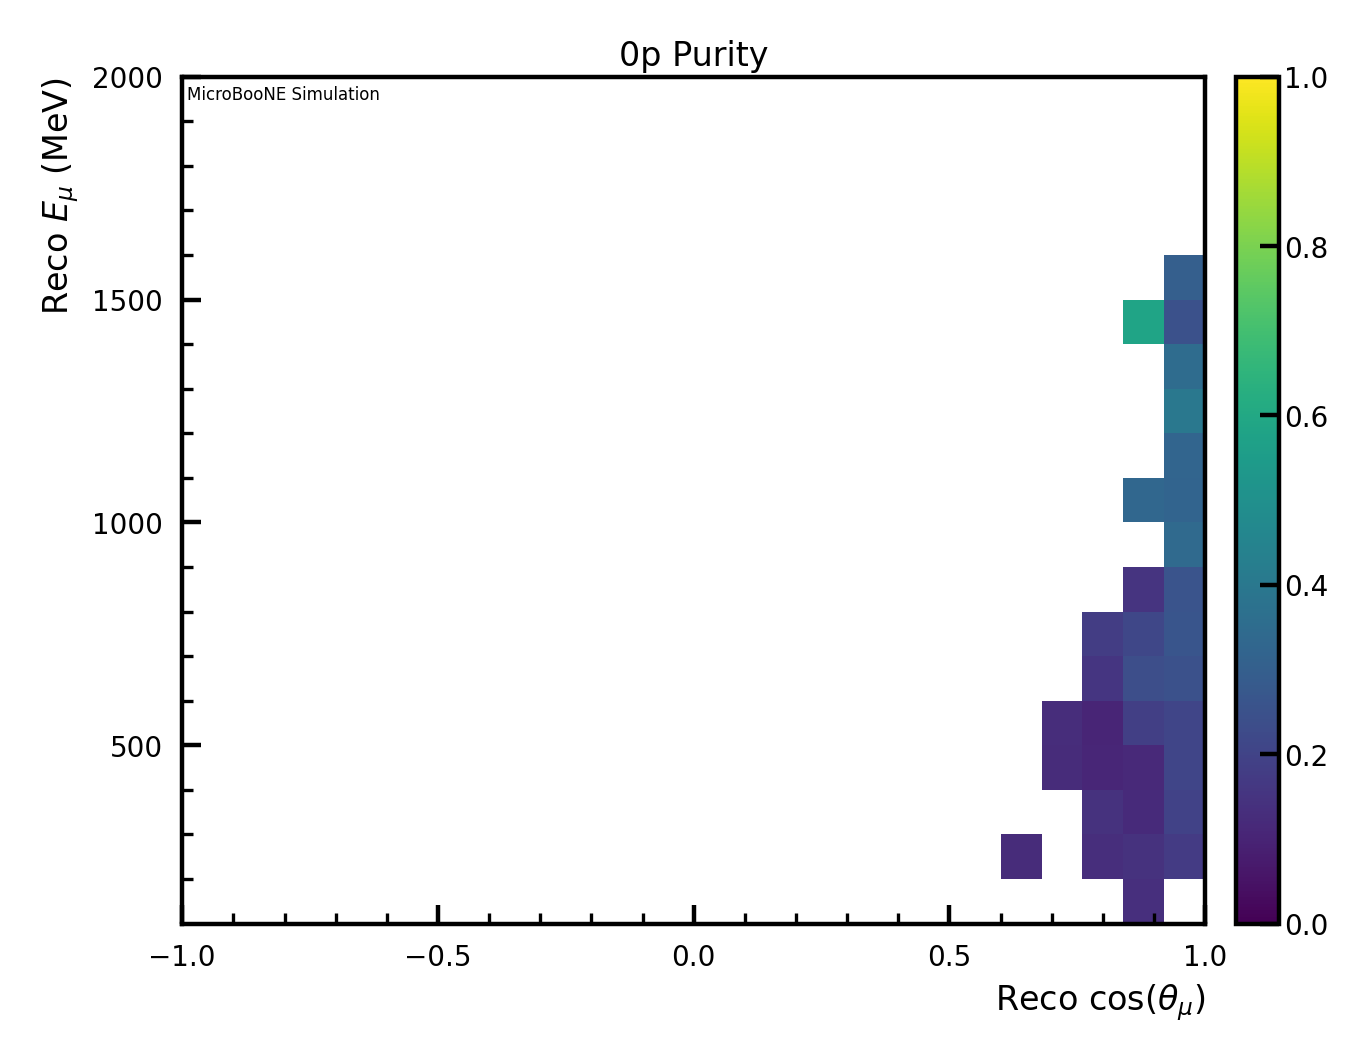

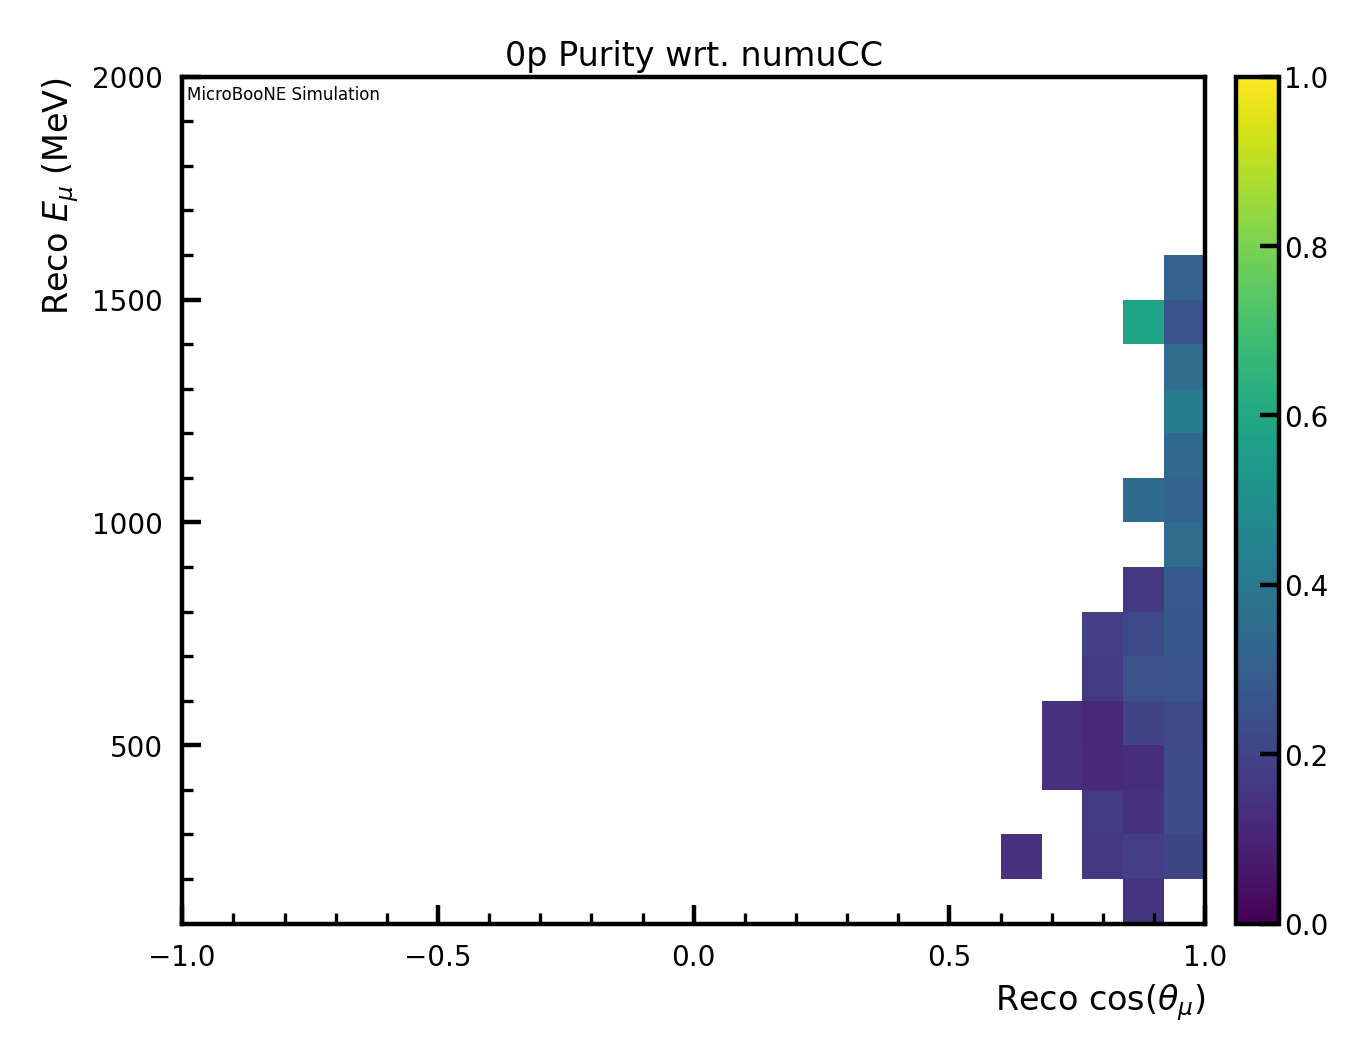

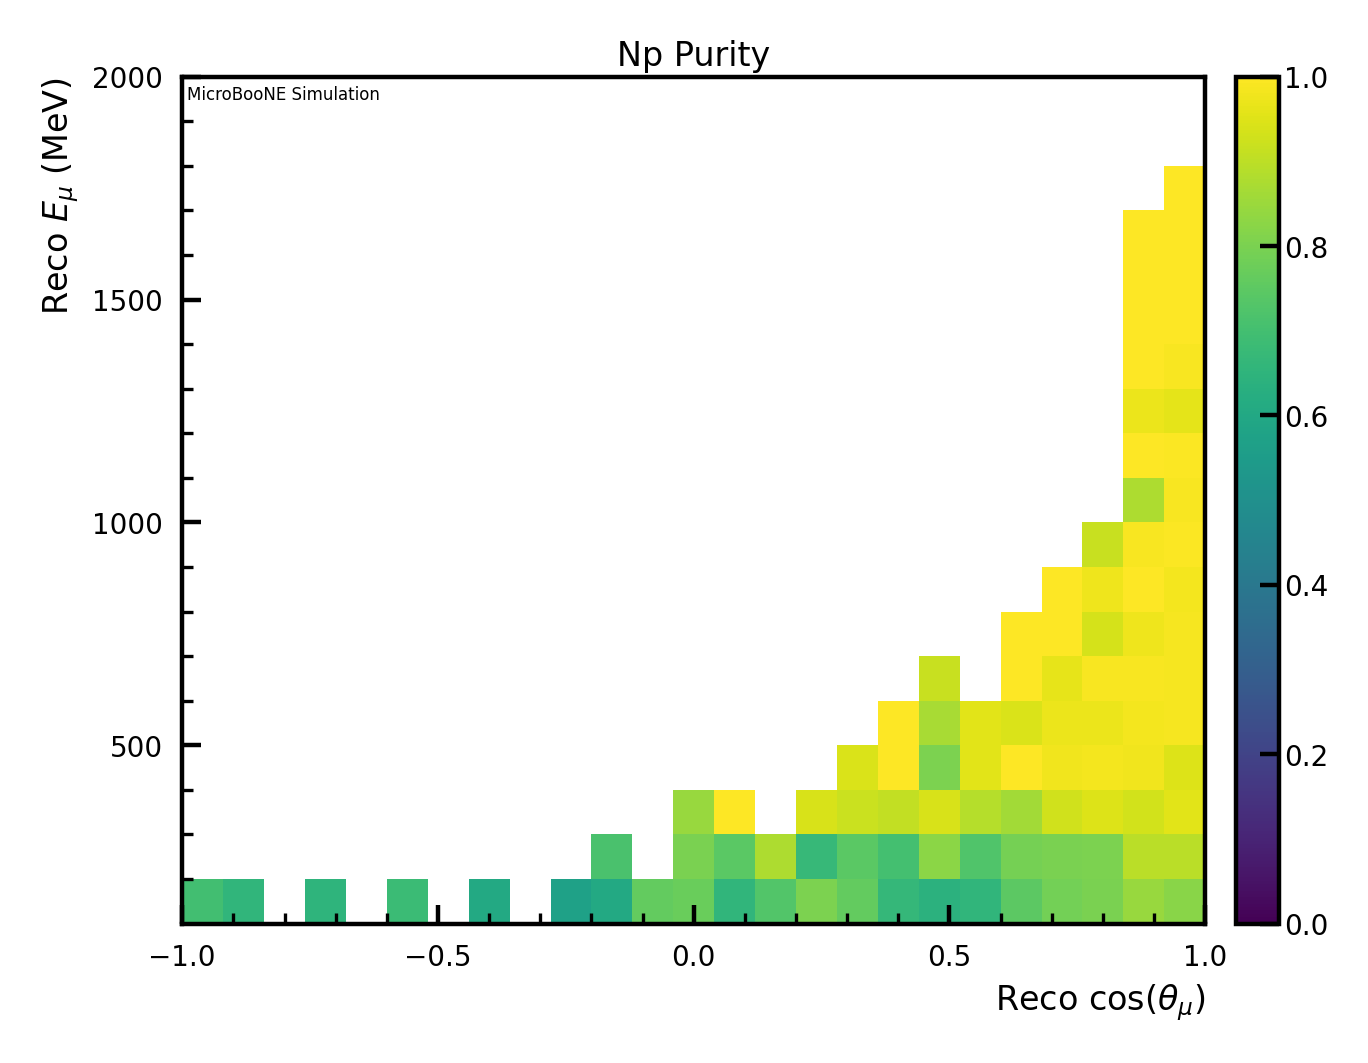

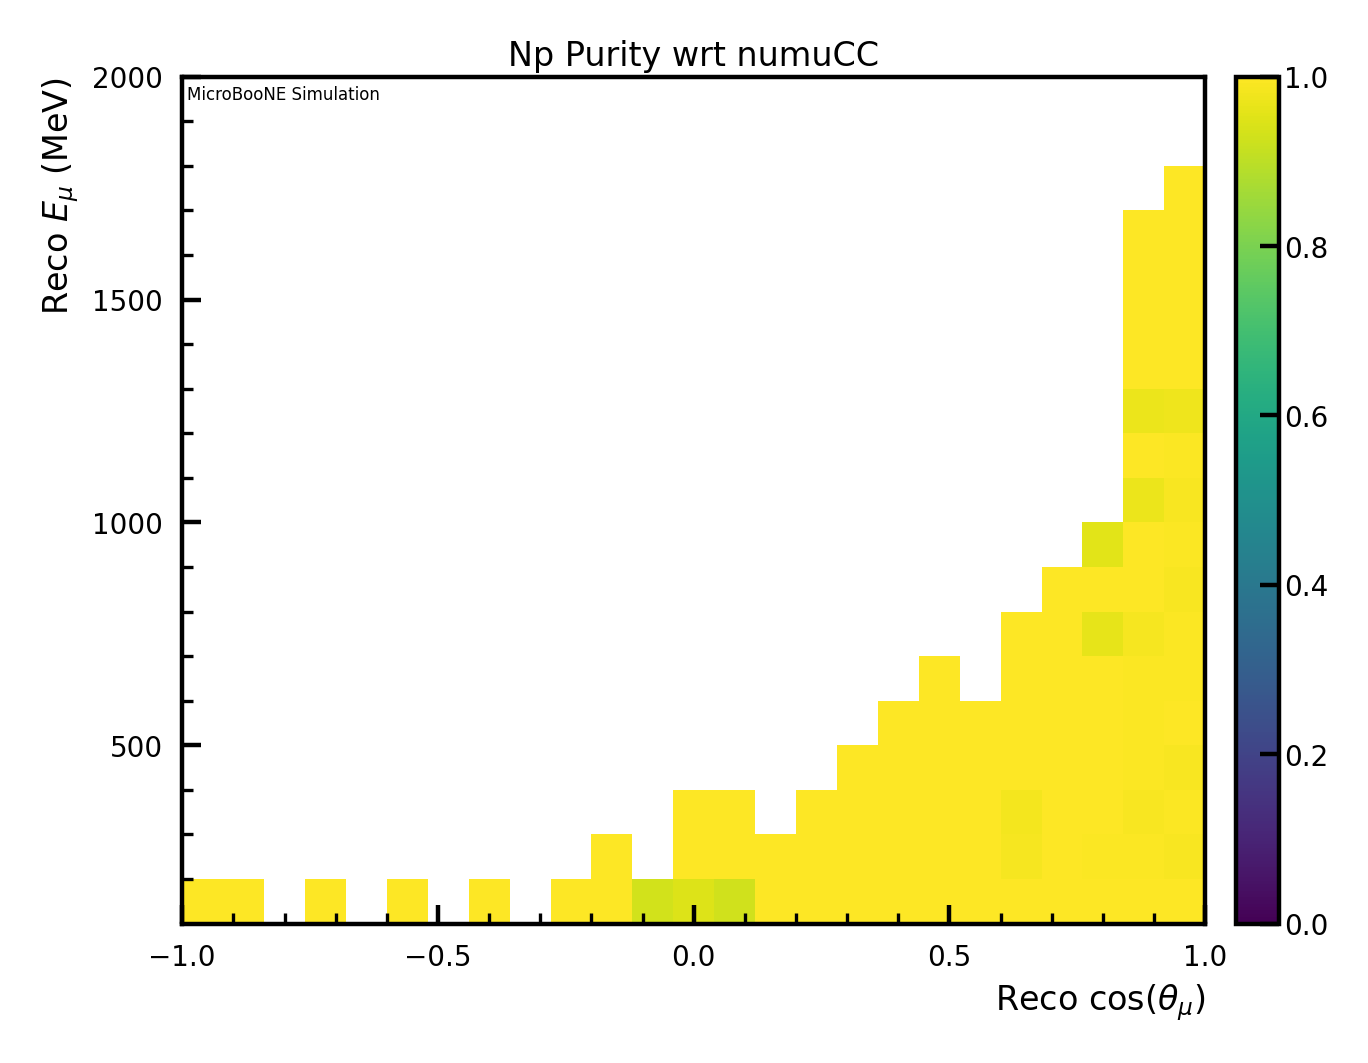

In [38]:
eff_pur_test3d(["truth_muon_costheta","truth_Emuon","truth_nuEnergy"], [-1,100,200], [1,2000,2500], [25,19,4], ["reco_muon_costheta","reco_Emuon","kine_reco_Enu"], [-1,100,0], [1,2000,2500], [25,19,3], plot_Xp = True ,plot_0pNp = True, weight_var="net_weight", onlyNp=False, min_counts=10)


## Following code should be run in order to avaoid bugs

The two blocks below give you the 0pNp 2x2 matrix that shows the migration between the two channel. This is done both "wrt to the inclusive selection" and "wrt to signal before selection". 

In [32]:
#Modify these as desired
rth = 35
th = 35
reweight = False

reco_E = "reco_prim_p_energy"
truth_E = "truth_prim_p_energy"
reco_N = "reco_num_prim_proton"
truth_N = "truth_num_prim_proton"
############################################



sig_sel_df = all_df.query(sig_query).query(sel_query)
sig_sel_tEp = sig_sel_df[truth_E].to_numpy()
sig_sel_tnp = sig_sel_df[truth_N].to_numpy()
sig_sel_Ep = sig_sel_df[reco_E].to_numpy()
sig_sel_np = sig_sel_df[reco_N].to_numpy()

sig_df = all_df.query(sig_query)
sig_tEp = sig_df[truth_E].to_numpy()
sig_tnp = sig_df[truth_N].to_numpy()
sig_Ep = sig_df[reco_E].to_numpy()
sig_np = sig_df[reco_N].to_numpy()

sel_df = all_df.query(sel_query)
sel_tEp = sel_df[truth_E].to_numpy()
sel_tnp = sel_df[truth_N].to_numpy()
sel_Ep = sel_df[reco_E].to_numpy()
sel_np = sel_df[reco_N].to_numpy()

n_sel_sig_events = len(sig_sel_np)
n_sel_events = len(sel_np)
n_sig_events = len(sig_np)

R = np.array([[0,0],[0,0]])
x = [0,1,2]
y = [0,1,2]

weights = sig_sel_df["weight_cv"].to_numpy()*sig_sel_df["weight_spline"].to_numpy()
weights_sel = sel_df["weight_cv"].to_numpy()*sel_df["weight_spline"].to_numpy()
weights_sig = sig_df["weight_cv"].to_numpy()*sig_df["weight_spline"].to_numpy()
if reweight: 
    weights = weights*sig_sel_df["reweight"].to_numpy()
    weights_sel = weights_sel*sel_df["reweight"].to_numpy()
    weights_sig = weights_sig*sig_df["reweight"].to_numpy()

for event in range(n_sel_sig_events):
    tbin = 0
    rbin = 0
    tnp = sig_sel_tnp[event]
    rnp = sig_sel_np[event]
    tEp = sig_sel_tEp[event]
    rEp = sig_sel_Ep[event]
    weight = np.nan_to_num(weights[event])
    if rEp >= rth and rnp > 0: rbin = 1
    #if tEp >= th and tnp > 0: tbin = 1
    if tEp >= th: tbin = 1
    R[rbin][tbin] += weight
    
sel = np.array([0,0])

for event in range(n_sel_events):
    rbin = 0
    rnp = sel_np[event]
    rEp = sel_Ep[event]
    weight = np.nan_to_num(weights_sel[event])
    if rEp >= rth and rnp > 0: rbin = 1
    sel[rbin] += weight
    
sig = np.array([0,0])

for event in range(n_sig_events):
    tbin = 0
    tnp = sig_tnp[event]
    tEp = sig_tEp[event]
    weight = np.nan_to_num(weights_sig[event])
    #if tEp >= th and tnp > 0: tbin = 1
    if tEp >= th: tbin = 1
    sig[tbin] += weight
    


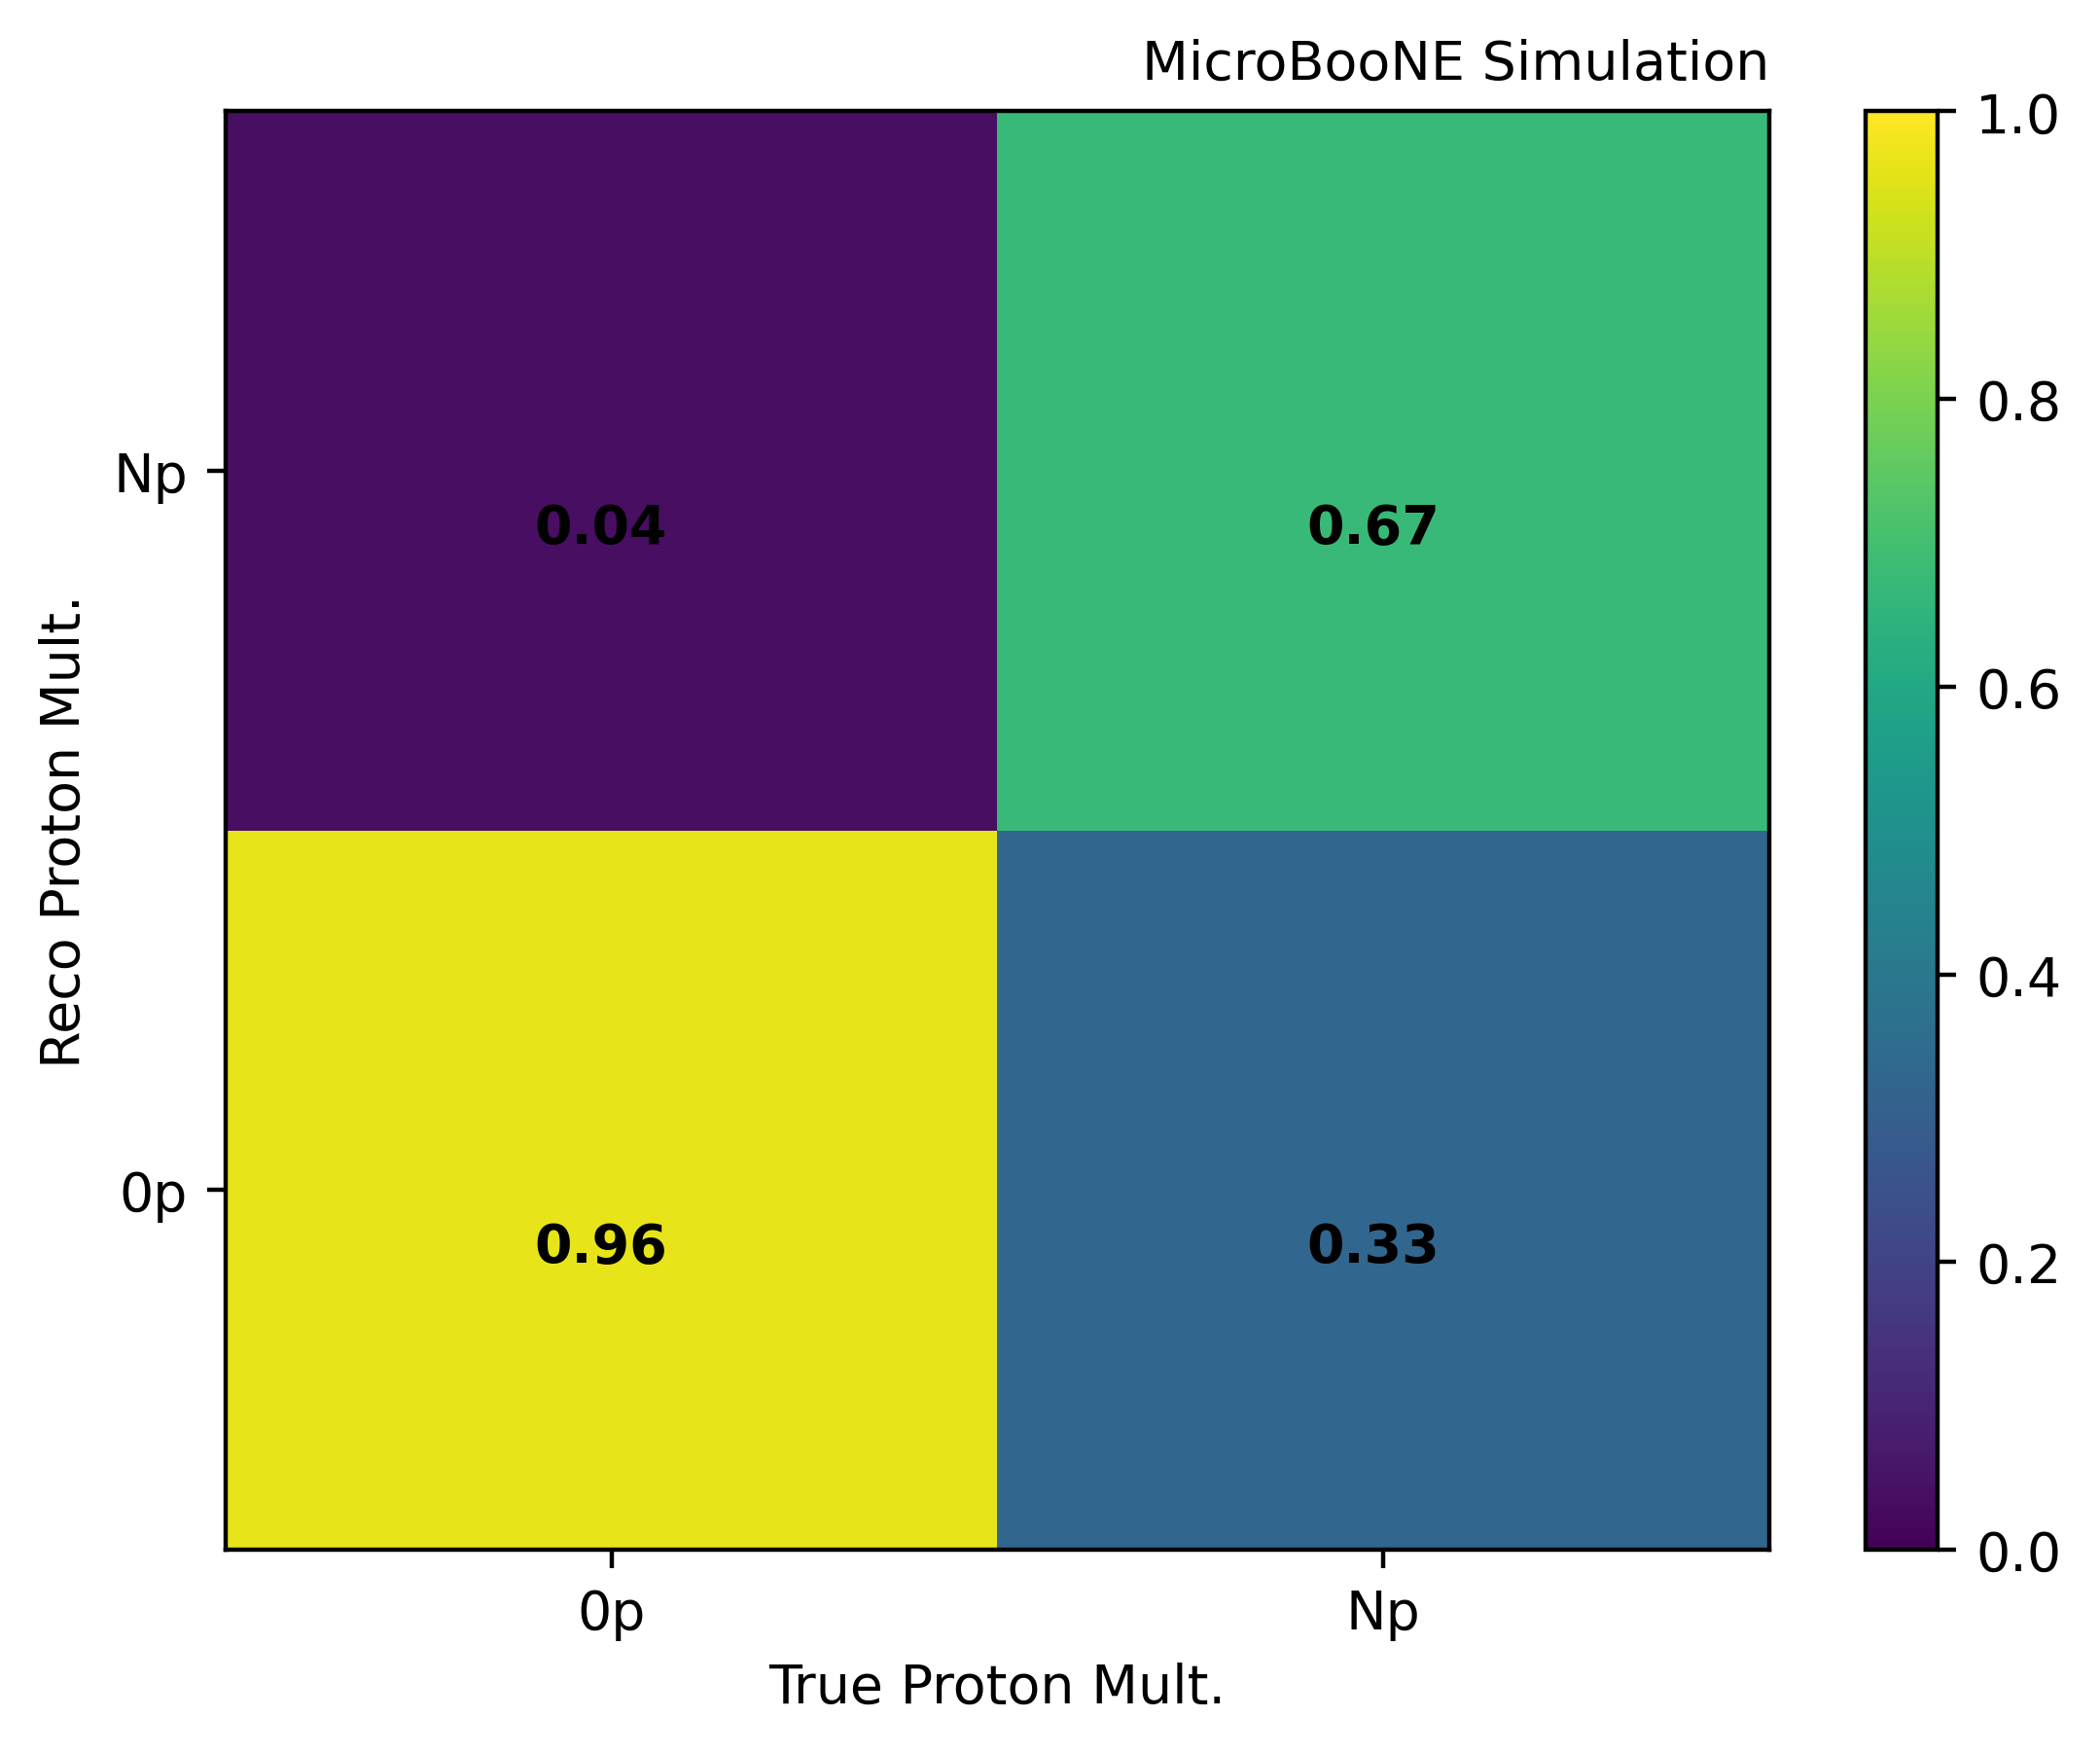

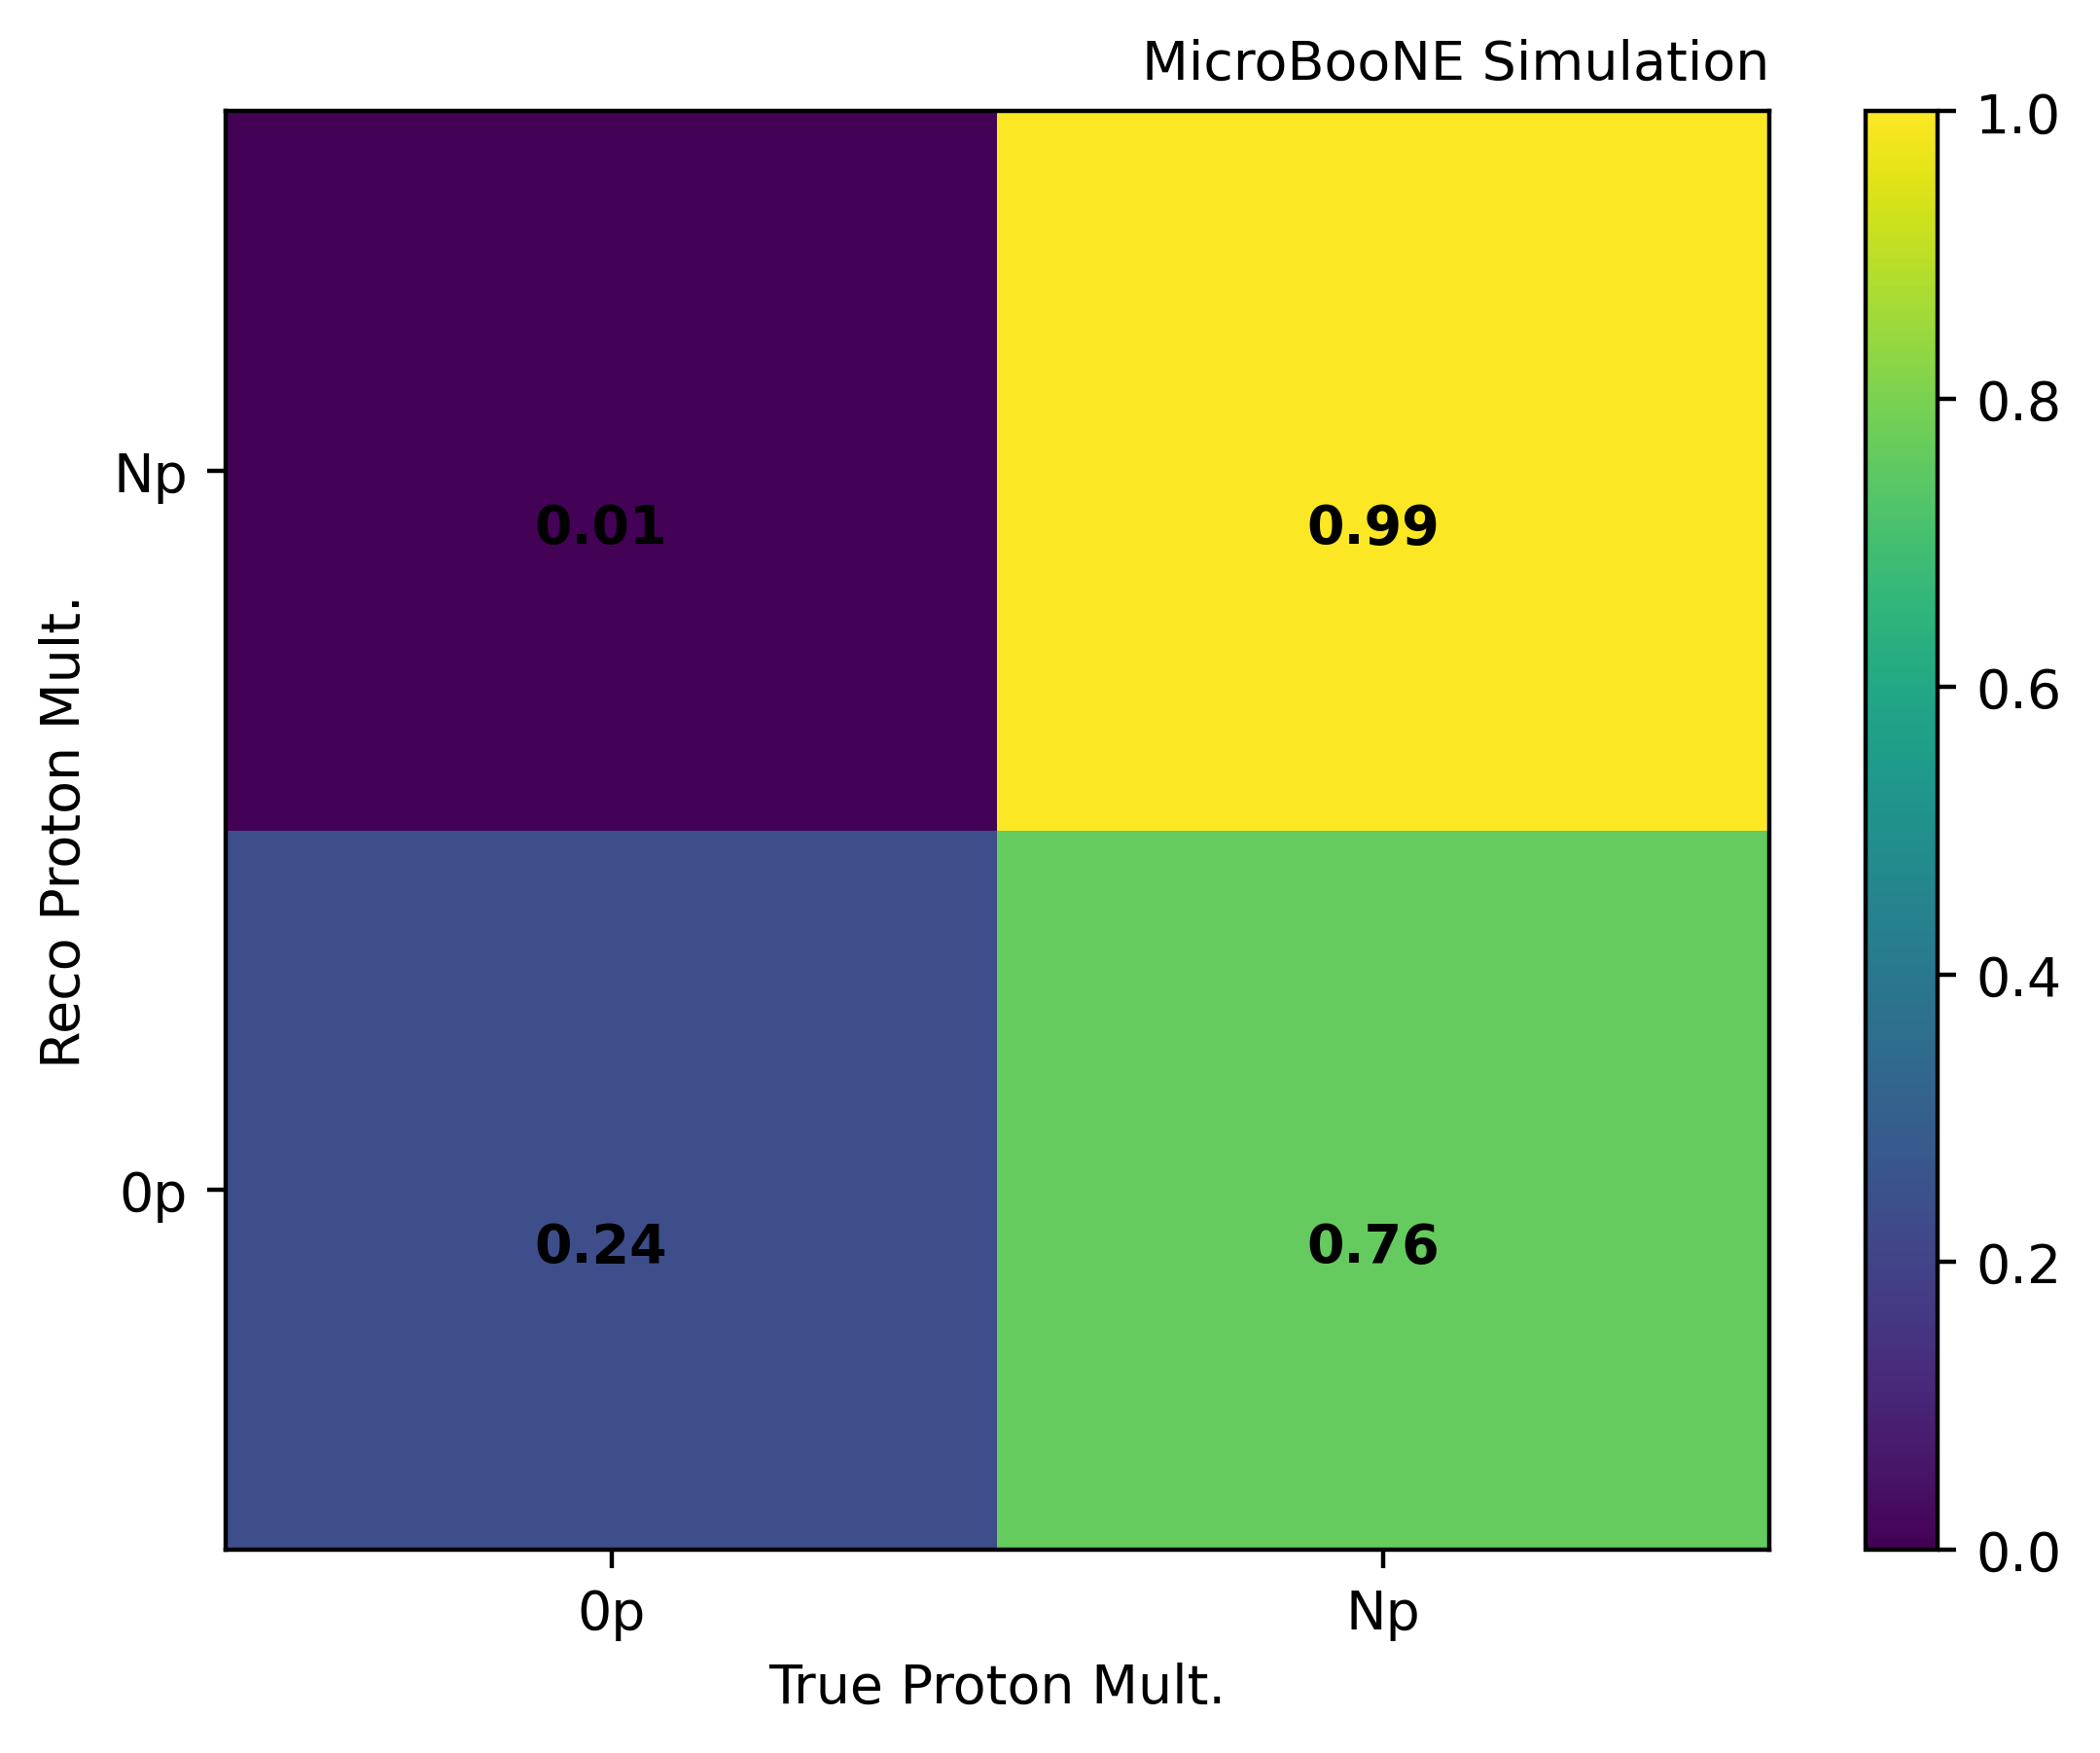

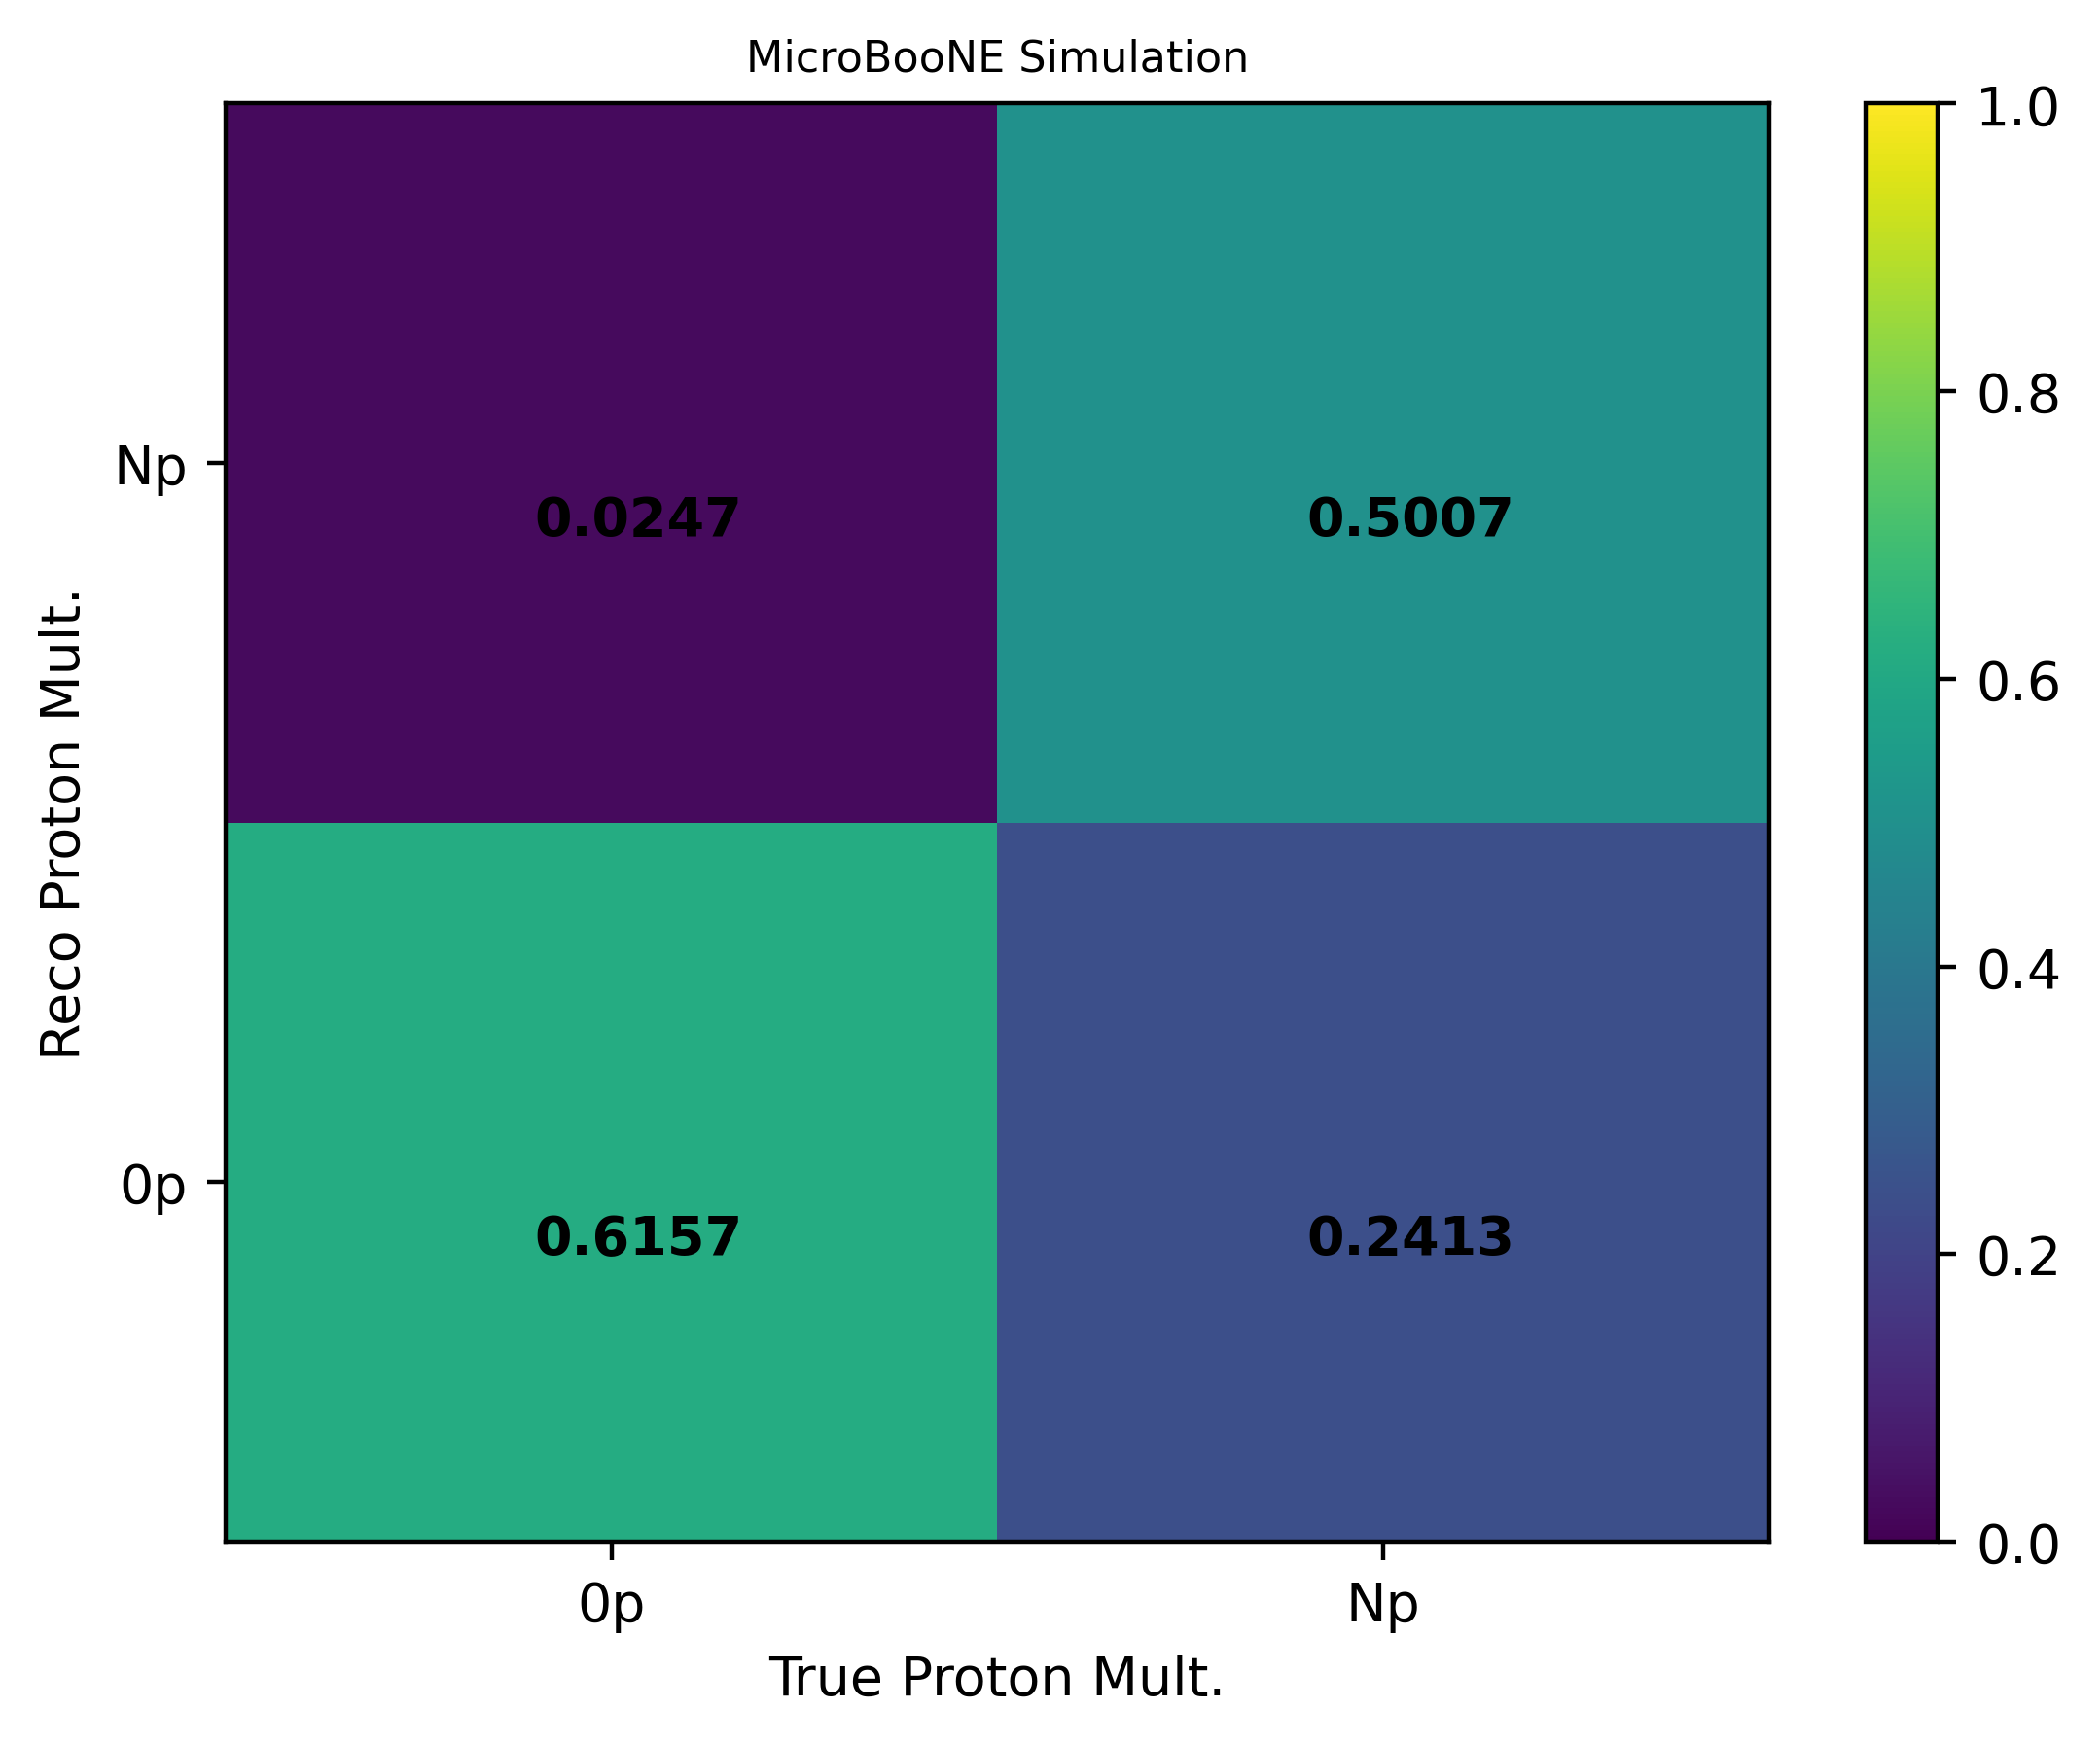

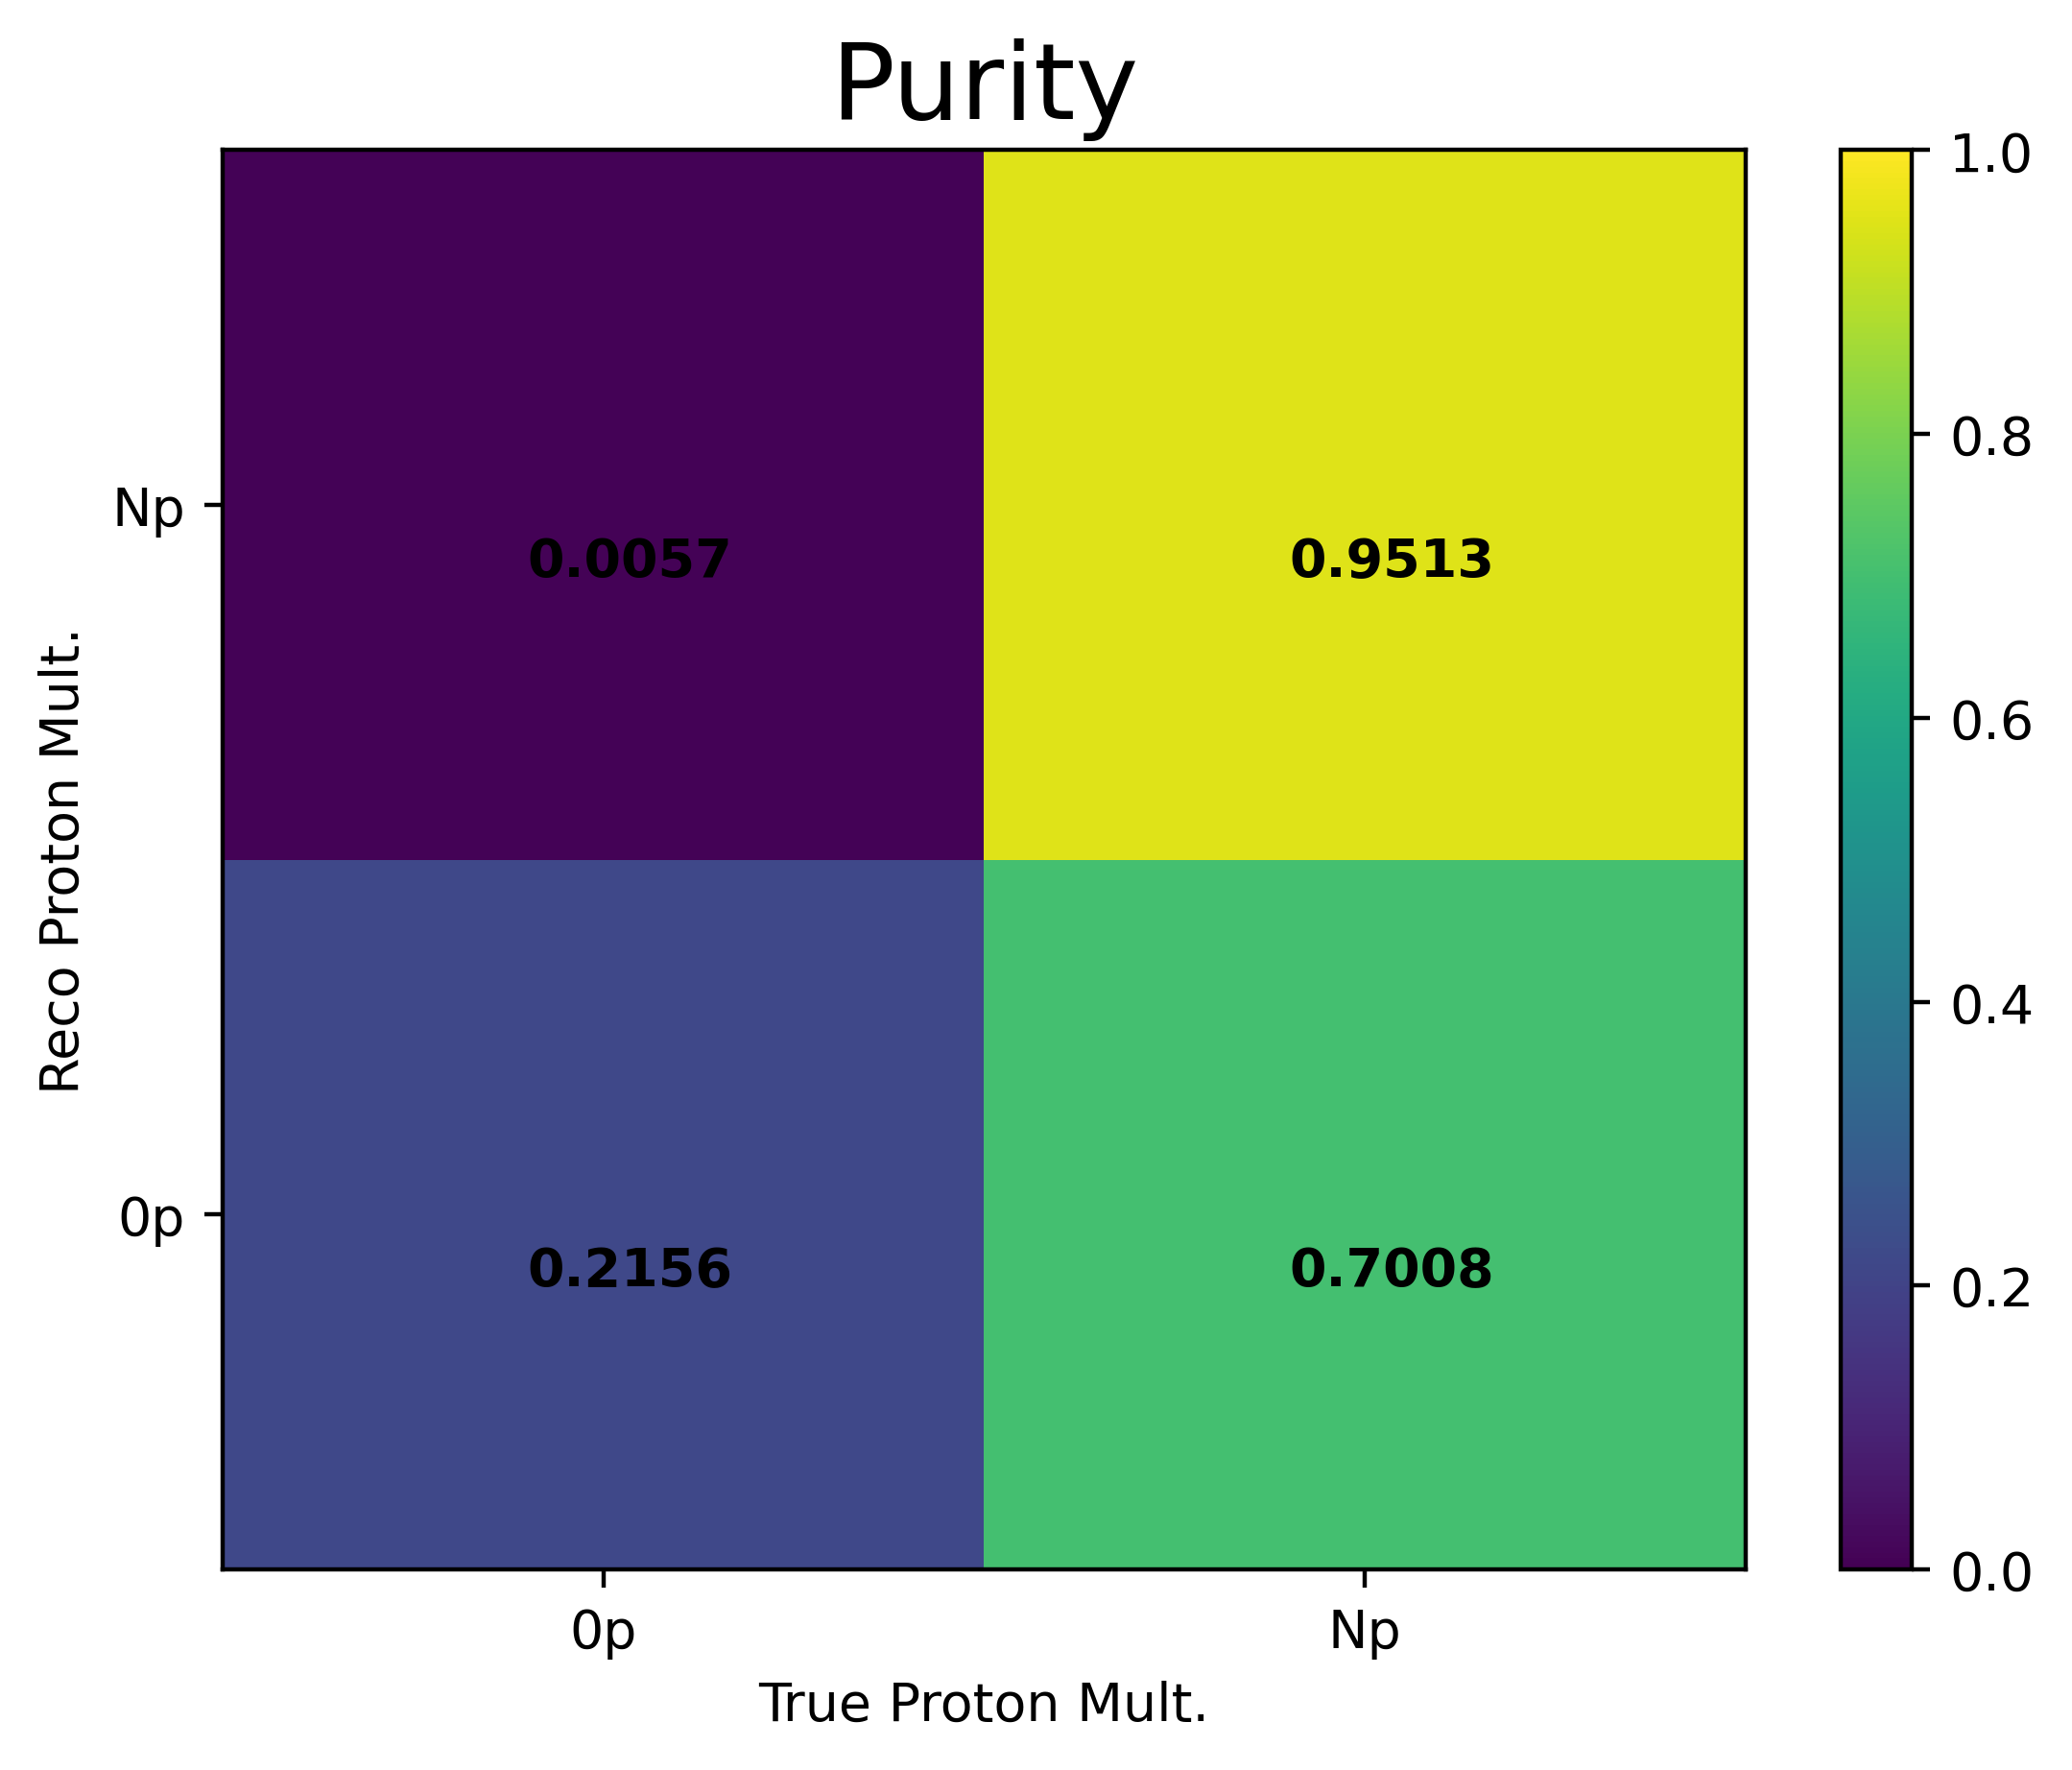

In [33]:
#Efficency wrt numuCC
col_sum = R.sum(axis=0)
plt.figure(dpi=400)
c = plt.pcolormesh(x, y, (R/col_sum), vmin=0, vmax=1)
plt.colorbar(c)

plt.ylabel('Reco Proton Mult.')
plt.xlabel('True Proton Mult.')
plt.xticks([0.5,1.5],['0p','Np'])
plt.yticks([0.5,1.5],['0p','Np'])
R_eff = (R/col_sum)
for i in range(2):
    for j in range(2):
        plt.text(i+0.4,j+0.4,round(R_eff[j,i],2),fontweight='semibold')
        #plt.text(i+0.4,j+0.4,round(R[i,j],2),fontweight='semibold')
plt.title("MicroBooNE Simulation", fontsize=10, loc="right")
plt.show()

#purity wrt numuCC
row_sum = R.T.sum(axis=0)

plt.figure(dpi=400)
c = plt.pcolormesh(x, y, (R.T/row_sum).T, vmin=0, vmax=1)
plt.colorbar(c)

plt.ylabel('Reco Proton Mult.')
plt.xlabel('True Proton Mult.')
plt.xticks([0.5,1.5],['0p','Np'])
plt.yticks([0.5,1.5],['0p','Np'])
R_pure = (R.T/row_sum).T
for i in range(2):
    for j in range(2):
        plt.text(i+0.4,j+0.4,round(R_pure[j,i],2),fontweight='semibold')
        #plt.text(i+0.4,j+0.4,round(R[i,j],2),fontweight='semibold')
plt.title("MicroBooNE Simulation", fontsize=10, loc="right")
plt.show()

#efficency
plt.figure(dpi=400)
col_sum = sig
c = plt.pcolormesh(x, y, (R/col_sum), vmin=0, vmax=1)
plt.colorbar(c)
           
plt.ylabel('Reco Proton Mult.')
plt.xlabel('True Proton Mult.')
plt.xticks([0.5,1.5],['0p','Np'])
plt.yticks([0.5,1.5],['0p','Np'])
R_eff = (R/col_sum)
for i in range(2):
    for j in range(2):
        plt.text(i+0.4,j+0.4,round(R_eff[j,i],4),fontweight='semibold')
plt.title("MicroBooNE Simulation", fontsize=8)
plt.show()

#purity
row_sum = sel
plt.figure(dpi=400)
c = plt.pcolormesh(x, y, (R.T/row_sum).T, vmin=0, vmax=1)
plt.colorbar(c)

plt.ylabel('Reco Proton Mult.')
plt.xlabel('True Proton Mult.')
plt.xticks([0.5,1.5],['0p','Np'])
plt.yticks([0.5,1.5],['0p','Np'])
R_pure = (R.T/row_sum).T
for i in range(2):
    for j in range(2):
        plt.text(i+0.4,j+0.4,round(R_pure[j,i],4),fontweight='semibold')
plt.title("Purity", fontsize=20)

plt.show()

The next two blocks make plots of the efficencies and purities for diffrent reco thresholds and the truth level threshold defined at the beggining of this set of blcoks. The other varibales specified at the beggingin of the previouse two blocks are also used here.

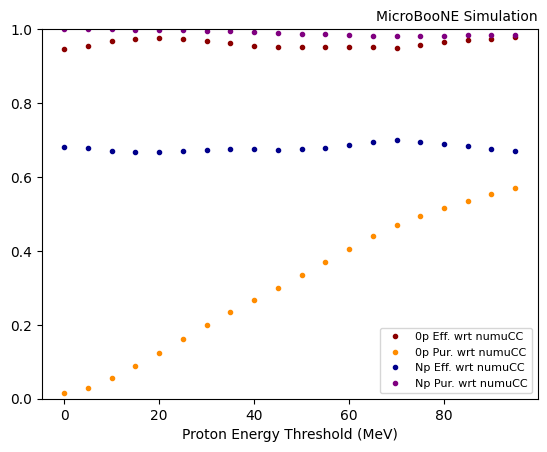

<Figure size 640x480 with 0 Axes>

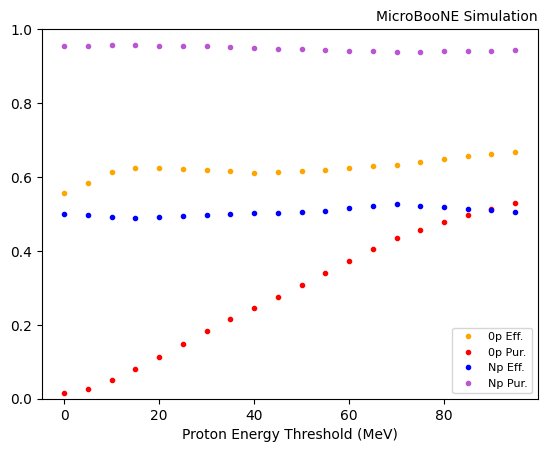

In [34]:
thl = np.arange(0,100,5)

n_sel_sig_events = len(sig_sel_np)

effnp = []
eff0p = []

purnp = []
pur0p = []

effnp_all = []
eff0p_all = []

purnp_all = []
pur0p_all = []

effnp = []
eff0p = []

purnp = []
pur0p = []

effnp_all = []
eff0p_all = []

purnp_all = []
pur0p_all = []

for n in range(len(thl)):
    
    th = thl[n]
    rth = thl[n]
    
    R = np.array([[0,0],[0,0]])    

    for event in range(n_sel_sig_events):
        tbin = 0
        rbin = 0
        tnp = sig_sel_tnp[event]
        rnp = sig_sel_np[event]
        tEp = sig_sel_tEp[event]
        rEp = sig_sel_Ep[event]
        weight = np.nan_to_num(weights[event])
        if tEp > th: tbin = 1
        if rEp > rth: rbin = 1
        R[rbin][tbin] += weight
        
    sel = np.array([0,0])

    for event in range(n_sel_events):
        rbin = 0
        rnp = sel_np[event]
        rEp = sel_Ep[event]
        weight = np.nan_to_num(weights_sel[event])
        if rEp > rth: rbin = 1
        sel[rbin] += weight
    
    sig = np.array([0,0])

    for event in range(n_sig_events):
        tbin = 0
        tnp = sig_tnp[event]
        tEp = sig_tEp[event]
        weight = np.nan_to_num(weights_sig[event])
        if tEp > th: tbin = 1
        sig[tbin] += weight

    R_eff = R/R.sum(axis=0)
    
    effnp.append(R_eff[1][1])
    eff0p.append(R_eff[0][0])
    
    R_eff_all = R/sig
    
    effnp_all.append(R_eff_all[1][1])
    eff0p_all.append(R_eff_all[0][0])
    
    R_pur = (R.T/R.T.sum(axis=0)).T
    
    purnp.append(R_pur[1][1])
    pur0p.append(R_pur[0][0])
    
    R_pur_all = (R.T/sel).T
    
    purnp_all.append(R_pur_all[1][1])
    pur0p_all.append(R_pur_all[0][0])
        
plt.figure()
plt.plot(thl, eff0p, label=f'0p Eff. wrt numuCC', marker='.', lw=0, color='darkred')
plt.plot(thl, pur0p, label=f'0p Pur. wrt numuCC', marker='.', lw=0, color='darkorange')
plt.plot(thl, effnp, label=f'Np Eff. wrt numuCC', marker='.', lw=0, color='darkblue')
plt.plot(thl, purnp, label=f'Np Pur. wrt numuCC', marker='.', lw=0, color='purple')
plt.ylim([0,1])
plt.title("MicroBooNE Simulation", fontsize=10, loc="right")
plt.legend(fontsize=8)
plt.xlabel("Proton Energy Threshold (MeV)")
plt.show()
plt.figure()


plt.figure()
plt.plot(thl, eff0p_all, label=f'0p Eff.', marker='.', lw=0, color='orange')
plt.plot(thl, pur0p_all, label=f'0p Pur.', marker='.', lw=0, color='red')
plt.plot(thl, effnp_all, label=f'Np Eff.', marker='.', lw=0, color='blue')
plt.plot(thl, purnp_all, label=f'Np Pur.', marker='.', lw=0, color='mediumorchid')

#plt.xlim([x[0],x[-1]])
plt.ylim([0,1])
plt.title("MicroBooNE Simulation", fontsize=10, loc="right")
plt.legend(fontsize=8)
plt.xlabel("Proton Energy Threshold (MeV)")
plt.show()


The next two blocks make plots of the efficencies and purities for diffrent reco thresholds and the truth level threshold defined at the beggining of this set of blocks. The other varibales specified at the beggining of the previouse two blocks are also used here.

In [35]:
thl = np.arange(0,100,5)

n_sel_sig_events = len(sig_sel_np)

effnp = []
eff0p = []

purnp = []
pur0p = []

effnp_all = []
eff0p_all = []

purnp_all = []
pur0p_all = []

for n in range(len(thl)):
    
    th = 35
    rth = thl[n]
    
    R = np.array([[0,0],[0,0]])    

    for event in range(n_sel_sig_events):
        tbin = 0
        rbin = 0
        tnp = sig_sel_tnp[event]
        rnp = sig_sel_np[event]
        tEp = sig_sel_tEp[event]
        rEp = sig_sel_Ep[event]
        weight = np.nan_to_num(weights[event])
        if tEp > th: tbin = 1
        if rEp > rth: rbin = 1
        R[rbin][tbin] += weight
        
    sel = np.array([0,0])

    for event in range(n_sel_events):
        rbin = 0
        rnp = sel_np[event]
        rEp = sel_Ep[event]
        weight = np.nan_to_num(weights_sel[event])
        if rEp > rth: rbin = 1
        sel[rbin] += weight
    
    sig = np.array([0,0])

    for event in range(n_sig_events):
        tbin = 0
        tnp = sig_tnp[event]
        tEp = sig_tEp[event]
        weight = np.nan_to_num(weights_sig[event])
        if tEp > th: tbin = 1
        sig[tbin] += weight

    R_eff = R/(R.sum(axis=0))
    
    effnp.append(R_eff[1][1])
    eff0p.append(R_eff[0][0])
    
    R_pur = (R.T/(R.T.sum(axis=0))).T
    
    purnp.append(R_pur[1][1])
    pur0p.append(R_pur[0][0])
    
    R_eff_all = R/(sig)
    
    effnp_all.append(R_eff_all[1][1])
    eff0p_all.append(R_eff_all[0][0])
    
    R_pur_all = (R.T/sel).T
    
    purnp_all.append(R_pur_all[1][1])
    pur0p_all.append(R_pur_all[0][0])

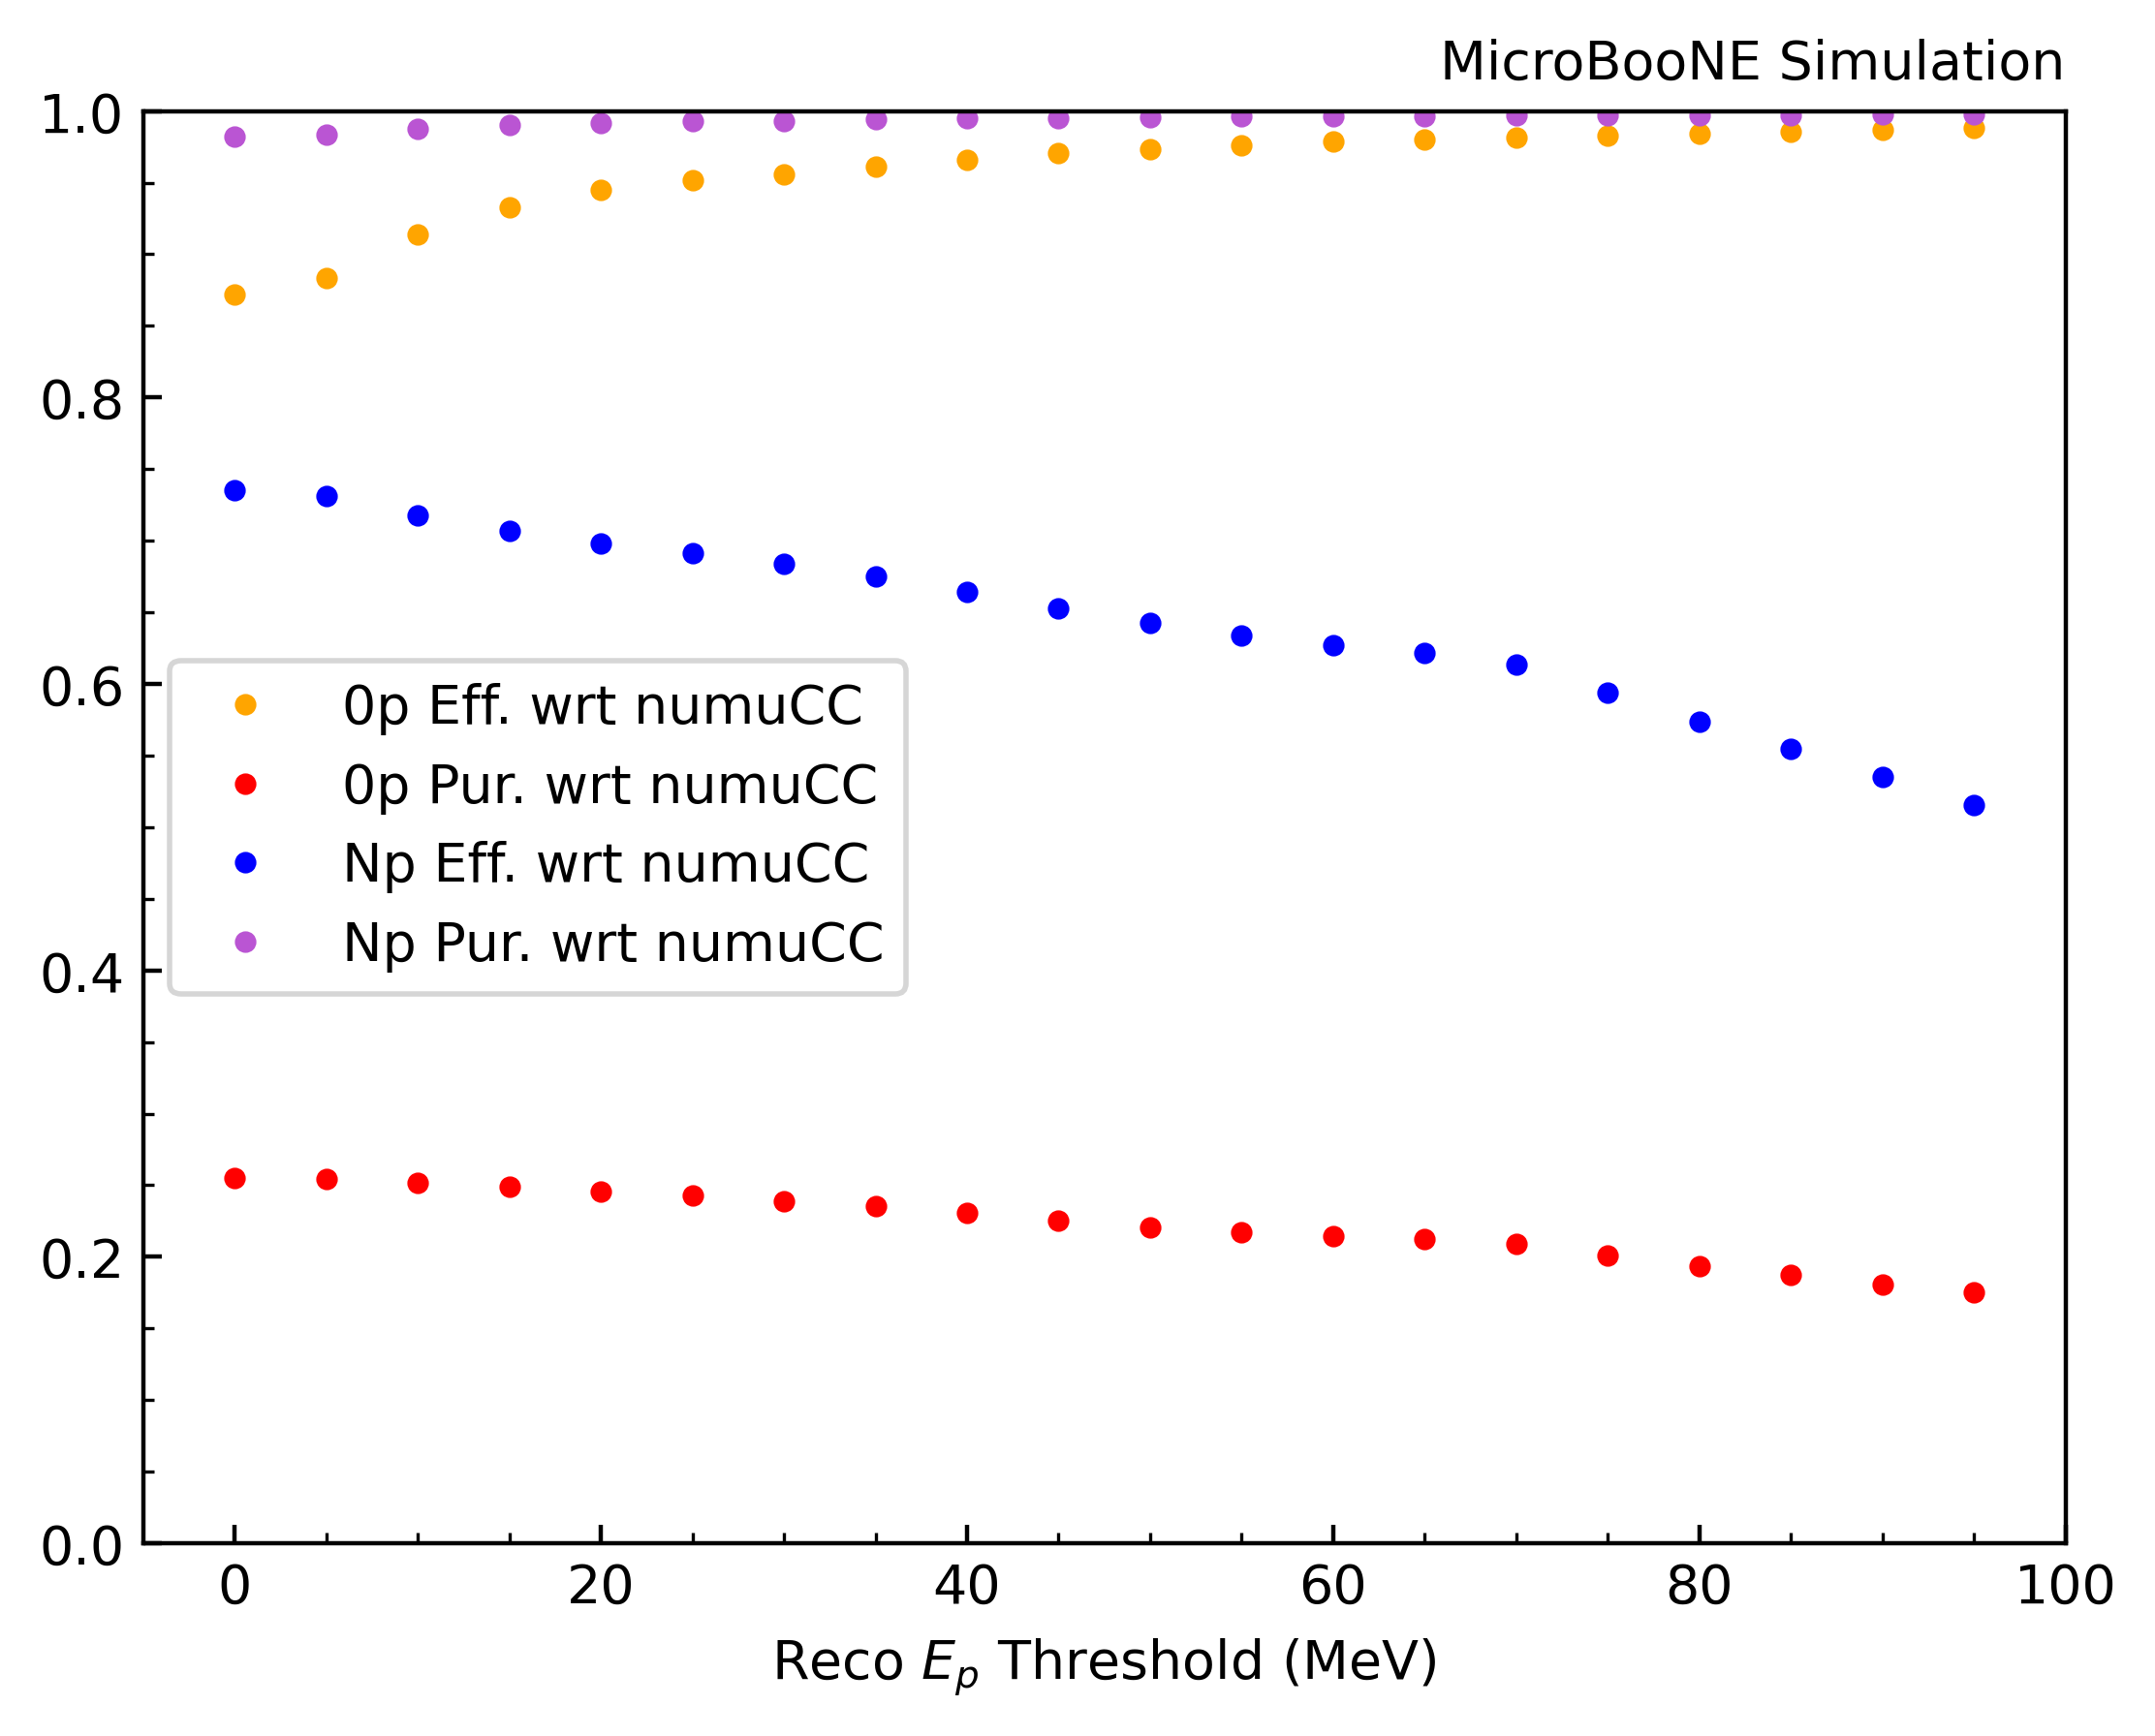

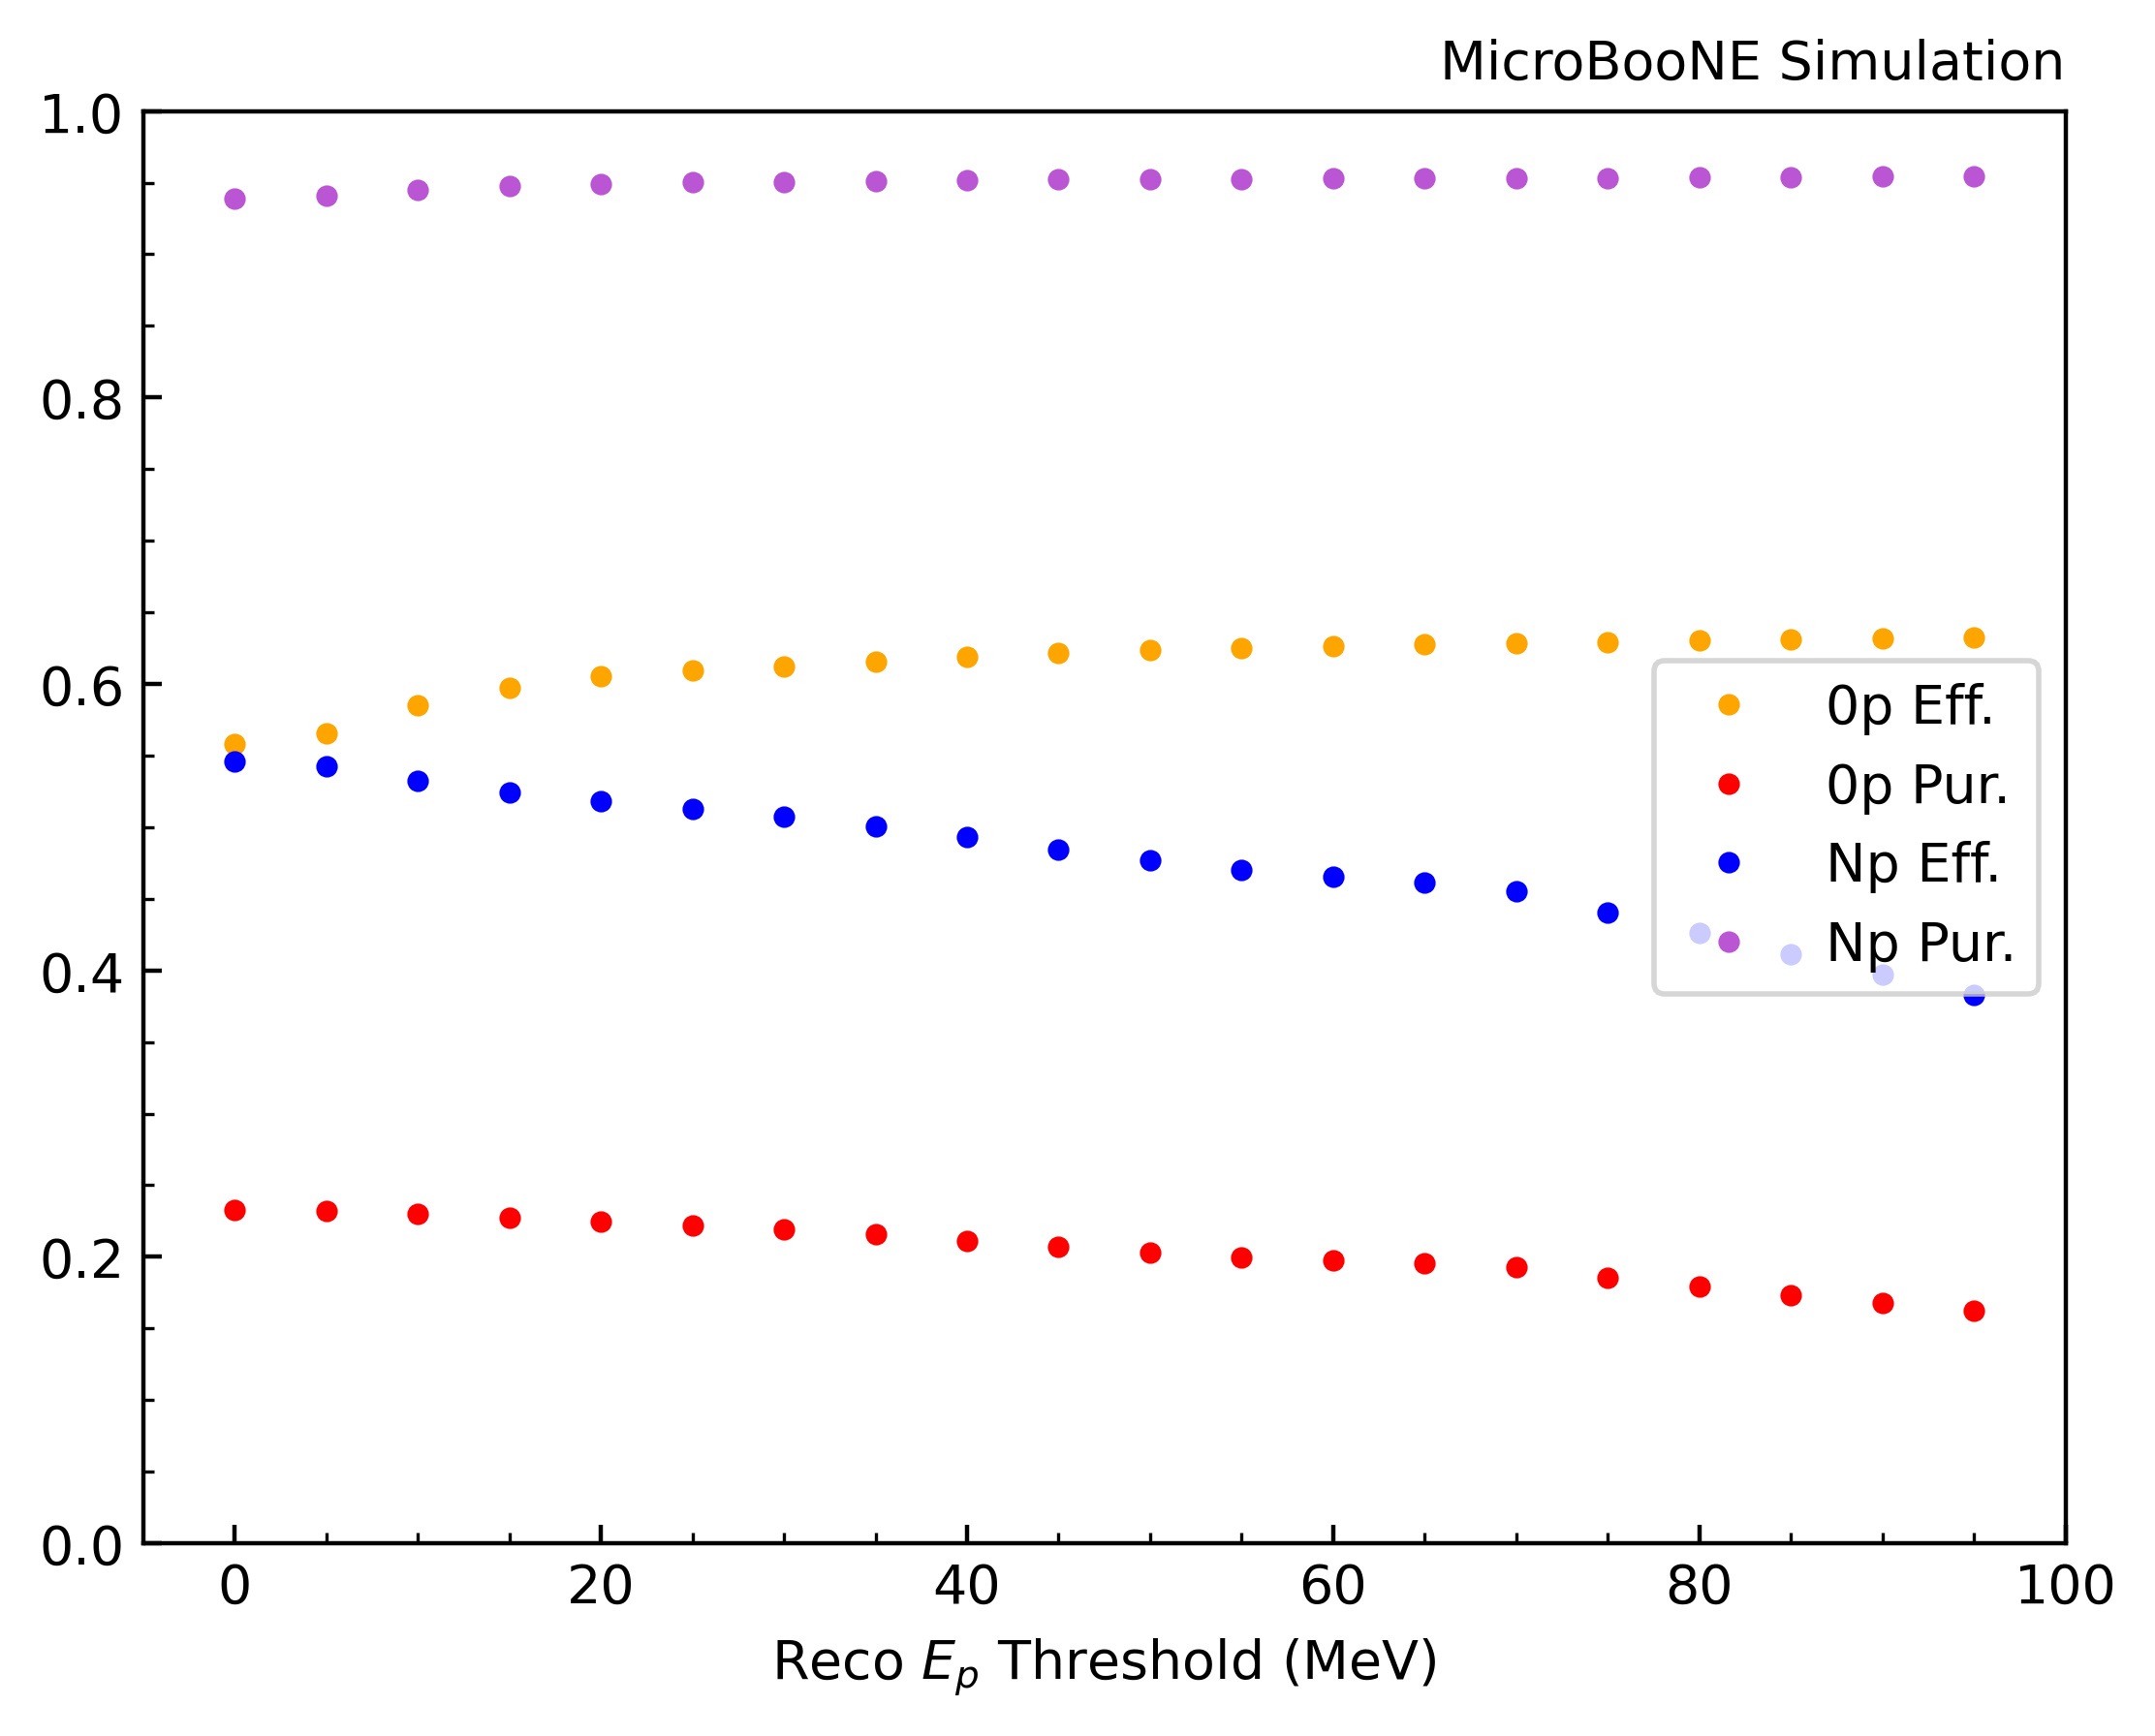

In [38]:
plt.figure(dpi=400)
plt.plot(thl, eff0p, label=f'0p Eff. wrt numuCC', marker='.', lw=0, color='orange')
plt.plot(thl, pur0p, label=f'0p Pur. wrt numuCC', marker='.', lw=0, color='red')
plt.plot(thl, effnp, label=f'Np Eff. wrt numuCC', marker='.', lw=0, color='blue')
plt.plot(thl, purnp, label=f'Np Pur. wrt numuCC', marker='.', lw=0, color='mediumorchid')
plt.minorticks_on()
plt.tick_params(which='minor',direction='in')
plt.tick_params(axis="x", direction="in")
plt.tick_params(axis="y", direction="in")
plt.xlim([-5,100])
plt.ylim([0,1])
plt.title("MicroBooNE Simulation", fontsize=10, loc="right")
plt.legend(fontsize=10, loc="center left")
plt.xlabel("Reco $E_p$ Threshold (MeV)")
plt.show()

plt.figure(dpi=400)
plt.plot(thl, eff0p_all, label=f'0p Eff.', marker='.', lw=0, color='orange')
plt.plot(thl, pur0p_all, label=f'0p Pur.', marker='.', lw=0, color='red')
plt.plot(thl, effnp_all, label=f'Np Eff.', marker='.', lw=0, color='blue')
plt.plot(thl, purnp_all, label=f'Np Pur.', marker='.', lw=0, color='mediumorchid')
plt.minorticks_on()
plt.tick_params(which='minor',direction='in')
plt.tick_params(axis="x", direction="in")
plt.tick_params(axis="y", direction="in")
plt.xlim([-5,100])
plt.ylim([0,1])
plt.title("MicroBooNE Simulation", fontsize=10, loc="right")
plt.legend(fontsize=10)
plt.xlabel("Reco $E_p$ Threshold (MeV)")
plt.show()